# Learning Deep Convolutional Networks for Demosaicing

> Original paper by Nai-Sheng Syu, Yu-SHeng Chen, Yung-Yu Chuang [[1]](https://arxiv.org/pdf/1802.03769.pdf)

> Homepage for the paper: [link](http://www.cmlab.csie.ntu.edu.tw/project/Deep-Demosaic/) (As of 24.4.2019 the authors have not released the original code)

### About the notebook

This notebook and repository aims to reproduce the state-of-the-art results provided in the [1]. 

**Author:** Eemeli Saari

**Email:** saari.eemeli@gmail.com

**Modified:** 24.4.2019

---

In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from torchsummary import summary

We'll set a standard seed for reproducibility.

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## Data

We load the data from the authors homepage and define a Pytorch dataset that reads patches from the images.

The image patches are densely extracted $33 \times 33$ patches that are padded with zeros to make up for the missing channels.

In [3]:
from dataset import download_data, ImagePatchDataset

In [4]:
%time dataset = ImagePatchDataset(root=download_data(), sample_size=50)
len(dataset)

Wall time: 16.2 s


25000

In [5]:
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1024,
    shuffle=True
)

## DMCNN Model

We'll first define the DMCNN model described by the paper [1].

Model contains

- Feature extraction layer
  - 128 Filters with $9\times9$ kernels.
- Non-linear mapping layer
  - 64 Filters with $1\times1$ kernels.
- Reconstruction layer
  - 3 Kernels constructing the resulted colored image
  - $5\times5$ kernels.

In [6]:
class DMCNN(torch.nn.Module):
    """DMCNN
    
    Model adopted from [link](https://arxiv.org/pdf/1802.03769.pdf)
    """
    def __init__(self):
        super(DMCNN, self).__init__()
        
        self.feature_layer = torch.nn.Sequential(
            torch.nn.Conv2d(3, 128, kernel_size=9),
            torch.nn.ReLU()
        )
        
        self.mapping_layer = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, kernel_size=1),
            torch.nn.ReLU()
        )
        
        self.reconstruction_layer = torch.nn.Sequential(
            torch.nn.Conv2d(64, 3, kernel_size=5),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        out = self.feature_layer(x)
        out = self.mapping_layer(out)
        out = self.reconstruction_layer(out)
        return out


In [7]:
%time model = DMCNN().cuda()

Wall time: 3.99 s


In [8]:
summary(model, input_size=(3, 33, 33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 25, 25]          31,232
              ReLU-2          [-1, 128, 25, 25]               0
            Conv2d-3           [-1, 64, 25, 25]           8,256
              ReLU-4           [-1, 64, 25, 25]               0
            Conv2d-5            [-1, 3, 21, 21]           4,803
              ReLU-6            [-1, 3, 21, 21]               0
Total params: 44,291
Trainable params: 44,291
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.85
Params size (MB): 0.17
Estimated Total Size (MB): 2.03
----------------------------------------------------------------


As we can see it's a fairly shallow convolution neural network that should be fairly fast to train.

In [9]:
device = torch.device('cuda:0')

## Training the model

The Pytorch framework doesn't offer the similar sklearn type API that's supported in the Keras so we'll need to manually create the training loop.

First we'll define the the loss function as the standard $L_2$ norm.

$$ L(\theta) = \frac{1}{n} \sum_{n}^{n=1}||F(Y_i ; \theta) - X_i||^2 $$

In [10]:
criterion = torch.nn.MSELoss()

According to the original paper the DMCNN is trained using the stochastic gradient descent with learning rate 1 for the first two layers and 0.1 for the last layer.

This comes easy to define in Pytorch as following:

In [11]:
optimizer = torch.optim.SGD(
    params = [
        {"params": model.feature_layer.parameters(), "lr": 1},
        {"params": model.mapping_layer.parameters(), "lr": 1},
        {"params": model.reconstruction_layer.parameters(), "lr": 0.1}
    ]
)

In [12]:
n_epochs = 500

We'll define the training loop to include the clipping to keep the gradients within -1 and 1.

Epoch [0/500], Step [0/25], Loss: 0.26069048047065735
Epoch [0/500], Step [10/25], Loss: 0.07517138868570328
Epoch [0/500], Step [20/25], Loss: 0.06590192764997482

Finished Epoch 0, Loss --- mean: 0.09128046095371246, std 0.04838512304333679



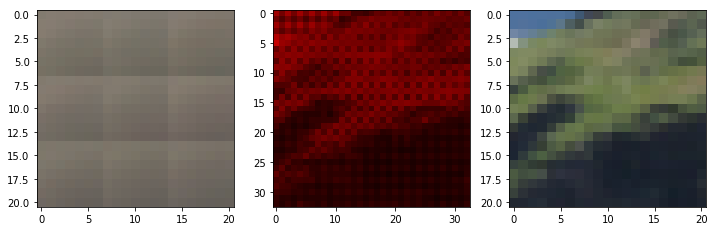

Epoch [1/500], Step [0/25], Loss: 0.07471490651369095
Epoch [1/500], Step [10/25], Loss: 0.068081796169281
Epoch [1/500], Step [20/25], Loss: 0.057738229632377625

Finished Epoch 1, Loss --- mean: 0.05746002897620201, std 0.009803996598745193



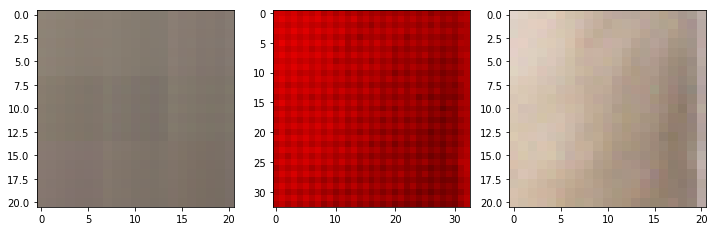

Epoch [2/500], Step [0/25], Loss: 0.047164708375930786
Epoch [2/500], Step [10/25], Loss: 0.046949926763772964
Epoch [2/500], Step [20/25], Loss: 0.04035264253616333

Finished Epoch 2, Loss --- mean: 0.04691621199250221, std 0.004554912601964424



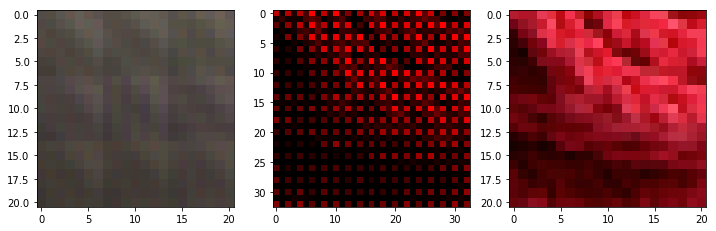

Epoch [3/500], Step [0/25], Loss: 0.0515742227435112
Epoch [3/500], Step [10/25], Loss: 0.04190570116043091
Epoch [3/500], Step [20/25], Loss: 0.04249349981546402

Finished Epoch 3, Loss --- mean: 0.041733136177062986, std 0.003615909411375124



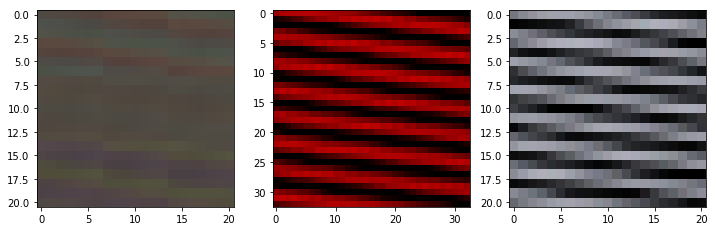

Epoch [4/500], Step [0/25], Loss: 0.03827061131596565
Epoch [4/500], Step [10/25], Loss: 0.039021387696266174
Epoch [4/500], Step [20/25], Loss: 0.037135422229766846

Finished Epoch 4, Loss --- mean: 0.038511400818824766, std 0.003358517061146543



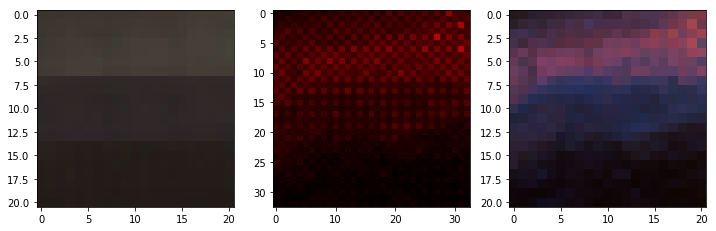

Epoch [5/500], Step [0/25], Loss: 0.036792632192373276
Epoch [5/500], Step [10/25], Loss: 0.03329010307788849
Epoch [5/500], Step [20/25], Loss: 0.03288404643535614

Finished Epoch 5, Loss --- mean: 0.03599422350525856, std 0.002204106371075171



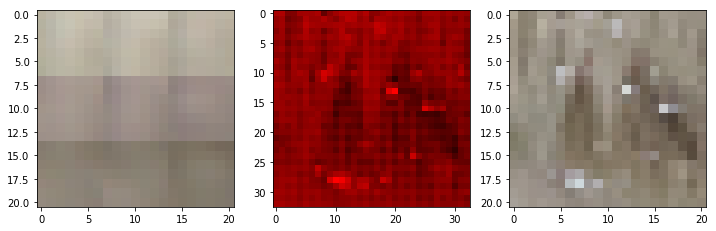

Epoch [6/500], Step [0/25], Loss: 0.03996327146887779
Epoch [6/500], Step [10/25], Loss: 0.032766200602054596
Epoch [6/500], Step [20/25], Loss: 0.03280884772539139


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 6, Loss --- mean: 0.03362396575510502, std 0.0022532253836811712



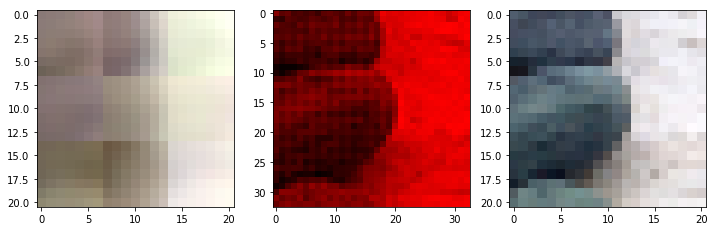

Epoch [7/500], Step [0/25], Loss: 0.03483433276414871
Epoch [7/500], Step [10/25], Loss: 0.03625469282269478
Epoch [7/500], Step [20/25], Loss: 0.03682785481214523

Finished Epoch 7, Loss --- mean: 0.03358043909072876, std 0.0030316538631549755



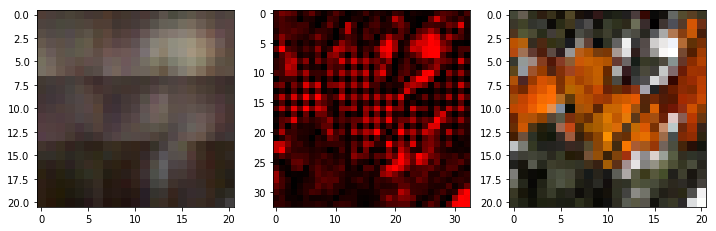

Epoch [8/500], Step [0/25], Loss: 0.03304312005639076
Epoch [8/500], Step [10/25], Loss: 0.030607614666223526
Epoch [8/500], Step [20/25], Loss: 0.02721971832215786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 8, Loss --- mean: 0.030108580589294432, std 0.0021909423828933546



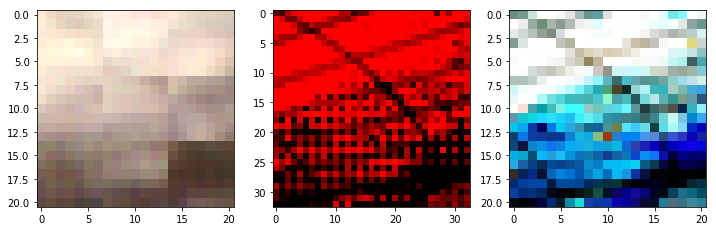

Epoch [9/500], Step [0/25], Loss: 0.03242657706141472
Epoch [9/500], Step [10/25], Loss: 0.03030439279973507
Epoch [9/500], Step [20/25], Loss: 0.03310670331120491

Finished Epoch 9, Loss --- mean: 0.03095898061990738, std 0.0026141713835674822



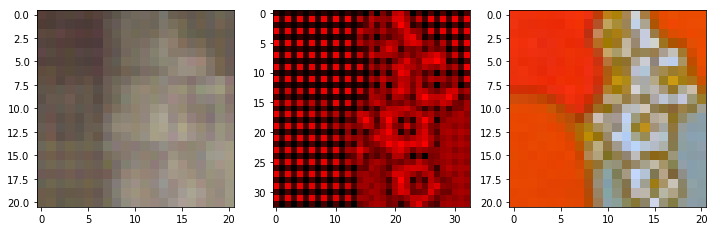

Epoch [10/500], Step [0/25], Loss: 0.025694210082292557
Epoch [10/500], Step [10/25], Loss: 0.028081217780709267
Epoch [10/500], Step [20/25], Loss: 0.030156049877405167

Finished Epoch 10, Loss --- mean: 0.029695279151201247, std 0.0017745838587929323



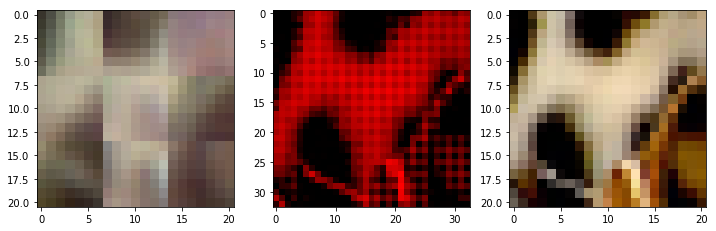

Epoch [11/500], Step [0/25], Loss: 0.03249740973114967
Epoch [11/500], Step [10/25], Loss: 0.033851753920316696
Epoch [11/500], Step [20/25], Loss: 0.02752392552793026

Finished Epoch 11, Loss --- mean: 0.029158335998654365, std 0.0021044807209615515



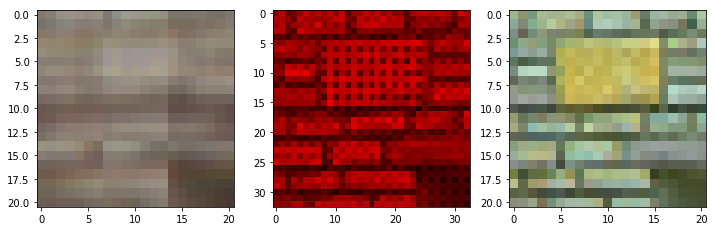

Epoch [12/500], Step [0/25], Loss: 0.02668941766023636
Epoch [12/500], Step [10/25], Loss: 0.025339275598526
Epoch [12/500], Step [20/25], Loss: 0.03082663007080555

Finished Epoch 12, Loss --- mean: 0.028384054750204085, std 0.0021346960734380505



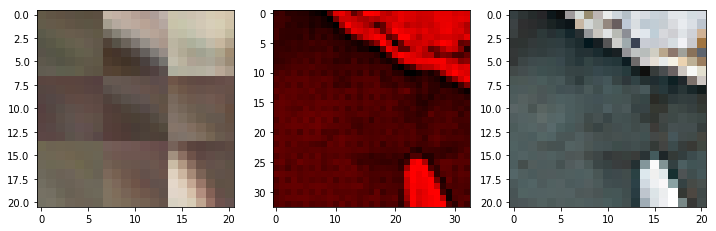

Epoch [13/500], Step [0/25], Loss: 0.026943186298012733
Epoch [13/500], Step [10/25], Loss: 0.031739626079797745
Epoch [13/500], Step [20/25], Loss: 0.02628902532160282

Finished Epoch 13, Loss --- mean: 0.027982418611645698, std 0.0018674355867392782



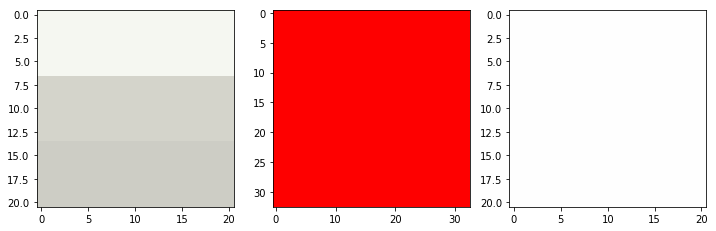

Epoch [14/500], Step [0/25], Loss: 0.025463297963142395
Epoch [14/500], Step [10/25], Loss: 0.02499137632548809
Epoch [14/500], Step [20/25], Loss: 0.026627538725733757


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 14, Loss --- mean: 0.026395884081721305, std 0.0015799567002902613



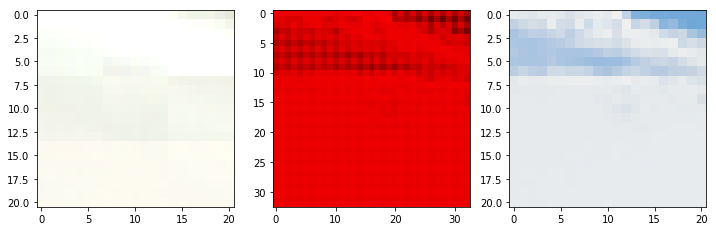

Epoch [15/500], Step [0/25], Loss: 0.030474720522761345
Epoch [15/500], Step [10/25], Loss: 0.02487669326364994
Epoch [15/500], Step [20/25], Loss: 0.028410235419869423

Finished Epoch 15, Loss --- mean: 0.027827003598213197, std 0.002045806344431088



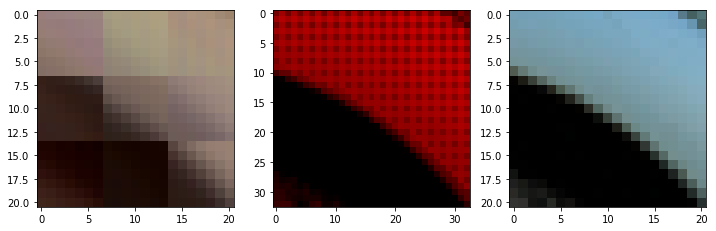

Epoch [16/500], Step [0/25], Loss: 0.02555439993739128
Epoch [16/500], Step [10/25], Loss: 0.026758717373013496
Epoch [16/500], Step [20/25], Loss: 0.025388579815626144

Finished Epoch 16, Loss --- mean: 0.026349147856235502, std 0.0015730770719760213



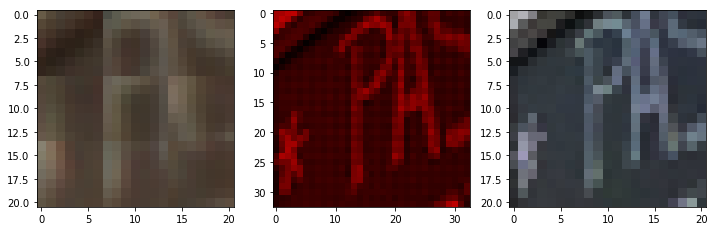

Epoch [17/500], Step [0/25], Loss: 0.023845547810196877
Epoch [17/500], Step [10/25], Loss: 0.026574108749628067
Epoch [17/500], Step [20/25], Loss: 0.02929232455790043

Finished Epoch 17, Loss --- mean: 0.026693722158670427, std 0.001888577311357769



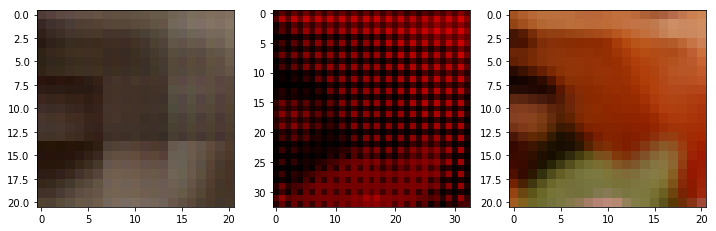

Epoch [18/500], Step [0/25], Loss: 0.025814644992351532
Epoch [18/500], Step [10/25], Loss: 0.02674291655421257
Epoch [18/500], Step [20/25], Loss: 0.023608194664120674

Finished Epoch 18, Loss --- mean: 0.025744751542806626, std 0.0011716061483083584



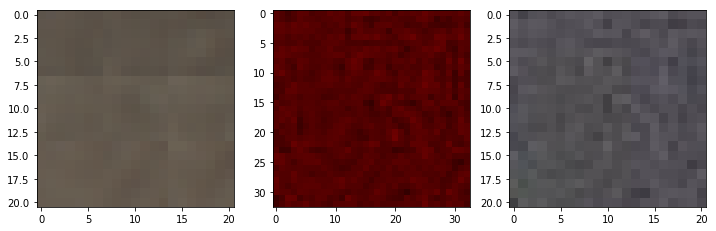

Epoch [19/500], Step [0/25], Loss: 0.024854982271790504
Epoch [19/500], Step [10/25], Loss: 0.024495871737599373
Epoch [19/500], Step [20/25], Loss: 0.024634432047605515

Finished Epoch 19, Loss --- mean: 0.02529069975018501, std 0.001015890632209659



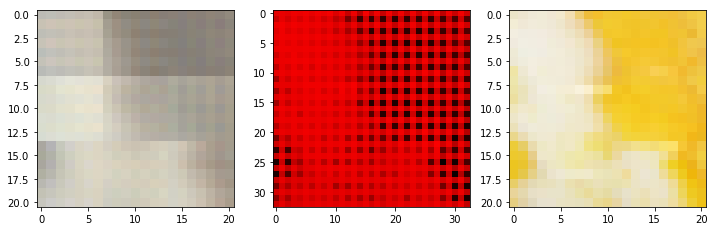

Epoch [20/500], Step [0/25], Loss: 0.026646196842193604
Epoch [20/500], Step [10/25], Loss: 0.024693788960576057
Epoch [20/500], Step [20/25], Loss: 0.02460426092147827

Finished Epoch 20, Loss --- mean: 0.02580404482781887, std 0.0010818622840340678



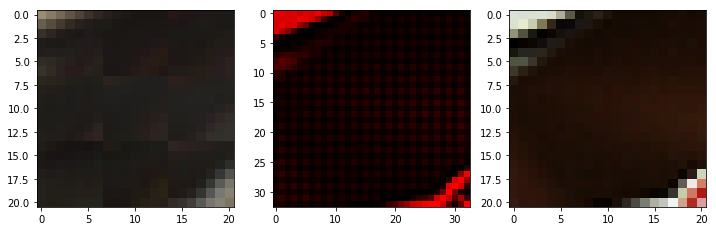

Epoch [21/500], Step [0/25], Loss: 0.024681901559233665
Epoch [21/500], Step [10/25], Loss: 0.025779983028769493
Epoch [21/500], Step [20/25], Loss: 0.025390971451997757

Finished Epoch 21, Loss --- mean: 0.025164715424180032, std 0.0006679199244716047



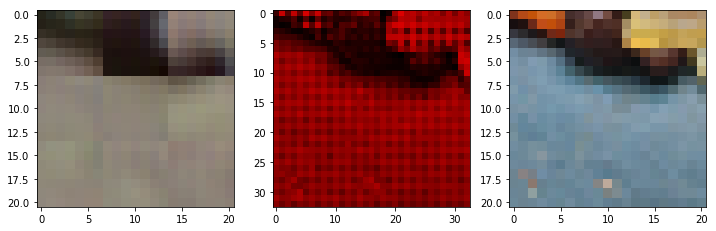

Epoch [22/500], Step [0/25], Loss: 0.02611800655722618
Epoch [22/500], Step [10/25], Loss: 0.025454718619585037
Epoch [22/500], Step [20/25], Loss: 0.023828325793147087

Finished Epoch 22, Loss --- mean: 0.024966250956058502, std 0.0008657681561537022



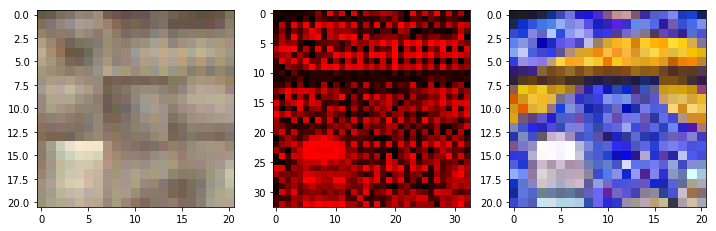

Epoch [23/500], Step [0/25], Loss: 0.024596724659204483
Epoch [23/500], Step [10/25], Loss: 0.0246114544570446
Epoch [23/500], Step [20/25], Loss: 0.023751577362418175

Finished Epoch 23, Loss --- mean: 0.024514332711696625, std 0.0007790431017626873



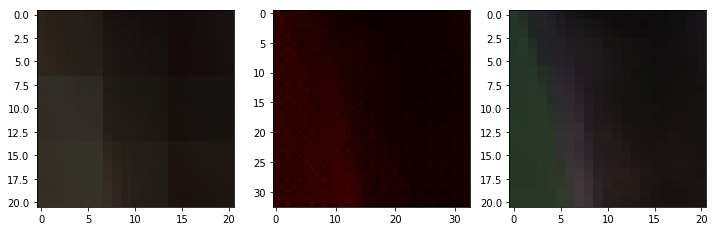

Epoch [24/500], Step [0/25], Loss: 0.02521325834095478
Epoch [24/500], Step [10/25], Loss: 0.024614963680505753
Epoch [24/500], Step [20/25], Loss: 0.024945756420493126

Finished Epoch 24, Loss --- mean: 0.02527425833046436, std 0.0007305755667919204



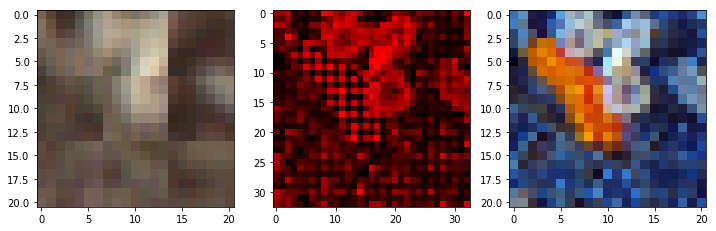

Epoch [25/500], Step [0/25], Loss: 0.023887254297733307
Epoch [25/500], Step [10/25], Loss: 0.023888522759079933
Epoch [25/500], Step [20/25], Loss: 0.024071797728538513

Finished Epoch 25, Loss --- mean: 0.024299733862280844, std 0.0007892418475369284



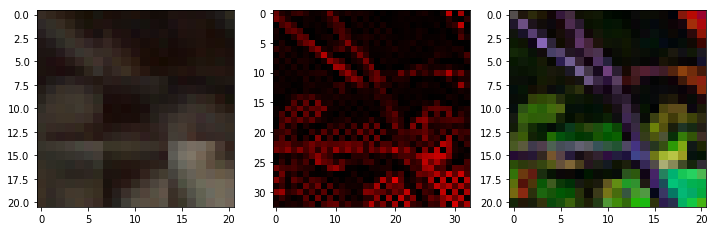

Epoch [26/500], Step [0/25], Loss: 0.02316562831401825
Epoch [26/500], Step [10/25], Loss: 0.02415849268436432
Epoch [26/500], Step [20/25], Loss: 0.02463240548968315

Finished Epoch 26, Loss --- mean: 0.024433237612247468, std 0.0009529830929259404



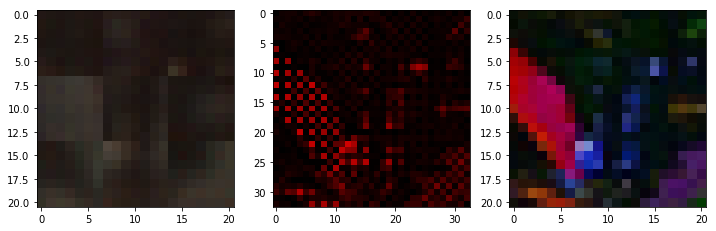

Epoch [27/500], Step [0/25], Loss: 0.025081796571612358
Epoch [27/500], Step [10/25], Loss: 0.025469034910202026
Epoch [27/500], Step [20/25], Loss: 0.023409085348248482

Finished Epoch 27, Loss --- mean: 0.024053986445069314, std 0.0009852547555464885



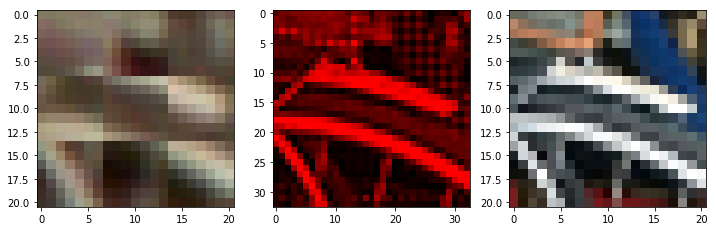

Epoch [28/500], Step [0/25], Loss: 0.023022808134555817
Epoch [28/500], Step [10/25], Loss: 0.02301323227584362
Epoch [28/500], Step [20/25], Loss: 0.022055575624108315

Finished Epoch 28, Loss --- mean: 0.02354675218462944, std 0.0007265378208290676



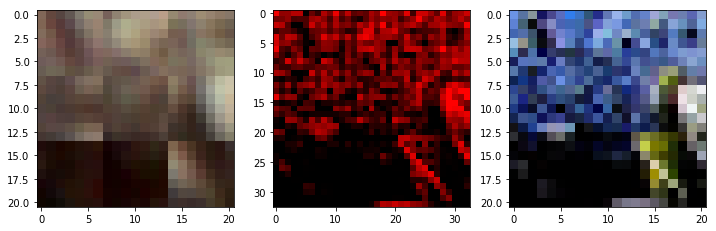

Epoch [29/500], Step [0/25], Loss: 0.02362075448036194
Epoch [29/500], Step [10/25], Loss: 0.024576852098107338
Epoch [29/500], Step [20/25], Loss: 0.024215376004576683

Finished Epoch 29, Loss --- mean: 0.024288081154227256, std 0.0008900533777638367



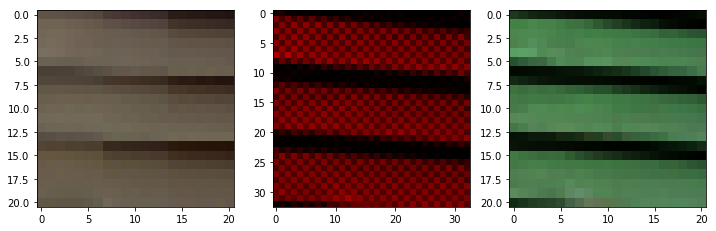

Epoch [30/500], Step [0/25], Loss: 0.02400164119899273
Epoch [30/500], Step [10/25], Loss: 0.023407012224197388
Epoch [30/500], Step [20/25], Loss: 0.02315867319703102

Finished Epoch 30, Loss --- mean: 0.023738550841808318, std 0.0010007711799756107



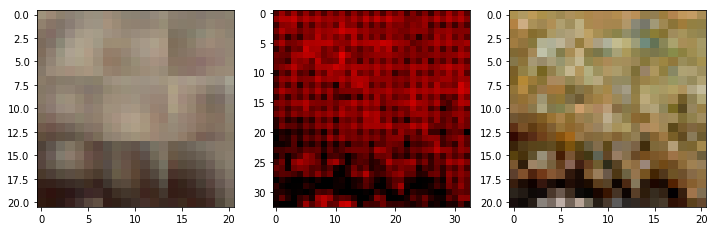

Epoch [31/500], Step [0/25], Loss: 0.023642683401703835
Epoch [31/500], Step [10/25], Loss: 0.022856570780277252
Epoch [31/500], Step [20/25], Loss: 0.022904830053448677


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 31, Loss --- mean: 0.0237030840665102, std 0.0006319893973557522



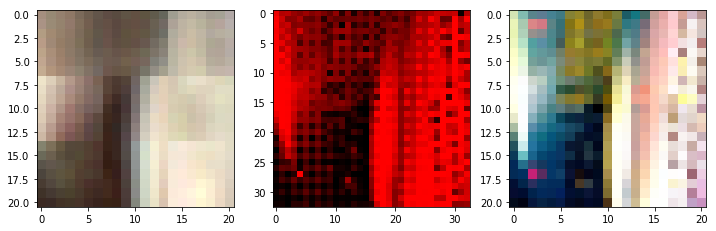

Epoch [32/500], Step [0/25], Loss: 0.02140040323138237
Epoch [32/500], Step [10/25], Loss: 0.02327033132314682
Epoch [32/500], Step [20/25], Loss: 0.022862259298563004

Finished Epoch 32, Loss --- mean: 0.023157366439700126, std 0.0009980065465331125



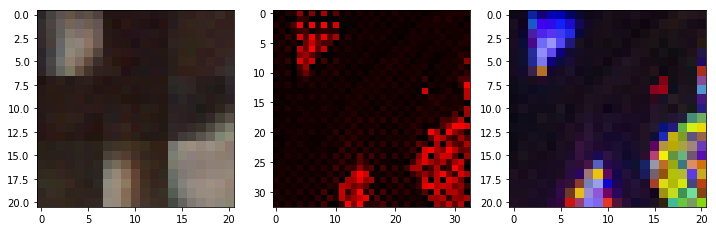

Epoch [33/500], Step [0/25], Loss: 0.025095362216234207
Epoch [33/500], Step [10/25], Loss: 0.022432494908571243
Epoch [33/500], Step [20/25], Loss: 0.023639630526304245

Finished Epoch 33, Loss --- mean: 0.023600653186440466, std 0.001087677715747705



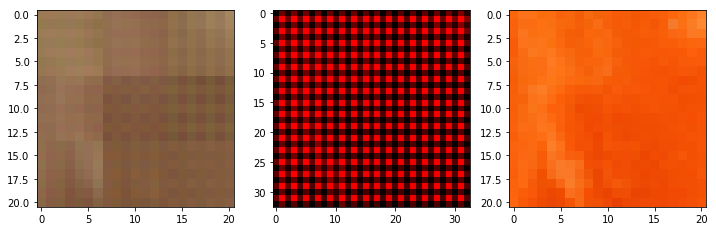

Epoch [34/500], Step [0/25], Loss: 0.023553017526865005
Epoch [34/500], Step [10/25], Loss: 0.022982999682426453
Epoch [34/500], Step [20/25], Loss: 0.023676803335547447

Finished Epoch 34, Loss --- mean: 0.02326742187142372, std 0.0009979562482321331



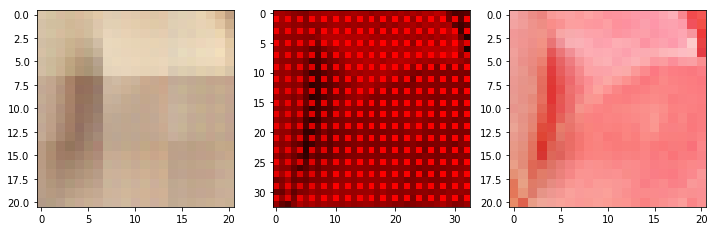

Epoch [35/500], Step [0/25], Loss: 0.023007316514849663
Epoch [35/500], Step [10/25], Loss: 0.02445702813565731
Epoch [35/500], Step [20/25], Loss: 0.022886820137500763

Finished Epoch 35, Loss --- mean: 0.023329282104969026, std 0.0008502800819357855



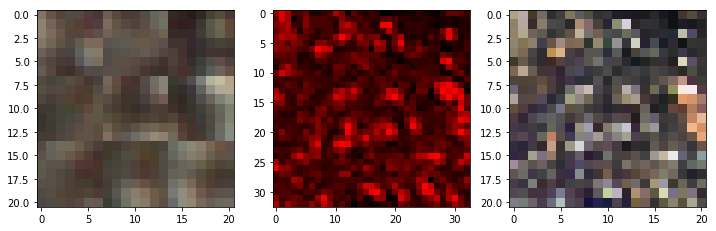

Epoch [36/500], Step [0/25], Loss: 0.024086708202958107
Epoch [36/500], Step [10/25], Loss: 0.023422926664352417
Epoch [36/500], Step [20/25], Loss: 0.02311340719461441

Finished Epoch 36, Loss --- mean: 0.023095039203763008, std 0.000884495258754876



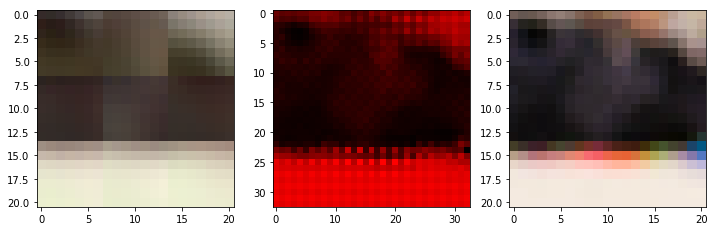

Epoch [37/500], Step [0/25], Loss: 0.025325171649456024
Epoch [37/500], Step [10/25], Loss: 0.022950654849410057
Epoch [37/500], Step [20/25], Loss: 0.024866970255970955

Finished Epoch 37, Loss --- mean: 0.023499806746840476, std 0.0007953069909630193



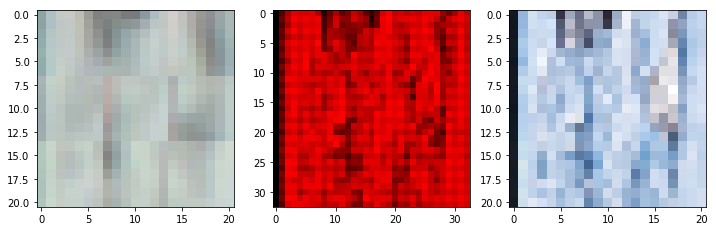

Epoch [38/500], Step [0/25], Loss: 0.021887606009840965
Epoch [38/500], Step [10/25], Loss: 0.02273954637348652
Epoch [38/500], Step [20/25], Loss: 0.022693458944559097

Finished Epoch 38, Loss --- mean: 0.023099056035280226, std 0.000659386996637934



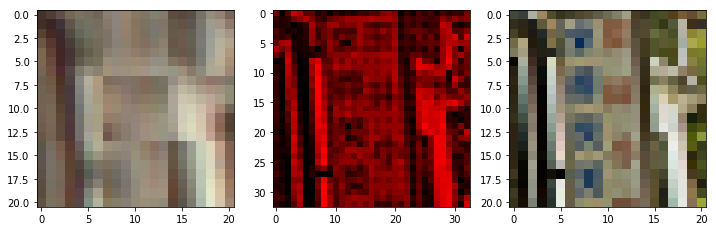

Epoch [39/500], Step [0/25], Loss: 0.023801209405064583
Epoch [39/500], Step [10/25], Loss: 0.024510644376277924
Epoch [39/500], Step [20/25], Loss: 0.022384416311979294

Finished Epoch 39, Loss --- mean: 0.023246640488505364, std 0.0010112641691232644



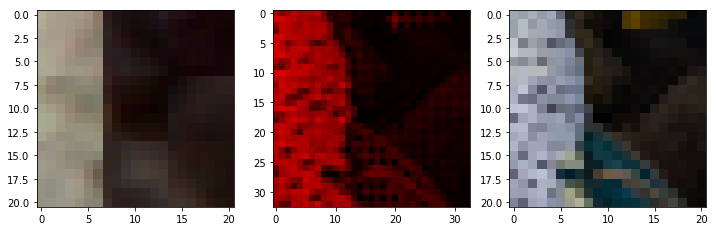

Epoch [40/500], Step [0/25], Loss: 0.020467687398195267
Epoch [40/500], Step [10/25], Loss: 0.021880200132727623
Epoch [40/500], Step [20/25], Loss: 0.021713456138968468

Finished Epoch 40, Loss --- mean: 0.022836834415793417, std 0.0010570936577107067



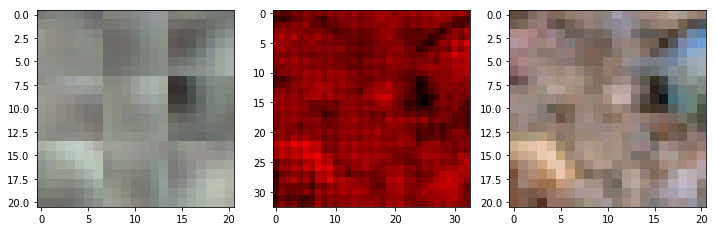

Epoch [41/500], Step [0/25], Loss: 0.022573797032237053
Epoch [41/500], Step [10/25], Loss: 0.02395293302834034
Epoch [41/500], Step [20/25], Loss: 0.022154126316308975

Finished Epoch 41, Loss --- mean: 0.02252831019461155, std 0.0008474023023594597



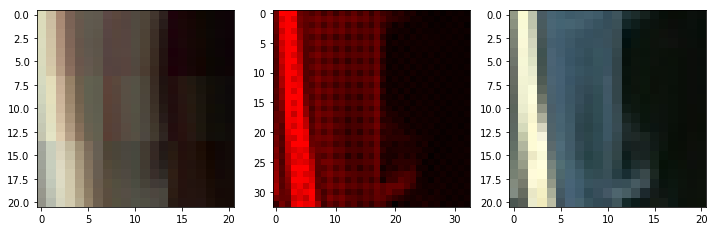

Epoch [42/500], Step [0/25], Loss: 0.022214174270629883
Epoch [42/500], Step [10/25], Loss: 0.02175198122859001
Epoch [42/500], Step [20/25], Loss: 0.02312508597970009

Finished Epoch 42, Loss --- mean: 0.02296189345419407, std 0.0008299831472040697



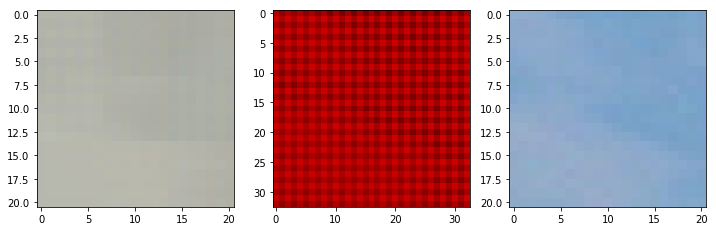

Epoch [43/500], Step [0/25], Loss: 0.021503081545233727
Epoch [43/500], Step [10/25], Loss: 0.023862764239311218
Epoch [43/500], Step [20/25], Loss: 0.02577134221792221

Finished Epoch 43, Loss --- mean: 0.023458543196320535, std 0.0012618877089388553



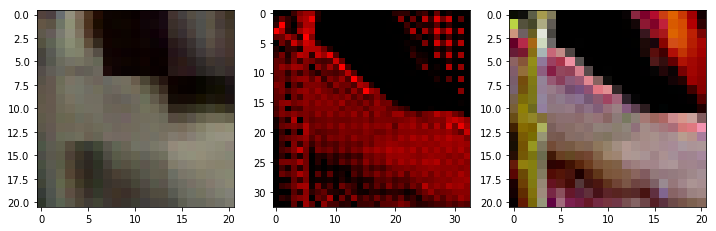

Epoch [44/500], Step [0/25], Loss: 0.023909447714686394
Epoch [44/500], Step [10/25], Loss: 0.023168502375483513
Epoch [44/500], Step [20/25], Loss: 0.023010678589344025

Finished Epoch 44, Loss --- mean: 0.022796771302819253, std 0.0007684016967536553



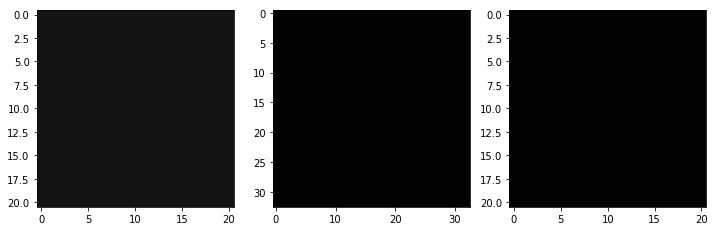

Epoch [45/500], Step [0/25], Loss: 0.022036505863070488
Epoch [45/500], Step [10/25], Loss: 0.024597598239779472
Epoch [45/500], Step [20/25], Loss: 0.023248950019478798

Finished Epoch 45, Loss --- mean: 0.0230939307063818, std 0.0014095441332675452



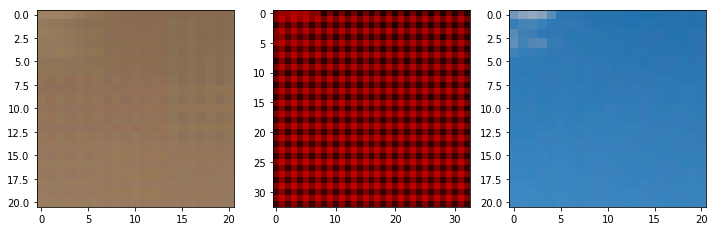

Epoch [46/500], Step [0/25], Loss: 0.022792719304561615
Epoch [46/500], Step [10/25], Loss: 0.0215933658182621
Epoch [46/500], Step [20/25], Loss: 0.02294180355966091

Finished Epoch 46, Loss --- mean: 0.021935118064284324, std 0.0007066858964628231



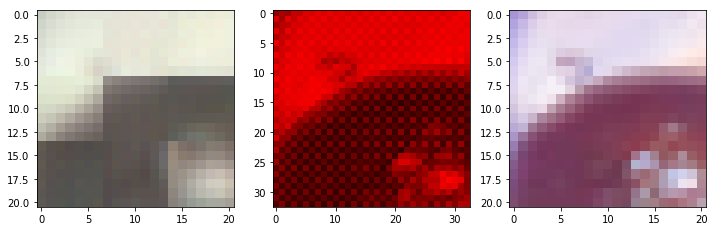

Epoch [47/500], Step [0/25], Loss: 0.020934628322720528
Epoch [47/500], Step [10/25], Loss: 0.02314957231283188
Epoch [47/500], Step [20/25], Loss: 0.022990358993411064

Finished Epoch 47, Loss --- mean: 0.022627659887075425, std 0.000935419026836021



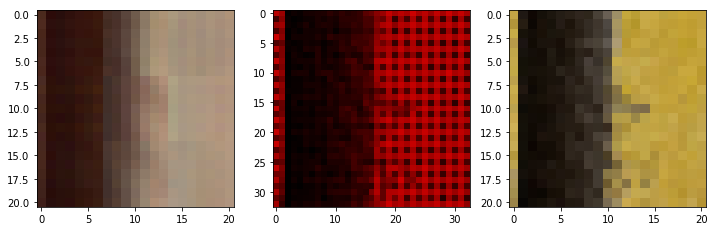

Epoch [48/500], Step [0/25], Loss: 0.02344943769276142
Epoch [48/500], Step [10/25], Loss: 0.022779114544391632
Epoch [48/500], Step [20/25], Loss: 0.024110596626996994

Finished Epoch 48, Loss --- mean: 0.02298360496759415, std 0.00063002186375277



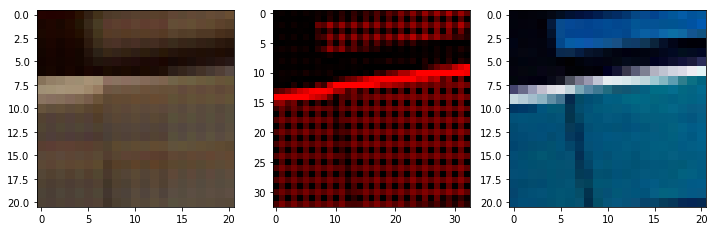

Epoch [49/500], Step [0/25], Loss: 0.021512340754270554
Epoch [49/500], Step [10/25], Loss: 0.022155171260237694
Epoch [49/500], Step [20/25], Loss: 0.023133503273129463

Finished Epoch 49, Loss --- mean: 0.022339570224285125, std 0.0009388862812050843



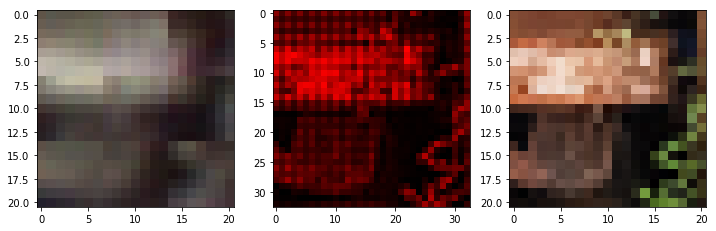

Epoch [50/500], Step [0/25], Loss: 0.023828288540244102
Epoch [50/500], Step [10/25], Loss: 0.021504312753677368
Epoch [50/500], Step [20/25], Loss: 0.022227561101317406

Finished Epoch 50, Loss --- mean: 0.022048972100019455, std 0.0008184580657986732



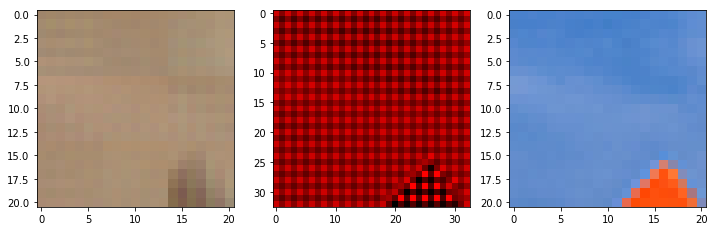

Epoch [51/500], Step [0/25], Loss: 0.021013552322983742
Epoch [51/500], Step [10/25], Loss: 0.022185437381267548
Epoch [51/500], Step [20/25], Loss: 0.021964184939861298


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 51, Loss --- mean: 0.022066814303398134, std 0.0008221070893043243



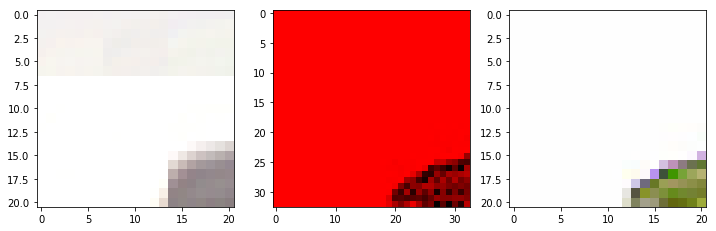

Epoch [52/500], Step [0/25], Loss: 0.021729236468672752
Epoch [52/500], Step [10/25], Loss: 0.0229965653270483
Epoch [52/500], Step [20/25], Loss: 0.02422153204679489

Finished Epoch 52, Loss --- mean: 0.02238877572119236, std 0.0008618562797474044



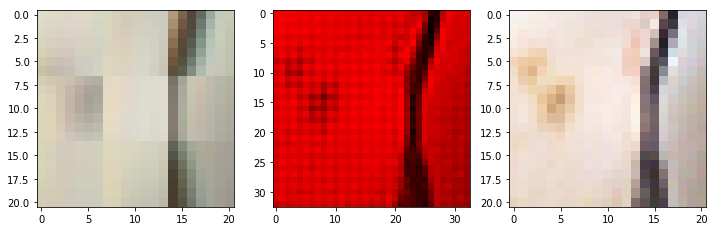

Epoch [53/500], Step [0/25], Loss: 0.02273634634912014
Epoch [53/500], Step [10/25], Loss: 0.025002824142575264
Epoch [53/500], Step [20/25], Loss: 0.022395990788936615

Finished Epoch 53, Loss --- mean: 0.023505884632468225, std 0.0011310686169480892



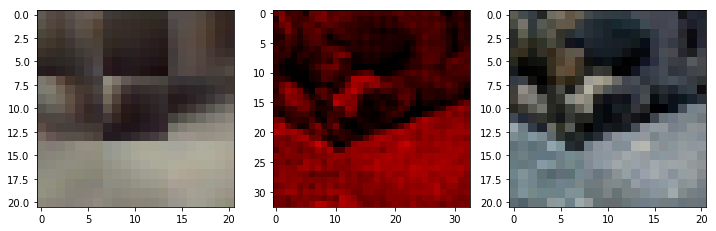

Epoch [54/500], Step [0/25], Loss: 0.022407161071896553
Epoch [54/500], Step [10/25], Loss: 0.023315925151109695
Epoch [54/500], Step [20/25], Loss: 0.02302446775138378

Finished Epoch 54, Loss --- mean: 0.022651642337441446, std 0.0010858478710333824



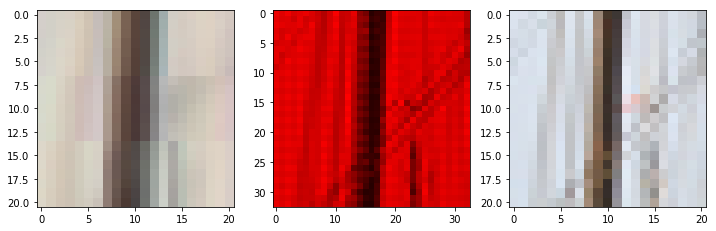

Epoch [55/500], Step [0/25], Loss: 0.021452173590660095
Epoch [55/500], Step [10/25], Loss: 0.021330103278160095
Epoch [55/500], Step [20/25], Loss: 0.021859060972929

Finished Epoch 55, Loss --- mean: 0.021829727739095688, std 0.0008285842376957179



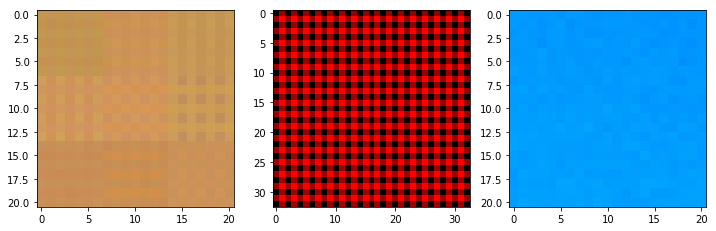

Epoch [56/500], Step [0/25], Loss: 0.022746846079826355
Epoch [56/500], Step [10/25], Loss: 0.022639943286776543
Epoch [56/500], Step [20/25], Loss: 0.02216271683573723

Finished Epoch 56, Loss --- mean: 0.022086612433195114, std 0.0006262635602404787



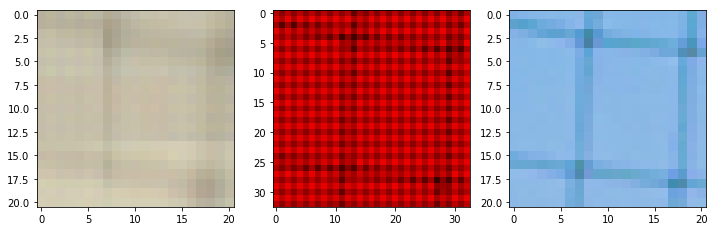

Epoch [57/500], Step [0/25], Loss: 0.020995866507291794
Epoch [57/500], Step [10/25], Loss: 0.021658504381775856
Epoch [57/500], Step [20/25], Loss: 0.02318495139479637

Finished Epoch 57, Loss --- mean: 0.022520949319005012, std 0.0009236905296753228



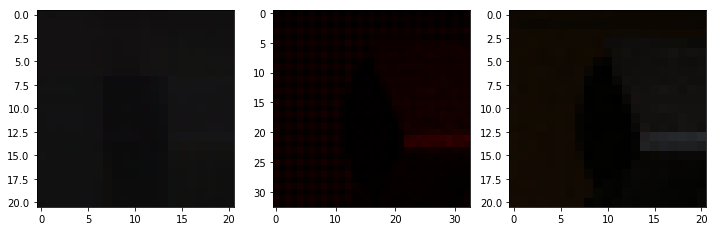

Epoch [58/500], Step [0/25], Loss: 0.02294124662876129
Epoch [58/500], Step [10/25], Loss: 0.02420240081846714
Epoch [58/500], Step [20/25], Loss: 0.023407286033034325

Finished Epoch 58, Loss --- mean: 0.02318284794688225, std 0.0006586631637985693



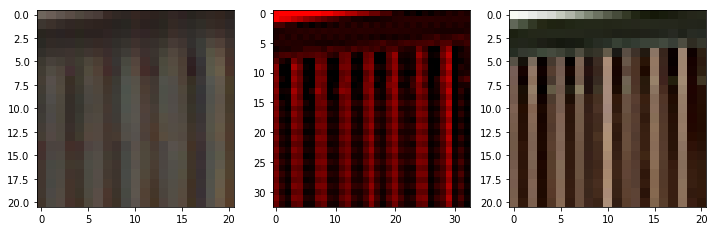

Epoch [59/500], Step [0/25], Loss: 0.022118274122476578
Epoch [59/500], Step [10/25], Loss: 0.02202322520315647
Epoch [59/500], Step [20/25], Loss: 0.02252614125609398

Finished Epoch 59, Loss --- mean: 0.021921408772468568, std 0.0007742336363138387



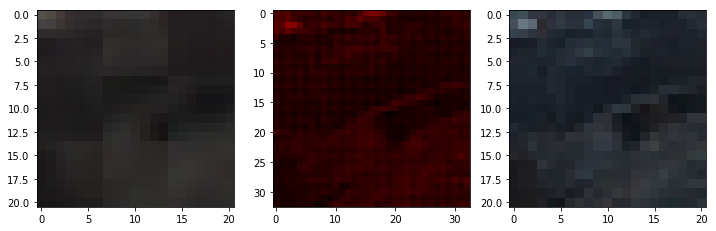

Epoch [60/500], Step [0/25], Loss: 0.022457603365182877
Epoch [60/500], Step [10/25], Loss: 0.021868206560611725
Epoch [60/500], Step [20/25], Loss: 0.024517234414815903

Finished Epoch 60, Loss --- mean: 0.02193176619708538, std 0.0010188152565782504



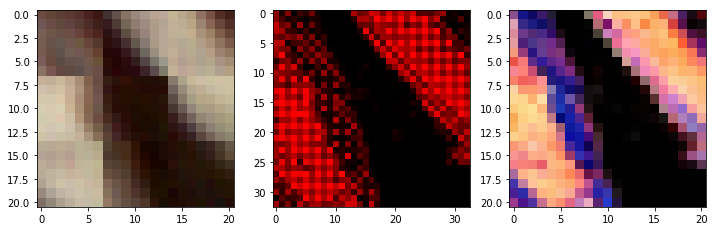

Epoch [61/500], Step [0/25], Loss: 0.022976189851760864
Epoch [61/500], Step [10/25], Loss: 0.0216741431504488
Epoch [61/500], Step [20/25], Loss: 0.022455375641584396

Finished Epoch 61, Loss --- mean: 0.021787850856781005, std 0.0008832815590347581



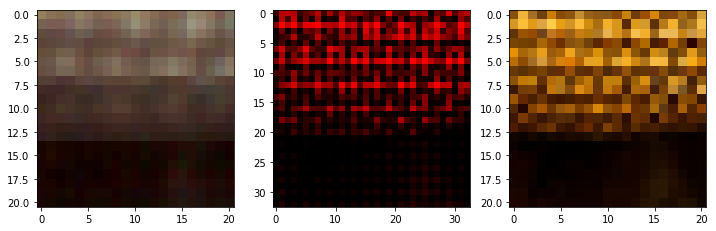

Epoch [62/500], Step [0/25], Loss: 0.023332009091973305
Epoch [62/500], Step [10/25], Loss: 0.02313757874071598
Epoch [62/500], Step [20/25], Loss: 0.0205723587423563

Finished Epoch 62, Loss --- mean: 0.022245905995368957, std 0.0009252762625495044



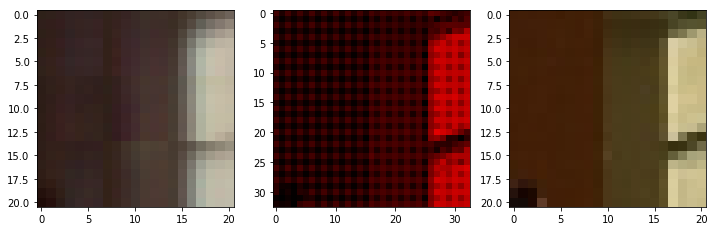

Epoch [63/500], Step [0/25], Loss: 0.022259162738919258
Epoch [63/500], Step [10/25], Loss: 0.022082626819610596
Epoch [63/500], Step [20/25], Loss: 0.021568015217781067

Finished Epoch 63, Loss --- mean: 0.022352224737405776, std 0.00085401615266456



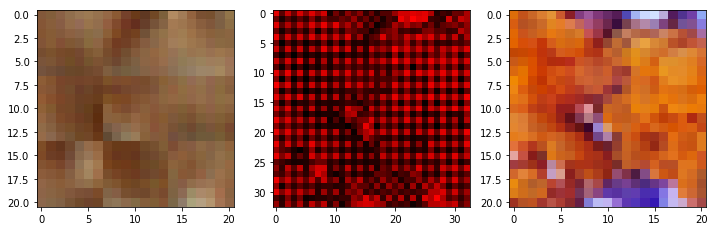

Epoch [64/500], Step [0/25], Loss: 0.022527556866407394
Epoch [64/500], Step [10/25], Loss: 0.021222250536084175
Epoch [64/500], Step [20/25], Loss: 0.022221263498067856

Finished Epoch 64, Loss --- mean: 0.021948277801275253, std 0.000876424620270722



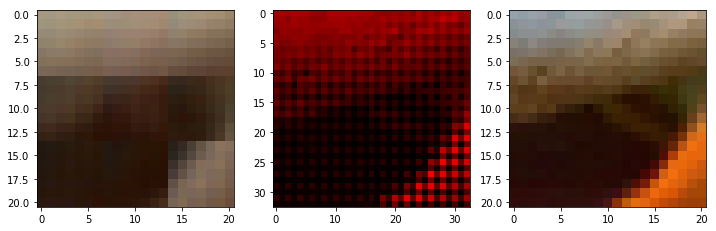

Epoch [65/500], Step [0/25], Loss: 0.021563610062003136
Epoch [65/500], Step [10/25], Loss: 0.02151058427989483
Epoch [65/500], Step [20/25], Loss: 0.021930746734142303

Finished Epoch 65, Loss --- mean: 0.021672172993421553, std 0.00079636833339768



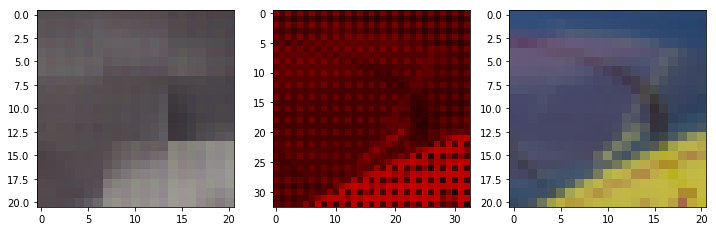

Epoch [66/500], Step [0/25], Loss: 0.02096610702574253
Epoch [66/500], Step [10/25], Loss: 0.020941752940416336
Epoch [66/500], Step [20/25], Loss: 0.021744906902313232

Finished Epoch 66, Loss --- mean: 0.021296112090349196, std 0.0009301105200974139



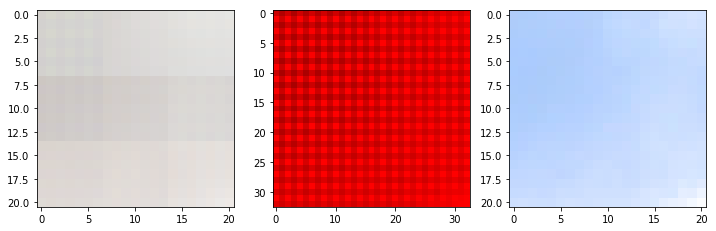

Epoch [67/500], Step [0/25], Loss: 0.020908217877149582
Epoch [67/500], Step [10/25], Loss: 0.02144218236207962
Epoch [67/500], Step [20/25], Loss: 0.02127792499959469

Finished Epoch 67, Loss --- mean: 0.021665456369519234, std 0.001188411058981083



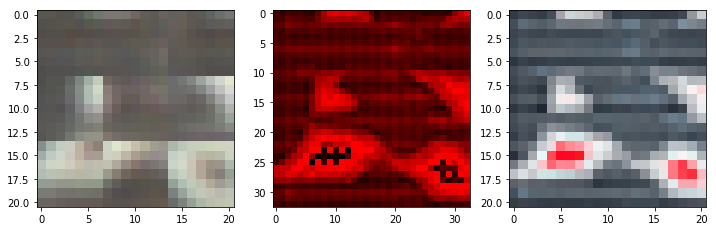

Epoch [68/500], Step [0/25], Loss: 0.021268943324685097
Epoch [68/500], Step [10/25], Loss: 0.021771112456917763
Epoch [68/500], Step [20/25], Loss: 0.021661393344402313

Finished Epoch 68, Loss --- mean: 0.021690872386097907, std 0.0008531294039812321



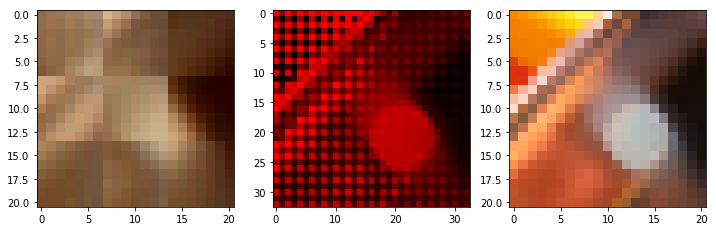

Epoch [69/500], Step [0/25], Loss: 0.02292974479496479
Epoch [69/500], Step [10/25], Loss: 0.021567650139331818
Epoch [69/500], Step [20/25], Loss: 0.02243894897401333

Finished Epoch 69, Loss --- mean: 0.022995126247406007, std 0.0009831638258975487



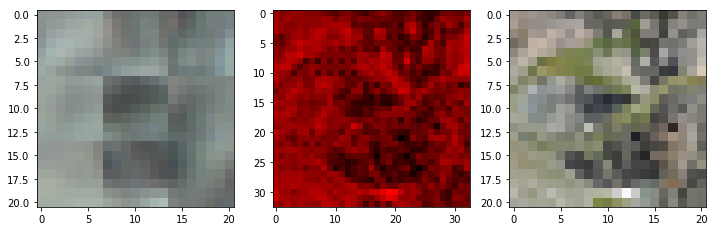

Epoch [70/500], Step [0/25], Loss: 0.02078172378242016
Epoch [70/500], Step [10/25], Loss: 0.02152237482368946
Epoch [70/500], Step [20/25], Loss: 0.023470597341656685

Finished Epoch 70, Loss --- mean: 0.02192598968744278, std 0.001128889691201201



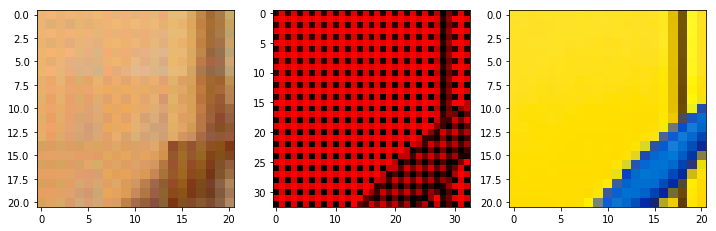

Epoch [71/500], Step [0/25], Loss: 0.021092304959893227
Epoch [71/500], Step [10/25], Loss: 0.023017004132270813
Epoch [71/500], Step [20/25], Loss: 0.021315911784768105

Finished Epoch 71, Loss --- mean: 0.021669330522418023, std 0.0008474601133625912



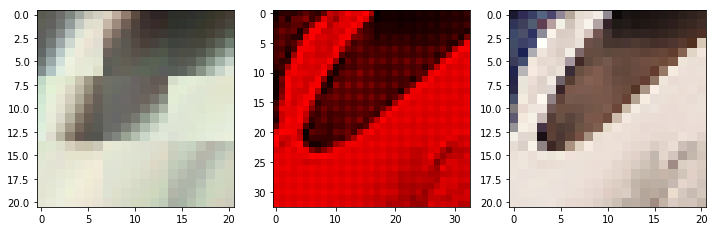

Epoch [72/500], Step [0/25], Loss: 0.021762695163488388
Epoch [72/500], Step [10/25], Loss: 0.023351537063717842
Epoch [72/500], Step [20/25], Loss: 0.02316044643521309

Finished Epoch 72, Loss --- mean: 0.021885770931839944, std 0.0008817404256252242



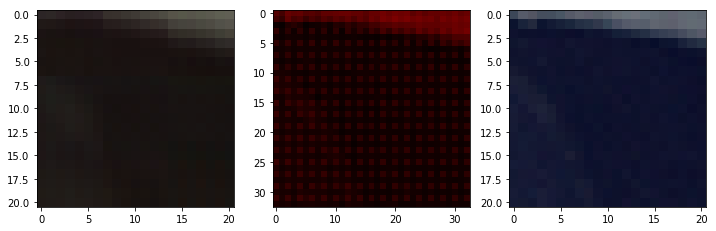

Epoch [73/500], Step [0/25], Loss: 0.020215244963765144
Epoch [73/500], Step [10/25], Loss: 0.0229639932513237
Epoch [73/500], Step [20/25], Loss: 0.021871626377105713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 73, Loss --- mean: 0.02201255418360233, std 0.001049195830015524



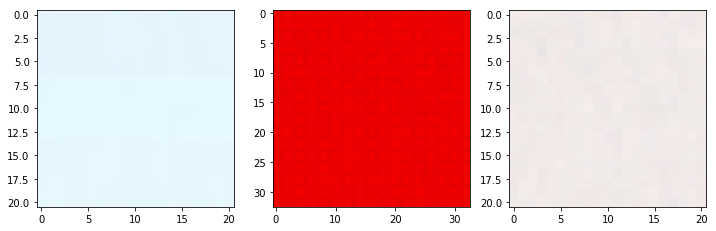

Epoch [74/500], Step [0/25], Loss: 0.023053405806422234
Epoch [74/500], Step [10/25], Loss: 0.021545888856053352
Epoch [74/500], Step [20/25], Loss: 0.021049661561846733

Finished Epoch 74, Loss --- mean: 0.021472560316324232, std 0.0009390605979605783



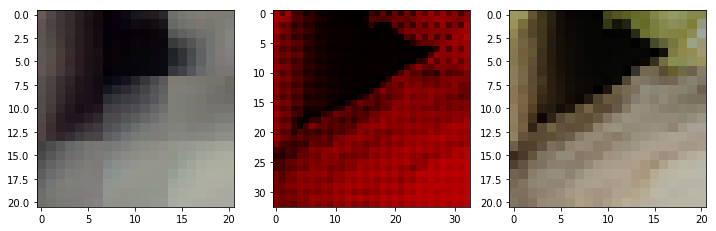

Epoch [75/500], Step [0/25], Loss: 0.02112570032477379
Epoch [75/500], Step [10/25], Loss: 0.02226688340306282
Epoch [75/500], Step [20/25], Loss: 0.021149732172489166

Finished Epoch 75, Loss --- mean: 0.02180259898304939, std 0.000859729851074592



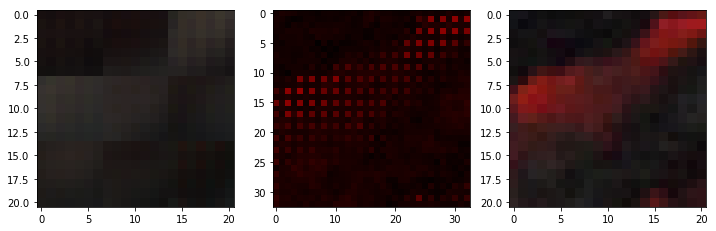

Epoch [76/500], Step [0/25], Loss: 0.022296948358416557
Epoch [76/500], Step [10/25], Loss: 0.02099834941327572
Epoch [76/500], Step [20/25], Loss: 0.021078627556562424

Finished Epoch 76, Loss --- mean: 0.021116586104035377, std 0.0007881423981783206



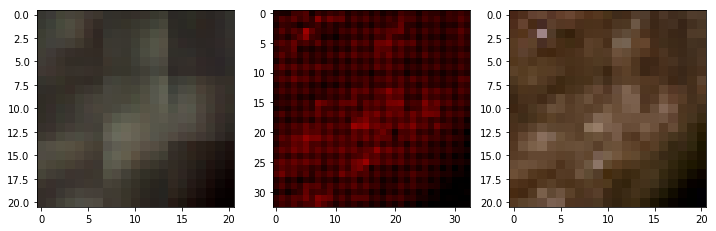

Epoch [77/500], Step [0/25], Loss: 0.021273542195558548
Epoch [77/500], Step [10/25], Loss: 0.021133797243237495
Epoch [77/500], Step [20/25], Loss: 0.02142787165939808

Finished Epoch 77, Loss --- mean: 0.02168883018195629, std 0.0013490026018371138



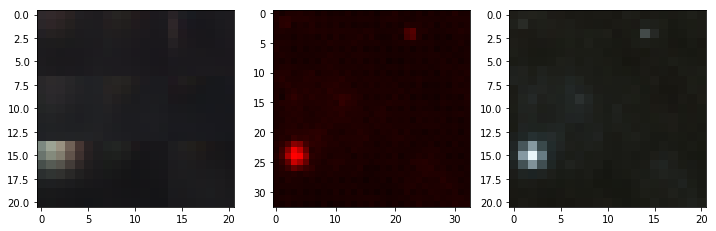

Epoch [78/500], Step [0/25], Loss: 0.02267107367515564
Epoch [78/500], Step [10/25], Loss: 0.02290273644030094
Epoch [78/500], Step [20/25], Loss: 0.023238640278577805

Finished Epoch 78, Loss --- mean: 0.022599315121769905, std 0.0008263418962025298



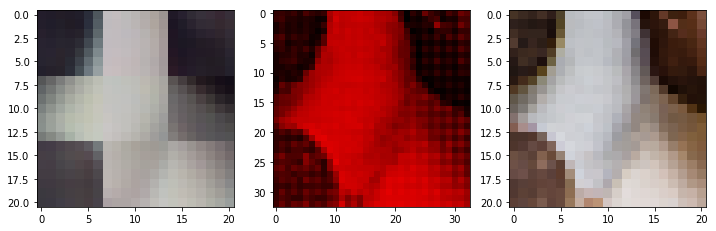

Epoch [79/500], Step [0/25], Loss: 0.021972399204969406
Epoch [79/500], Step [10/25], Loss: 0.022072192281484604
Epoch [79/500], Step [20/25], Loss: 0.02179686352610588

Finished Epoch 79, Loss --- mean: 0.02148192182183266, std 0.0006650565412815232



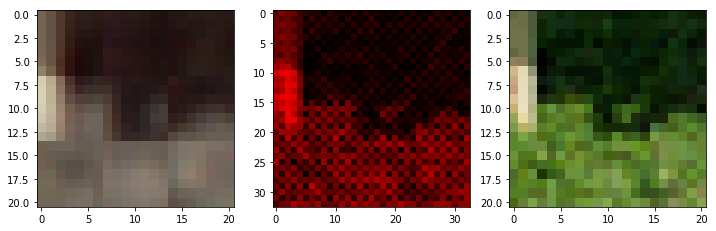

Epoch [80/500], Step [0/25], Loss: 0.023048443719744682
Epoch [80/500], Step [10/25], Loss: 0.022489340975880623
Epoch [80/500], Step [20/25], Loss: 0.02214479260146618

Finished Epoch 80, Loss --- mean: 0.022064413353800775, std 0.0008527567064270386



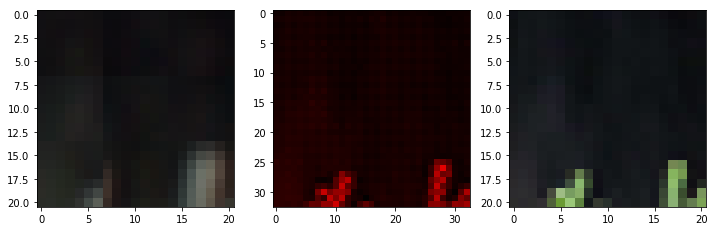

Epoch [81/500], Step [0/25], Loss: 0.02084996923804283
Epoch [81/500], Step [10/25], Loss: 0.02142202854156494
Epoch [81/500], Step [20/25], Loss: 0.022511735558509827

Finished Epoch 81, Loss --- mean: 0.021723380610346794, std 0.0008959778251066909



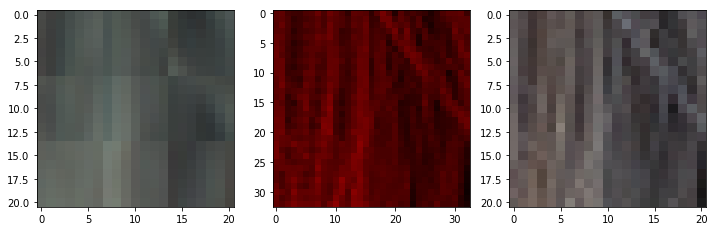

Epoch [82/500], Step [0/25], Loss: 0.021151963621377945
Epoch [82/500], Step [10/25], Loss: 0.02371569164097309
Epoch [82/500], Step [20/25], Loss: 0.02383122779428959

Finished Epoch 82, Loss --- mean: 0.021728639379143714, std 0.000964132301100007



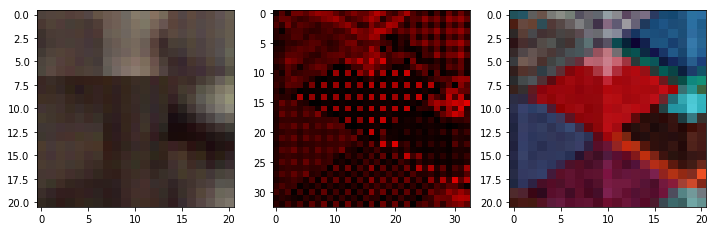

Epoch [83/500], Step [0/25], Loss: 0.02072860859334469
Epoch [83/500], Step [10/25], Loss: 0.021607711911201477
Epoch [83/500], Step [20/25], Loss: 0.021344831213355064

Finished Epoch 83, Loss --- mean: 0.02150144539773464, std 0.001192653239153653



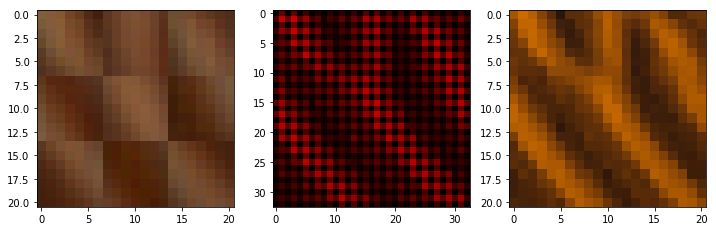

Epoch [84/500], Step [0/25], Loss: 0.02368881367146969
Epoch [84/500], Step [10/25], Loss: 0.021298523992300034
Epoch [84/500], Step [20/25], Loss: 0.019858118146657944

Finished Epoch 84, Loss --- mean: 0.02154855266213417, std 0.0008570915700038534



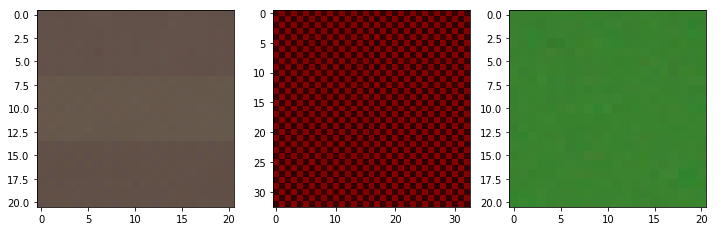

Epoch [85/500], Step [0/25], Loss: 0.022487036883831024
Epoch [85/500], Step [10/25], Loss: 0.020850205793976784
Epoch [85/500], Step [20/25], Loss: 0.02099739946424961

Finished Epoch 85, Loss --- mean: 0.021615316420793534, std 0.0009712952476652695



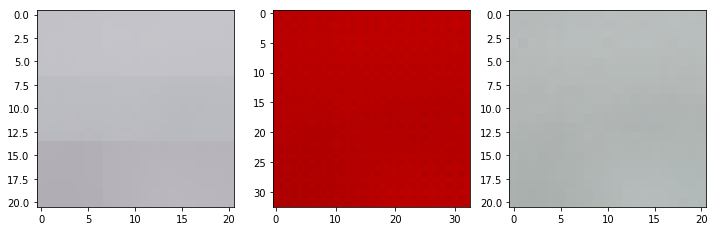

Epoch [86/500], Step [0/25], Loss: 0.021628834307193756
Epoch [86/500], Step [10/25], Loss: 0.021950988098978996
Epoch [86/500], Step [20/25], Loss: 0.021468957886099815

Finished Epoch 86, Loss --- mean: 0.021556051447987556, std 0.0006466917894569685



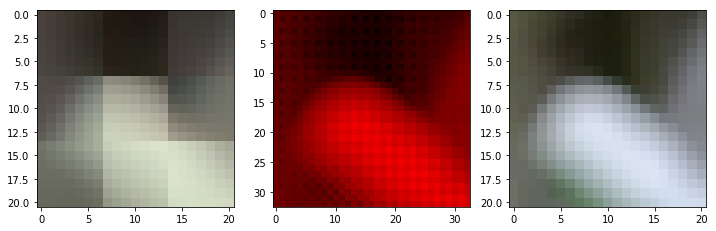

Epoch [87/500], Step [0/25], Loss: 0.021554596722126007
Epoch [87/500], Step [10/25], Loss: 0.021599795669317245
Epoch [87/500], Step [20/25], Loss: 0.020146433264017105

Finished Epoch 87, Loss --- mean: 0.021759017556905746, std 0.0008564079299966134



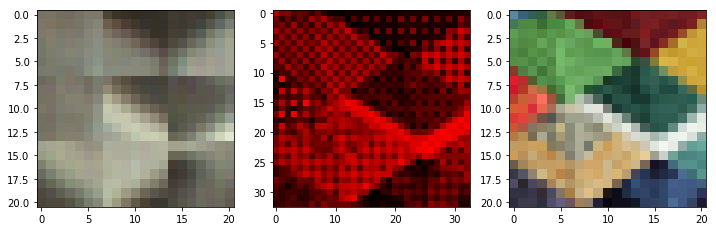

Epoch [88/500], Step [0/25], Loss: 0.021394584327936172
Epoch [88/500], Step [10/25], Loss: 0.02131791040301323
Epoch [88/500], Step [20/25], Loss: 0.021239634603261948

Finished Epoch 88, Loss --- mean: 0.021921519488096237, std 0.0009194096153725533



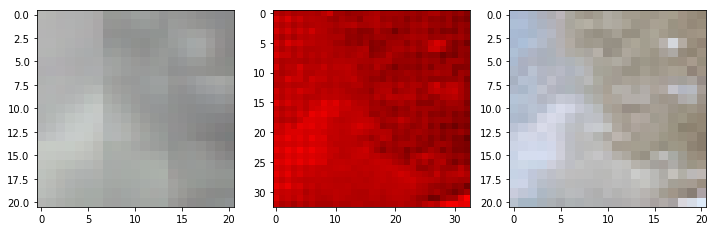

Epoch [89/500], Step [0/25], Loss: 0.02159689925611019
Epoch [89/500], Step [10/25], Loss: 0.02092806249856949
Epoch [89/500], Step [20/25], Loss: 0.02172613888978958

Finished Epoch 89, Loss --- mean: 0.021644693985581397, std 0.0005782810193505419



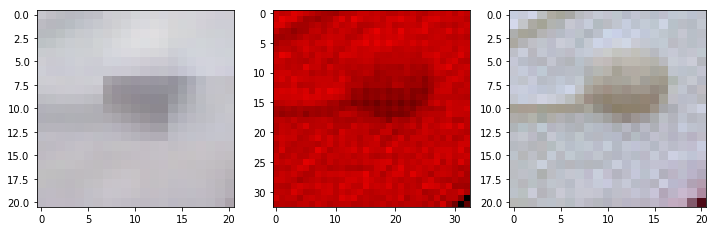

Epoch [90/500], Step [0/25], Loss: 0.02123081497848034
Epoch [90/500], Step [10/25], Loss: 0.021760916337370872
Epoch [90/500], Step [20/25], Loss: 0.02218412049114704

Finished Epoch 90, Loss --- mean: 0.021286535412073135, std 0.0009243262327056134



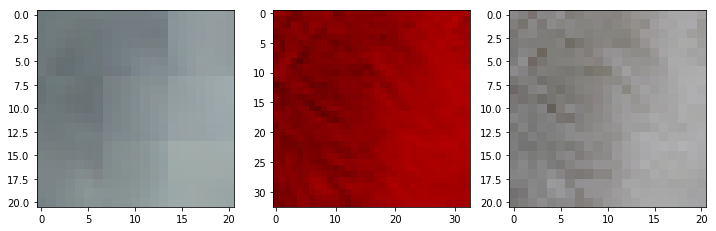

Epoch [91/500], Step [0/25], Loss: 0.022550072520971298
Epoch [91/500], Step [10/25], Loss: 0.020196672528982162
Epoch [91/500], Step [20/25], Loss: 0.022212257608771324

Finished Epoch 91, Loss --- mean: 0.02146565489470959, std 0.0008681656809513



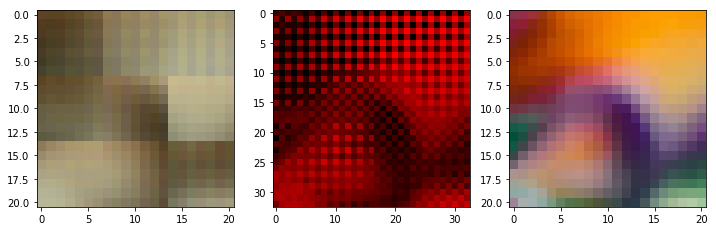

Epoch [92/500], Step [0/25], Loss: 0.021530915051698685
Epoch [92/500], Step [10/25], Loss: 0.021087845787405968
Epoch [92/500], Step [20/25], Loss: 0.020356226712465286

Finished Epoch 92, Loss --- mean: 0.021305536627769472, std 0.0010092143931305858



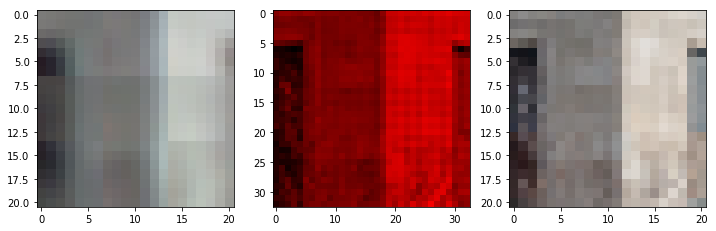

Epoch [93/500], Step [0/25], Loss: 0.020588790997862816
Epoch [93/500], Step [10/25], Loss: 0.022442447021603584
Epoch [93/500], Step [20/25], Loss: 0.020968222990632057

Finished Epoch 93, Loss --- mean: 0.02133048988878727, std 0.0009748594652187312



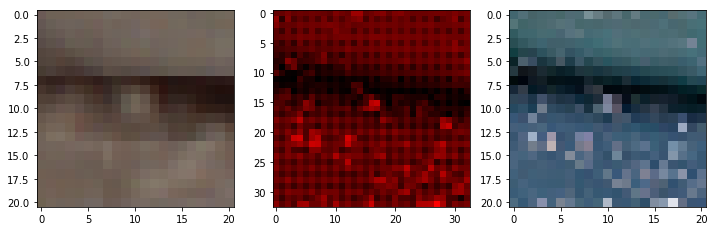

Epoch [94/500], Step [0/25], Loss: 0.022780682891607285
Epoch [94/500], Step [10/25], Loss: 0.020391378551721573
Epoch [94/500], Step [20/25], Loss: 0.020590854808688164

Finished Epoch 94, Loss --- mean: 0.021232372373342513, std 0.0009279328194288114



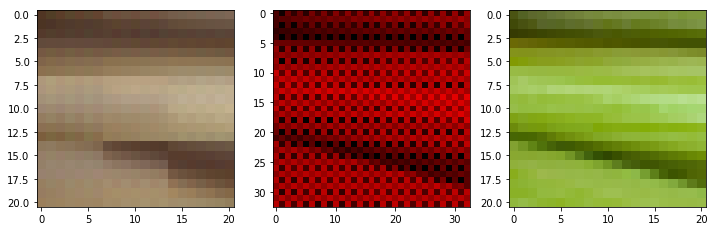

Epoch [95/500], Step [0/25], Loss: 0.0238750372081995
Epoch [95/500], Step [10/25], Loss: 0.022049903869628906
Epoch [95/500], Step [20/25], Loss: 0.021060150116682053

Finished Epoch 95, Loss --- mean: 0.021668621823191642, std 0.0008786246624390432



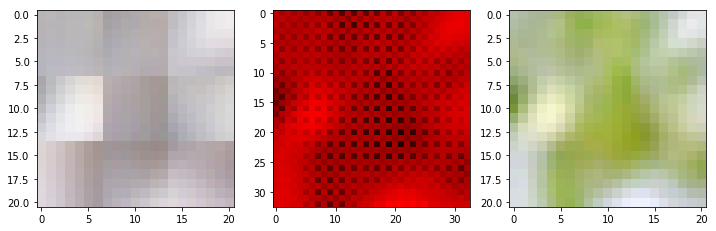

Epoch [96/500], Step [0/25], Loss: 0.022969761863350868
Epoch [96/500], Step [10/25], Loss: 0.022137781605124474
Epoch [96/500], Step [20/25], Loss: 0.02101510390639305

Finished Epoch 96, Loss --- mean: 0.021711757853627205, std 0.0007716388883171672



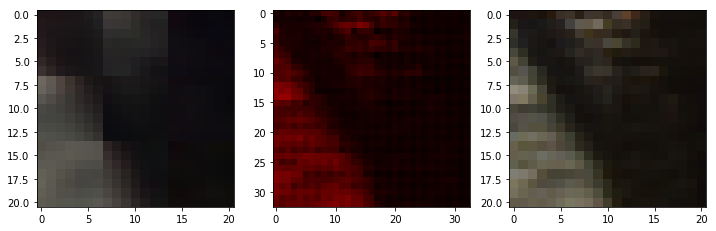

Epoch [97/500], Step [0/25], Loss: 0.02154994010925293
Epoch [97/500], Step [10/25], Loss: 0.020776262506842613
Epoch [97/500], Step [20/25], Loss: 0.021353689953684807

Finished Epoch 97, Loss --- mean: 0.021672200039029123, std 0.0010064691514657426



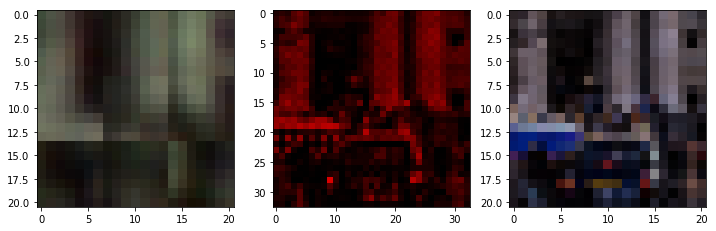

Epoch [98/500], Step [0/25], Loss: 0.02118249423801899
Epoch [98/500], Step [10/25], Loss: 0.02074342779815197
Epoch [98/500], Step [20/25], Loss: 0.022351641207933426

Finished Epoch 98, Loss --- mean: 0.021094584986567497, std 0.0008930158662568212



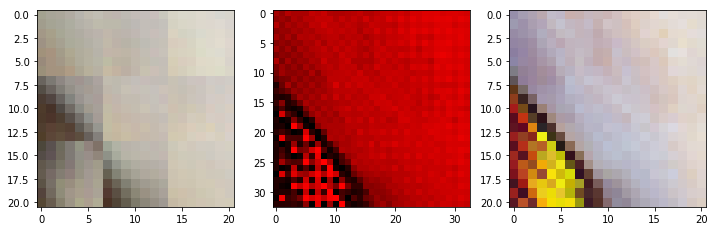

Epoch [99/500], Step [0/25], Loss: 0.020760709419846535
Epoch [99/500], Step [10/25], Loss: 0.01997320167720318
Epoch [99/500], Step [20/25], Loss: 0.02091403864324093

Finished Epoch 99, Loss --- mean: 0.021024065762758254, std 0.000701219720320357



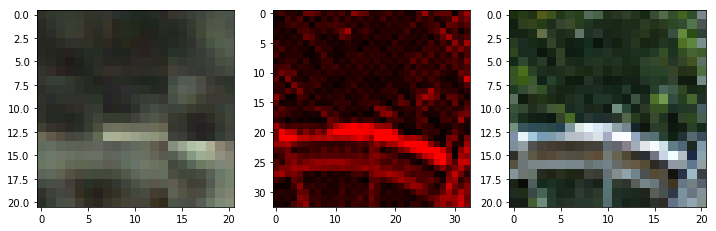

Epoch [100/500], Step [0/25], Loss: 0.022291237488389015
Epoch [100/500], Step [10/25], Loss: 0.021081937476992607
Epoch [100/500], Step [20/25], Loss: 0.02101065032184124

Finished Epoch 100, Loss --- mean: 0.021270837411284448, std 0.0007876103707793416



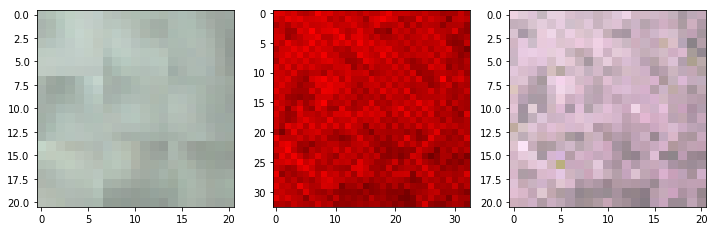

Epoch [101/500], Step [0/25], Loss: 0.021891633048653603
Epoch [101/500], Step [10/25], Loss: 0.021819541230797768
Epoch [101/500], Step [20/25], Loss: 0.02237326093018055

Finished Epoch 101, Loss --- mean: 0.02181644529104233, std 0.0007809932671751763



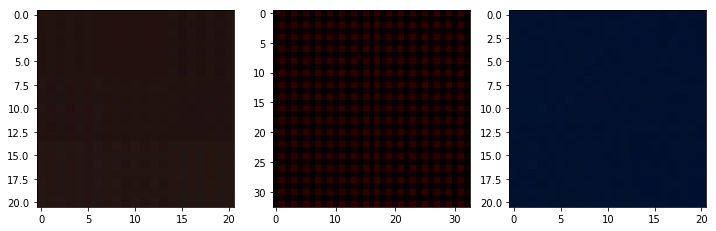

Epoch [102/500], Step [0/25], Loss: 0.022112127393484116
Epoch [102/500], Step [10/25], Loss: 0.02194693125784397
Epoch [102/500], Step [20/25], Loss: 0.021191507577896118

Finished Epoch 102, Loss --- mean: 0.021594256237149237, std 0.0008916321036636683



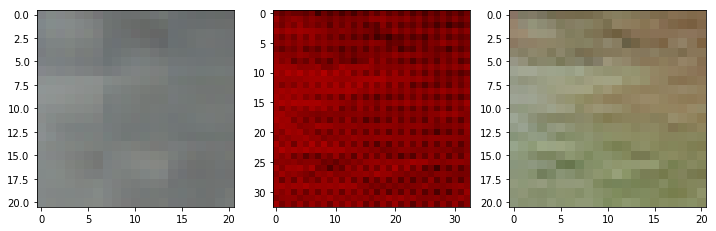

Epoch [103/500], Step [0/25], Loss: 0.021499428898096085
Epoch [103/500], Step [10/25], Loss: 0.021196968853473663
Epoch [103/500], Step [20/25], Loss: 0.021651852875947952

Finished Epoch 103, Loss --- mean: 0.020895590856671333, std 0.0008568060358906727



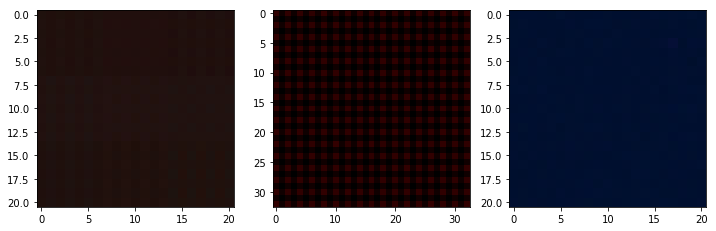

Epoch [104/500], Step [0/25], Loss: 0.02126026712357998
Epoch [104/500], Step [10/25], Loss: 0.020402371883392334
Epoch [104/500], Step [20/25], Loss: 0.02103632315993309

Finished Epoch 104, Loss --- mean: 0.020882927253842352, std 0.0008974302363146424



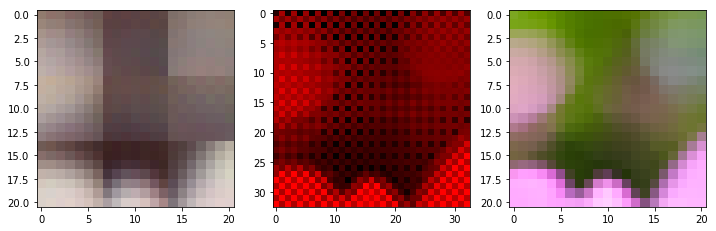

Epoch [105/500], Step [0/25], Loss: 0.02244877815246582
Epoch [105/500], Step [10/25], Loss: 0.022017017006874084
Epoch [105/500], Step [20/25], Loss: 0.020257320255041122

Finished Epoch 105, Loss --- mean: 0.021101485639810562, std 0.0008544643484626386



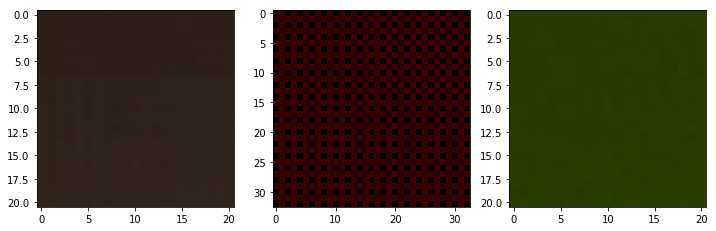

Epoch [106/500], Step [0/25], Loss: 0.022143980488181114
Epoch [106/500], Step [10/25], Loss: 0.021703992038965225
Epoch [106/500], Step [20/25], Loss: 0.022543054074048996

Finished Epoch 106, Loss --- mean: 0.021935534700751304, std 0.0008345529096205567



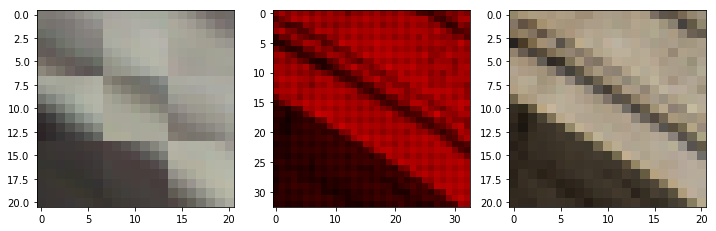

Epoch [107/500], Step [0/25], Loss: 0.023096274584531784
Epoch [107/500], Step [10/25], Loss: 0.023337900638580322
Epoch [107/500], Step [20/25], Loss: 0.021381869912147522

Finished Epoch 107, Loss --- mean: 0.021502365320920945, std 0.001090327169682116



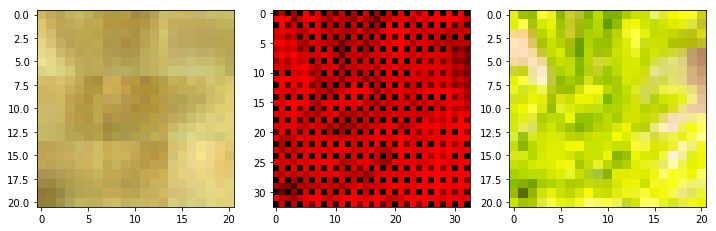

Epoch [108/500], Step [0/25], Loss: 0.023544317111372948
Epoch [108/500], Step [10/25], Loss: 0.020075108855962753
Epoch [108/500], Step [20/25], Loss: 0.02100396156311035

Finished Epoch 108, Loss --- mean: 0.021656695902347565, std 0.0010448154942603596



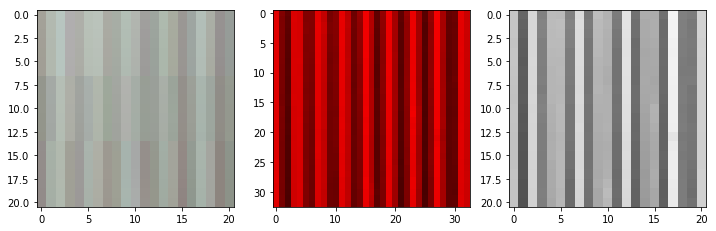

Epoch [109/500], Step [0/25], Loss: 0.02035338617861271
Epoch [109/500], Step [10/25], Loss: 0.02276415005326271
Epoch [109/500], Step [20/25], Loss: 0.020570585504174232

Finished Epoch 109, Loss --- mean: 0.021373648121953012, std 0.0008628190272265985



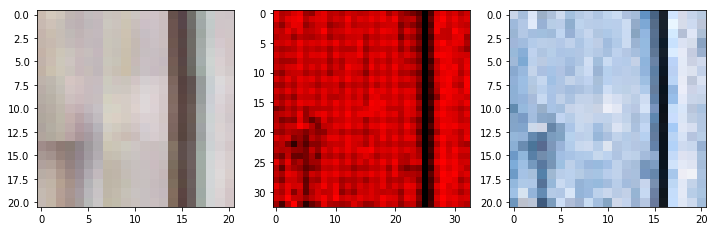

Epoch [110/500], Step [0/25], Loss: 0.021363545209169388
Epoch [110/500], Step [10/25], Loss: 0.02088581956923008
Epoch [110/500], Step [20/25], Loss: 0.021909251809120178

Finished Epoch 110, Loss --- mean: 0.021118111312389373, std 0.0007849986040141593



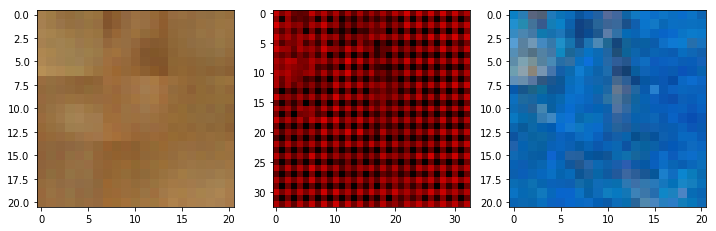

Epoch [111/500], Step [0/25], Loss: 0.020683826878666878
Epoch [111/500], Step [10/25], Loss: 0.02226521074771881
Epoch [111/500], Step [20/25], Loss: 0.02223370410501957

Finished Epoch 111, Loss --- mean: 0.021026672050356864, std 0.0010248172246360905



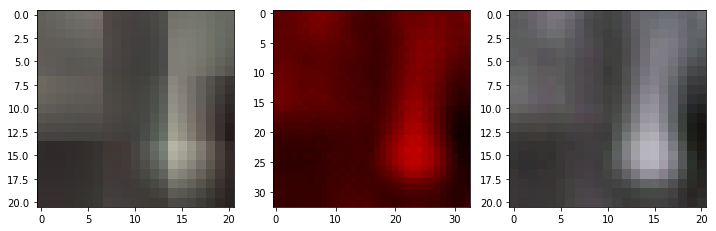

Epoch [112/500], Step [0/25], Loss: 0.02123575285077095
Epoch [112/500], Step [10/25], Loss: 0.021135374903678894
Epoch [112/500], Step [20/25], Loss: 0.02110741101205349

Finished Epoch 112, Loss --- mean: 0.020785455629229545, std 0.0008969844237502514



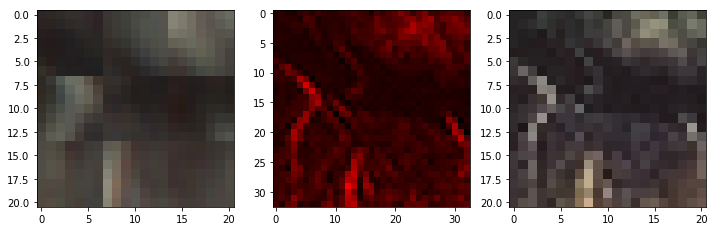

Epoch [113/500], Step [0/25], Loss: 0.019926808774471283
Epoch [113/500], Step [10/25], Loss: 0.020899875089526176
Epoch [113/500], Step [20/25], Loss: 0.02153978869318962

Finished Epoch 113, Loss --- mean: 0.021100779697299003, std 0.0006183936566228093



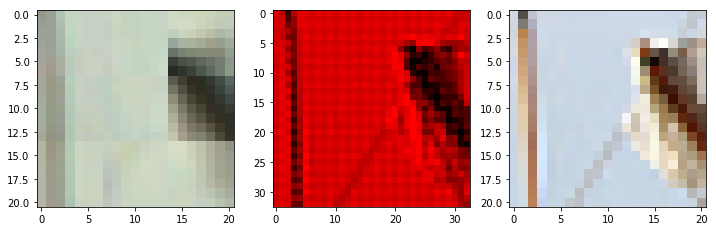

Epoch [114/500], Step [0/25], Loss: 0.023147521540522575
Epoch [114/500], Step [10/25], Loss: 0.02186586707830429
Epoch [114/500], Step [20/25], Loss: 0.021189089864492416

Finished Epoch 114, Loss --- mean: 0.021381305158138277, std 0.0009047253529916044



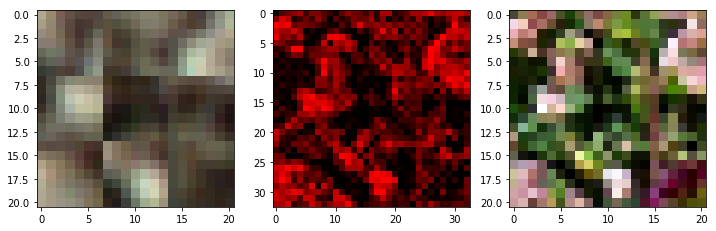

Epoch [115/500], Step [0/25], Loss: 0.02039855718612671
Epoch [115/500], Step [10/25], Loss: 0.021578608080744743
Epoch [115/500], Step [20/25], Loss: 0.021083148196339607

Finished Epoch 115, Loss --- mean: 0.020913154631853104, std 0.0009483894165363103



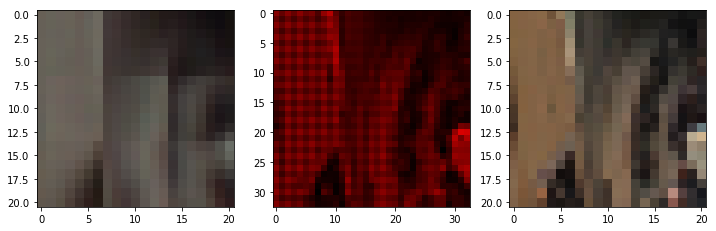

Epoch [116/500], Step [0/25], Loss: 0.02009560540318489
Epoch [116/500], Step [10/25], Loss: 0.02074342966079712
Epoch [116/500], Step [20/25], Loss: 0.02159941755235195

Finished Epoch 116, Loss --- mean: 0.020961828976869584, std 0.0009433198746050077



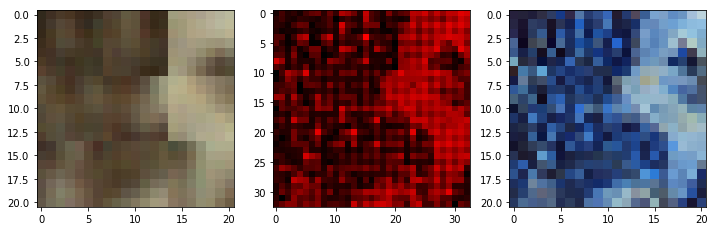

Epoch [117/500], Step [0/25], Loss: 0.021202271804213524
Epoch [117/500], Step [10/25], Loss: 0.020848676562309265
Epoch [117/500], Step [20/25], Loss: 0.020719800144433975

Finished Epoch 117, Loss --- mean: 0.020847612023353577, std 0.0008034539023244985



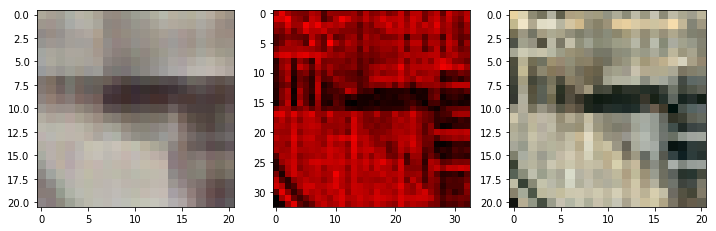

Epoch [118/500], Step [0/25], Loss: 0.023544244468212128
Epoch [118/500], Step [10/25], Loss: 0.020674007013440132
Epoch [118/500], Step [20/25], Loss: 0.02116965688765049

Finished Epoch 118, Loss --- mean: 0.021416216120123864, std 0.0010137216287617568



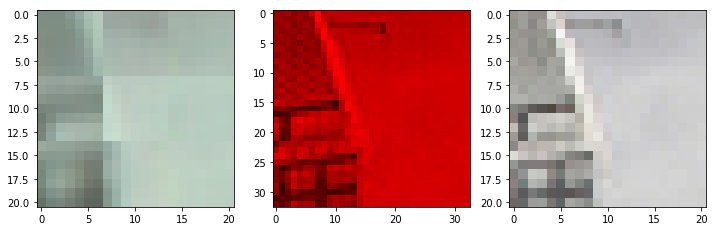

Epoch [119/500], Step [0/25], Loss: 0.02125665545463562
Epoch [119/500], Step [10/25], Loss: 0.020203175023198128
Epoch [119/500], Step [20/25], Loss: 0.02152608335018158

Finished Epoch 119, Loss --- mean: 0.021048412546515464, std 0.0008157529261477119



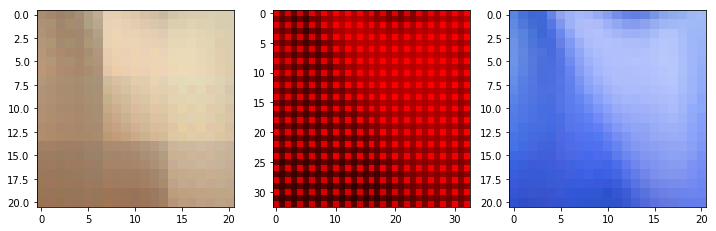

Epoch [120/500], Step [0/25], Loss: 0.020140215754508972
Epoch [120/500], Step [10/25], Loss: 0.022413773462176323
Epoch [120/500], Step [20/25], Loss: 0.01932627707719803

Finished Epoch 120, Loss --- mean: 0.021399717405438425, std 0.0010591190561941802



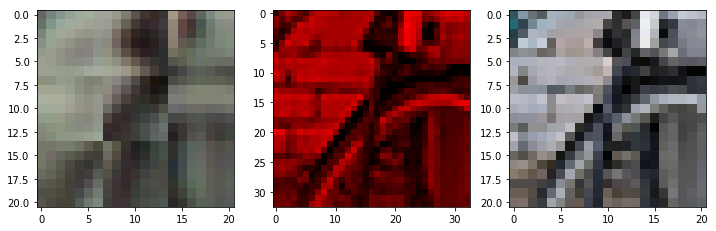

Epoch [121/500], Step [0/25], Loss: 0.02172042988240719
Epoch [121/500], Step [10/25], Loss: 0.02038249932229519
Epoch [121/500], Step [20/25], Loss: 0.023521440103650093

Finished Epoch 121, Loss --- mean: 0.021396835446357728, std 0.000770876546545356



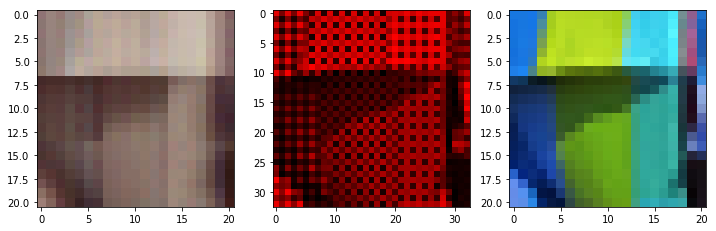

Epoch [122/500], Step [0/25], Loss: 0.019863195717334747
Epoch [122/500], Step [10/25], Loss: 0.02062440849840641
Epoch [122/500], Step [20/25], Loss: 0.021082395687699318

Finished Epoch 122, Loss --- mean: 0.020996497943997383, std 0.0007613398955571307



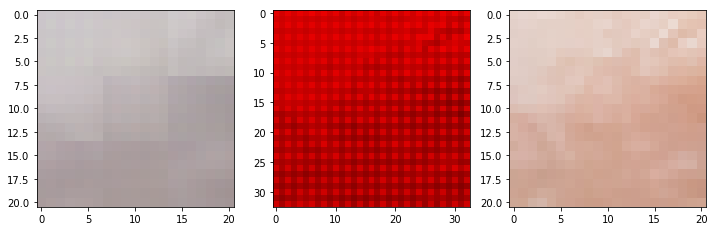

Epoch [123/500], Step [0/25], Loss: 0.02089770697057247
Epoch [123/500], Step [10/25], Loss: 0.022434154525399208
Epoch [123/500], Step [20/25], Loss: 0.02043040283024311

Finished Epoch 123, Loss --- mean: 0.020701956674456595, std 0.0009480404928182014



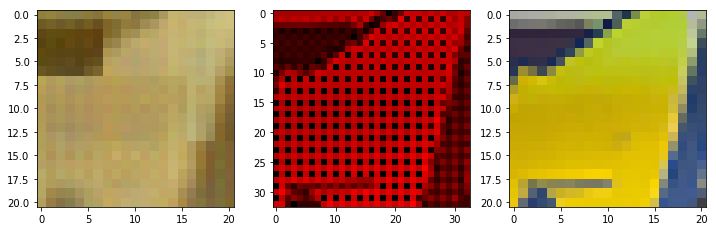

Epoch [124/500], Step [0/25], Loss: 0.020000262185931206
Epoch [124/500], Step [10/25], Loss: 0.022445006296038628
Epoch [124/500], Step [20/25], Loss: 0.021332181990146637

Finished Epoch 124, Loss --- mean: 0.02090668722987175, std 0.0008157663224420627



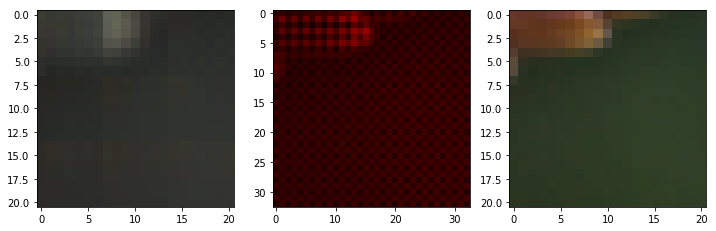

Epoch [125/500], Step [0/25], Loss: 0.02031347155570984
Epoch [125/500], Step [10/25], Loss: 0.021345822140574455
Epoch [125/500], Step [20/25], Loss: 0.02098357118666172

Finished Epoch 125, Loss --- mean: 0.020850341096520425, std 0.0008797372890206326



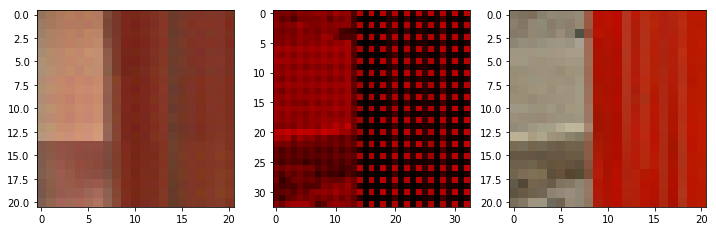

Epoch [126/500], Step [0/25], Loss: 0.021854232996702194
Epoch [126/500], Step [10/25], Loss: 0.020383445546030998
Epoch [126/500], Step [20/25], Loss: 0.021594107151031494

Finished Epoch 126, Loss --- mean: 0.021433540731668473, std 0.0010178181488280423



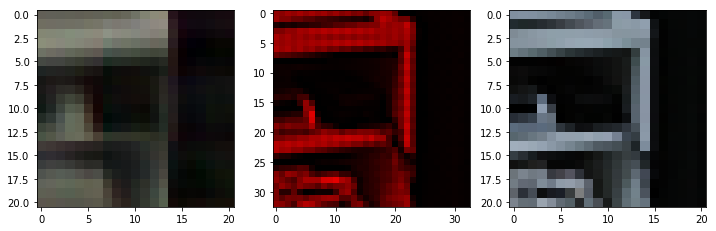

Epoch [127/500], Step [0/25], Loss: 0.02210170589387417
Epoch [127/500], Step [10/25], Loss: 0.019786136224865913
Epoch [127/500], Step [20/25], Loss: 0.019905339926481247

Finished Epoch 127, Loss --- mean: 0.021012600511312485, std 0.0007463751285077473



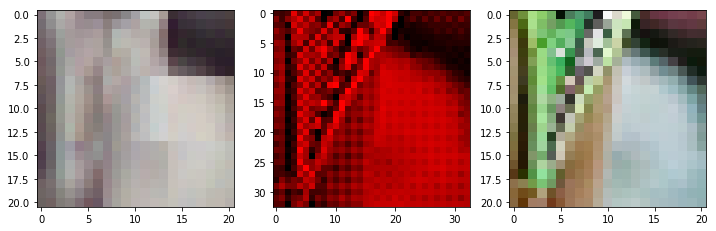

Epoch [128/500], Step [0/25], Loss: 0.020768579095602036
Epoch [128/500], Step [10/25], Loss: 0.020138613879680634
Epoch [128/500], Step [20/25], Loss: 0.02092994935810566

Finished Epoch 128, Loss --- mean: 0.020822115391492844, std 0.0008773669578250329



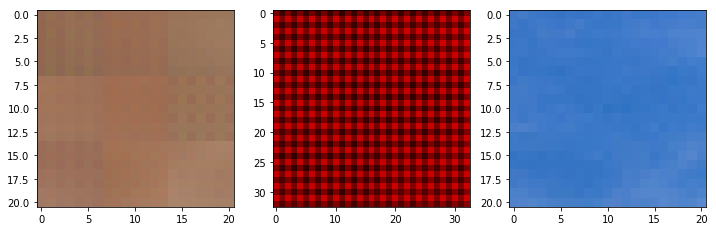

Epoch [129/500], Step [0/25], Loss: 0.019133878871798515
Epoch [129/500], Step [10/25], Loss: 0.020576292648911476
Epoch [129/500], Step [20/25], Loss: 0.021101711317896843

Finished Epoch 129, Loss --- mean: 0.0208285391330719, std 0.000817446369866185



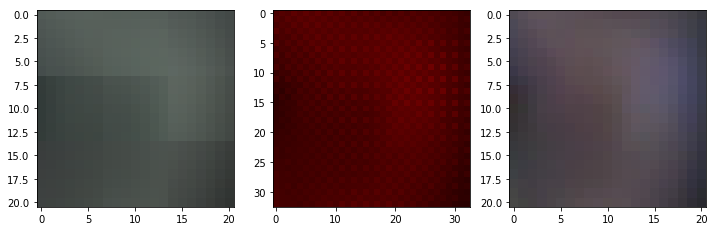

Epoch [130/500], Step [0/25], Loss: 0.02222481183707714
Epoch [130/500], Step [10/25], Loss: 0.02035130001604557
Epoch [130/500], Step [20/25], Loss: 0.020909186452627182

Finished Epoch 130, Loss --- mean: 0.020730164498090745, std 0.0008101174954340101



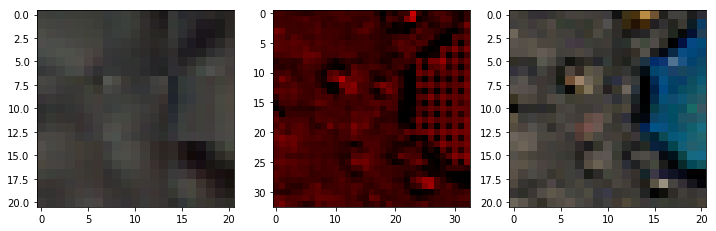

Epoch [131/500], Step [0/25], Loss: 0.021601170301437378
Epoch [131/500], Step [10/25], Loss: 0.021587755531072617
Epoch [131/500], Step [20/25], Loss: 0.021340331062674522

Finished Epoch 131, Loss --- mean: 0.021101464107632636, std 0.000839397028527957



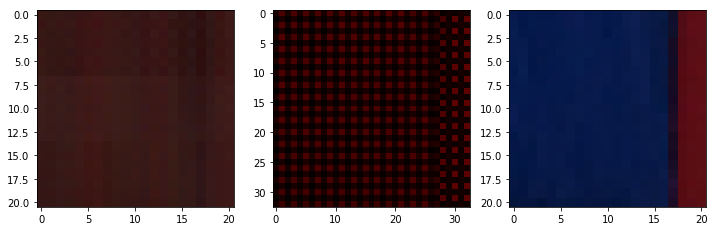

Epoch [132/500], Step [0/25], Loss: 0.0207514688372612
Epoch [132/500], Step [10/25], Loss: 0.0223179142922163
Epoch [132/500], Step [20/25], Loss: 0.021822916343808174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 132, Loss --- mean: 0.021192675903439522, std 0.0007202408594718928



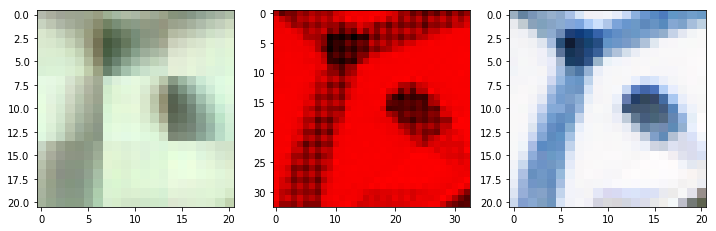

Epoch [133/500], Step [0/25], Loss: 0.021528325974941254
Epoch [133/500], Step [10/25], Loss: 0.020964954048395157
Epoch [133/500], Step [20/25], Loss: 0.02194429375231266

Finished Epoch 133, Loss --- mean: 0.020870043113827706, std 0.0008900926073815059



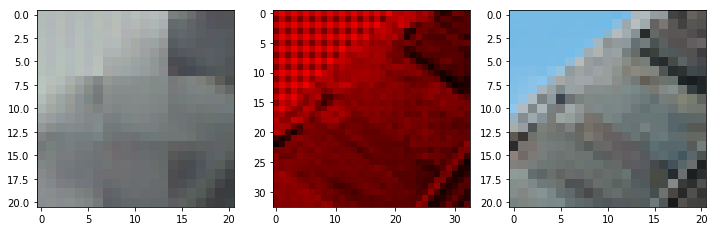

Epoch [134/500], Step [0/25], Loss: 0.020866410806775093
Epoch [134/500], Step [10/25], Loss: 0.02086002379655838
Epoch [134/500], Step [20/25], Loss: 0.02184216119349003

Finished Epoch 134, Loss --- mean: 0.020880606770515443, std 0.0007580970550175038



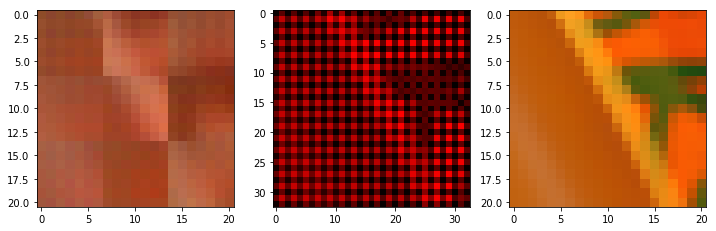

Epoch [135/500], Step [0/25], Loss: 0.02212730050086975
Epoch [135/500], Step [10/25], Loss: 0.02258891798555851
Epoch [135/500], Step [20/25], Loss: 0.019201574847102165

Finished Epoch 135, Loss --- mean: 0.020720242857933044, std 0.0012381139462472658



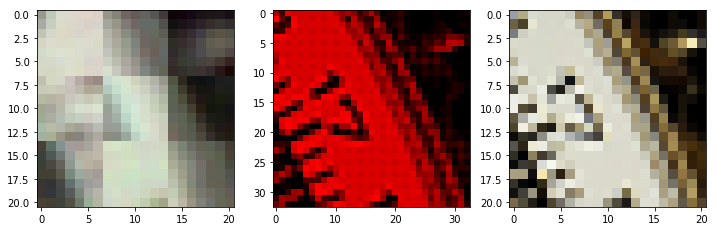

Epoch [136/500], Step [0/25], Loss: 0.021476468071341515
Epoch [136/500], Step [10/25], Loss: 0.022156480699777603
Epoch [136/500], Step [20/25], Loss: 0.01973632164299488

Finished Epoch 136, Loss --- mean: 0.020582680106163025, std 0.0007035425296907002



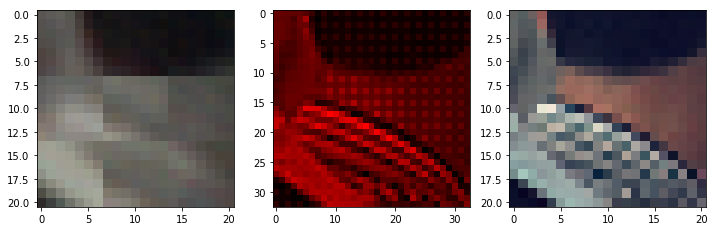

Epoch [137/500], Step [0/25], Loss: 0.020427877083420753
Epoch [137/500], Step [10/25], Loss: 0.02060556225478649
Epoch [137/500], Step [20/25], Loss: 0.021445846185088158

Finished Epoch 137, Loss --- mean: 0.020691198632121086, std 0.0009509449199985798



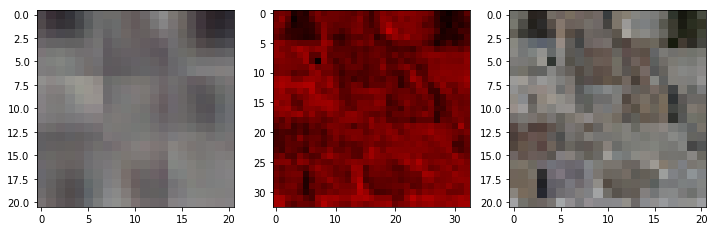

Epoch [138/500], Step [0/25], Loss: 0.020269645377993584
Epoch [138/500], Step [10/25], Loss: 0.021808743476867676
Epoch [138/500], Step [20/25], Loss: 0.02083001099526882

Finished Epoch 138, Loss --- mean: 0.02092119090259075, std 0.0007386588286890972



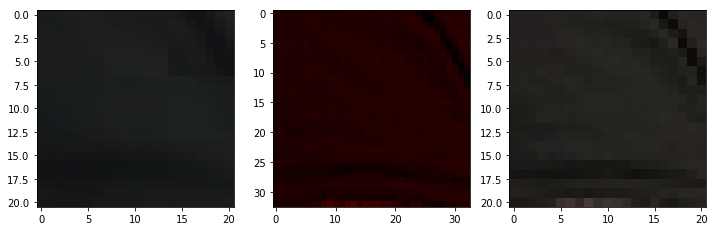

Epoch [139/500], Step [0/25], Loss: 0.020045612007379532
Epoch [139/500], Step [10/25], Loss: 0.0197148397564888
Epoch [139/500], Step [20/25], Loss: 0.020087111741304398

Finished Epoch 139, Loss --- mean: 0.021343760937452317, std 0.0009086120895136092



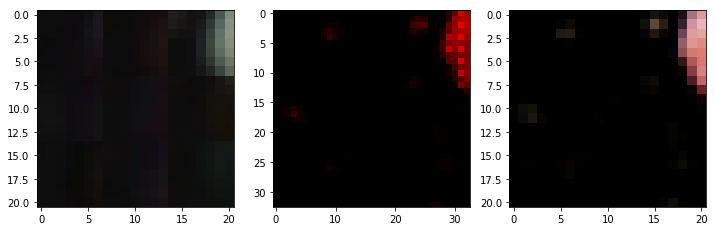

Epoch [140/500], Step [0/25], Loss: 0.020410660654306412
Epoch [140/500], Step [10/25], Loss: 0.02031962014734745
Epoch [140/500], Step [20/25], Loss: 0.022407084703445435

Finished Epoch 140, Loss --- mean: 0.020979221612215042, std 0.001037516101862968



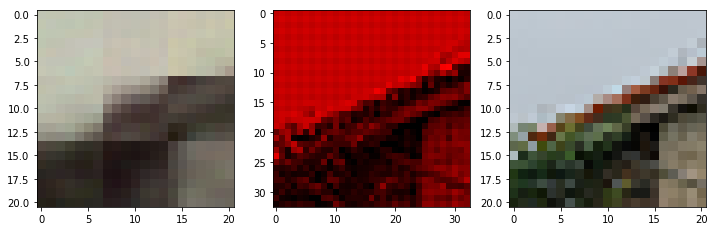

Epoch [141/500], Step [0/25], Loss: 0.021155746653676033
Epoch [141/500], Step [10/25], Loss: 0.021004732698202133
Epoch [141/500], Step [20/25], Loss: 0.020999576896429062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 141, Loss --- mean: 0.020593377649784087, std 0.0008037966354129039



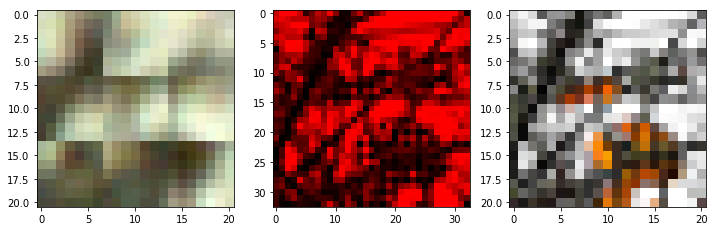

Epoch [142/500], Step [0/25], Loss: 0.020876947790384293
Epoch [142/500], Step [10/25], Loss: 0.019603148102760315
Epoch [142/500], Step [20/25], Loss: 0.01972786895930767

Finished Epoch 142, Loss --- mean: 0.020522893592715263, std 0.000606809553121176



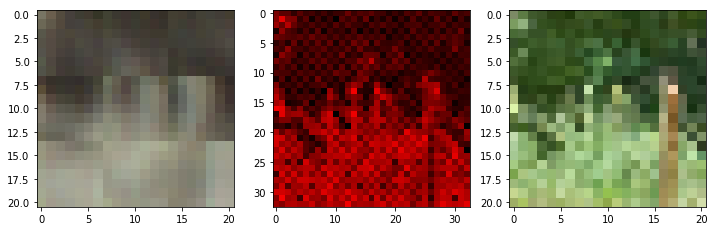

Epoch [143/500], Step [0/25], Loss: 0.021453198045492172
Epoch [143/500], Step [10/25], Loss: 0.021747874096035957
Epoch [143/500], Step [20/25], Loss: 0.01925574615597725

Finished Epoch 143, Loss --- mean: 0.020556106567382812, std 0.0007424291141411509



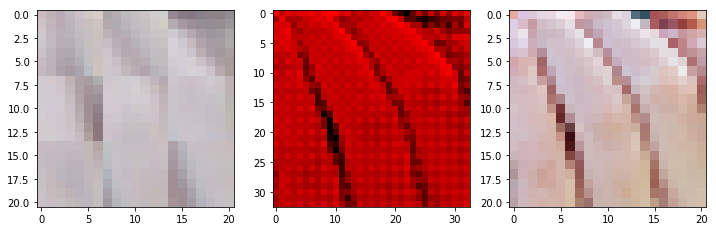

Epoch [144/500], Step [0/25], Loss: 0.020012345165014267
Epoch [144/500], Step [10/25], Loss: 0.022305939346551895
Epoch [144/500], Step [20/25], Loss: 0.020167579874396324

Finished Epoch 144, Loss --- mean: 0.0208304188400507, std 0.0006778879299580998



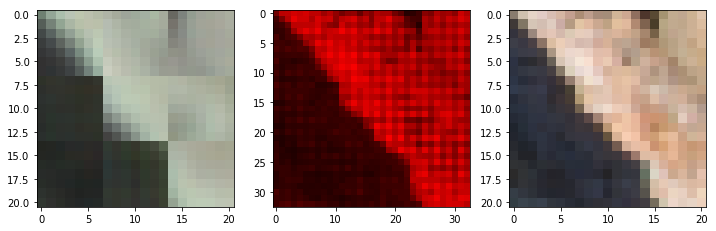

Epoch [145/500], Step [0/25], Loss: 0.020530831068754196
Epoch [145/500], Step [10/25], Loss: 0.021168209612369537
Epoch [145/500], Step [20/25], Loss: 0.020722785964608192

Finished Epoch 145, Loss --- mean: 0.02109876774251461, std 0.0009553899991012481



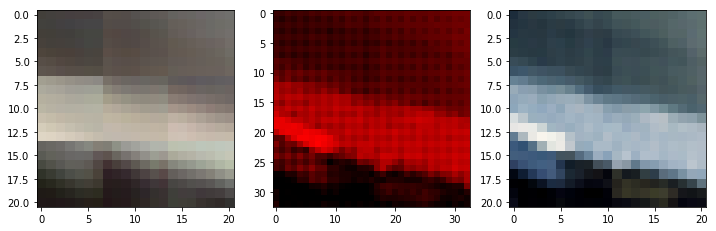

Epoch [146/500], Step [0/25], Loss: 0.021670332178473473
Epoch [146/500], Step [10/25], Loss: 0.02214714139699936
Epoch [146/500], Step [20/25], Loss: 0.02028624340891838

Finished Epoch 146, Loss --- mean: 0.020834005251526833, std 0.0007521840486864798



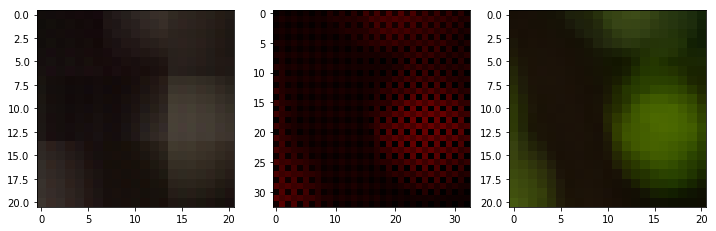

Epoch [147/500], Step [0/25], Loss: 0.02042423002421856
Epoch [147/500], Step [10/25], Loss: 0.022564450278878212
Epoch [147/500], Step [20/25], Loss: 0.02058454416692257

Finished Epoch 147, Loss --- mean: 0.020488467290997504, std 0.0009382967757534484



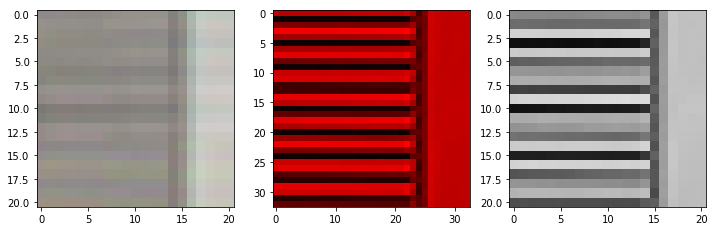

Epoch [148/500], Step [0/25], Loss: 0.020991453900933266
Epoch [148/500], Step [10/25], Loss: 0.020072409883141518
Epoch [148/500], Step [20/25], Loss: 0.021350551396608353

Finished Epoch 148, Loss --- mean: 0.02068678818643093, std 0.0009086287594905271



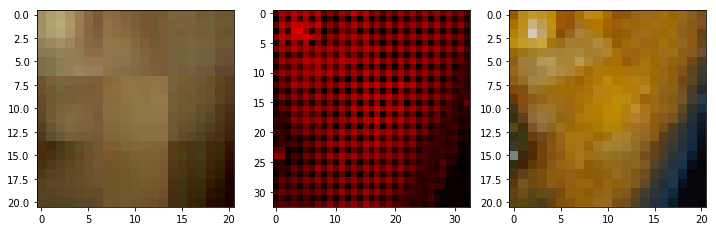

Epoch [149/500], Step [0/25], Loss: 0.020024223253130913
Epoch [149/500], Step [10/25], Loss: 0.021179355680942535
Epoch [149/500], Step [20/25], Loss: 0.02123468555510044

Finished Epoch 149, Loss --- mean: 0.020871254354715346, std 0.0007249764624452464



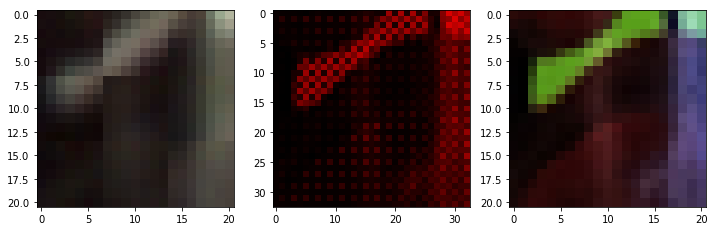

Epoch [150/500], Step [0/25], Loss: 0.02122710458934307
Epoch [150/500], Step [10/25], Loss: 0.02140241675078869
Epoch [150/500], Step [20/25], Loss: 0.021905669942498207

Finished Epoch 150, Loss --- mean: 0.020933886468410493, std 0.0007287145863744508



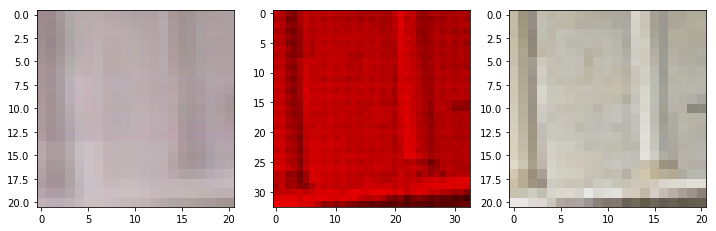

Epoch [151/500], Step [0/25], Loss: 0.019426686689257622
Epoch [151/500], Step [10/25], Loss: 0.02204677276313305
Epoch [151/500], Step [20/25], Loss: 0.02040565386414528

Finished Epoch 151, Loss --- mean: 0.0204908899217844, std 0.0008163728055202643



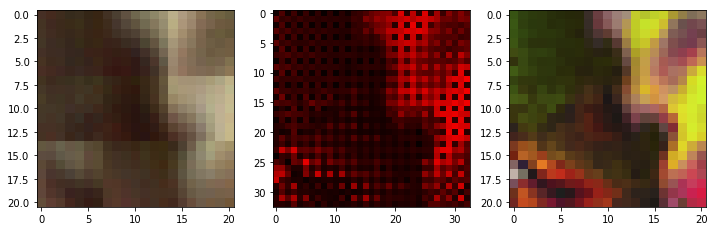

Epoch [152/500], Step [0/25], Loss: 0.022174756973981857
Epoch [152/500], Step [10/25], Loss: 0.019578324630856514
Epoch [152/500], Step [20/25], Loss: 0.02064758539199829

Finished Epoch 152, Loss --- mean: 0.020664585456252098, std 0.0008722647346221821



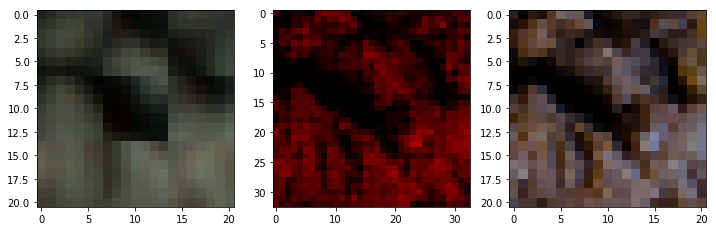

Epoch [153/500], Step [0/25], Loss: 0.0214940644800663
Epoch [153/500], Step [10/25], Loss: 0.019608085975050926
Epoch [153/500], Step [20/25], Loss: 0.02143942378461361


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 153, Loss --- mean: 0.02048053212463856, std 0.0008753115480103669



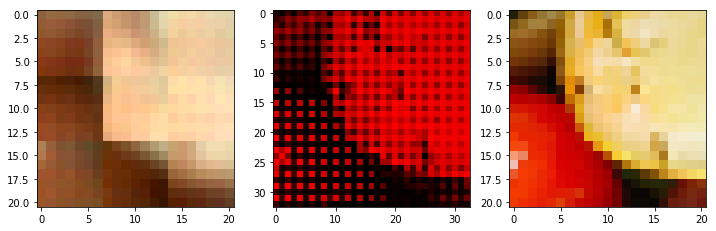

Epoch [154/500], Step [0/25], Loss: 0.019644100219011307
Epoch [154/500], Step [10/25], Loss: 0.0211342740803957
Epoch [154/500], Step [20/25], Loss: 0.021302783861756325

Finished Epoch 154, Loss --- mean: 0.020722675919532776, std 0.0006927898977113106



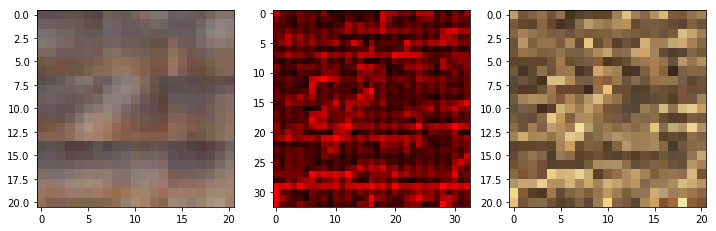

Epoch [155/500], Step [0/25], Loss: 0.020622186362743378
Epoch [155/500], Step [10/25], Loss: 0.018998119980096817
Epoch [155/500], Step [20/25], Loss: 0.018591009080410004

Finished Epoch 155, Loss --- mean: 0.020607356950640678, std 0.000864446518325963



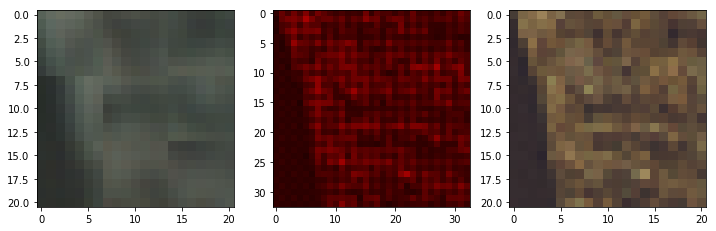

Epoch [156/500], Step [0/25], Loss: 0.018995288759469986
Epoch [156/500], Step [10/25], Loss: 0.020656557753682137
Epoch [156/500], Step [20/25], Loss: 0.019485631957650185

Finished Epoch 156, Loss --- mean: 0.020117514505982398, std 0.0007331848469414637



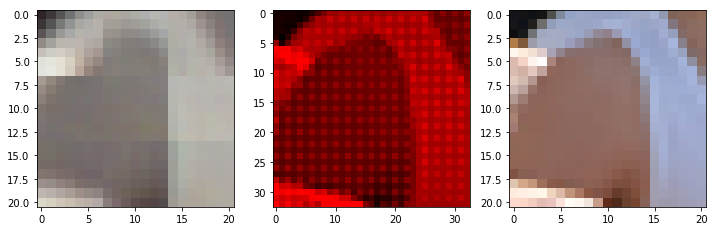

Epoch [157/500], Step [0/25], Loss: 0.02035508118569851
Epoch [157/500], Step [10/25], Loss: 0.022500399500131607
Epoch [157/500], Step [20/25], Loss: 0.020513111725449562

Finished Epoch 157, Loss --- mean: 0.02086519658565521, std 0.0008071791923235719



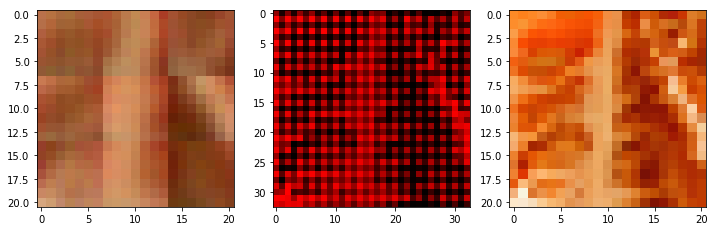

Epoch [158/500], Step [0/25], Loss: 0.022065792232751846
Epoch [158/500], Step [10/25], Loss: 0.01925613358616829
Epoch [158/500], Step [20/25], Loss: 0.020752808079123497

Finished Epoch 158, Loss --- mean: 0.021041248589754105, std 0.0009776068510290172



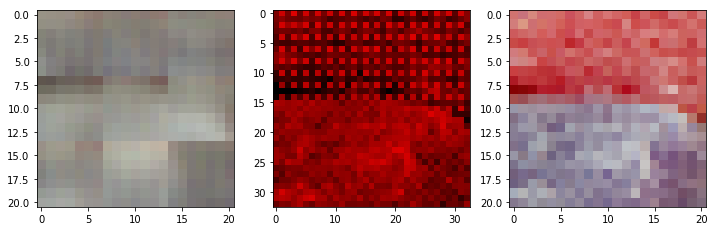

Epoch [159/500], Step [0/25], Loss: 0.019024431705474854
Epoch [159/500], Step [10/25], Loss: 0.021539395675063133
Epoch [159/500], Step [20/25], Loss: 0.019933396950364113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 159, Loss --- mean: 0.020599704906344413, std 0.0008597797291845799



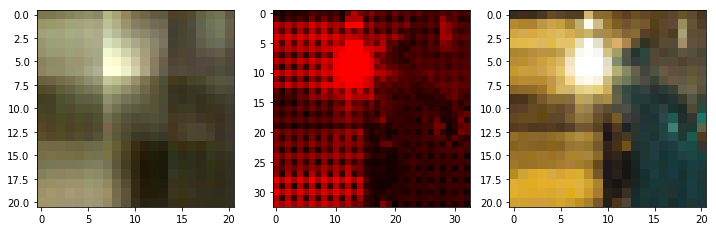

Epoch [160/500], Step [0/25], Loss: 0.02053578943014145
Epoch [160/500], Step [10/25], Loss: 0.020527198910713196
Epoch [160/500], Step [20/25], Loss: 0.020313769578933716

Finished Epoch 160, Loss --- mean: 0.020419102534651755, std 0.0006900309046697291



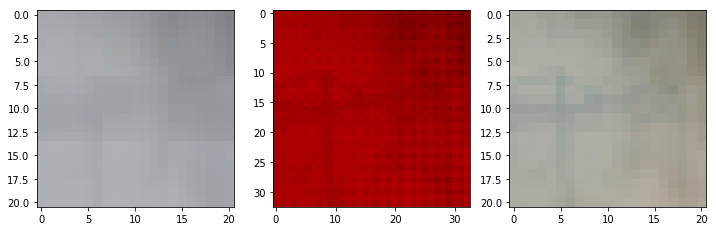

Epoch [161/500], Step [0/25], Loss: 0.02031395211815834
Epoch [161/500], Step [10/25], Loss: 0.02150864526629448
Epoch [161/500], Step [20/25], Loss: 0.01987643912434578

Finished Epoch 161, Loss --- mean: 0.020489597022533418, std 0.000781525333327193



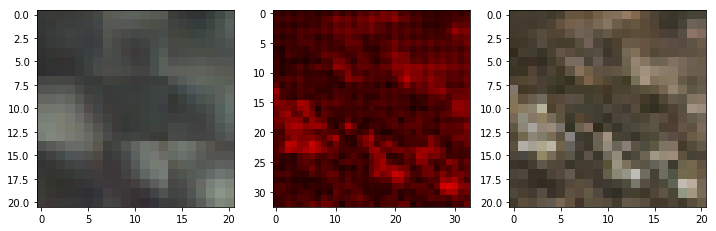

Epoch [162/500], Step [0/25], Loss: 0.019944816827774048
Epoch [162/500], Step [10/25], Loss: 0.02110258676111698
Epoch [162/500], Step [20/25], Loss: 0.02071344666182995

Finished Epoch 162, Loss --- mean: 0.020836790651082994, std 0.0008744386693273504



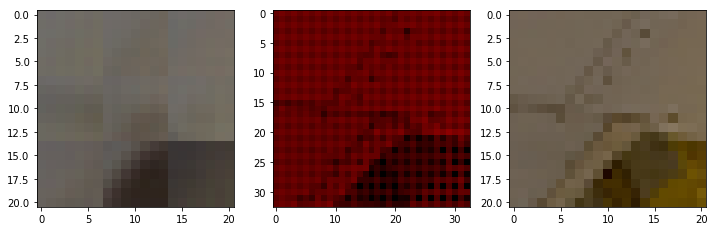

Epoch [163/500], Step [0/25], Loss: 0.021243050694465637
Epoch [163/500], Step [10/25], Loss: 0.0194668211042881
Epoch [163/500], Step [20/25], Loss: 0.0193986464291811

Finished Epoch 163, Loss --- mean: 0.020545996874570847, std 0.0008683143575212944



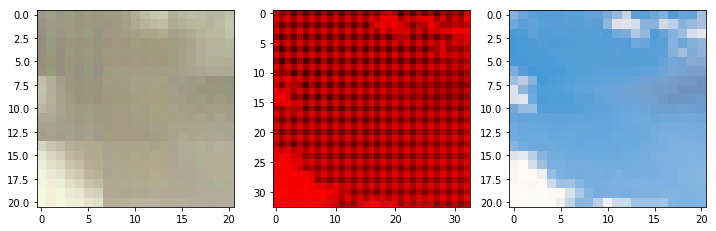

Epoch [164/500], Step [0/25], Loss: 0.020505325868725777
Epoch [164/500], Step [10/25], Loss: 0.021704817190766335
Epoch [164/500], Step [20/25], Loss: 0.019957711920142174

Finished Epoch 164, Loss --- mean: 0.020802531316876413, std 0.0009673878658759336



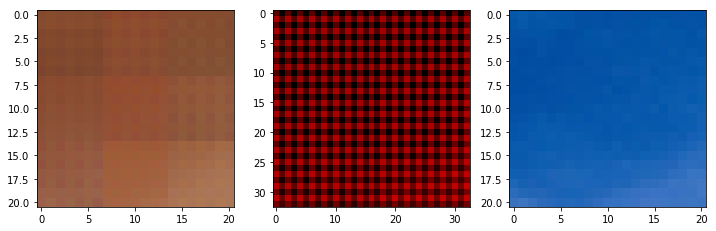

Epoch [165/500], Step [0/25], Loss: 0.020706843584775925
Epoch [165/500], Step [10/25], Loss: 0.02083064243197441
Epoch [165/500], Step [20/25], Loss: 0.020058488473296165

Finished Epoch 165, Loss --- mean: 0.020526437386870384, std 0.0009378931782392654



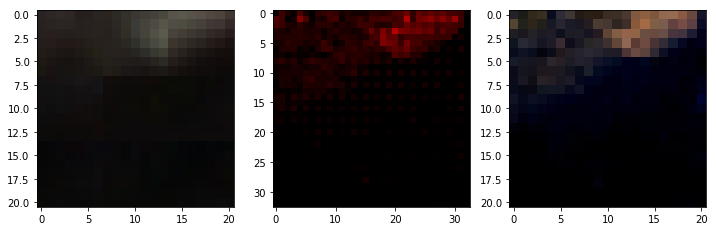

Epoch [166/500], Step [0/25], Loss: 0.021201234310865402
Epoch [166/500], Step [10/25], Loss: 0.021936608478426933
Epoch [166/500], Step [20/25], Loss: 0.018889088183641434

Finished Epoch 166, Loss --- mean: 0.020362894758582117, std 0.0011310381872510164



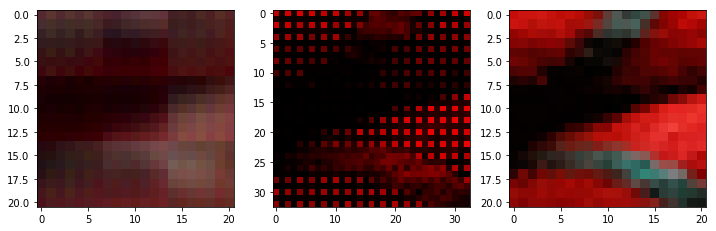

Epoch [167/500], Step [0/25], Loss: 0.017895283177495003
Epoch [167/500], Step [10/25], Loss: 0.020018624141812325
Epoch [167/500], Step [20/25], Loss: 0.019223632290959358

Finished Epoch 167, Loss --- mean: 0.020165946260094644, std 0.000817741550482143



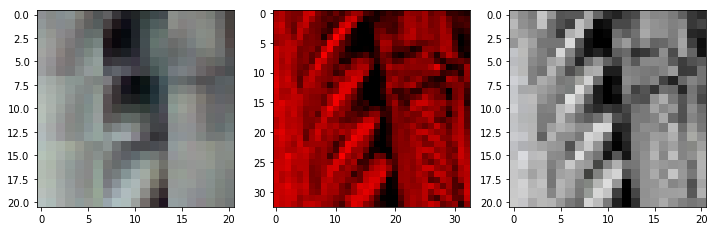

Epoch [168/500], Step [0/25], Loss: 0.01942390576004982
Epoch [168/500], Step [10/25], Loss: 0.01959851384162903
Epoch [168/500], Step [20/25], Loss: 0.021936733275651932

Finished Epoch 168, Loss --- mean: 0.020199719816446304, std 0.0009071761779045103



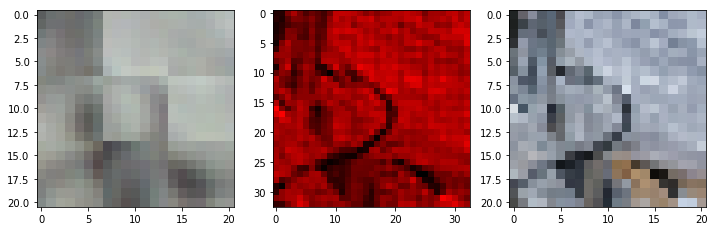

Epoch [169/500], Step [0/25], Loss: 0.01934221014380455
Epoch [169/500], Step [10/25], Loss: 0.022072814404964447
Epoch [169/500], Step [20/25], Loss: 0.020481694489717484

Finished Epoch 169, Loss --- mean: 0.02044219620525837, std 0.0008425921103068492



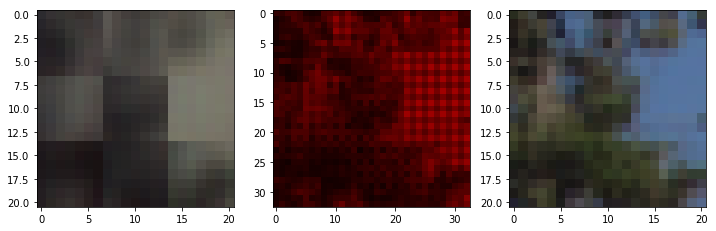

Epoch [170/500], Step [0/25], Loss: 0.02111212909221649
Epoch [170/500], Step [10/25], Loss: 0.020746495574712753
Epoch [170/500], Step [20/25], Loss: 0.022707389667630196

Finished Epoch 170, Loss --- mean: 0.020956267192959784, std 0.0009672351690733286



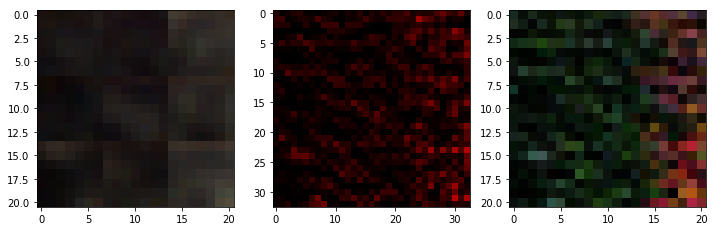

Epoch [171/500], Step [0/25], Loss: 0.02016679383814335
Epoch [171/500], Step [10/25], Loss: 0.021169885993003845
Epoch [171/500], Step [20/25], Loss: 0.02062993496656418

Finished Epoch 171, Loss --- mean: 0.020555107668042184, std 0.000895158473529182



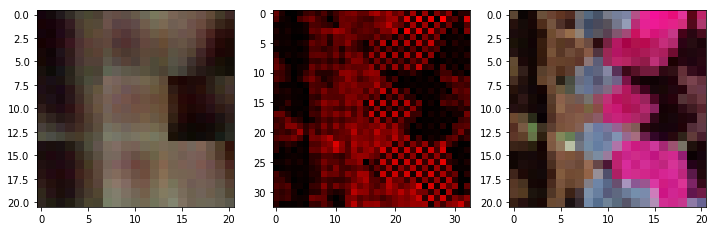

Epoch [172/500], Step [0/25], Loss: 0.020886195823550224
Epoch [172/500], Step [10/25], Loss: 0.020396949723362923
Epoch [172/500], Step [20/25], Loss: 0.018854092806577682

Finished Epoch 172, Loss --- mean: 0.020440760031342507, std 0.0007075268632895223



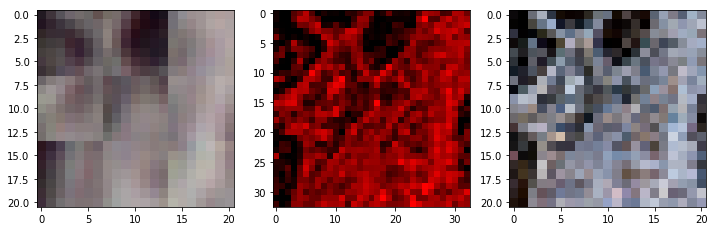

Epoch [173/500], Step [0/25], Loss: 0.020659223198890686
Epoch [173/500], Step [10/25], Loss: 0.020169762894511223
Epoch [173/500], Step [20/25], Loss: 0.02080639638006687

Finished Epoch 173, Loss --- mean: 0.020321489423513413, std 0.0007635814571854983



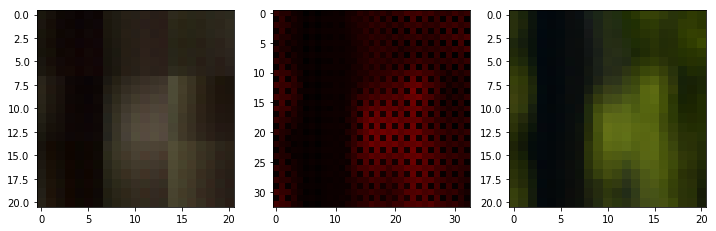

Epoch [174/500], Step [0/25], Loss: 0.02188955247402191
Epoch [174/500], Step [10/25], Loss: 0.020870473235845566
Epoch [174/500], Step [20/25], Loss: 0.018932664766907692


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 174, Loss --- mean: 0.02044942282140255, std 0.0007757448908947288



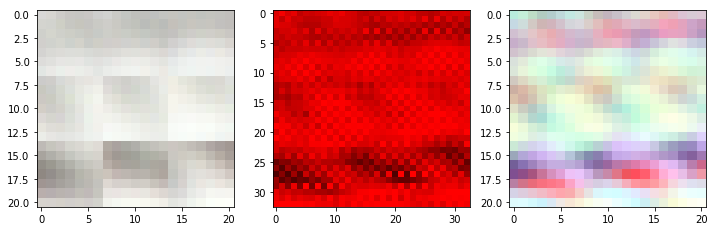

Epoch [175/500], Step [0/25], Loss: 0.021410342305898666
Epoch [175/500], Step [10/25], Loss: 0.020723504945635796
Epoch [175/500], Step [20/25], Loss: 0.020910559222102165

Finished Epoch 175, Loss --- mean: 0.02057298757135868, std 0.0007097540058984664



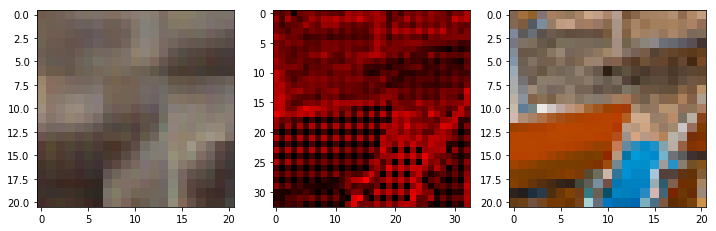

Epoch [176/500], Step [0/25], Loss: 0.02053081803023815
Epoch [176/500], Step [10/25], Loss: 0.01981448568403721
Epoch [176/500], Step [20/25], Loss: 0.019167045131325722

Finished Epoch 176, Loss --- mean: 0.02048599496483803, std 0.0007325444850901524



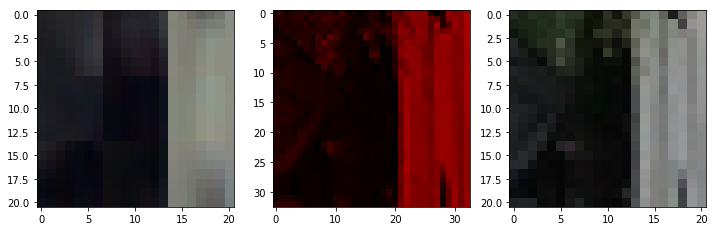

Epoch [177/500], Step [0/25], Loss: 0.021784158423542976
Epoch [177/500], Step [10/25], Loss: 0.01889835298061371
Epoch [177/500], Step [20/25], Loss: 0.019271519035100937

Finished Epoch 177, Loss --- mean: 0.020273850932717323, std 0.0008769160821954904



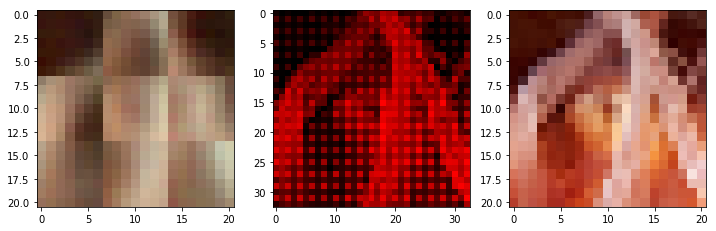

Epoch [178/500], Step [0/25], Loss: 0.019521674141287804
Epoch [178/500], Step [10/25], Loss: 0.02066052518785
Epoch [178/500], Step [20/25], Loss: 0.02000138908624649

Finished Epoch 178, Loss --- mean: 0.020213455483317374, std 0.0007054236709401607



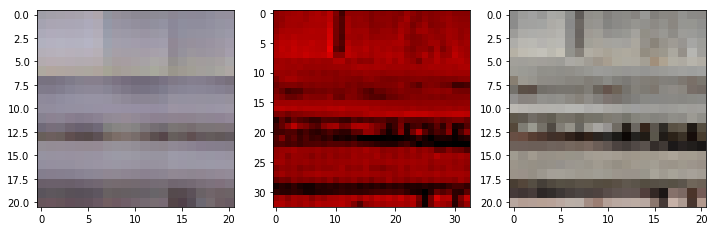

Epoch [179/500], Step [0/25], Loss: 0.018448079004883766
Epoch [179/500], Step [10/25], Loss: 0.01920166052877903
Epoch [179/500], Step [20/25], Loss: 0.019510673359036446

Finished Epoch 179, Loss --- mean: 0.020215688049793245, std 0.0007702526060857221



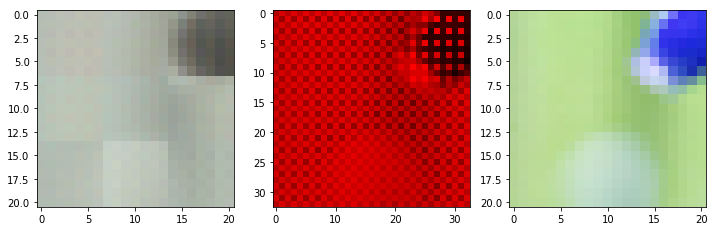

Epoch [180/500], Step [0/25], Loss: 0.020491648465394974
Epoch [180/500], Step [10/25], Loss: 0.018727678805589676
Epoch [180/500], Step [20/25], Loss: 0.020739177241921425

Finished Epoch 180, Loss --- mean: 0.02018656238913536, std 0.0008970767765005658



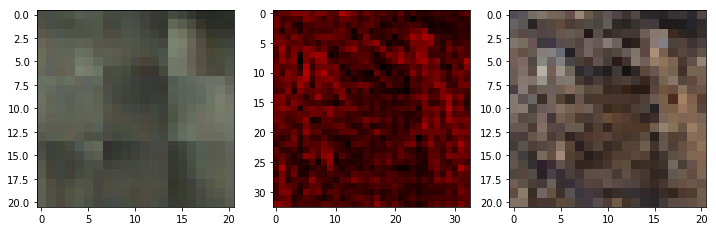

Epoch [181/500], Step [0/25], Loss: 0.019402485340833664
Epoch [181/500], Step [10/25], Loss: 0.019679639488458633
Epoch [181/500], Step [20/25], Loss: 0.022821923717856407

Finished Epoch 181, Loss --- mean: 0.020792450457811355, std 0.0009135517725547552



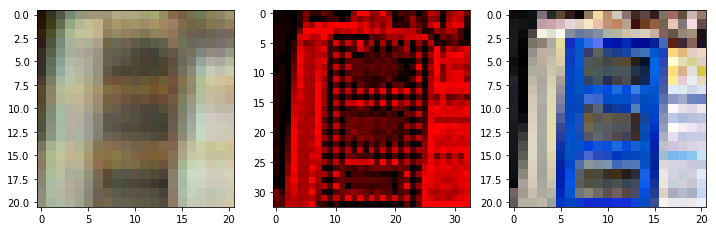

Epoch [182/500], Step [0/25], Loss: 0.021885918453335762
Epoch [182/500], Step [10/25], Loss: 0.021050522103905678
Epoch [182/500], Step [20/25], Loss: 0.020897353067994118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 182, Loss --- mean: 0.020609528124332428, std 0.0007434625993441819



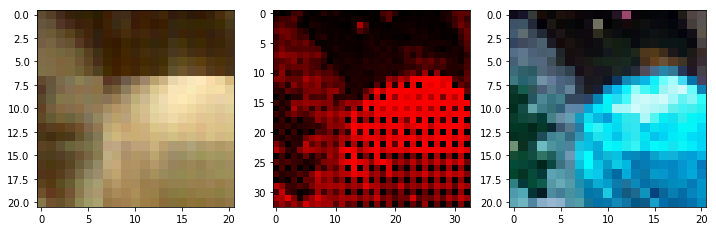

Epoch [183/500], Step [0/25], Loss: 0.02103300206363201
Epoch [183/500], Step [10/25], Loss: 0.020715776830911636
Epoch [183/500], Step [20/25], Loss: 0.020311389118433

Finished Epoch 183, Loss --- mean: 0.020249848440289497, std 0.0012035759078915555



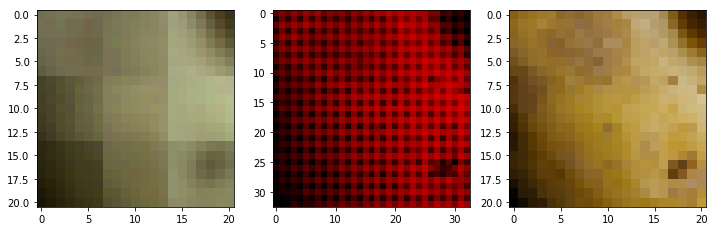

Epoch [184/500], Step [0/25], Loss: 0.021381409838795662
Epoch [184/500], Step [10/25], Loss: 0.019172120839357376
Epoch [184/500], Step [20/25], Loss: 0.019683878868818283

Finished Epoch 184, Loss --- mean: 0.020112167596817016, std 0.0009067278471507411



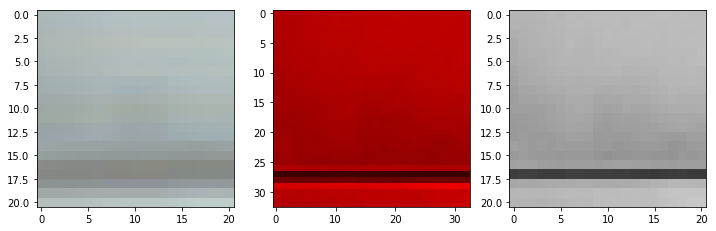

Epoch [185/500], Step [0/25], Loss: 0.019072003662586212
Epoch [185/500], Step [10/25], Loss: 0.020243238657712936
Epoch [185/500], Step [20/25], Loss: 0.02074989676475525

Finished Epoch 185, Loss --- mean: 0.020449313148856164, std 0.0009389777560019293



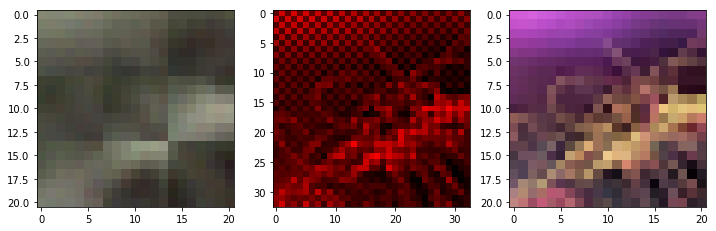

Epoch [186/500], Step [0/25], Loss: 0.020542606711387634
Epoch [186/500], Step [10/25], Loss: 0.020245522260665894
Epoch [186/500], Step [20/25], Loss: 0.02133091352880001

Finished Epoch 186, Loss --- mean: 0.02051244832575321, std 0.000770221124102141



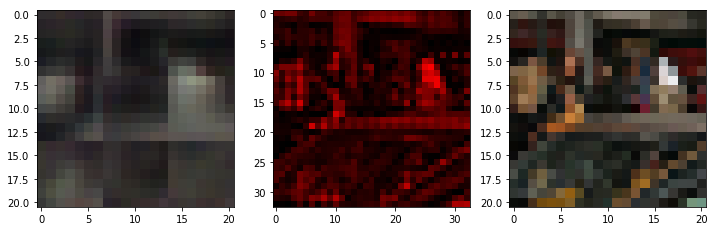

Epoch [187/500], Step [0/25], Loss: 0.020097199827432632
Epoch [187/500], Step [10/25], Loss: 0.020167727023363113
Epoch [187/500], Step [20/25], Loss: 0.020442679524421692

Finished Epoch 187, Loss --- mean: 0.020548491701483727, std 0.000940252376538542



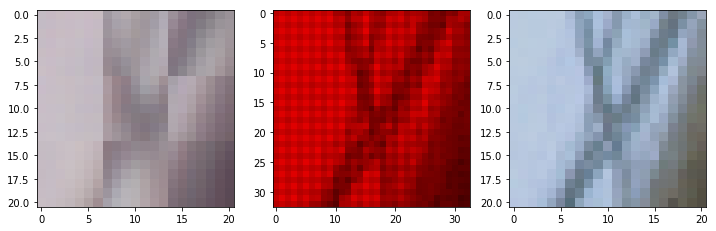

Epoch [188/500], Step [0/25], Loss: 0.020491907373070717
Epoch [188/500], Step [10/25], Loss: 0.020260309800505638
Epoch [188/500], Step [20/25], Loss: 0.02167385444045067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 188, Loss --- mean: 0.02013520672917366, std 0.0007564764138324788



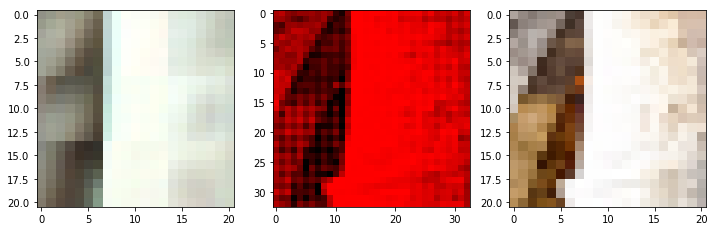

Epoch [189/500], Step [0/25], Loss: 0.020377611741423607
Epoch [189/500], Step [10/25], Loss: 0.019878307357430458
Epoch [189/500], Step [20/25], Loss: 0.019775813445448875

Finished Epoch 189, Loss --- mean: 0.02000214159488678, std 0.0009799222269930277



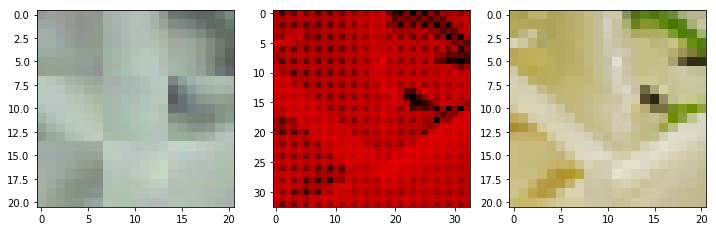

Epoch [190/500], Step [0/25], Loss: 0.02155933901667595
Epoch [190/500], Step [10/25], Loss: 0.019101666286587715
Epoch [190/500], Step [20/25], Loss: 0.019618043676018715

Finished Epoch 190, Loss --- mean: 0.020317088067531585, std 0.0009193844906986814



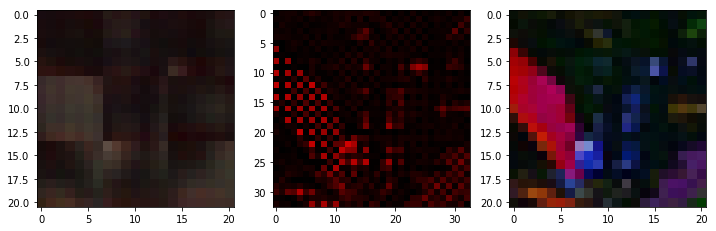

Epoch [191/500], Step [0/25], Loss: 0.01929541677236557
Epoch [191/500], Step [10/25], Loss: 0.020792156457901
Epoch [191/500], Step [20/25], Loss: 0.019945116713643074

Finished Epoch 191, Loss --- mean: 0.0203091998398304, std 0.0010024949805925683



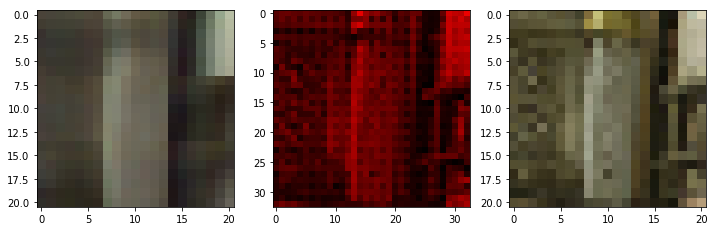

Epoch [192/500], Step [0/25], Loss: 0.020987195894122124
Epoch [192/500], Step [10/25], Loss: 0.019213777035474777
Epoch [192/500], Step [20/25], Loss: 0.02083212323486805

Finished Epoch 192, Loss --- mean: 0.02019849419593811, std 0.0007670993298038675



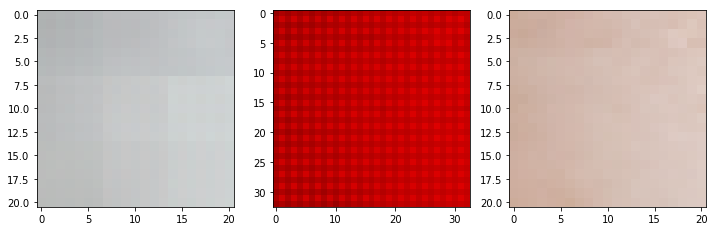

Epoch [193/500], Step [0/25], Loss: 0.019933344796299934
Epoch [193/500], Step [10/25], Loss: 0.01990964077413082
Epoch [193/500], Step [20/25], Loss: 0.019906409084796906

Finished Epoch 193, Loss --- mean: 0.020025342851877213, std 0.0007990997124660086



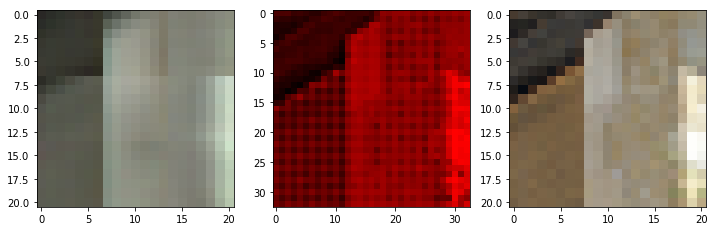

Epoch [194/500], Step [0/25], Loss: 0.022125395014882088
Epoch [194/500], Step [10/25], Loss: 0.02021813578903675
Epoch [194/500], Step [20/25], Loss: 0.020613567903637886


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 194, Loss --- mean: 0.02046877846121788, std 0.0009542699306735896



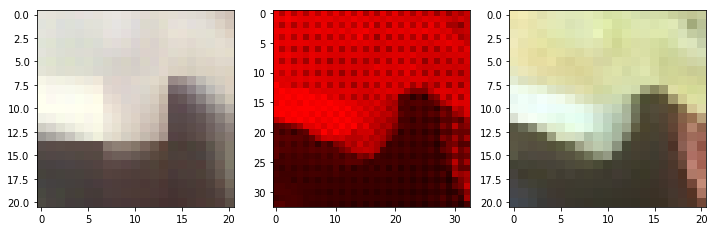

Epoch [195/500], Step [0/25], Loss: 0.01895085722208023
Epoch [195/500], Step [10/25], Loss: 0.021069446578621864
Epoch [195/500], Step [20/25], Loss: 0.020499547943472862

Finished Epoch 195, Loss --- mean: 0.02057191640138626, std 0.0009448151003314146



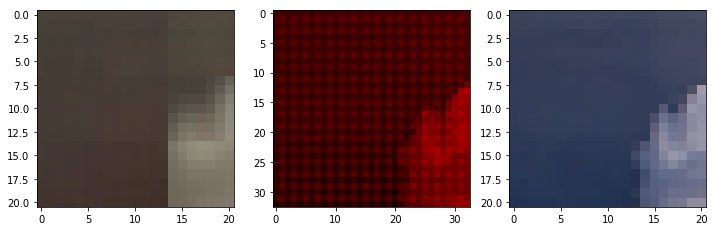

Epoch [196/500], Step [0/25], Loss: 0.020646879449486732
Epoch [196/500], Step [10/25], Loss: 0.02122323028743267
Epoch [196/500], Step [20/25], Loss: 0.019941117614507675

Finished Epoch 196, Loss --- mean: 0.020149441063404085, std 0.0011664960028033985



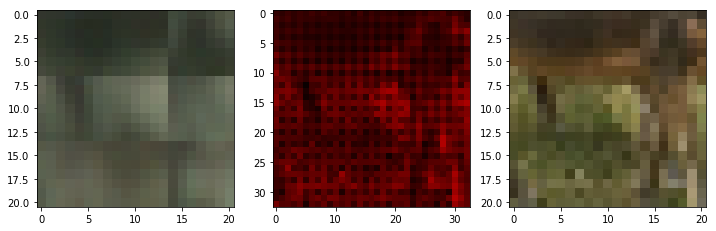

Epoch [197/500], Step [0/25], Loss: 0.020312383770942688
Epoch [197/500], Step [10/25], Loss: 0.02004048600792885
Epoch [197/500], Step [20/25], Loss: 0.020076869055628777

Finished Epoch 197, Loss --- mean: 0.01984035313129425, std 0.0008645354493136745



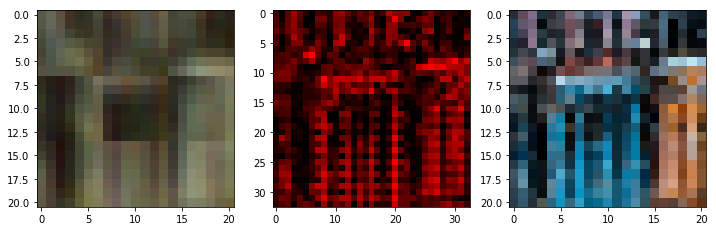

Epoch [198/500], Step [0/25], Loss: 0.020283425226807594
Epoch [198/500], Step [10/25], Loss: 0.02112426608800888
Epoch [198/500], Step [20/25], Loss: 0.020328102633357048

Finished Epoch 198, Loss --- mean: 0.019877390265464784, std 0.0011069532247100708



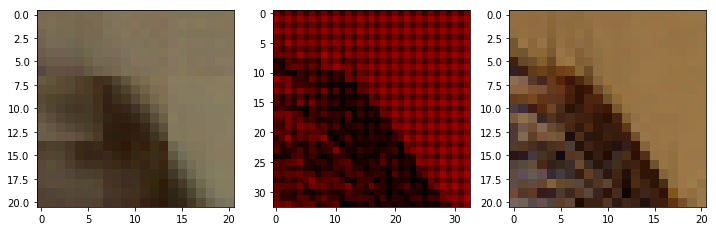

Epoch [199/500], Step [0/25], Loss: 0.021341359242796898
Epoch [199/500], Step [10/25], Loss: 0.019941506907343864
Epoch [199/500], Step [20/25], Loss: 0.01980338804423809

Finished Epoch 199, Loss --- mean: 0.019865520894527436, std 0.0006600364369179378



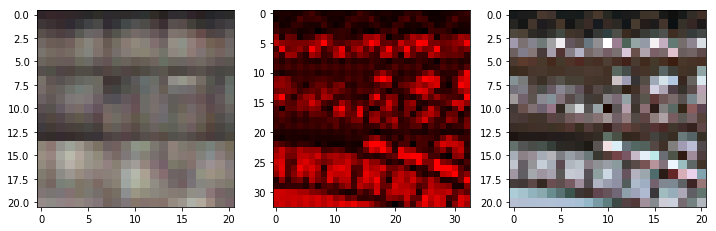

Epoch [200/500], Step [0/25], Loss: 0.02063613198697567
Epoch [200/500], Step [10/25], Loss: 0.020475609228014946
Epoch [200/500], Step [20/25], Loss: 0.020798424258828163

Finished Epoch 200, Loss --- mean: 0.019774870276451112, std 0.0007974759078207564



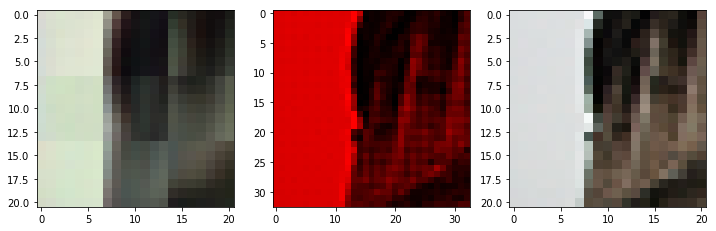

Epoch [201/500], Step [0/25], Loss: 0.020382648333907127
Epoch [201/500], Step [10/25], Loss: 0.020677512511610985
Epoch [201/500], Step [20/25], Loss: 0.021938927471637726

Finished Epoch 201, Loss --- mean: 0.02016225703060627, std 0.0008660851892211948



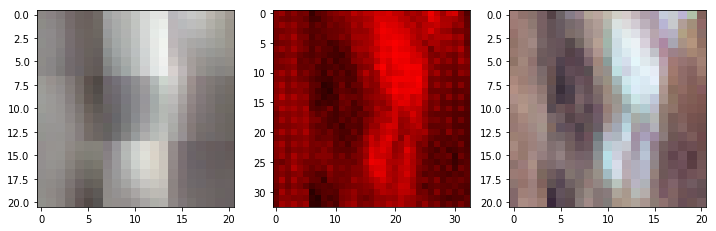

Epoch [202/500], Step [0/25], Loss: 0.021717773750424385
Epoch [202/500], Step [10/25], Loss: 0.019716301932930946
Epoch [202/500], Step [20/25], Loss: 0.020109767094254494

Finished Epoch 202, Loss --- mean: 0.020641195848584176, std 0.0008909325255509254



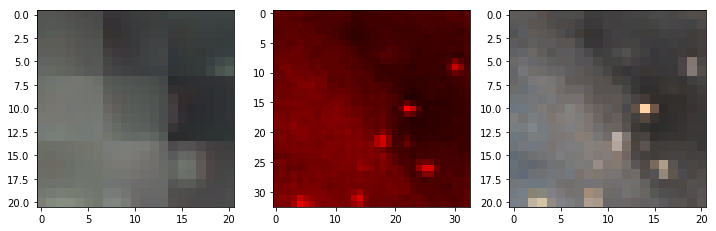

Epoch [203/500], Step [0/25], Loss: 0.02120368555188179
Epoch [203/500], Step [10/25], Loss: 0.020493289455771446
Epoch [203/500], Step [20/25], Loss: 0.020783349871635437

Finished Epoch 203, Loss --- mean: 0.02007705494761467, std 0.0007171561814465955



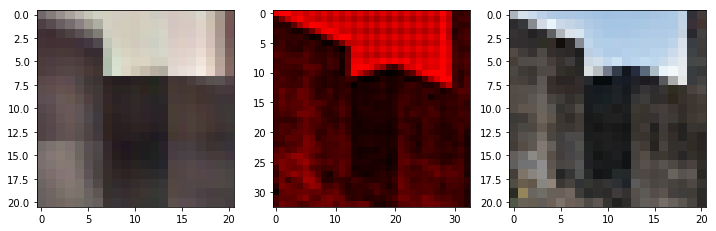

Epoch [204/500], Step [0/25], Loss: 0.0195362139493227
Epoch [204/500], Step [10/25], Loss: 0.01975857838988304
Epoch [204/500], Step [20/25], Loss: 0.01932387612760067

Finished Epoch 204, Loss --- mean: 0.020061895698308945, std 0.0007554804230367968



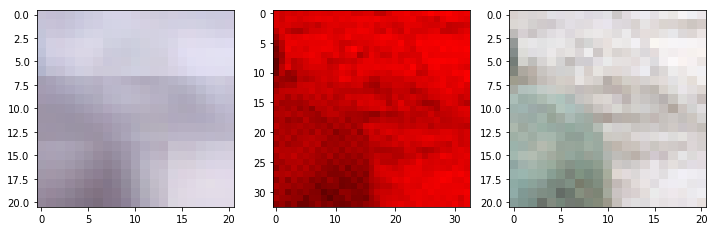

Epoch [205/500], Step [0/25], Loss: 0.02087213657796383
Epoch [205/500], Step [10/25], Loss: 0.01931612566113472
Epoch [205/500], Step [20/25], Loss: 0.020897557958960533

Finished Epoch 205, Loss --- mean: 0.01998683698475361, std 0.0006596774172044009



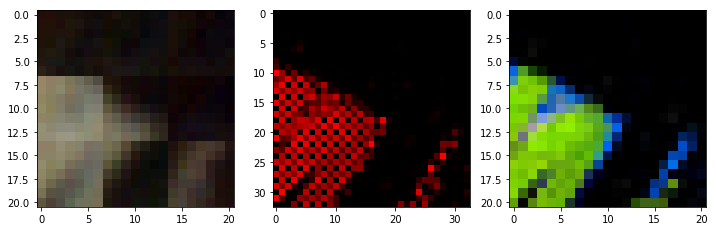

Epoch [206/500], Step [0/25], Loss: 0.019480155780911446
Epoch [206/500], Step [10/25], Loss: 0.020822055637836456
Epoch [206/500], Step [20/25], Loss: 0.02014804817736149

Finished Epoch 206, Loss --- mean: 0.01982764758169651, std 0.000885496288749286



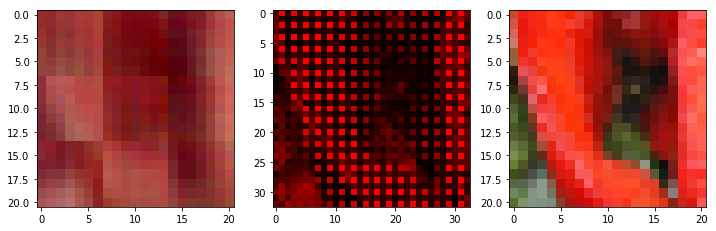

Epoch [207/500], Step [0/25], Loss: 0.019489597529172897
Epoch [207/500], Step [10/25], Loss: 0.01989791914820671
Epoch [207/500], Step [20/25], Loss: 0.019829364493489265

Finished Epoch 207, Loss --- mean: 0.020231457352638246, std 0.0011063667296379155



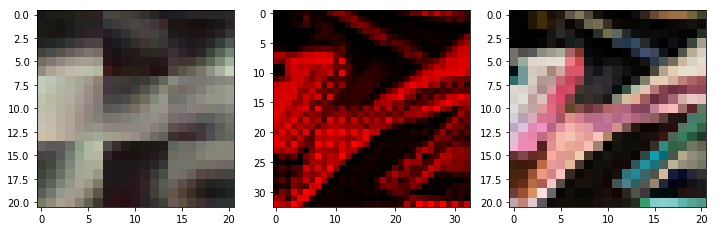

Epoch [208/500], Step [0/25], Loss: 0.019002994522452354
Epoch [208/500], Step [10/25], Loss: 0.020505759865045547
Epoch [208/500], Step [20/25], Loss: 0.0214413870126009

Finished Epoch 208, Loss --- mean: 0.020316487923264504, std 0.0012091602590859742



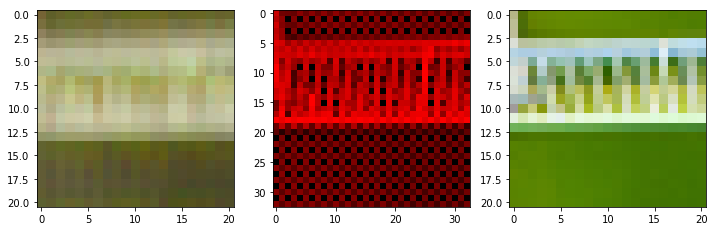

Epoch [209/500], Step [0/25], Loss: 0.01987195760011673
Epoch [209/500], Step [10/25], Loss: 0.018760716542601585
Epoch [209/500], Step [20/25], Loss: 0.02169518545269966

Finished Epoch 209, Loss --- mean: 0.02034750923514366, std 0.0010435789395985863



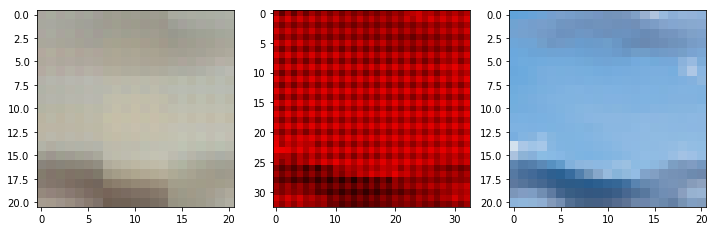

Epoch [210/500], Step [0/25], Loss: 0.019598226994276047
Epoch [210/500], Step [10/25], Loss: 0.01936946250498295
Epoch [210/500], Step [20/25], Loss: 0.02155356854200363

Finished Epoch 210, Loss --- mean: 0.019773322343826293, std 0.0007446156678276862



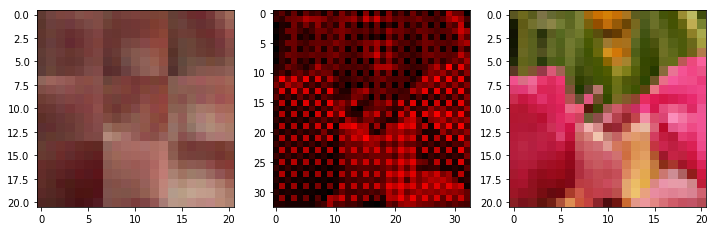

Epoch [211/500], Step [0/25], Loss: 0.019637716934084892
Epoch [211/500], Step [10/25], Loss: 0.019450373947620392
Epoch [211/500], Step [20/25], Loss: 0.02040884830057621

Finished Epoch 211, Loss --- mean: 0.01999153643846512, std 0.0007422204067866136



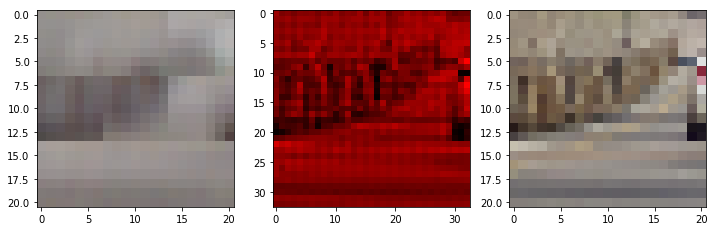

Epoch [212/500], Step [0/25], Loss: 0.021692853420972824
Epoch [212/500], Step [10/25], Loss: 0.020609887316823006
Epoch [212/500], Step [20/25], Loss: 0.01905287802219391

Finished Epoch 212, Loss --- mean: 0.01977479286491871, std 0.0009419946563876298



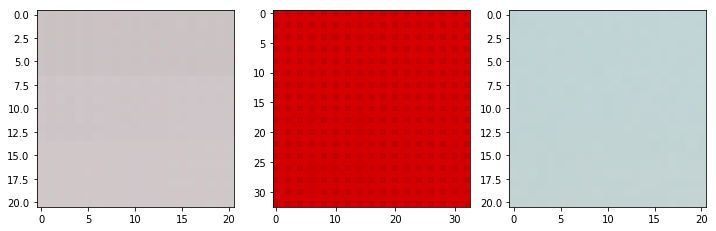

Epoch [213/500], Step [0/25], Loss: 0.019180061295628548
Epoch [213/500], Step [10/25], Loss: 0.019493451341986656
Epoch [213/500], Step [20/25], Loss: 0.02084043249487877

Finished Epoch 213, Loss --- mean: 0.020028591081500055, std 0.0008097091238122139



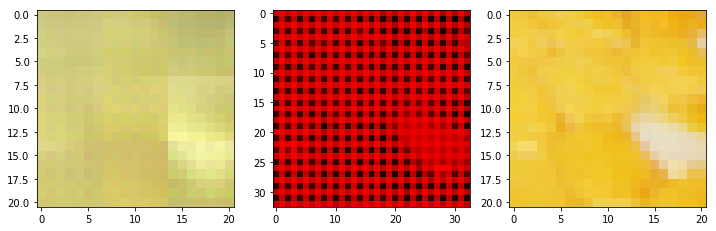

Epoch [214/500], Step [0/25], Loss: 0.01863793656229973
Epoch [214/500], Step [10/25], Loss: 0.020545924082398415
Epoch [214/500], Step [20/25], Loss: 0.01881074160337448

Finished Epoch 214, Loss --- mean: 0.01997305527329445, std 0.0009082202895078573



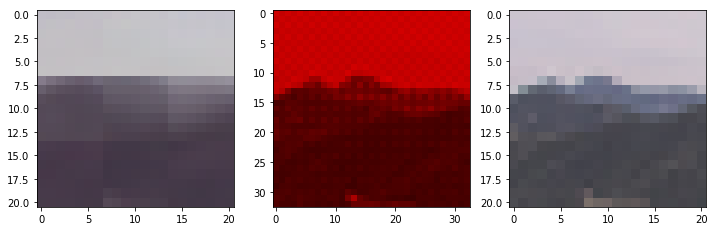

Epoch [215/500], Step [0/25], Loss: 0.020749090239405632
Epoch [215/500], Step [10/25], Loss: 0.019105497747659683
Epoch [215/500], Step [20/25], Loss: 0.02039305493235588

Finished Epoch 215, Loss --- mean: 0.01993580587208271, std 0.0007177317553467178



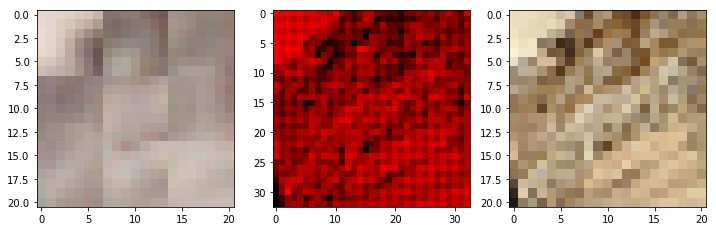

Epoch [216/500], Step [0/25], Loss: 0.019680205732584
Epoch [216/500], Step [10/25], Loss: 0.02038535661995411
Epoch [216/500], Step [20/25], Loss: 0.02083299495279789

Finished Epoch 216, Loss --- mean: 0.020149816647171973, std 0.000789496158617427



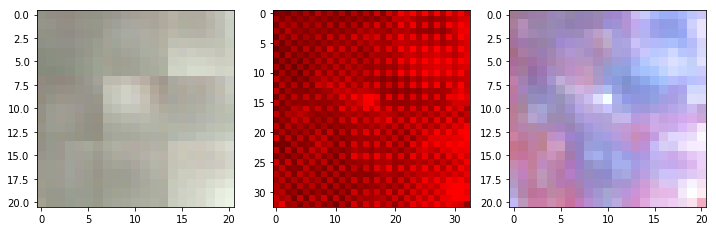

Epoch [217/500], Step [0/25], Loss: 0.02012351155281067
Epoch [217/500], Step [10/25], Loss: 0.020681045949459076
Epoch [217/500], Step [20/25], Loss: 0.01883355900645256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 217, Loss --- mean: 0.019997587129473686, std 0.0007938815495330784



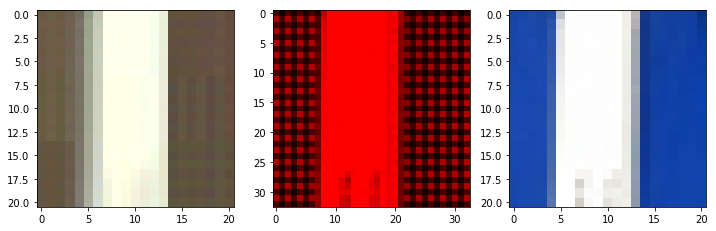

Epoch [218/500], Step [0/25], Loss: 0.019635405391454697
Epoch [218/500], Step [10/25], Loss: 0.019747011363506317
Epoch [218/500], Step [20/25], Loss: 0.01971423253417015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 218, Loss --- mean: 0.019774641916155813, std 0.0009334833398690952



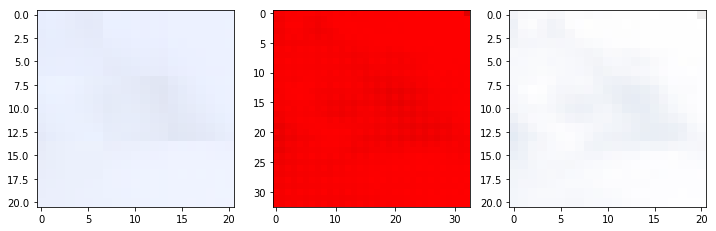

Epoch [219/500], Step [0/25], Loss: 0.02094370499253273
Epoch [219/500], Step [10/25], Loss: 0.018911072984337807
Epoch [219/500], Step [20/25], Loss: 0.020352693274617195

Finished Epoch 219, Loss --- mean: 0.019695293605327607, std 0.0007846893646111547



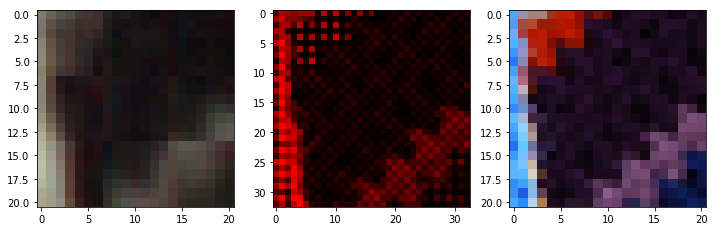

Epoch [220/500], Step [0/25], Loss: 0.01999635063111782
Epoch [220/500], Step [10/25], Loss: 0.020132819190621376
Epoch [220/500], Step [20/25], Loss: 0.020770877599716187

Finished Epoch 220, Loss --- mean: 0.019858989492058755, std 0.0008308196157962303



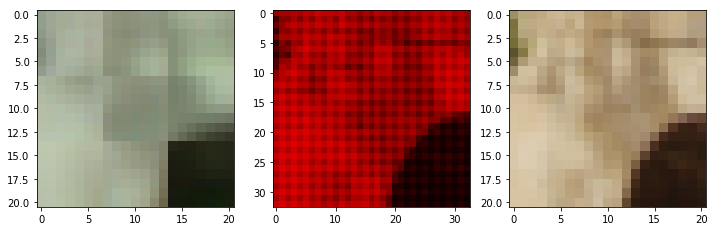

Epoch [221/500], Step [0/25], Loss: 0.02059122920036316
Epoch [221/500], Step [10/25], Loss: 0.01892785169184208
Epoch [221/500], Step [20/25], Loss: 0.020266162231564522

Finished Epoch 221, Loss --- mean: 0.020238642990589143, std 0.0006698110071376951



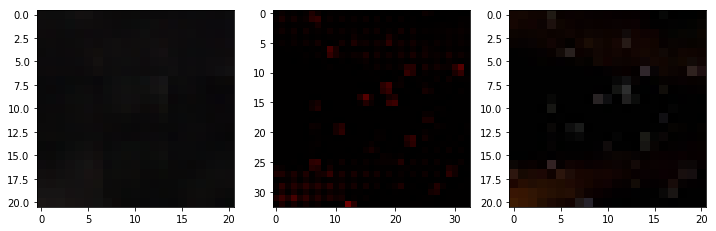

Epoch [222/500], Step [0/25], Loss: 0.019655046984553337
Epoch [222/500], Step [10/25], Loss: 0.019773125648498535
Epoch [222/500], Step [20/25], Loss: 0.020481495186686516

Finished Epoch 222, Loss --- mean: 0.02008346073329449, std 0.0007465814234587892



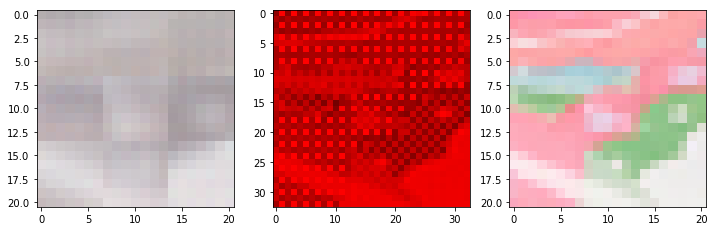

Epoch [223/500], Step [0/25], Loss: 0.02109437994658947
Epoch [223/500], Step [10/25], Loss: 0.020269764587283134
Epoch [223/500], Step [20/25], Loss: 0.019720986485481262

Finished Epoch 223, Loss --- mean: 0.019628065750002862, std 0.0009510347857523277



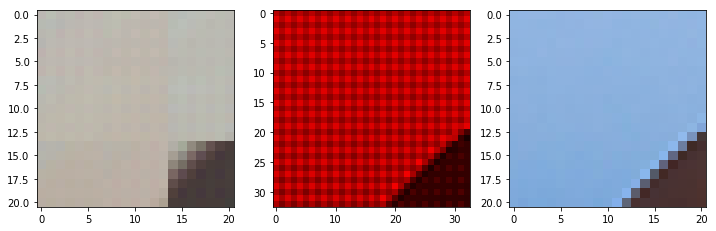

Epoch [224/500], Step [0/25], Loss: 0.02023353800177574
Epoch [224/500], Step [10/25], Loss: 0.01971285231411457
Epoch [224/500], Step [20/25], Loss: 0.02001432701945305

Finished Epoch 224, Loss --- mean: 0.019863880649209024, std 0.0010969952051855063



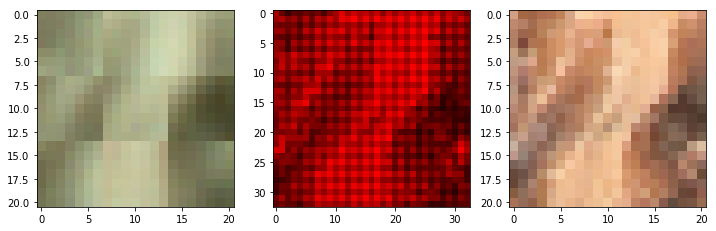

Epoch [225/500], Step [0/25], Loss: 0.018426254391670227
Epoch [225/500], Step [10/25], Loss: 0.019558554515242577
Epoch [225/500], Step [20/25], Loss: 0.01999525912106037

Finished Epoch 225, Loss --- mean: 0.01964040830731392, std 0.0007277658451916792



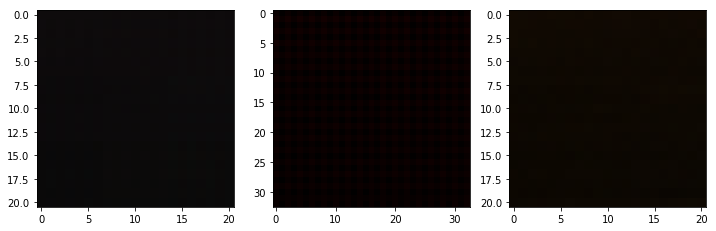

Epoch [226/500], Step [0/25], Loss: 0.019513139501214027
Epoch [226/500], Step [10/25], Loss: 0.02037249691784382
Epoch [226/500], Step [20/25], Loss: 0.019799526780843735

Finished Epoch 226, Loss --- mean: 0.01993566669523716, std 0.0008694144861207686



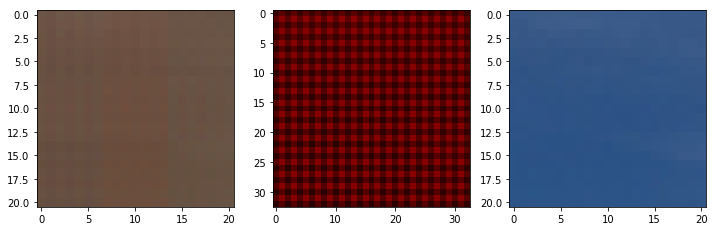

Epoch [227/500], Step [0/25], Loss: 0.020872514694929123
Epoch [227/500], Step [10/25], Loss: 0.021249983459711075
Epoch [227/500], Step [20/25], Loss: 0.019994841888546944

Finished Epoch 227, Loss --- mean: 0.019958711564540862, std 0.0008444957250567427



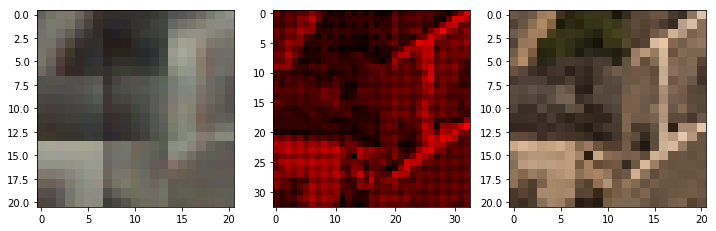

Epoch [228/500], Step [0/25], Loss: 0.01967519149184227
Epoch [228/500], Step [10/25], Loss: 0.019720586016774178
Epoch [228/500], Step [20/25], Loss: 0.019254878163337708

Finished Epoch 228, Loss --- mean: 0.020007156208157538, std 0.0011270084658041957



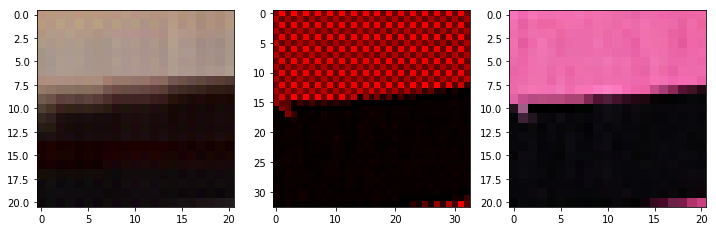

Epoch [229/500], Step [0/25], Loss: 0.020975938066840172
Epoch [229/500], Step [10/25], Loss: 0.0194007009267807
Epoch [229/500], Step [20/25], Loss: 0.01964903250336647

Finished Epoch 229, Loss --- mean: 0.019940153285861014, std 0.000796157031136789



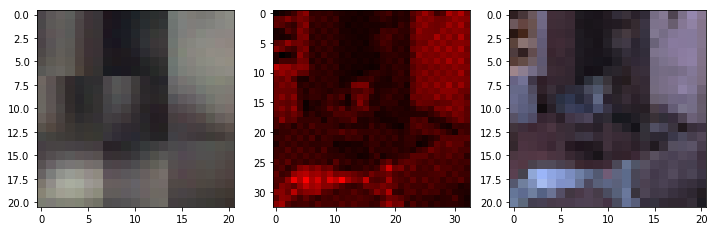

Epoch [230/500], Step [0/25], Loss: 0.02048068679869175
Epoch [230/500], Step [10/25], Loss: 0.019542230293154716
Epoch [230/500], Step [20/25], Loss: 0.018889017403125763

Finished Epoch 230, Loss --- mean: 0.019801071286201476, std 0.0007310938529187564



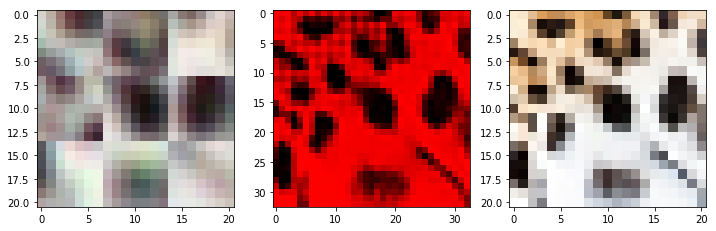

Epoch [231/500], Step [0/25], Loss: 0.018915416672825813
Epoch [231/500], Step [10/25], Loss: 0.018999651074409485
Epoch [231/500], Step [20/25], Loss: 0.01934131048619747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 231, Loss --- mean: 0.019577390998601913, std 0.0008879687758645595



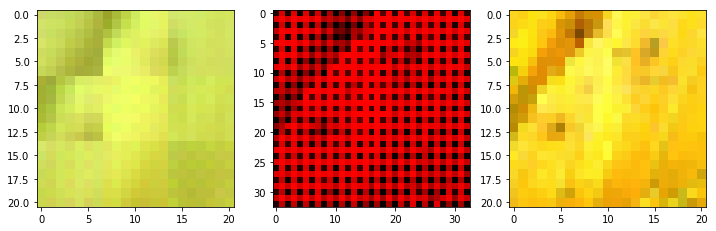

Epoch [232/500], Step [0/25], Loss: 0.019693648442626
Epoch [232/500], Step [10/25], Loss: 0.021323461085557938
Epoch [232/500], Step [20/25], Loss: 0.0195500198751688

Finished Epoch 232, Loss --- mean: 0.019837831184267997, std 0.0008604969732635077



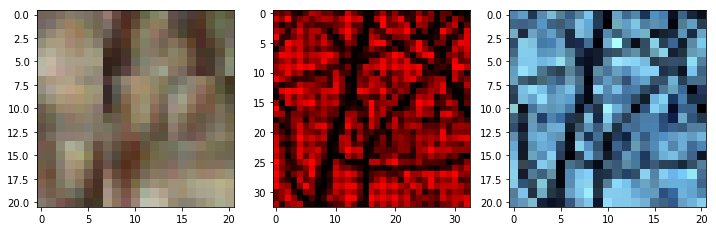

Epoch [233/500], Step [0/25], Loss: 0.020236780866980553
Epoch [233/500], Step [10/25], Loss: 0.01867307350039482
Epoch [233/500], Step [20/25], Loss: 0.01993396505713463

Finished Epoch 233, Loss --- mean: 0.019972371011972426, std 0.0009223174934504529



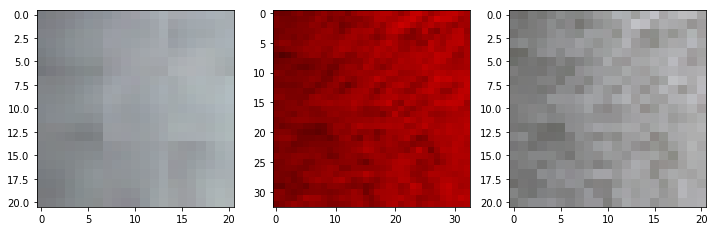

Epoch [234/500], Step [0/25], Loss: 0.021159186959266663
Epoch [234/500], Step [10/25], Loss: 0.020126765593886375
Epoch [234/500], Step [20/25], Loss: 0.018764633685350418

Finished Epoch 234, Loss --- mean: 0.01983705095946789, std 0.0007691831281080934



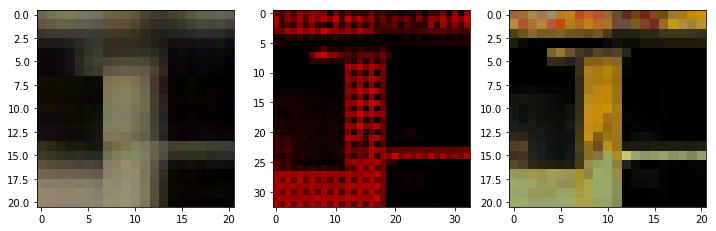

Epoch [235/500], Step [0/25], Loss: 0.01939600706100464
Epoch [235/500], Step [10/25], Loss: 0.019405491650104523
Epoch [235/500], Step [20/25], Loss: 0.019939851015806198

Finished Epoch 235, Loss --- mean: 0.01989125519990921, std 0.0007121183057408581



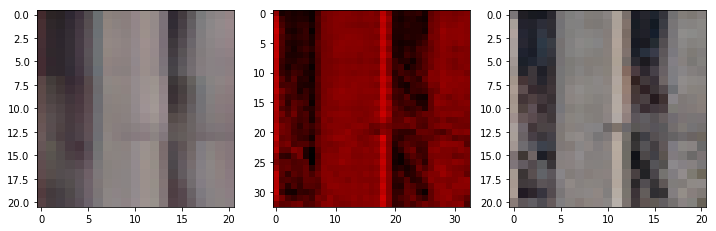

Epoch [236/500], Step [0/25], Loss: 0.020920703187584877
Epoch [236/500], Step [10/25], Loss: 0.019531559199094772
Epoch [236/500], Step [20/25], Loss: 0.020212633535265923

Finished Epoch 236, Loss --- mean: 0.01962507262825966, std 0.0008369573257316667



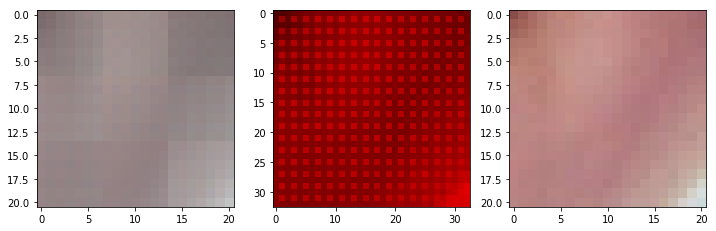

Epoch [237/500], Step [0/25], Loss: 0.020441608503460884
Epoch [237/500], Step [10/25], Loss: 0.02040332369506359
Epoch [237/500], Step [20/25], Loss: 0.020167145878076553

Finished Epoch 237, Loss --- mean: 0.020019154399633407, std 0.0007735565429492338



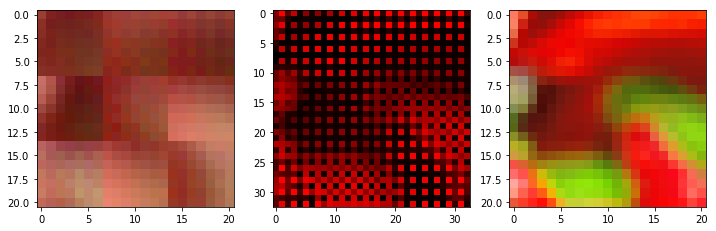

Epoch [238/500], Step [0/25], Loss: 0.020471397787332535
Epoch [238/500], Step [10/25], Loss: 0.018871556967496872
Epoch [238/500], Step [20/25], Loss: 0.01949445717036724

Finished Epoch 238, Loss --- mean: 0.01980816312134266, std 0.0009535429188434691



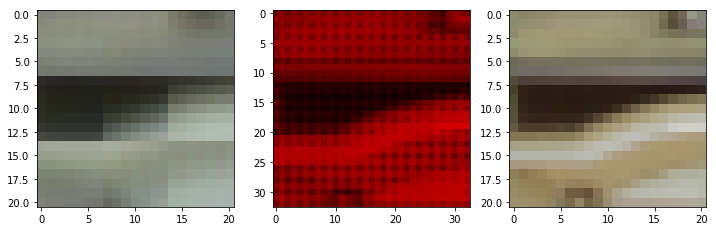

Epoch [239/500], Step [0/25], Loss: 0.019217599183321
Epoch [239/500], Step [10/25], Loss: 0.019495327025651932
Epoch [239/500], Step [20/25], Loss: 0.01996612921357155

Finished Epoch 239, Loss --- mean: 0.019594773799180985, std 0.0008798258653497518



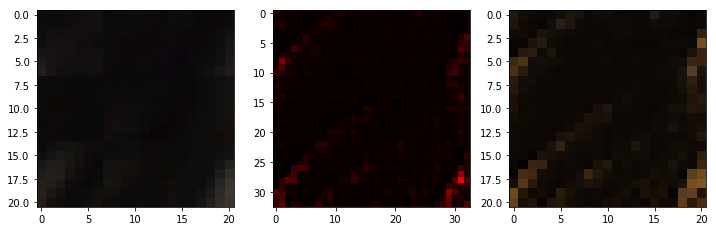

Epoch [240/500], Step [0/25], Loss: 0.01868736930191517
Epoch [240/500], Step [10/25], Loss: 0.019504563882946968
Epoch [240/500], Step [20/25], Loss: 0.020364167168736458

Finished Epoch 240, Loss --- mean: 0.019475897848606108, std 0.0008206556913246203



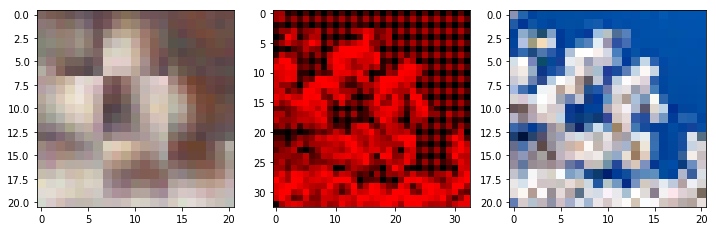

Epoch [241/500], Step [0/25], Loss: 0.018950864672660828
Epoch [241/500], Step [10/25], Loss: 0.019940292462706566
Epoch [241/500], Step [20/25], Loss: 0.018712522462010384

Finished Epoch 241, Loss --- mean: 0.019549624398350715, std 0.0008354521942284245



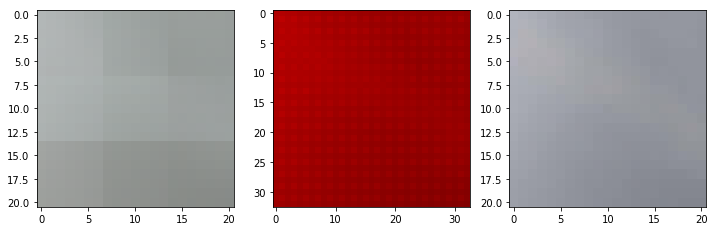

Epoch [242/500], Step [0/25], Loss: 0.01835060492157936
Epoch [242/500], Step [10/25], Loss: 0.01875576190650463
Epoch [242/500], Step [20/25], Loss: 0.018803464248776436

Finished Epoch 242, Loss --- mean: 0.01937465287744999, std 0.0007974074143951277



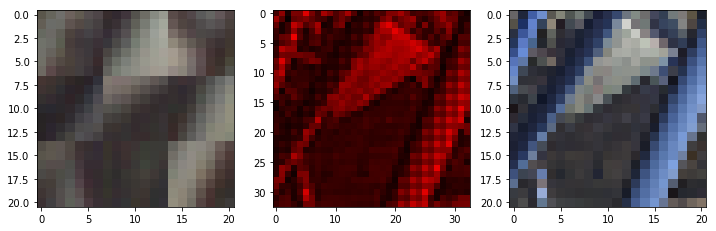

Epoch [243/500], Step [0/25], Loss: 0.01997183822095394
Epoch [243/500], Step [10/25], Loss: 0.01930403709411621
Epoch [243/500], Step [20/25], Loss: 0.02079041115939617

Finished Epoch 243, Loss --- mean: 0.02015993244946003, std 0.0010105289625648166



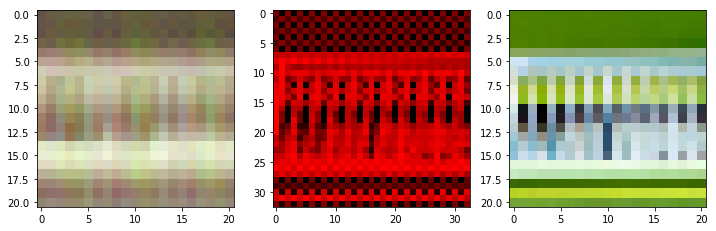

Epoch [244/500], Step [0/25], Loss: 0.020401878282427788
Epoch [244/500], Step [10/25], Loss: 0.020656181499361992
Epoch [244/500], Step [20/25], Loss: 0.021969035267829895

Finished Epoch 244, Loss --- mean: 0.020037439316511155, std 0.0008847374362756963



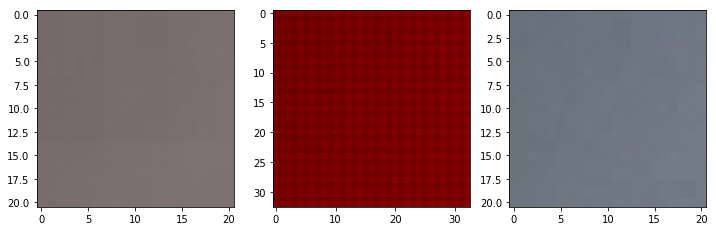

Epoch [245/500], Step [0/25], Loss: 0.02057655155658722
Epoch [245/500], Step [10/25], Loss: 0.0186301339417696
Epoch [245/500], Step [20/25], Loss: 0.019709305837750435

Finished Epoch 245, Loss --- mean: 0.019740132540464403, std 0.0007077829439843565



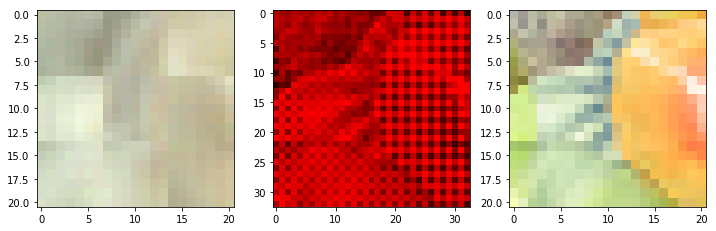

Epoch [246/500], Step [0/25], Loss: 0.01822800375521183
Epoch [246/500], Step [10/25], Loss: 0.021005375310778618
Epoch [246/500], Step [20/25], Loss: 0.019521281123161316

Finished Epoch 246, Loss --- mean: 0.01990907847881317, std 0.000836230835063968



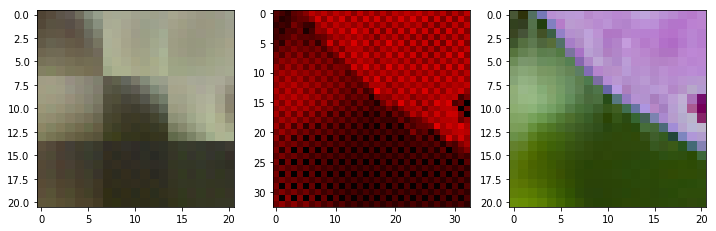

Epoch [247/500], Step [0/25], Loss: 0.020071811974048615
Epoch [247/500], Step [10/25], Loss: 0.01865398697555065
Epoch [247/500], Step [20/25], Loss: 0.019588280469179153

Finished Epoch 247, Loss --- mean: 0.01955174542963505, std 0.0007536178115011033



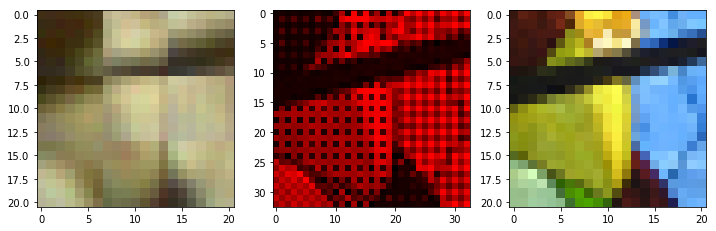

Epoch [248/500], Step [0/25], Loss: 0.018534185364842415
Epoch [248/500], Step [10/25], Loss: 0.018338346853852272
Epoch [248/500], Step [20/25], Loss: 0.01947091892361641

Finished Epoch 248, Loss --- mean: 0.019412965402007102, std 0.0008050856392837657



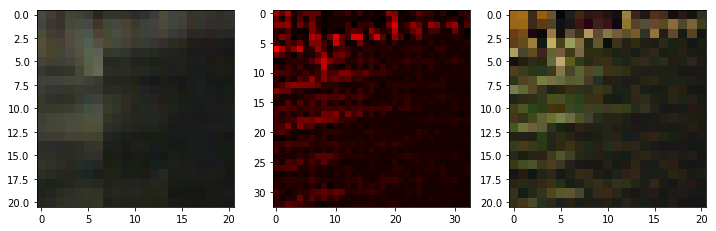

Epoch [249/500], Step [0/25], Loss: 0.019832506775856018
Epoch [249/500], Step [10/25], Loss: 0.01956585980951786
Epoch [249/500], Step [20/25], Loss: 0.02067849412560463

Finished Epoch 249, Loss --- mean: 0.019494909420609476, std 0.000808602214567433



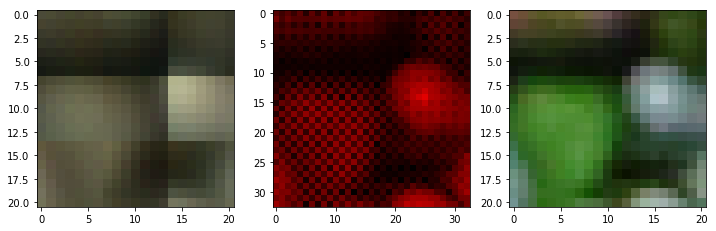

Epoch [250/500], Step [0/25], Loss: 0.021037831902503967
Epoch [250/500], Step [10/25], Loss: 0.01864015869796276
Epoch [250/500], Step [20/25], Loss: 0.017712224274873734

Finished Epoch 250, Loss --- mean: 0.019280247017741205, std 0.000834798684730715



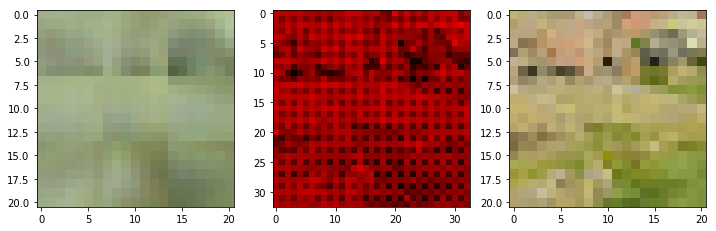

Epoch [251/500], Step [0/25], Loss: 0.01972595602273941
Epoch [251/500], Step [10/25], Loss: 0.018385907635092735
Epoch [251/500], Step [20/25], Loss: 0.019677629694342613

Finished Epoch 251, Loss --- mean: 0.019415378645062445, std 0.0005255519828804411



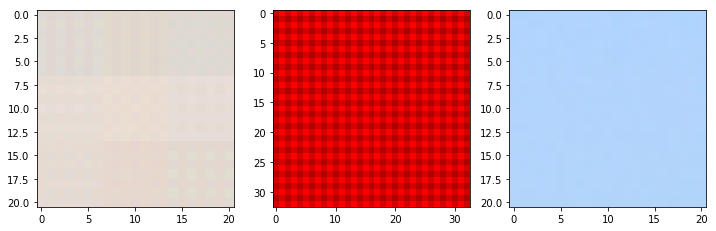

Epoch [252/500], Step [0/25], Loss: 0.019647181034088135
Epoch [252/500], Step [10/25], Loss: 0.020533982664346695
Epoch [252/500], Step [20/25], Loss: 0.019813554361462593

Finished Epoch 252, Loss --- mean: 0.020019421502947807, std 0.0006626540276976866



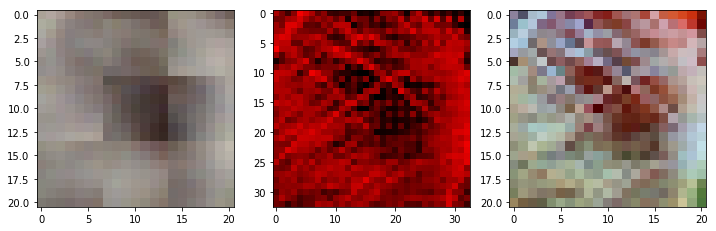

Epoch [253/500], Step [0/25], Loss: 0.01902920752763748
Epoch [253/500], Step [10/25], Loss: 0.020167874172329903
Epoch [253/500], Step [20/25], Loss: 0.019199062138795853

Finished Epoch 253, Loss --- mean: 0.020183523744344713, std 0.0008710995091247353



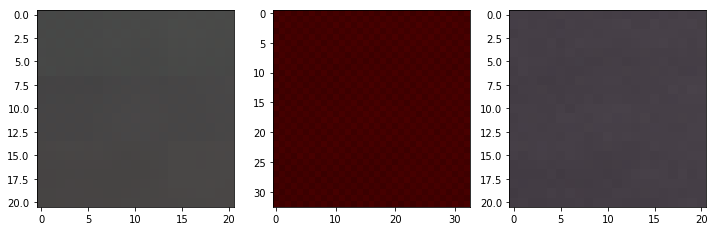

Epoch [254/500], Step [0/25], Loss: 0.020376263186335564
Epoch [254/500], Step [10/25], Loss: 0.021776758134365082
Epoch [254/500], Step [20/25], Loss: 0.019617753103375435

Finished Epoch 254, Loss --- mean: 0.019818703308701516, std 0.000740844134034092



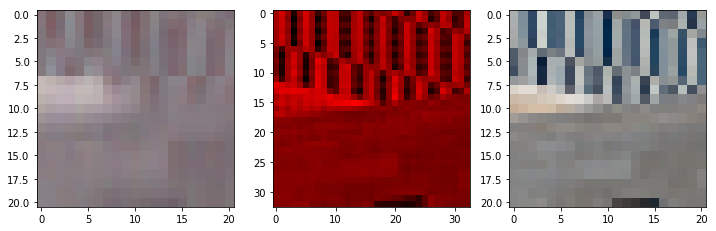

Epoch [255/500], Step [0/25], Loss: 0.017932482063770294
Epoch [255/500], Step [10/25], Loss: 0.020079441368579865
Epoch [255/500], Step [20/25], Loss: 0.019402893260121346

Finished Epoch 255, Loss --- mean: 0.019437780305743217, std 0.0008635559876041673



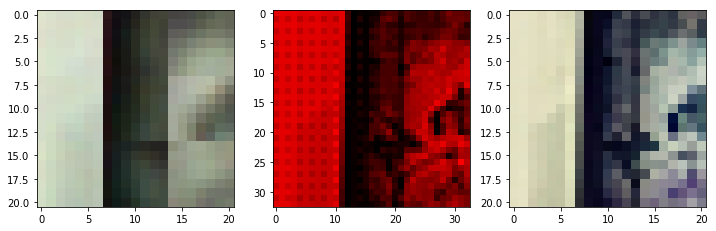

Epoch [256/500], Step [0/25], Loss: 0.019488194957375526
Epoch [256/500], Step [10/25], Loss: 0.020412389189004898
Epoch [256/500], Step [20/25], Loss: 0.019644323736429214

Finished Epoch 256, Loss --- mean: 0.01924310490489006, std 0.0009238292867967023



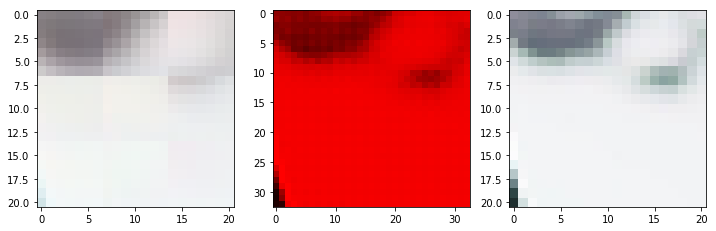

Epoch [257/500], Step [0/25], Loss: 0.018247349187731743
Epoch [257/500], Step [10/25], Loss: 0.019236788153648376
Epoch [257/500], Step [20/25], Loss: 0.020801477134227753

Finished Epoch 257, Loss --- mean: 0.019364002645015716, std 0.0009219804070624148



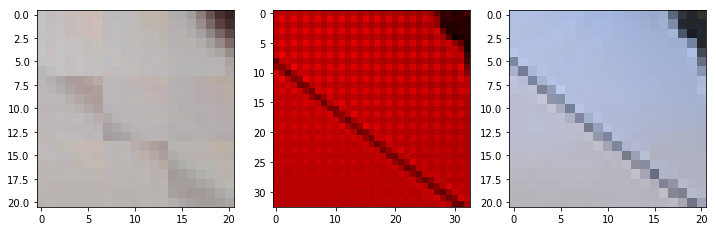

Epoch [258/500], Step [0/25], Loss: 0.019335143268108368
Epoch [258/500], Step [10/25], Loss: 0.019738081842660904
Epoch [258/500], Step [20/25], Loss: 0.01989850029349327

Finished Epoch 258, Loss --- mean: 0.019778257235884666, std 0.0004603757707267322



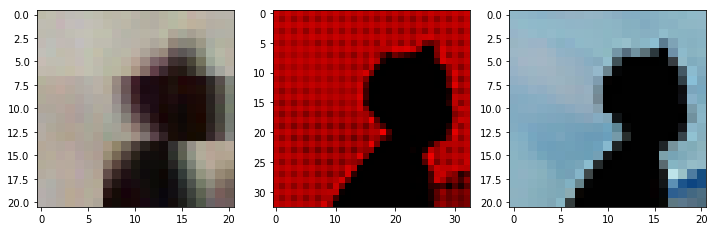

Epoch [259/500], Step [0/25], Loss: 0.0200180746614933
Epoch [259/500], Step [10/25], Loss: 0.020054716616868973
Epoch [259/500], Step [20/25], Loss: 0.02108580619096756

Finished Epoch 259, Loss --- mean: 0.019784291088581086, std 0.0007688269119858271



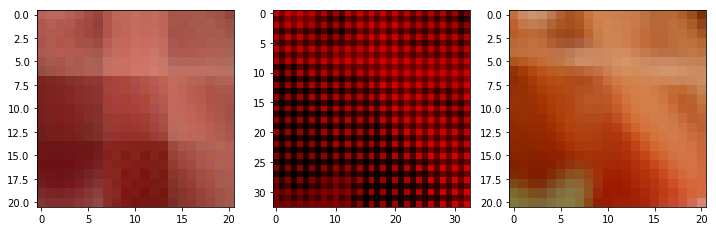

Epoch [260/500], Step [0/25], Loss: 0.02005620300769806
Epoch [260/500], Step [10/25], Loss: 0.019392814487218857
Epoch [260/500], Step [20/25], Loss: 0.020192589610815048

Finished Epoch 260, Loss --- mean: 0.01976300820708275, std 0.001070917658083506



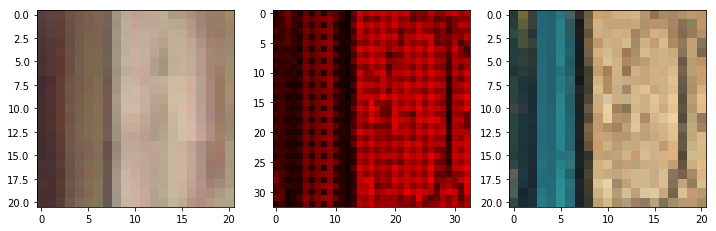

Epoch [261/500], Step [0/25], Loss: 0.02105090394616127
Epoch [261/500], Step [10/25], Loss: 0.019208433106541634
Epoch [261/500], Step [20/25], Loss: 0.018776414915919304

Finished Epoch 261, Loss --- mean: 0.019792122468352318, std 0.0012024513349231448



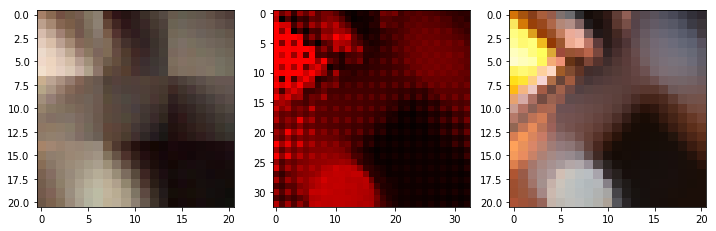

Epoch [262/500], Step [0/25], Loss: 0.018437424674630165
Epoch [262/500], Step [10/25], Loss: 0.019277993589639664
Epoch [262/500], Step [20/25], Loss: 0.01891644299030304

Finished Epoch 262, Loss --- mean: 0.01934030294418335, std 0.0008857577202761501



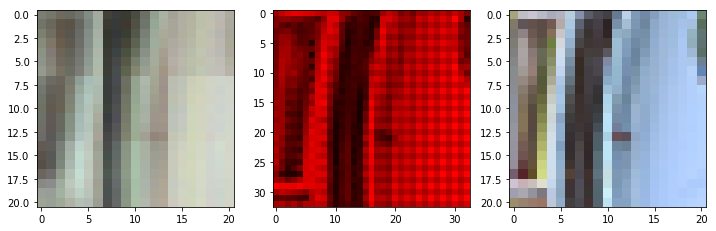

Epoch [263/500], Step [0/25], Loss: 0.01816854625940323
Epoch [263/500], Step [10/25], Loss: 0.0191350094974041
Epoch [263/500], Step [20/25], Loss: 0.019989585503935814

Finished Epoch 263, Loss --- mean: 0.019264680370688438, std 0.0008573428335705986



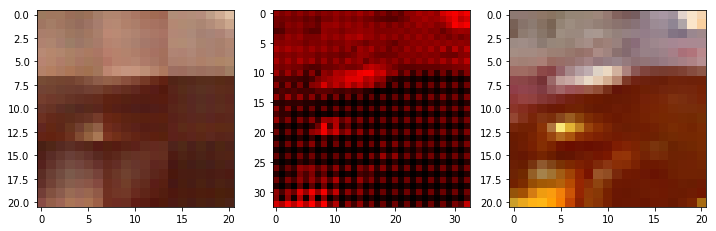

Epoch [264/500], Step [0/25], Loss: 0.019655806943774223
Epoch [264/500], Step [10/25], Loss: 0.019706467166543007
Epoch [264/500], Step [20/25], Loss: 0.019532745704054832

Finished Epoch 264, Loss --- mean: 0.019255139231681824, std 0.0007861648893647062



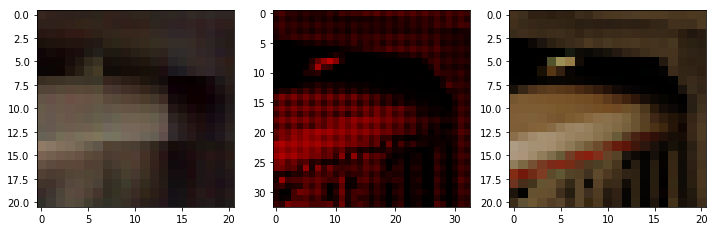

Epoch [265/500], Step [0/25], Loss: 0.019307026639580727
Epoch [265/500], Step [10/25], Loss: 0.019295601174235344
Epoch [265/500], Step [20/25], Loss: 0.019204379990696907

Finished Epoch 265, Loss --- mean: 0.01921043522655964, std 0.0006803256840238012



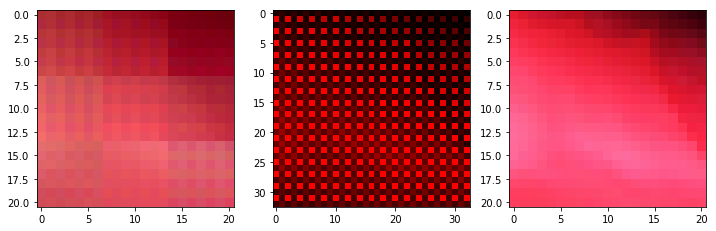

Epoch [266/500], Step [0/25], Loss: 0.01854073256254196
Epoch [266/500], Step [10/25], Loss: 0.02100139670073986
Epoch [266/500], Step [20/25], Loss: 0.019894791767001152

Finished Epoch 266, Loss --- mean: 0.019832438975572585, std 0.001017718820729976



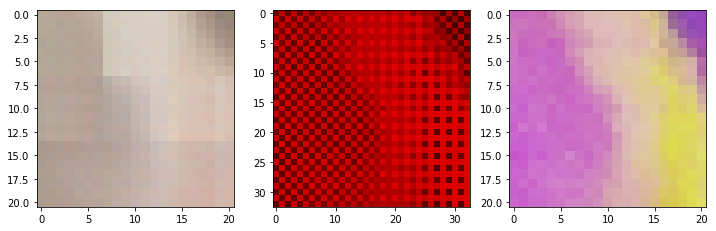

Epoch [267/500], Step [0/25], Loss: 0.021856509149074554
Epoch [267/500], Step [10/25], Loss: 0.02093963511288166
Epoch [267/500], Step [20/25], Loss: 0.019313598051667213

Finished Epoch 267, Loss --- mean: 0.020079961717128753, std 0.0010672073749177727



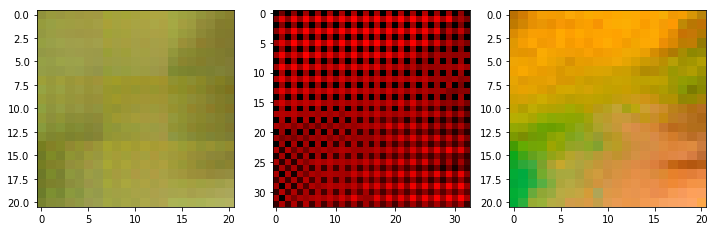

Epoch [268/500], Step [0/25], Loss: 0.019402535632252693
Epoch [268/500], Step [10/25], Loss: 0.01875983364880085
Epoch [268/500], Step [20/25], Loss: 0.01972263865172863

Finished Epoch 268, Loss --- mean: 0.019435791075229646, std 0.0009247218236285489



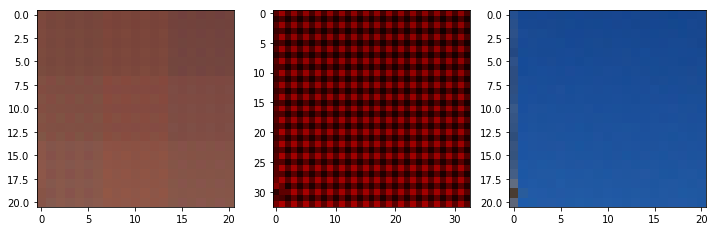

Epoch [269/500], Step [0/25], Loss: 0.020637407898902893
Epoch [269/500], Step [10/25], Loss: 0.018752241507172585
Epoch [269/500], Step [20/25], Loss: 0.020282365381717682

Finished Epoch 269, Loss --- mean: 0.01957470439374447, std 0.0009170542979701217



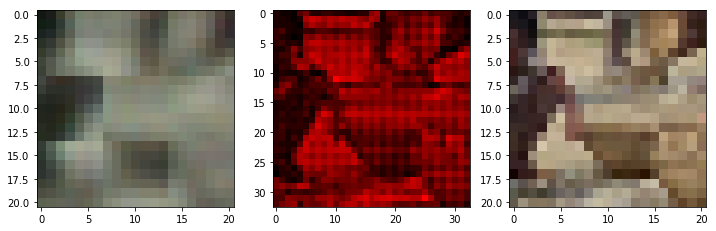

Epoch [270/500], Step [0/25], Loss: 0.018800601363182068
Epoch [270/500], Step [10/25], Loss: 0.018781397491693497
Epoch [270/500], Step [20/25], Loss: 0.019003210589289665

Finished Epoch 270, Loss --- mean: 0.019545016959309578, std 0.0009498859865633491



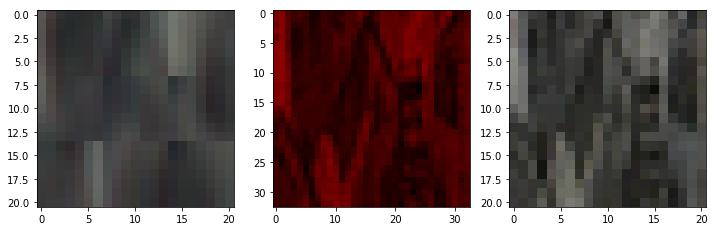

Epoch [271/500], Step [0/25], Loss: 0.02059156820178032
Epoch [271/500], Step [10/25], Loss: 0.019211318343877792
Epoch [271/500], Step [20/25], Loss: 0.01925545185804367

Finished Epoch 271, Loss --- mean: 0.019623642042279243, std 0.0008542070604299497



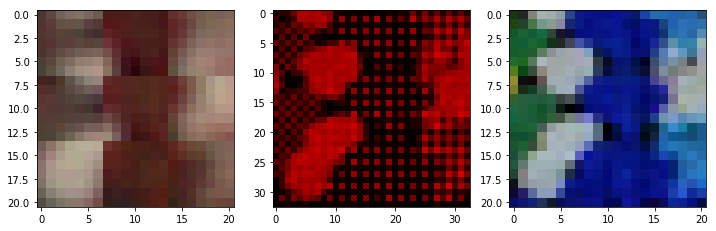

Epoch [272/500], Step [0/25], Loss: 0.01868436485528946
Epoch [272/500], Step [10/25], Loss: 0.0190264955163002
Epoch [272/500], Step [20/25], Loss: 0.018519019708037376

Finished Epoch 272, Loss --- mean: 0.019522747248411177, std 0.0008109815031006611



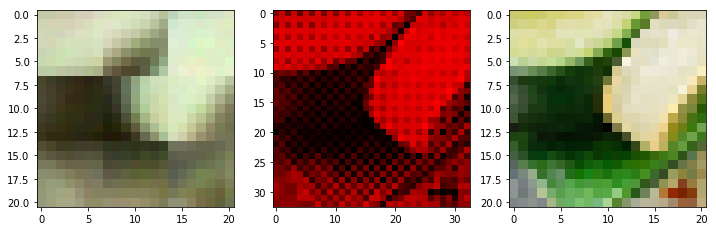

Epoch [273/500], Step [0/25], Loss: 0.018487928435206413
Epoch [273/500], Step [10/25], Loss: 0.019727129489183426
Epoch [273/500], Step [20/25], Loss: 0.019947469234466553

Finished Epoch 273, Loss --- mean: 0.019348531141877175, std 0.0006676576283977025



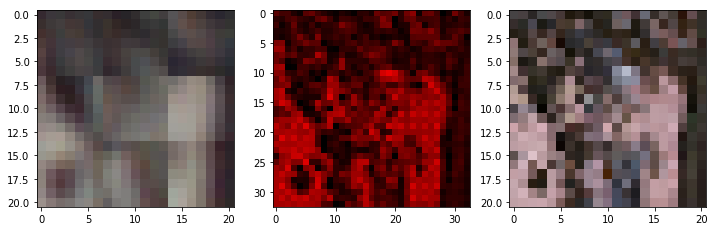

Epoch [274/500], Step [0/25], Loss: 0.019082356244325638
Epoch [274/500], Step [10/25], Loss: 0.018925298005342484
Epoch [274/500], Step [20/25], Loss: 0.01858414337038994

Finished Epoch 274, Loss --- mean: 0.01926767058670521, std 0.0009335706414923089



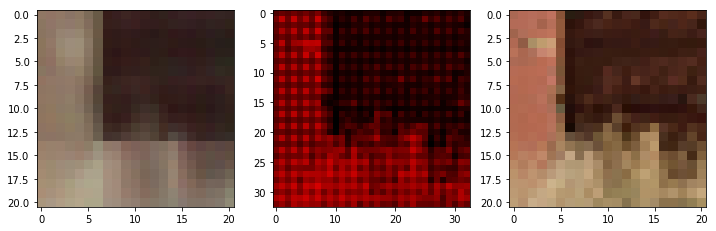

Epoch [275/500], Step [0/25], Loss: 0.0188837219029665
Epoch [275/500], Step [10/25], Loss: 0.02052546665072441
Epoch [275/500], Step [20/25], Loss: 0.018546124920248985

Finished Epoch 275, Loss --- mean: 0.019313219636678695, std 0.0009091196333371448



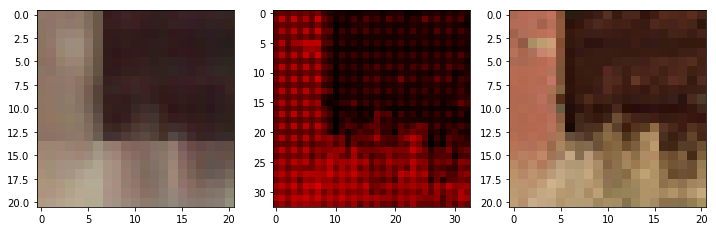

Epoch [276/500], Step [0/25], Loss: 0.019015680998563766
Epoch [276/500], Step [10/25], Loss: 0.019749091938138008
Epoch [276/500], Step [20/25], Loss: 0.020942848175764084

Finished Epoch 276, Loss --- mean: 0.019547391906380652, std 0.0007118042856801923



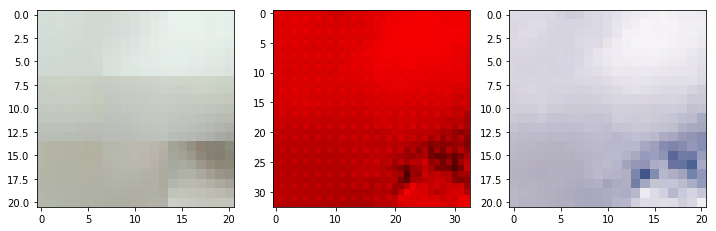

Epoch [277/500], Step [0/25], Loss: 0.02126062475144863
Epoch [277/500], Step [10/25], Loss: 0.019597282633185387
Epoch [277/500], Step [20/25], Loss: 0.020179178565740585

Finished Epoch 277, Loss --- mean: 0.019696733206510542, std 0.0008343575917167338



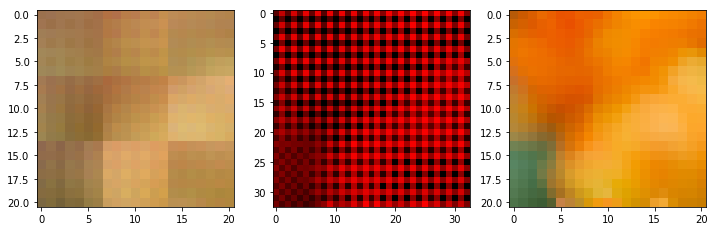

Epoch [278/500], Step [0/25], Loss: 0.019672047346830368
Epoch [278/500], Step [10/25], Loss: 0.019601313397288322
Epoch [278/500], Step [20/25], Loss: 0.021182620897889137

Finished Epoch 278, Loss --- mean: 0.019862690046429633, std 0.0008831662108029784



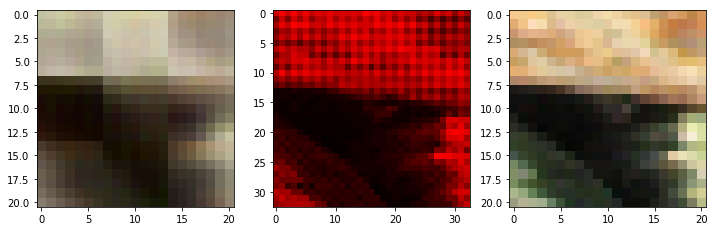

Epoch [279/500], Step [0/25], Loss: 0.018948858603835106
Epoch [279/500], Step [10/25], Loss: 0.020821690559387207
Epoch [279/500], Step [20/25], Loss: 0.018354129046201706

Finished Epoch 279, Loss --- mean: 0.01963059455156326, std 0.0008478431593523988



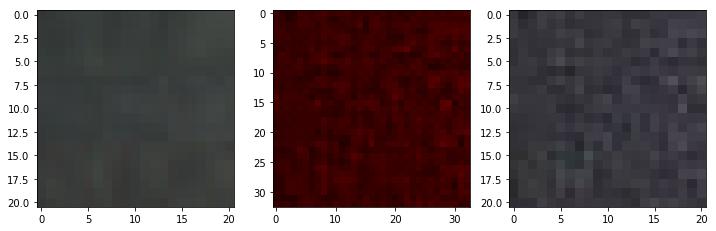

Epoch [280/500], Step [0/25], Loss: 0.018920429050922394
Epoch [280/500], Step [10/25], Loss: 0.01776784285902977
Epoch [280/500], Step [20/25], Loss: 0.019068371504545212

Finished Epoch 280, Loss --- mean: 0.019274588972330094, std 0.0006445187818808607



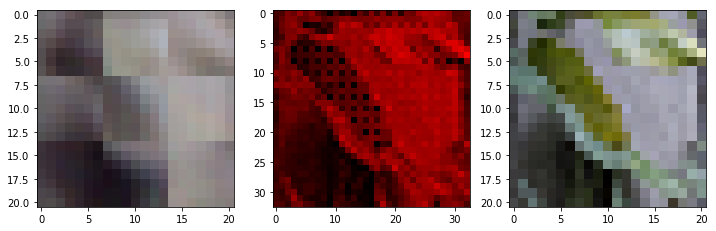

Epoch [281/500], Step [0/25], Loss: 0.019493740051984787
Epoch [281/500], Step [10/25], Loss: 0.019867047667503357
Epoch [281/500], Step [20/25], Loss: 0.019604351371526718

Finished Epoch 281, Loss --- mean: 0.01917468264698982, std 0.0008064828391643266



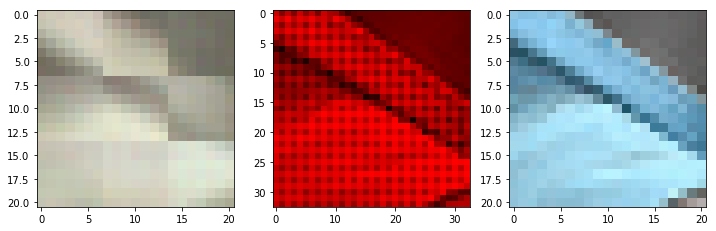

Epoch [282/500], Step [0/25], Loss: 0.018093930557370186
Epoch [282/500], Step [10/25], Loss: 0.019356852397322655
Epoch [282/500], Step [20/25], Loss: 0.019371479749679565

Finished Epoch 282, Loss --- mean: 0.01926038011908531, std 0.0007356144007286922



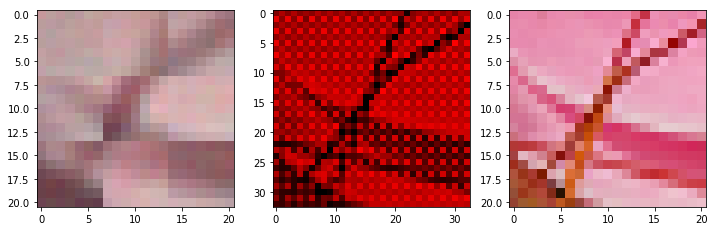

Epoch [283/500], Step [0/25], Loss: 0.01917744241654873
Epoch [283/500], Step [10/25], Loss: 0.019259175285696983
Epoch [283/500], Step [20/25], Loss: 0.02067074179649353

Finished Epoch 283, Loss --- mean: 0.019671687558293342, std 0.0009011988880034884



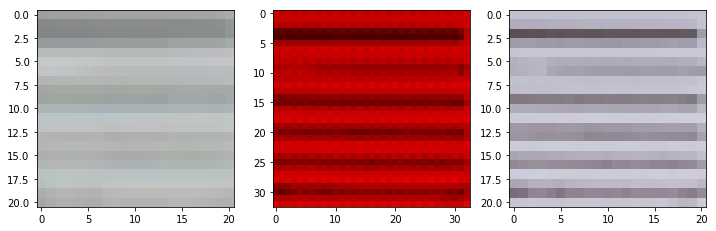

Epoch [284/500], Step [0/25], Loss: 0.02015909180045128
Epoch [284/500], Step [10/25], Loss: 0.01962895505130291
Epoch [284/500], Step [20/25], Loss: 0.02098156325519085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 284, Loss --- mean: 0.019605791792273522, std 0.000715585432657624



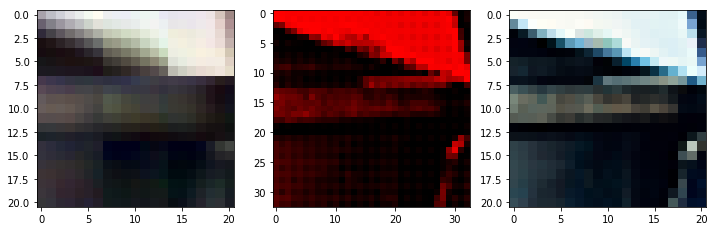

Epoch [285/500], Step [0/25], Loss: 0.019800329580903053
Epoch [285/500], Step [10/25], Loss: 0.02023875154554844
Epoch [285/500], Step [20/25], Loss: 0.019499950110912323

Finished Epoch 285, Loss --- mean: 0.01912391185760498, std 0.0007975624636574384



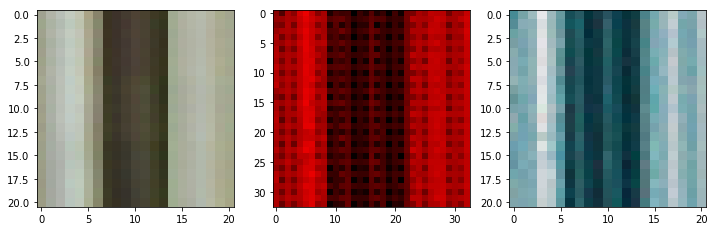

Epoch [286/500], Step [0/25], Loss: 0.01778709702193737
Epoch [286/500], Step [10/25], Loss: 0.02005835995078087
Epoch [286/500], Step [20/25], Loss: 0.018562020733952522

Finished Epoch 286, Loss --- mean: 0.019242844954133035, std 0.0006511574592675933



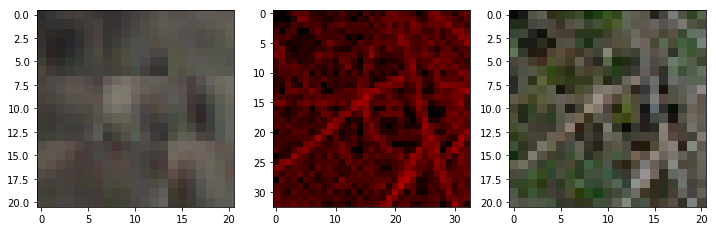

Epoch [287/500], Step [0/25], Loss: 0.020509427413344383
Epoch [287/500], Step [10/25], Loss: 0.019219379872083664
Epoch [287/500], Step [20/25], Loss: 0.019800737500190735

Finished Epoch 287, Loss --- mean: 0.019459194988012313, std 0.0009190829084623822



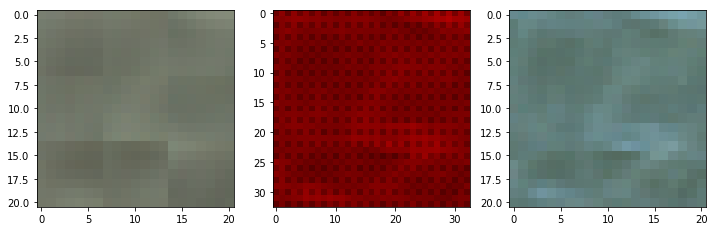

Epoch [288/500], Step [0/25], Loss: 0.01982290670275688
Epoch [288/500], Step [10/25], Loss: 0.018233811482787132
Epoch [288/500], Step [20/25], Loss: 0.019664322957396507


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 288, Loss --- mean: 0.019662620425224306, std 0.0009190155348542137



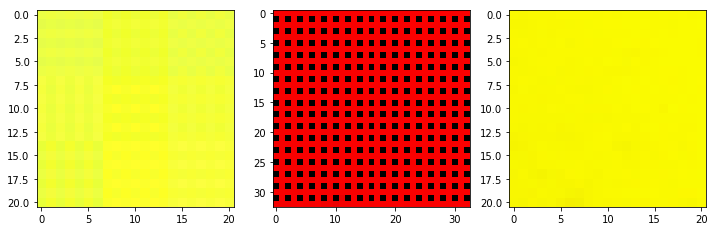

Epoch [289/500], Step [0/25], Loss: 0.020661169663071632
Epoch [289/500], Step [10/25], Loss: 0.01857924461364746
Epoch [289/500], Step [20/25], Loss: 0.018919402733445168

Finished Epoch 289, Loss --- mean: 0.019654758870601655, std 0.000907636340810777



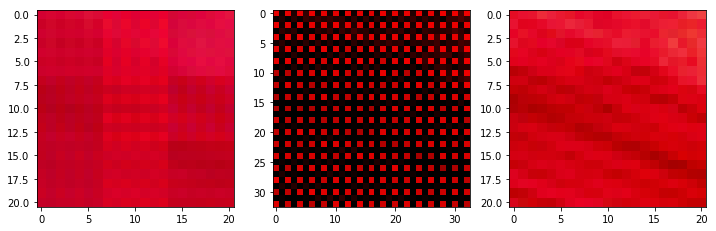

Epoch [290/500], Step [0/25], Loss: 0.01897362433373928
Epoch [290/500], Step [10/25], Loss: 0.02037353813648224
Epoch [290/500], Step [20/25], Loss: 0.01956801675260067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 290, Loss --- mean: 0.019410867244005203, std 0.0007558167336126634



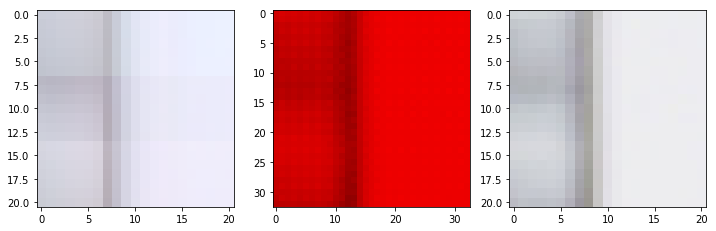

Epoch [291/500], Step [0/25], Loss: 0.020846206694841385
Epoch [291/500], Step [10/25], Loss: 0.019544294103980064
Epoch [291/500], Step [20/25], Loss: 0.019289931282401085

Finished Epoch 291, Loss --- mean: 0.019408961683511736, std 0.0006282106367475131



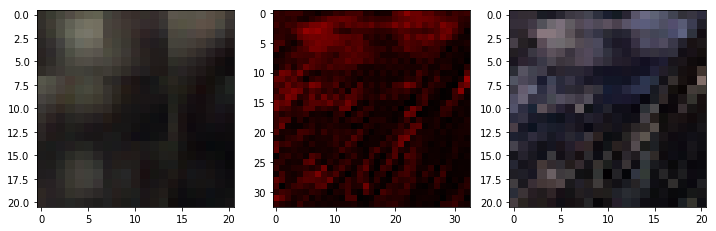

Epoch [292/500], Step [0/25], Loss: 0.01976894401013851
Epoch [292/500], Step [10/25], Loss: 0.018533028662204742
Epoch [292/500], Step [20/25], Loss: 0.01882310025393963

Finished Epoch 292, Loss --- mean: 0.019441257640719415, std 0.0009663717246881386



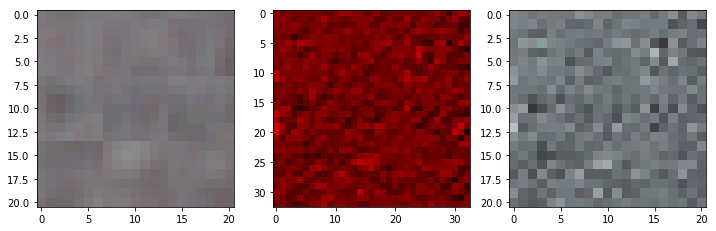

Epoch [293/500], Step [0/25], Loss: 0.01898672804236412
Epoch [293/500], Step [10/25], Loss: 0.01983315497636795
Epoch [293/500], Step [20/25], Loss: 0.020137902349233627

Finished Epoch 293, Loss --- mean: 0.019323276802897454, std 0.0009227053676009423



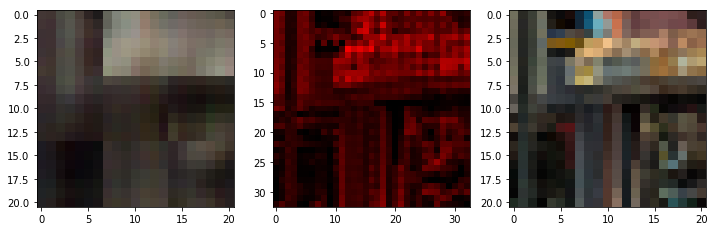

Epoch [294/500], Step [0/25], Loss: 0.017935140058398247
Epoch [294/500], Step [10/25], Loss: 0.01949261873960495
Epoch [294/500], Step [20/25], Loss: 0.01892085373401642

Finished Epoch 294, Loss --- mean: 0.019290808737277985, std 0.0008758662126657232



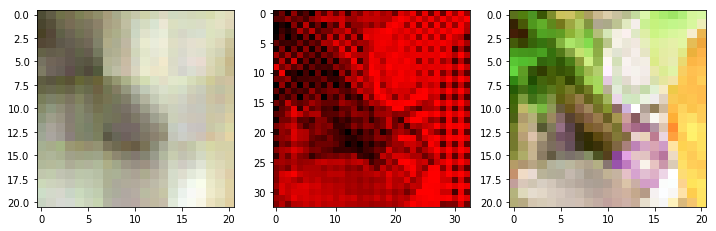

Epoch [295/500], Step [0/25], Loss: 0.019354337826371193
Epoch [295/500], Step [10/25], Loss: 0.0181138813495636
Epoch [295/500], Step [20/25], Loss: 0.020509855821728706

Finished Epoch 295, Loss --- mean: 0.019221092239022255, std 0.0007963002713186583



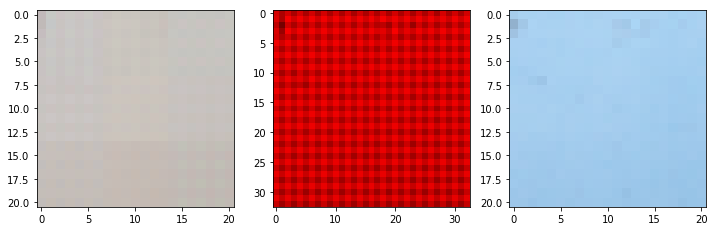

Epoch [296/500], Step [0/25], Loss: 0.02066805027425289
Epoch [296/500], Step [10/25], Loss: 0.017953837290406227
Epoch [296/500], Step [20/25], Loss: 0.018405230715870857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 296, Loss --- mean: 0.019571143984794617, std 0.0008778364340591896



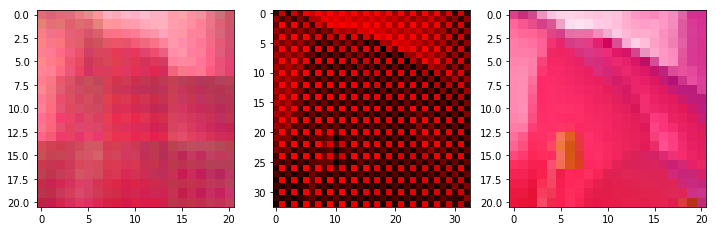

Epoch [297/500], Step [0/25], Loss: 0.020865632221102715
Epoch [297/500], Step [10/25], Loss: 0.01933390647172928
Epoch [297/500], Step [20/25], Loss: 0.019673271104693413

Finished Epoch 297, Loss --- mean: 0.01947995163500309, std 0.0008232181299016873



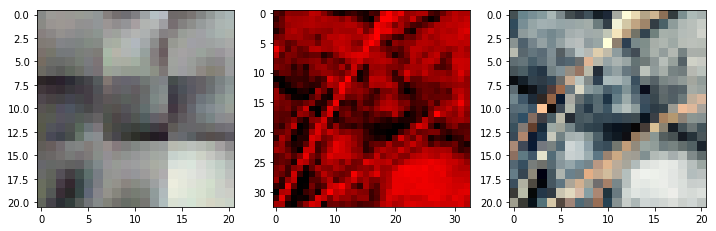

Epoch [298/500], Step [0/25], Loss: 0.019569190219044685
Epoch [298/500], Step [10/25], Loss: 0.01949452795088291
Epoch [298/500], Step [20/25], Loss: 0.019176719710230827

Finished Epoch 298, Loss --- mean: 0.01919725976884365, std 0.0007025675241968863



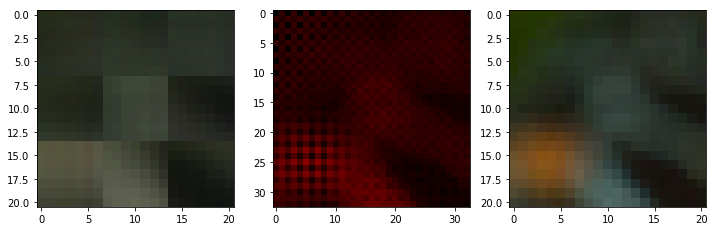

Epoch [299/500], Step [0/25], Loss: 0.01738196425139904
Epoch [299/500], Step [10/25], Loss: 0.01773199811577797
Epoch [299/500], Step [20/25], Loss: 0.01908719912171364

Finished Epoch 299, Loss --- mean: 0.01899180218577385, std 0.0007733692648050881



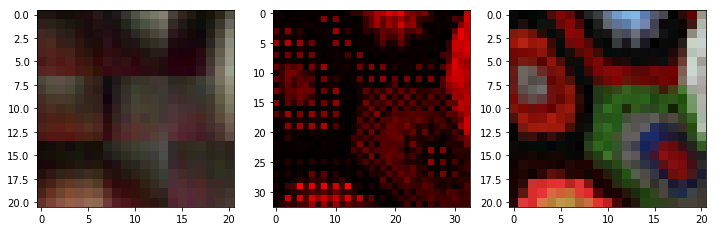

Epoch [300/500], Step [0/25], Loss: 0.018805591389536858
Epoch [300/500], Step [10/25], Loss: 0.018695464357733727
Epoch [300/500], Step [20/25], Loss: 0.018394455313682556

Finished Epoch 300, Loss --- mean: 0.019194761216640474, std 0.001007869021367487



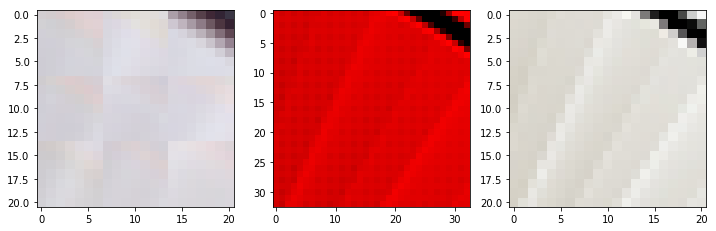

Epoch [301/500], Step [0/25], Loss: 0.01870596408843994
Epoch [301/500], Step [10/25], Loss: 0.019469108432531357
Epoch [301/500], Step [20/25], Loss: 0.019035156816244125

Finished Epoch 301, Loss --- mean: 0.019055818021297456, std 0.0006569933677886558



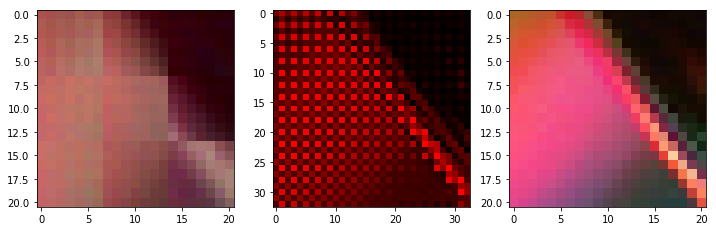

Epoch [302/500], Step [0/25], Loss: 0.018652595579624176
Epoch [302/500], Step [10/25], Loss: 0.018413517624139786
Epoch [302/500], Step [20/25], Loss: 0.019374031573534012

Finished Epoch 302, Loss --- mean: 0.0191562619805336, std 0.0009668517251259468



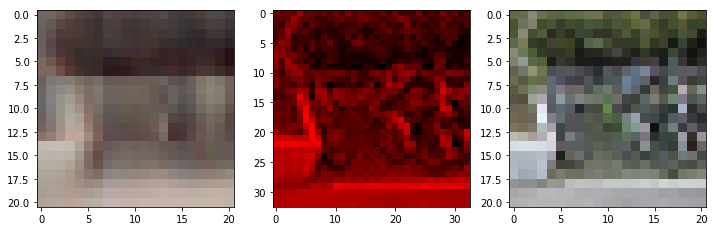

Epoch [303/500], Step [0/25], Loss: 0.019456911832094193
Epoch [303/500], Step [10/25], Loss: 0.019532164558768272
Epoch [303/500], Step [20/25], Loss: 0.018913276493549347

Finished Epoch 303, Loss --- mean: 0.01904067851603031, std 0.0007705512426052024



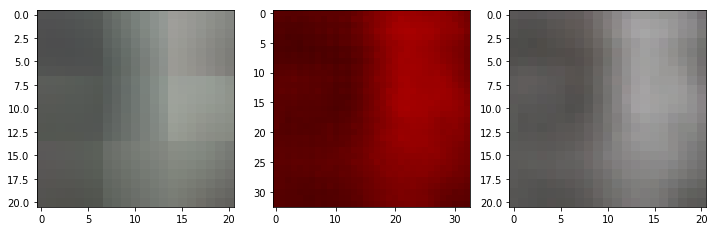

Epoch [304/500], Step [0/25], Loss: 0.0190897099673748
Epoch [304/500], Step [10/25], Loss: 0.01910274103283882
Epoch [304/500], Step [20/25], Loss: 0.018680976703763008

Finished Epoch 304, Loss --- mean: 0.019545704945921897, std 0.0010096778975382471



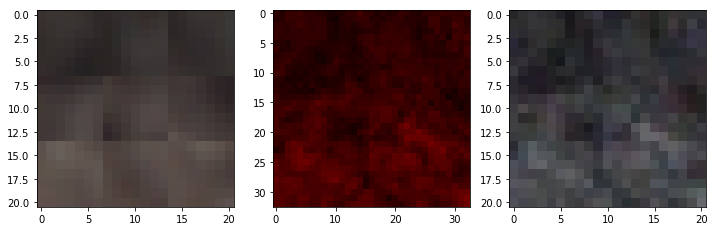

Epoch [305/500], Step [0/25], Loss: 0.019414663314819336
Epoch [305/500], Step [10/25], Loss: 0.019986344501376152
Epoch [305/500], Step [20/25], Loss: 0.0202095415443182

Finished Epoch 305, Loss --- mean: 0.020049953535199165, std 0.0006112496756447619



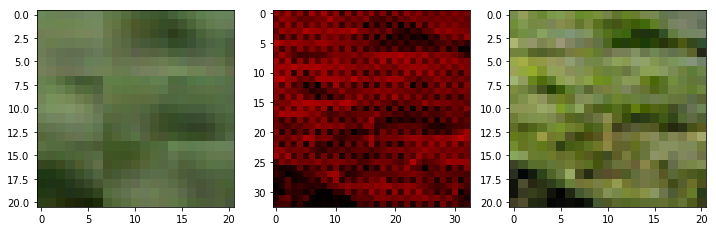

Epoch [306/500], Step [0/25], Loss: 0.01879364252090454
Epoch [306/500], Step [10/25], Loss: 0.01906902901828289
Epoch [306/500], Step [20/25], Loss: 0.01834394410252571

Finished Epoch 306, Loss --- mean: 0.01947364203631878, std 0.0009570644870579351



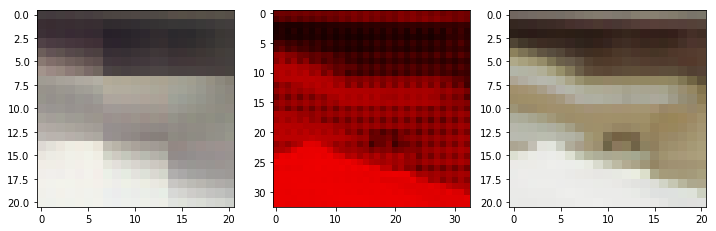

Epoch [307/500], Step [0/25], Loss: 0.02044171653687954
Epoch [307/500], Step [10/25], Loss: 0.02016143687069416
Epoch [307/500], Step [20/25], Loss: 0.01989920623600483

Finished Epoch 307, Loss --- mean: 0.019271300062537192, std 0.0008168410780639666



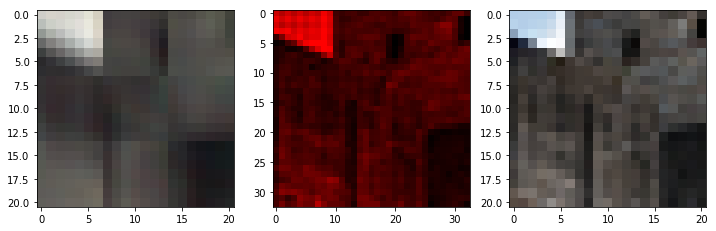

Epoch [308/500], Step [0/25], Loss: 0.019757099449634552
Epoch [308/500], Step [10/25], Loss: 0.020351503044366837
Epoch [308/500], Step [20/25], Loss: 0.018679440021514893

Finished Epoch 308, Loss --- mean: 0.01943315103650093, std 0.000727530577396801



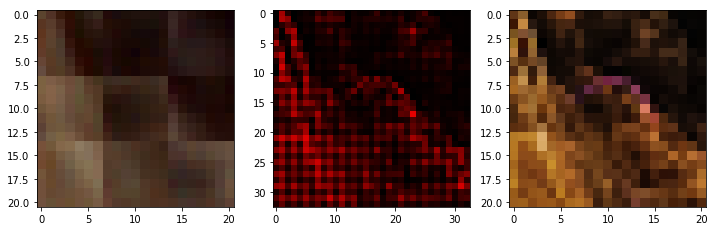

Epoch [309/500], Step [0/25], Loss: 0.019883891567587852
Epoch [309/500], Step [10/25], Loss: 0.020042236894369125
Epoch [309/500], Step [20/25], Loss: 0.018904857337474823

Finished Epoch 309, Loss --- mean: 0.019259801805019378, std 0.0007280580014251938



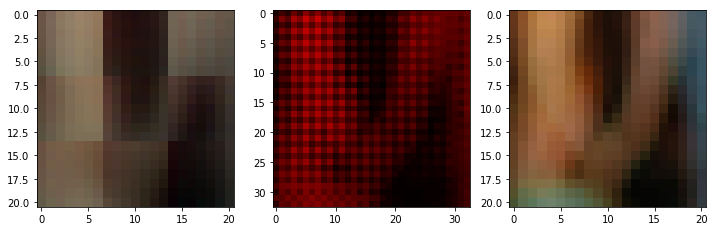

Epoch [310/500], Step [0/25], Loss: 0.019287539646029472
Epoch [310/500], Step [10/25], Loss: 0.020296910777688026
Epoch [310/500], Step [20/25], Loss: 0.019860241562128067

Finished Epoch 310, Loss --- mean: 0.019239787831902503, std 0.0007471854483907202



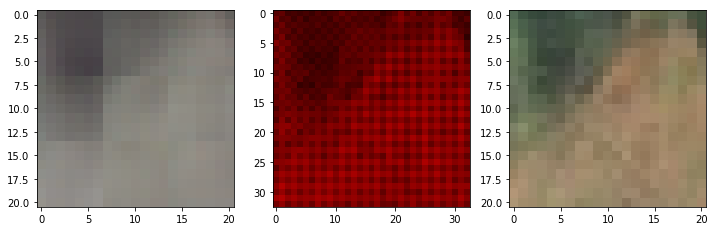

Epoch [311/500], Step [0/25], Loss: 0.019945092499256134
Epoch [311/500], Step [10/25], Loss: 0.020738929510116577
Epoch [311/500], Step [20/25], Loss: 0.018545059487223625

Finished Epoch 311, Loss --- mean: 0.019472688212990762, std 0.0006841570911992702



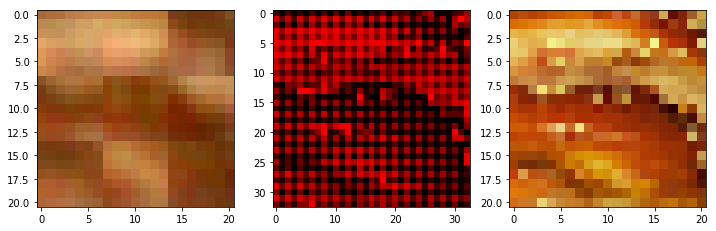

Epoch [312/500], Step [0/25], Loss: 0.019933678209781647
Epoch [312/500], Step [10/25], Loss: 0.020632019266486168
Epoch [312/500], Step [20/25], Loss: 0.018580207601189613

Finished Epoch 312, Loss --- mean: 0.019358506575226784, std 0.0008324739122169925



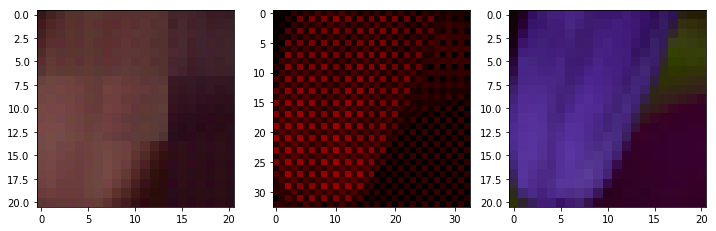

Epoch [313/500], Step [0/25], Loss: 0.019841695204377174
Epoch [313/500], Step [10/25], Loss: 0.018349861726164818
Epoch [313/500], Step [20/25], Loss: 0.019955119118094444

Finished Epoch 313, Loss --- mean: 0.019064067974686624, std 0.0006188688585592108



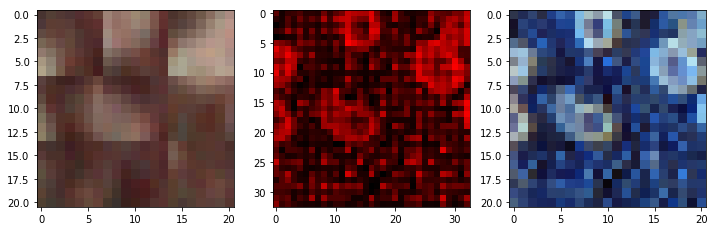

Epoch [314/500], Step [0/25], Loss: 0.019955307245254517
Epoch [314/500], Step [10/25], Loss: 0.018438240513205528
Epoch [314/500], Step [20/25], Loss: 0.0173909030854702

Finished Epoch 314, Loss --- mean: 0.01910768561065197, std 0.0009758692029427501



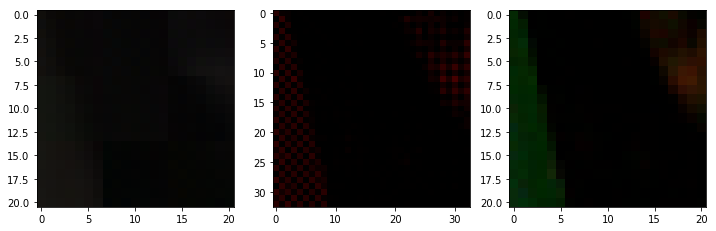

Epoch [315/500], Step [0/25], Loss: 0.01966884359717369
Epoch [315/500], Step [10/25], Loss: 0.019607307389378548
Epoch [315/500], Step [20/25], Loss: 0.020143060013651848

Finished Epoch 315, Loss --- mean: 0.019070981666445733, std 0.0008238386252892861



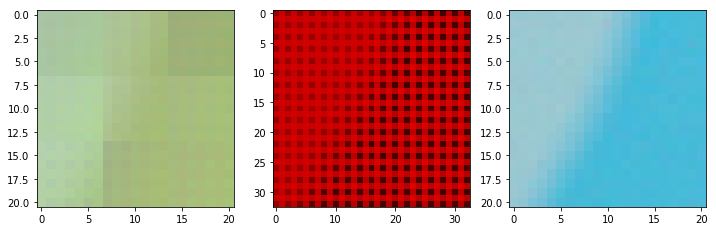

Epoch [316/500], Step [0/25], Loss: 0.019960610195994377
Epoch [316/500], Step [10/25], Loss: 0.019447635859251022
Epoch [316/500], Step [20/25], Loss: 0.02034798450767994

Finished Epoch 316, Loss --- mean: 0.019328618347644808, std 0.0011057458326449836



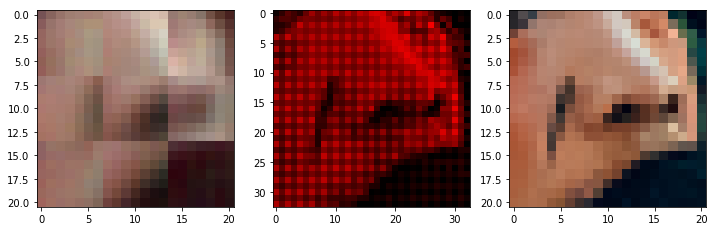

Epoch [317/500], Step [0/25], Loss: 0.01855257898569107
Epoch [317/500], Step [10/25], Loss: 0.020486630499362946
Epoch [317/500], Step [20/25], Loss: 0.020594725385308266

Finished Epoch 317, Loss --- mean: 0.019579157009720804, std 0.0010183422568462018



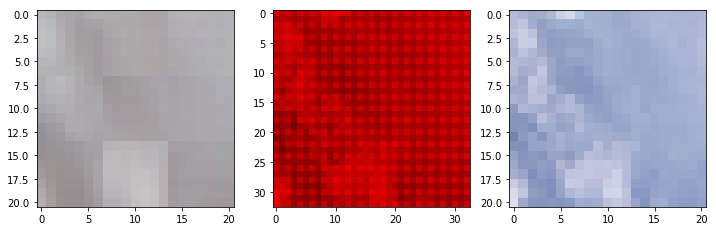

Epoch [318/500], Step [0/25], Loss: 0.019909657537937164
Epoch [318/500], Step [10/25], Loss: 0.019342808052897453
Epoch [318/500], Step [20/25], Loss: 0.020237689837813377

Finished Epoch 318, Loss --- mean: 0.019586353302001952, std 0.0011496849869387733



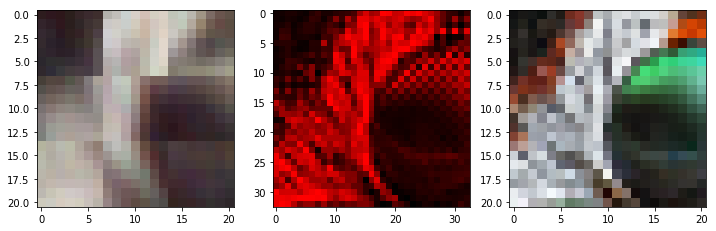

Epoch [319/500], Step [0/25], Loss: 0.021072428673505783
Epoch [319/500], Step [10/25], Loss: 0.017901329323649406
Epoch [319/500], Step [20/25], Loss: 0.019595656543970108

Finished Epoch 319, Loss --- mean: 0.01904135785996914, std 0.0008686190303592757



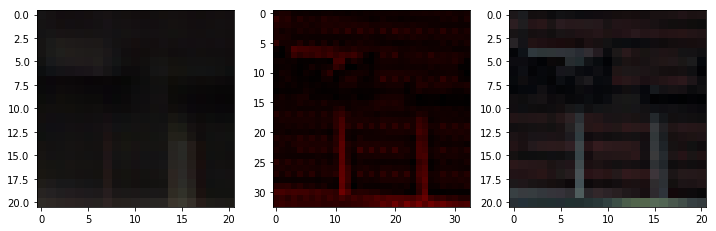

Epoch [320/500], Step [0/25], Loss: 0.019131755456328392
Epoch [320/500], Step [10/25], Loss: 0.019690250977873802
Epoch [320/500], Step [20/25], Loss: 0.020333746448159218

Finished Epoch 320, Loss --- mean: 0.01916416011750698, std 0.000917627292037702



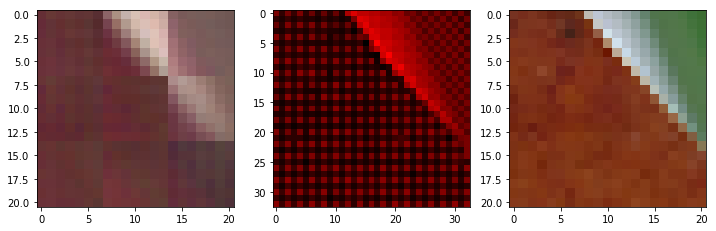

Epoch [321/500], Step [0/25], Loss: 0.018611464649438858
Epoch [321/500], Step [10/25], Loss: 0.019241278991103172
Epoch [321/500], Step [20/25], Loss: 0.019586943089962006

Finished Epoch 321, Loss --- mean: 0.019173991605639457, std 0.0008143626698931519



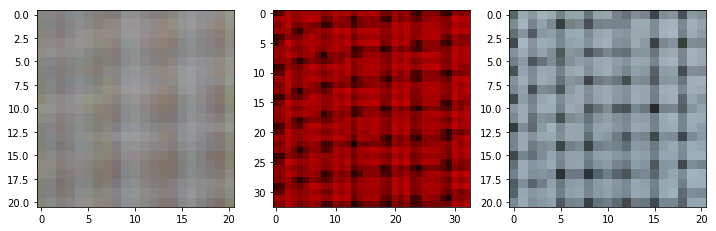

Epoch [322/500], Step [0/25], Loss: 0.01887584663927555
Epoch [322/500], Step [10/25], Loss: 0.019564587622880936
Epoch [322/500], Step [20/25], Loss: 0.019007625058293343

Finished Epoch 322, Loss --- mean: 0.019085315093398093, std 0.0007256653264421602



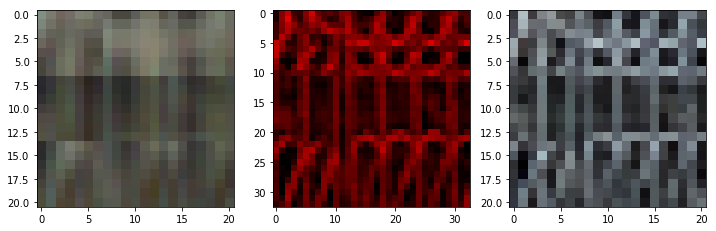

Epoch [323/500], Step [0/25], Loss: 0.01846124418079853
Epoch [323/500], Step [10/25], Loss: 0.018587760627269745
Epoch [323/500], Step [20/25], Loss: 0.018594102934002876


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 323, Loss --- mean: 0.018993524685502052, std 0.0010365034901575047



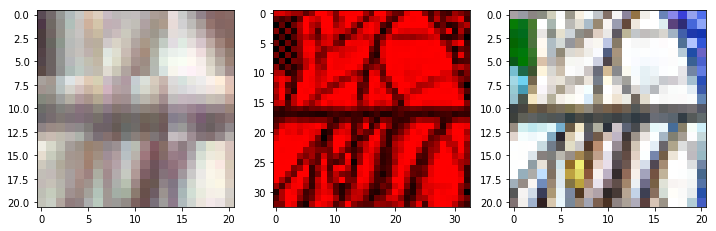

Epoch [324/500], Step [0/25], Loss: 0.018508613109588623
Epoch [324/500], Step [10/25], Loss: 0.018981143832206726
Epoch [324/500], Step [20/25], Loss: 0.018663836643099785

Finished Epoch 324, Loss --- mean: 0.018863971307873727, std 0.0008655143677394381



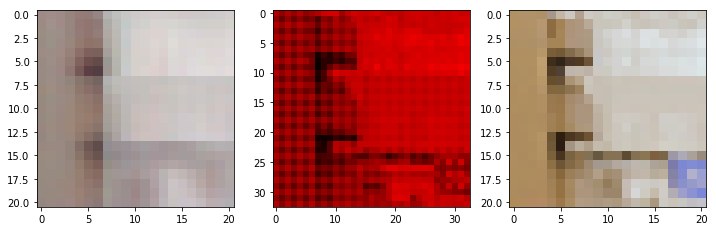

Epoch [325/500], Step [0/25], Loss: 0.019399186596274376
Epoch [325/500], Step [10/25], Loss: 0.019647426903247833
Epoch [325/500], Step [20/25], Loss: 0.019902948290109634

Finished Epoch 325, Loss --- mean: 0.01927503548562527, std 0.0006126622060504263



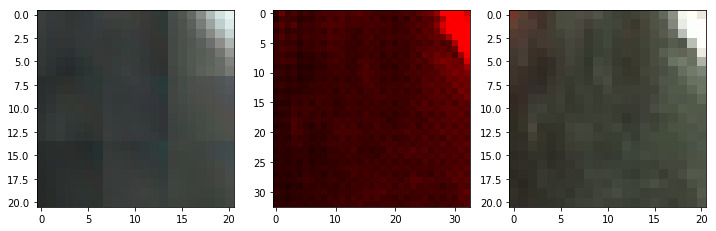

Epoch [326/500], Step [0/25], Loss: 0.01880958490073681
Epoch [326/500], Step [10/25], Loss: 0.020001327618956566
Epoch [326/500], Step [20/25], Loss: 0.01776210404932499

Finished Epoch 326, Loss --- mean: 0.019189970567822456, std 0.0006973938783372343



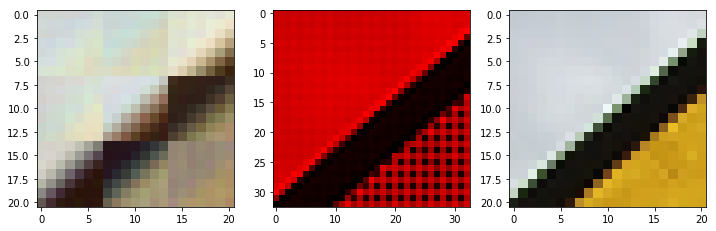

Epoch [327/500], Step [0/25], Loss: 0.019315771758556366
Epoch [327/500], Step [10/25], Loss: 0.0180641021579504
Epoch [327/500], Step [20/25], Loss: 0.01852758228778839

Finished Epoch 327, Loss --- mean: 0.019350374564528466, std 0.0010005237558788243



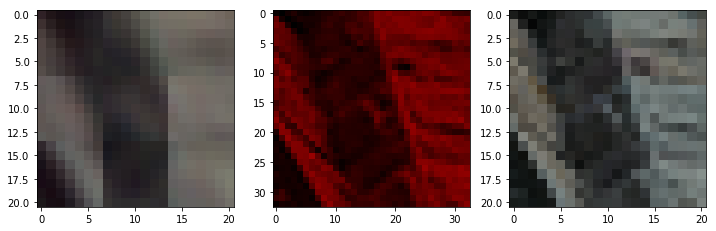

Epoch [328/500], Step [0/25], Loss: 0.019314011558890343
Epoch [328/500], Step [10/25], Loss: 0.019390061497688293
Epoch [328/500], Step [20/25], Loss: 0.020034324377775192

Finished Epoch 328, Loss --- mean: 0.0193542655557394, std 0.0008806469676078917



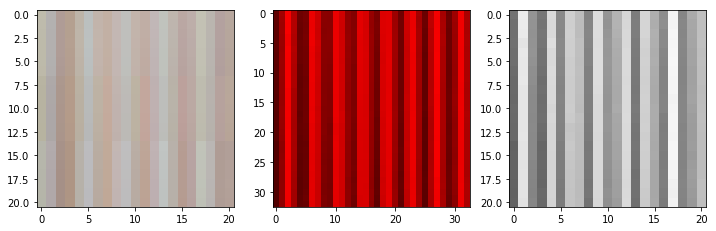

Epoch [329/500], Step [0/25], Loss: 0.01914961077272892
Epoch [329/500], Step [10/25], Loss: 0.01926315203309059
Epoch [329/500], Step [20/25], Loss: 0.01758987456560135

Finished Epoch 329, Loss --- mean: 0.019352551251649856, std 0.0009554005478108629



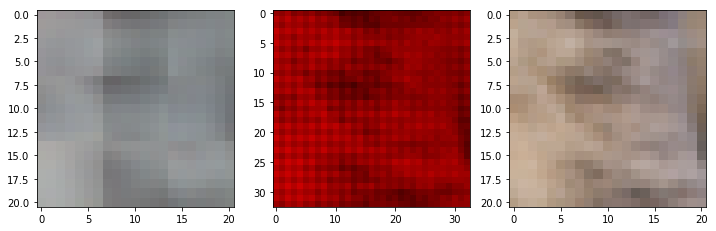

Epoch [330/500], Step [0/25], Loss: 0.020346736535429955
Epoch [330/500], Step [10/25], Loss: 0.020693013444542885
Epoch [330/500], Step [20/25], Loss: 0.01816892810165882

Finished Epoch 330, Loss --- mean: 0.019309352487325668, std 0.0010215013089153685



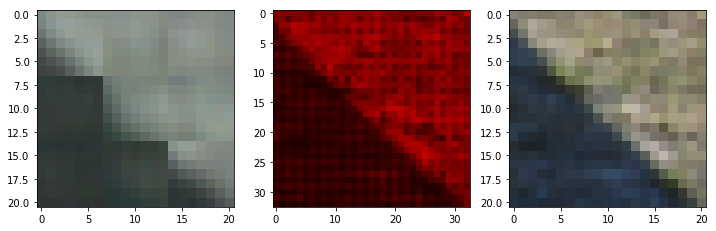

Epoch [331/500], Step [0/25], Loss: 0.020804360508918762
Epoch [331/500], Step [10/25], Loss: 0.01909138262271881
Epoch [331/500], Step [20/25], Loss: 0.019066305831074715

Finished Epoch 331, Loss --- mean: 0.01894013985991478, std 0.0009545734039947678



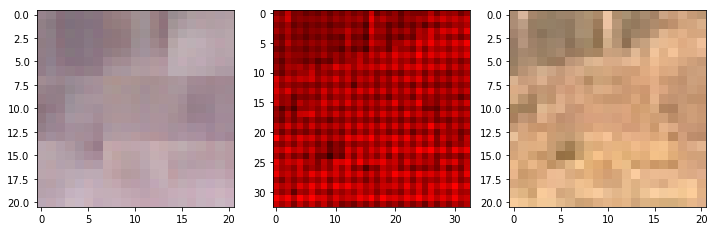

Epoch [332/500], Step [0/25], Loss: 0.01994263380765915
Epoch [332/500], Step [10/25], Loss: 0.01840045303106308
Epoch [332/500], Step [20/25], Loss: 0.01873495802283287

Finished Epoch 332, Loss --- mean: 0.01899328626692295, std 0.000929245627016863



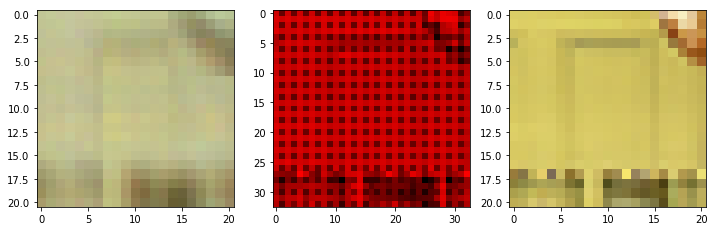

Epoch [333/500], Step [0/25], Loss: 0.018136238679289818
Epoch [333/500], Step [10/25], Loss: 0.020083818584680557
Epoch [333/500], Step [20/25], Loss: 0.018341124057769775

Finished Epoch 333, Loss --- mean: 0.019199280366301537, std 0.0007003336709262457



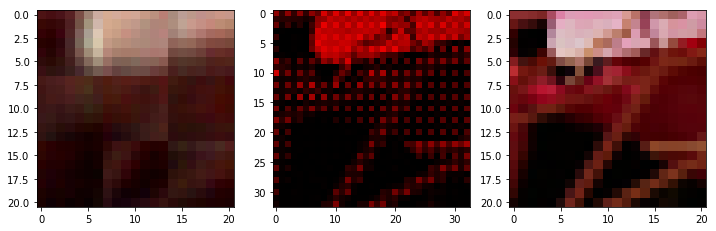

Epoch [334/500], Step [0/25], Loss: 0.019222568720579147
Epoch [334/500], Step [10/25], Loss: 0.01966499164700508
Epoch [334/500], Step [20/25], Loss: 0.018703019246459007

Finished Epoch 334, Loss --- mean: 0.01919988751411438, std 0.0007260238317846681



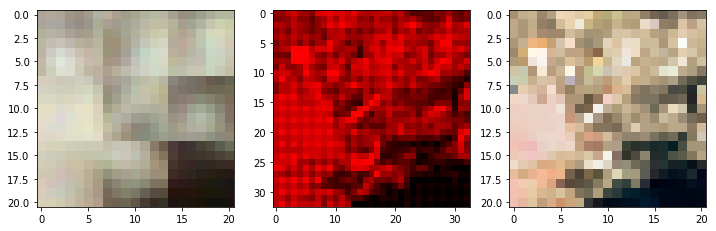

Epoch [335/500], Step [0/25], Loss: 0.01872224360704422
Epoch [335/500], Step [10/25], Loss: 0.01987713947892189
Epoch [335/500], Step [20/25], Loss: 0.018779955804347992

Finished Epoch 335, Loss --- mean: 0.018994800448417663, std 0.0006851710580622774



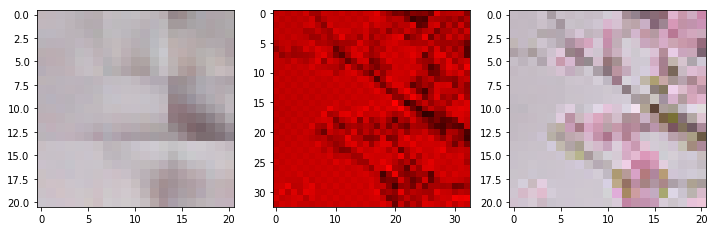

Epoch [336/500], Step [0/25], Loss: 0.01847383752465248
Epoch [336/500], Step [10/25], Loss: 0.01847180537879467
Epoch [336/500], Step [20/25], Loss: 0.01933172158896923

Finished Epoch 336, Loss --- mean: 0.01901200383901596, std 0.0007887473248182239



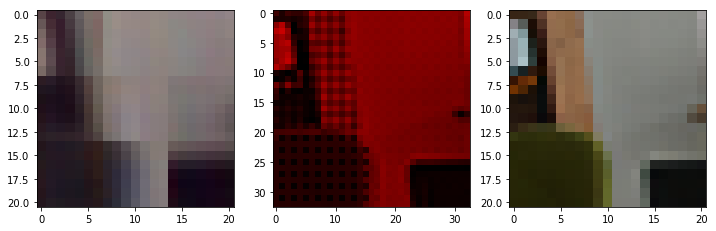

Epoch [337/500], Step [0/25], Loss: 0.019888661801815033
Epoch [337/500], Step [10/25], Loss: 0.018914800137281418
Epoch [337/500], Step [20/25], Loss: 0.019319914281368256

Finished Epoch 337, Loss --- mean: 0.019342942163348198, std 0.0007910470277773721



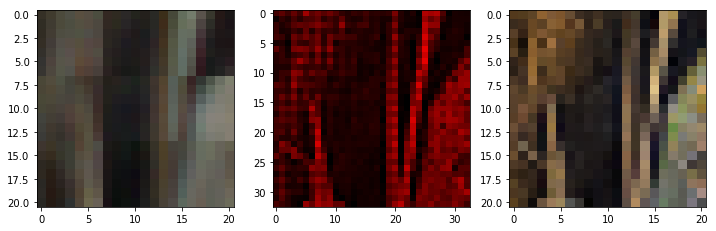

Epoch [338/500], Step [0/25], Loss: 0.019345801323652267
Epoch [338/500], Step [10/25], Loss: 0.01971307210624218
Epoch [338/500], Step [20/25], Loss: 0.018431100994348526

Finished Epoch 338, Loss --- mean: 0.019244913086295126, std 0.0007789854639539226



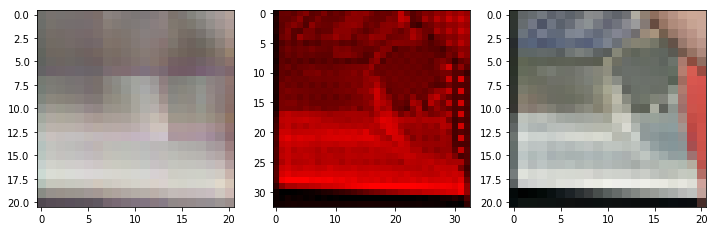

Epoch [339/500], Step [0/25], Loss: 0.020135585218667984
Epoch [339/500], Step [10/25], Loss: 0.019522948190569878
Epoch [339/500], Step [20/25], Loss: 0.018004896119236946

Finished Epoch 339, Loss --- mean: 0.0190181864798069, std 0.0006383144109201736



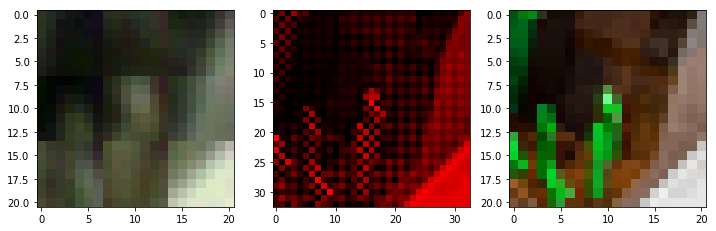

Epoch [340/500], Step [0/25], Loss: 0.020798997953534126
Epoch [340/500], Step [10/25], Loss: 0.01945863664150238
Epoch [340/500], Step [20/25], Loss: 0.019563384354114532

Finished Epoch 340, Loss --- mean: 0.01895508907735348, std 0.0008124610125969498



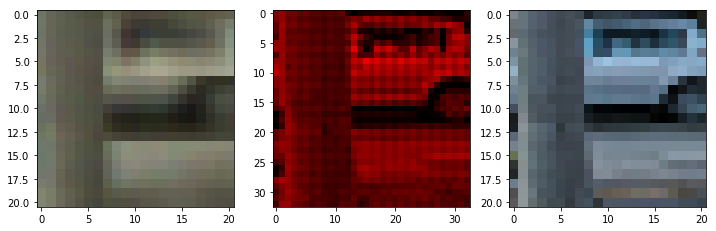

Epoch [341/500], Step [0/25], Loss: 0.019333112984895706
Epoch [341/500], Step [10/25], Loss: 0.01909278705716133
Epoch [341/500], Step [20/25], Loss: 0.01902918890118599

Finished Epoch 341, Loss --- mean: 0.018828749060630798, std 0.0008711863036991768



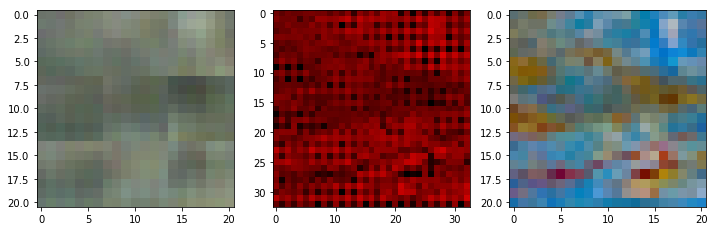

Epoch [342/500], Step [0/25], Loss: 0.01997373439371586
Epoch [342/500], Step [10/25], Loss: 0.018630672246217728
Epoch [342/500], Step [20/25], Loss: 0.019000975415110588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 342, Loss --- mean: 0.018981434330344202, std 0.0007093742716373816



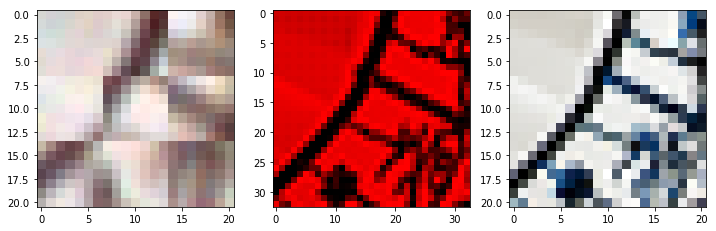

Epoch [343/500], Step [0/25], Loss: 0.018893299624323845
Epoch [343/500], Step [10/25], Loss: 0.02097642421722412
Epoch [343/500], Step [20/25], Loss: 0.01926071010529995

Finished Epoch 343, Loss --- mean: 0.019348339661955833, std 0.0010340390129181816



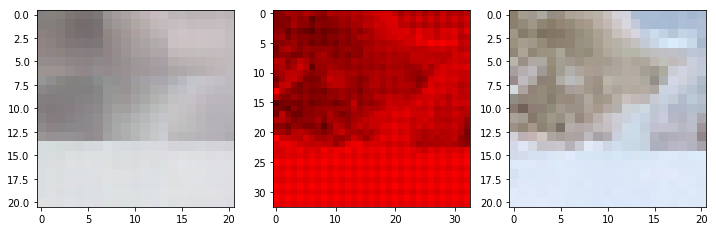

Epoch [344/500], Step [0/25], Loss: 0.018663089722394943
Epoch [344/500], Step [10/25], Loss: 0.019199134781956673
Epoch [344/500], Step [20/25], Loss: 0.018454359844326973

Finished Epoch 344, Loss --- mean: 0.01936719089746475, std 0.0007939424744610774



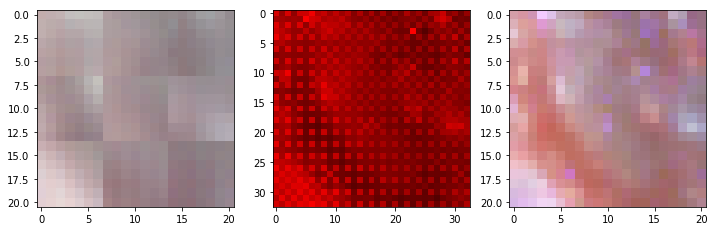

Epoch [345/500], Step [0/25], Loss: 0.01869187317788601
Epoch [345/500], Step [10/25], Loss: 0.01937694102525711
Epoch [345/500], Step [20/25], Loss: 0.02004990167915821

Finished Epoch 345, Loss --- mean: 0.019262093529105188, std 0.0005490979562679358



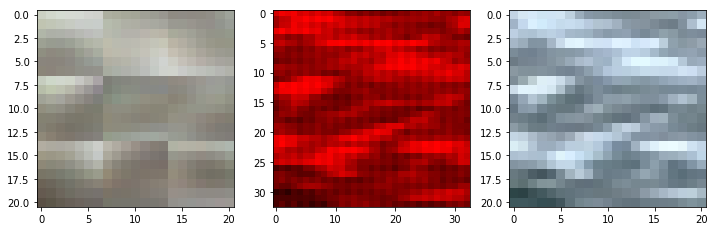

Epoch [346/500], Step [0/25], Loss: 0.019310779869556427
Epoch [346/500], Step [10/25], Loss: 0.01786293461918831
Epoch [346/500], Step [20/25], Loss: 0.019330743700265884

Finished Epoch 346, Loss --- mean: 0.019125667735934257, std 0.0009563960885523915



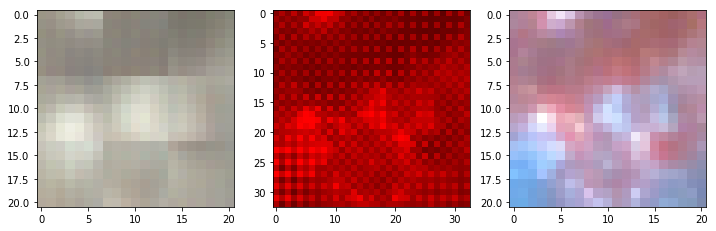

Epoch [347/500], Step [0/25], Loss: 0.018828487023711205
Epoch [347/500], Step [10/25], Loss: 0.019331028684973717
Epoch [347/500], Step [20/25], Loss: 0.02026277221739292

Finished Epoch 347, Loss --- mean: 0.01890268310904503, std 0.0007075453094777273



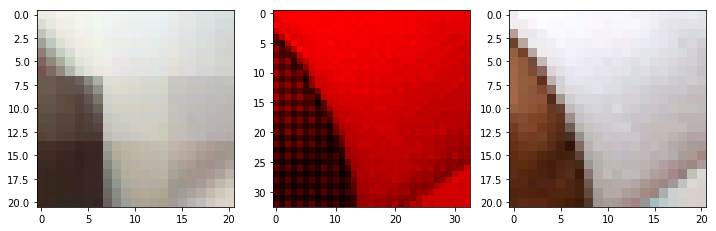

Epoch [348/500], Step [0/25], Loss: 0.019030481576919556
Epoch [348/500], Step [10/25], Loss: 0.019758522510528564
Epoch [348/500], Step [20/25], Loss: 0.018135489895939827

Finished Epoch 348, Loss --- mean: 0.018770650178194046, std 0.0007244978422382232



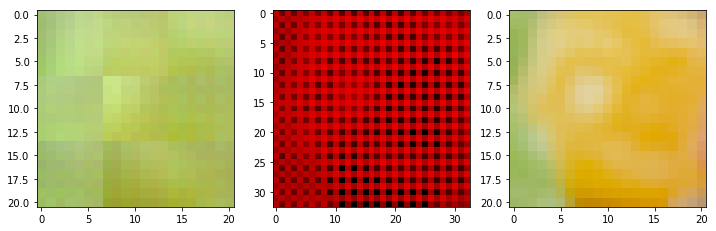

Epoch [349/500], Step [0/25], Loss: 0.01845613308250904
Epoch [349/500], Step [10/25], Loss: 0.018936974927783012
Epoch [349/500], Step [20/25], Loss: 0.01865122839808464

Finished Epoch 349, Loss --- mean: 0.01879147358238697, std 0.0008877567883352686



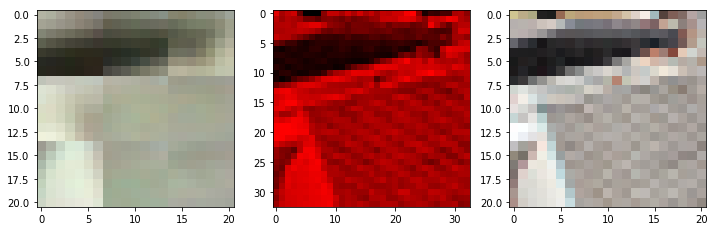

Epoch [350/500], Step [0/25], Loss: 0.01804232783615589
Epoch [350/500], Step [10/25], Loss: 0.020339060574769974
Epoch [350/500], Step [20/25], Loss: 0.019506458193063736

Finished Epoch 350, Loss --- mean: 0.01885121576488018, std 0.0009783254848977456



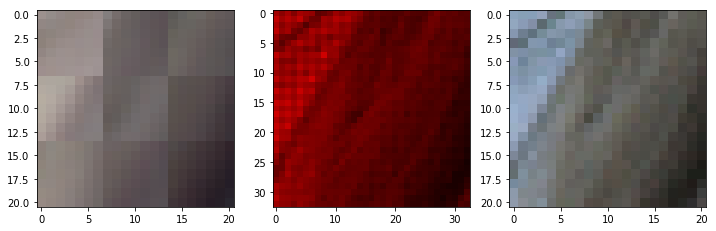

Epoch [351/500], Step [0/25], Loss: 0.018669061362743378
Epoch [351/500], Step [10/25], Loss: 0.0188075453042984
Epoch [351/500], Step [20/25], Loss: 0.019102510064840317

Finished Epoch 351, Loss --- mean: 0.019232344031333923, std 0.0006029423067753456



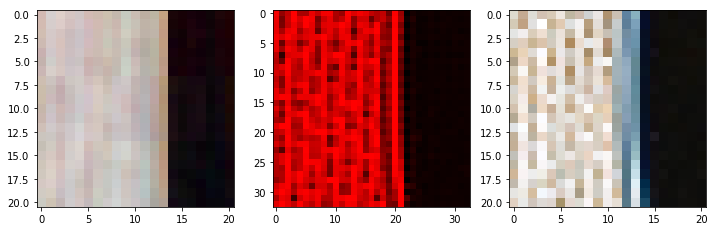

Epoch [352/500], Step [0/25], Loss: 0.019513672217726707
Epoch [352/500], Step [10/25], Loss: 0.02130282297730446
Epoch [352/500], Step [20/25], Loss: 0.020266152918338776

Finished Epoch 352, Loss --- mean: 0.019376193806529045, std 0.000973961615261989



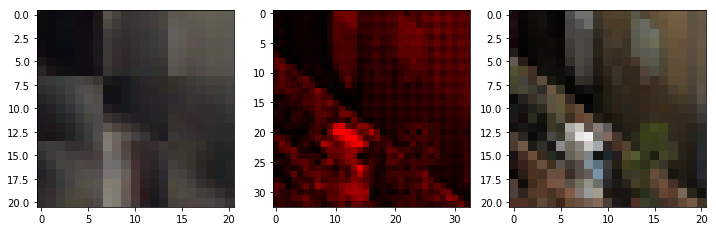

Epoch [353/500], Step [0/25], Loss: 0.019137611612677574
Epoch [353/500], Step [10/25], Loss: 0.01877450756728649
Epoch [353/500], Step [20/25], Loss: 0.019124893471598625

Finished Epoch 353, Loss --- mean: 0.019302761107683183, std 0.0007386608517933137



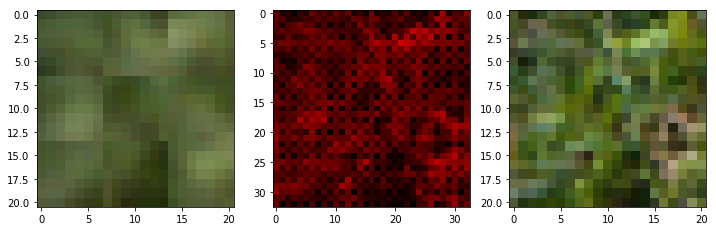

Epoch [354/500], Step [0/25], Loss: 0.01774950698018074
Epoch [354/500], Step [10/25], Loss: 0.018656747415661812
Epoch [354/500], Step [20/25], Loss: 0.019557388499379158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 354, Loss --- mean: 0.018922440707683563, std 0.000815728797487173



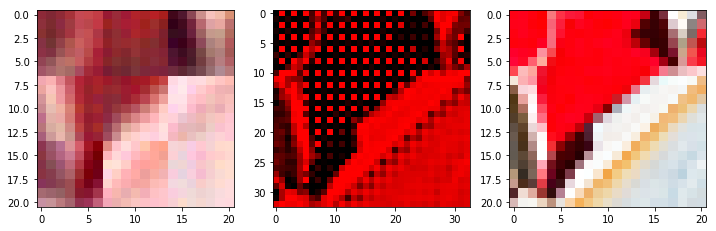

Epoch [355/500], Step [0/25], Loss: 0.01844828762114048
Epoch [355/500], Step [10/25], Loss: 0.019539272412657738
Epoch [355/500], Step [20/25], Loss: 0.019714973866939545

Finished Epoch 355, Loss --- mean: 0.018924658298492433, std 0.0007013521427396312



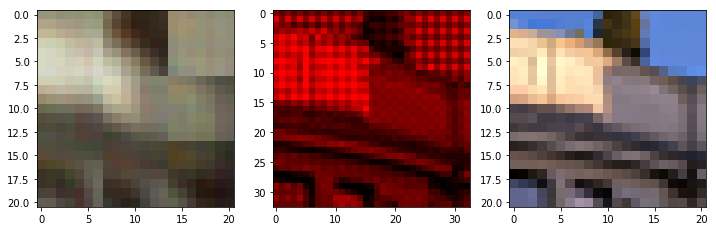

Epoch [356/500], Step [0/25], Loss: 0.0193657036870718
Epoch [356/500], Step [10/25], Loss: 0.019366703927516937
Epoch [356/500], Step [20/25], Loss: 0.018630778416991234

Finished Epoch 356, Loss --- mean: 0.018946818858385086, std 0.0007997380257241709



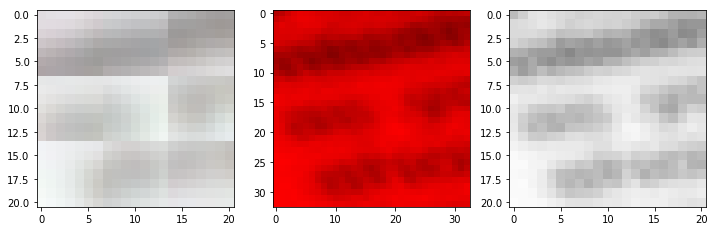

Epoch [357/500], Step [0/25], Loss: 0.018352877348661423
Epoch [357/500], Step [10/25], Loss: 0.017140472307801247
Epoch [357/500], Step [20/25], Loss: 0.02011522650718689

Finished Epoch 357, Loss --- mean: 0.019008513540029526, std 0.0009878179441510278



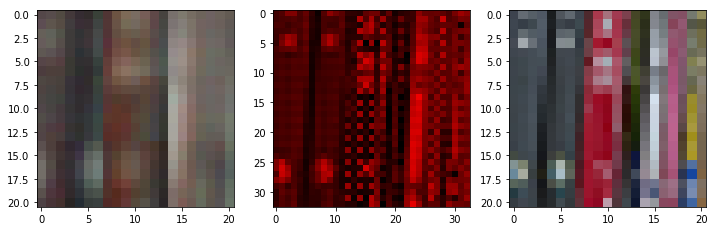

Epoch [358/500], Step [0/25], Loss: 0.01861444115638733
Epoch [358/500], Step [10/25], Loss: 0.01945943757891655
Epoch [358/500], Step [20/25], Loss: 0.019531503319740295

Finished Epoch 358, Loss --- mean: 0.018889510780572893, std 0.0007130376356225068



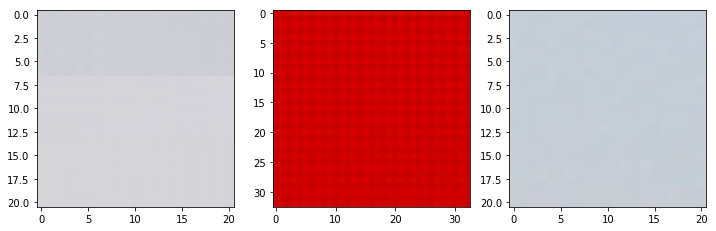

Epoch [359/500], Step [0/25], Loss: 0.0192080307751894
Epoch [359/500], Step [10/25], Loss: 0.019653571769595146
Epoch [359/500], Step [20/25], Loss: 0.01991293579339981

Finished Epoch 359, Loss --- mean: 0.019204580709338188, std 0.0007906515367301417



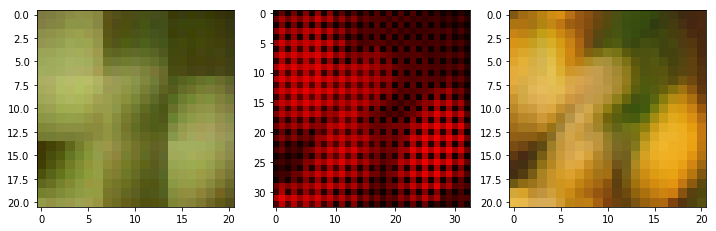

Epoch [360/500], Step [0/25], Loss: 0.020501073449850082
Epoch [360/500], Step [10/25], Loss: 0.020675266161561012
Epoch [360/500], Step [20/25], Loss: 0.018803386017680168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 360, Loss --- mean: 0.019130424931645393, std 0.0009623981207286145



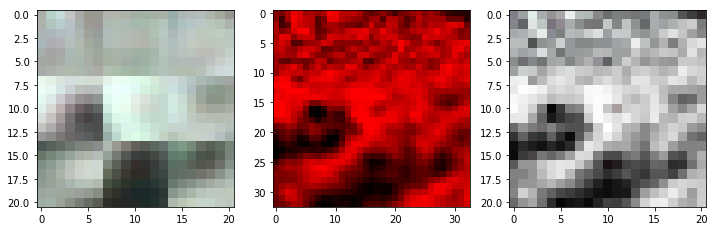

Epoch [361/500], Step [0/25], Loss: 0.019547443836927414
Epoch [361/500], Step [10/25], Loss: 0.018391456454992294
Epoch [361/500], Step [20/25], Loss: 0.019367244094610214

Finished Epoch 361, Loss --- mean: 0.018912588283419608, std 0.001101588887015957



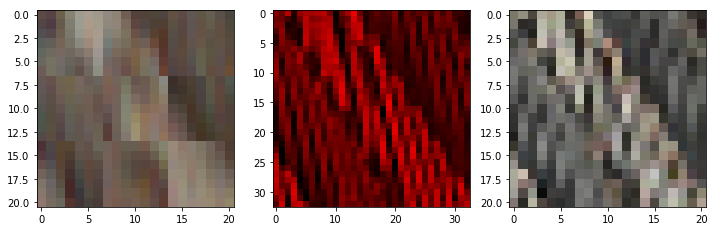

Epoch [362/500], Step [0/25], Loss: 0.018779359757900238
Epoch [362/500], Step [10/25], Loss: 0.020160147920250893
Epoch [362/500], Step [20/25], Loss: 0.0194732416421175

Finished Epoch 362, Loss --- mean: 0.018776789158582687, std 0.000983462139937227



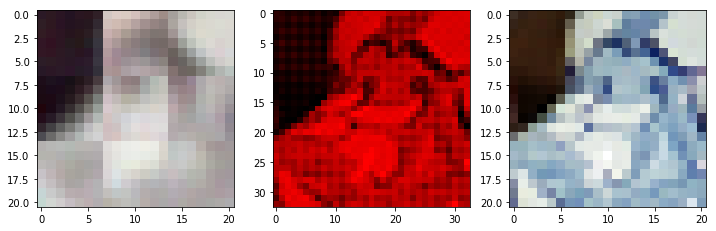

Epoch [363/500], Step [0/25], Loss: 0.018405552953481674
Epoch [363/500], Step [10/25], Loss: 0.016638580709695816
Epoch [363/500], Step [20/25], Loss: 0.02022079937160015

Finished Epoch 363, Loss --- mean: 0.018874544352293014, std 0.0010105672467838514



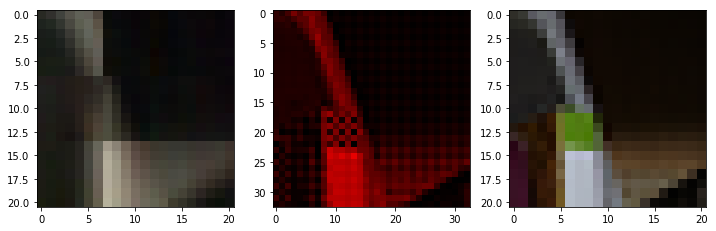

Epoch [364/500], Step [0/25], Loss: 0.019921647384762764
Epoch [364/500], Step [10/25], Loss: 0.018682731315493584
Epoch [364/500], Step [20/25], Loss: 0.01818409562110901

Finished Epoch 364, Loss --- mean: 0.018836702629923822, std 0.0007069851280958922



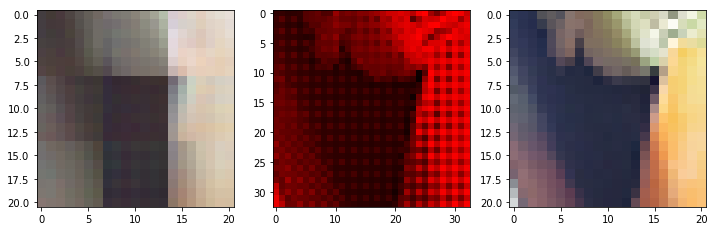

Epoch [365/500], Step [0/25], Loss: 0.019002510234713554
Epoch [365/500], Step [10/25], Loss: 0.018893098458647728
Epoch [365/500], Step [20/25], Loss: 0.01997065544128418

Finished Epoch 365, Loss --- mean: 0.019525203481316568, std 0.0008740833906754585



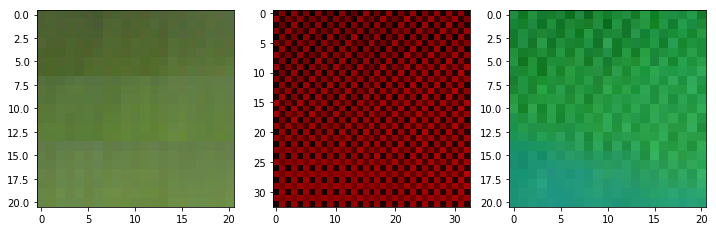

Epoch [366/500], Step [0/25], Loss: 0.018469586968421936
Epoch [366/500], Step [10/25], Loss: 0.018897617235779762
Epoch [366/500], Step [20/25], Loss: 0.019868195056915283

Finished Epoch 366, Loss --- mean: 0.019008826464414597, std 0.0007319897975789812



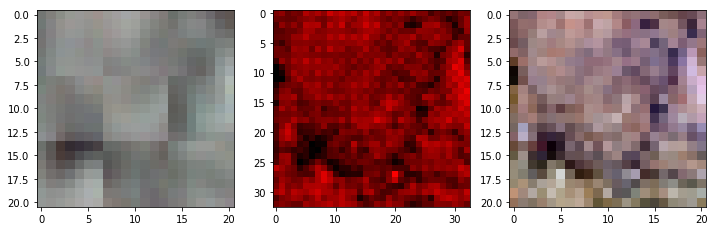

Epoch [367/500], Step [0/25], Loss: 0.02021675929427147
Epoch [367/500], Step [10/25], Loss: 0.0201254952698946
Epoch [367/500], Step [20/25], Loss: 0.018186742439866066

Finished Epoch 367, Loss --- mean: 0.019050569012761115, std 0.0008322554371463221



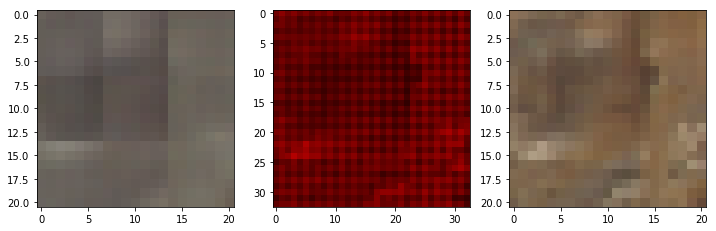

Epoch [368/500], Step [0/25], Loss: 0.019788164645433426
Epoch [368/500], Step [10/25], Loss: 0.019195588305592537
Epoch [368/500], Step [20/25], Loss: 0.01856173202395439


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 368, Loss --- mean: 0.018905907571315765, std 0.0009366889627147082



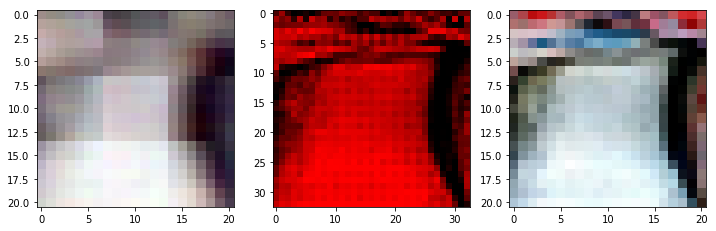

Epoch [369/500], Step [0/25], Loss: 0.017949949949979782
Epoch [369/500], Step [10/25], Loss: 0.01922626607120037
Epoch [369/500], Step [20/25], Loss: 0.01798122376203537

Finished Epoch 369, Loss --- mean: 0.01875023953616619, std 0.0007228962862242759



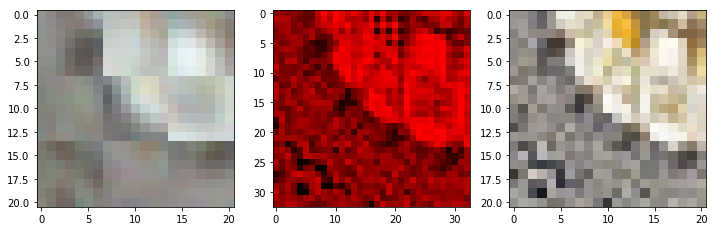

Epoch [370/500], Step [0/25], Loss: 0.020897502079606056
Epoch [370/500], Step [10/25], Loss: 0.01923617720603943
Epoch [370/500], Step [20/25], Loss: 0.017923543229699135

Finished Epoch 370, Loss --- mean: 0.018745549321174622, std 0.0007729242331229431



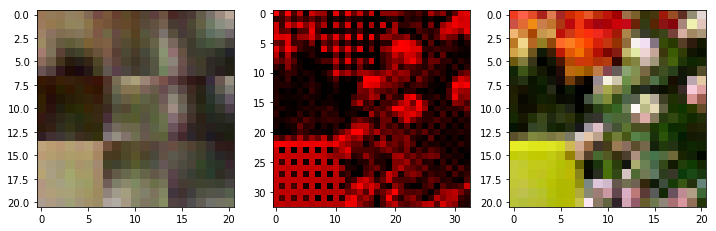

Epoch [371/500], Step [0/25], Loss: 0.01894269697368145
Epoch [371/500], Step [10/25], Loss: 0.018335159868001938
Epoch [371/500], Step [20/25], Loss: 0.019565533846616745

Finished Epoch 371, Loss --- mean: 0.019018561020493506, std 0.0009447651268060032



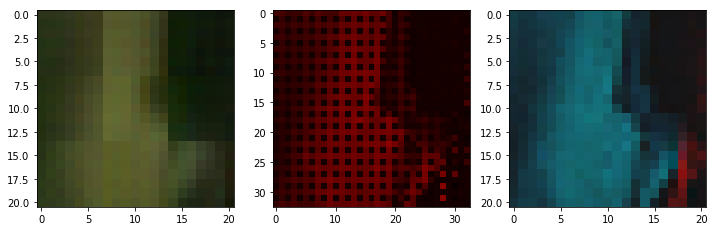

Epoch [372/500], Step [0/25], Loss: 0.02022116258740425
Epoch [372/500], Step [10/25], Loss: 0.0192987360060215
Epoch [372/500], Step [20/25], Loss: 0.019373571500182152

Finished Epoch 372, Loss --- mean: 0.01889398120343685, std 0.0007903879898432867



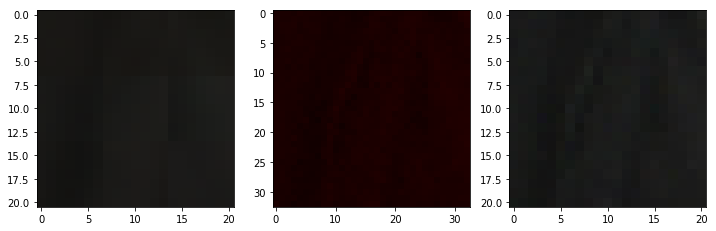

Epoch [373/500], Step [0/25], Loss: 0.018048269674181938
Epoch [373/500], Step [10/25], Loss: 0.018598418682813644
Epoch [373/500], Step [20/25], Loss: 0.01851557567715645

Finished Epoch 373, Loss --- mean: 0.01873945616185665, std 0.0008719677129317038



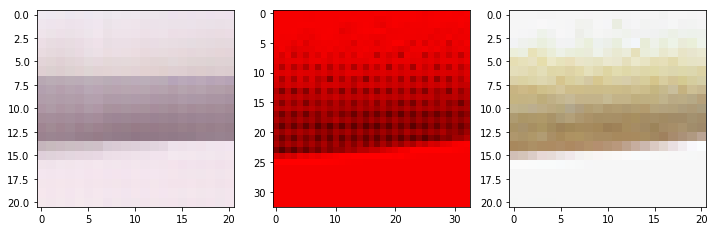

Epoch [374/500], Step [0/25], Loss: 0.018555669113993645
Epoch [374/500], Step [10/25], Loss: 0.019359510391950607
Epoch [374/500], Step [20/25], Loss: 0.018091956153512

Finished Epoch 374, Loss --- mean: 0.018840624839067458, std 0.0007756835532507158



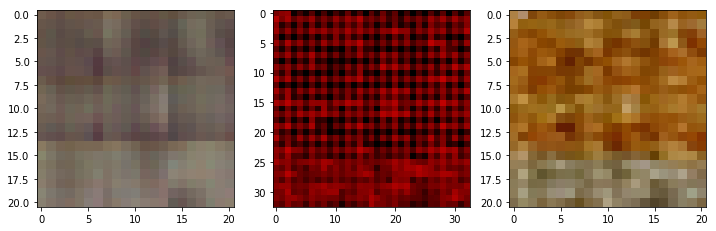

Epoch [375/500], Step [0/25], Loss: 0.018834112212061882
Epoch [375/500], Step [10/25], Loss: 0.018548432737588882
Epoch [375/500], Step [20/25], Loss: 0.018845437094569206

Finished Epoch 375, Loss --- mean: 0.019021603018045424, std 0.000668446306936576



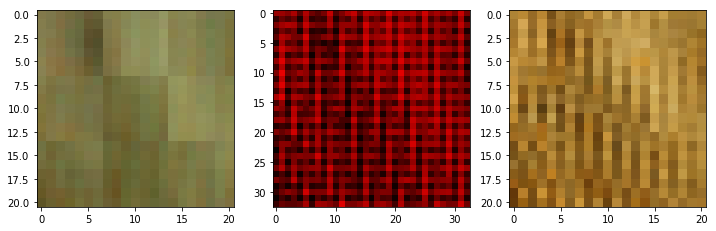

Epoch [376/500], Step [0/25], Loss: 0.018871858716011047
Epoch [376/500], Step [10/25], Loss: 0.01924406737089157
Epoch [376/500], Step [20/25], Loss: 0.018941275775432587

Finished Epoch 376, Loss --- mean: 0.019010718539357187, std 0.0010592682232561353



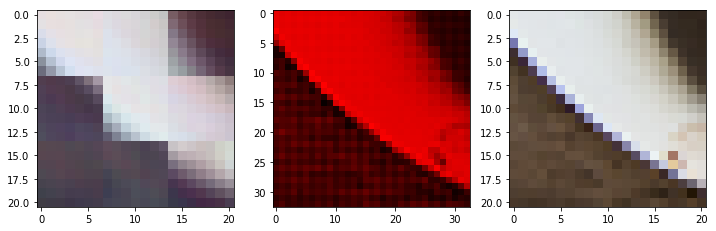

Epoch [377/500], Step [0/25], Loss: 0.019294237717986107
Epoch [377/500], Step [10/25], Loss: 0.019998209550976753
Epoch [377/500], Step [20/25], Loss: 0.019421156495809555

Finished Epoch 377, Loss --- mean: 0.018814456164836884, std 0.0007085744918291404



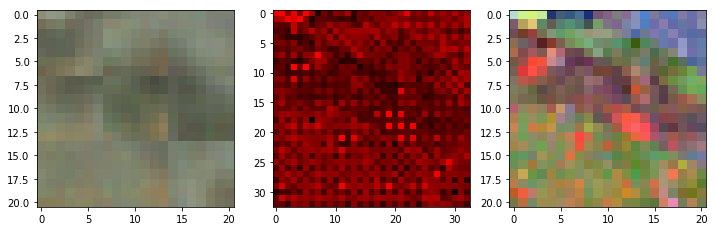

Epoch [378/500], Step [0/25], Loss: 0.01862366311252117
Epoch [378/500], Step [10/25], Loss: 0.020310332998633385
Epoch [378/500], Step [20/25], Loss: 0.018892358988523483

Finished Epoch 378, Loss --- mean: 0.018939894512295722, std 0.000793862174144832



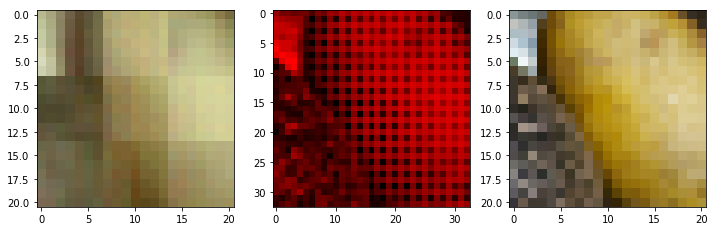

Epoch [379/500], Step [0/25], Loss: 0.02063870243728161
Epoch [379/500], Step [10/25], Loss: 0.019687719643115997
Epoch [379/500], Step [20/25], Loss: 0.018060343340039253

Finished Epoch 379, Loss --- mean: 0.019195043966174125, std 0.0007675104805247588



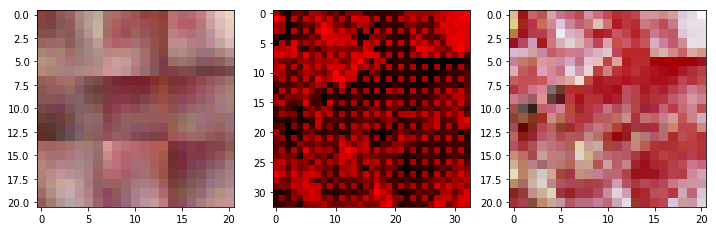

Epoch [380/500], Step [0/25], Loss: 0.018282895907759666
Epoch [380/500], Step [10/25], Loss: 0.019705303013324738
Epoch [380/500], Step [20/25], Loss: 0.017002109438180923

Finished Epoch 380, Loss --- mean: 0.01880659505724907, std 0.0008388116155313214



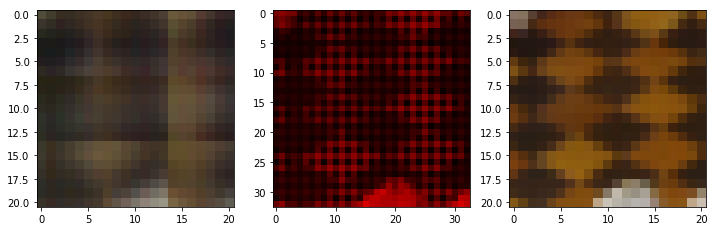

Epoch [381/500], Step [0/25], Loss: 0.01867458038032055
Epoch [381/500], Step [10/25], Loss: 0.017752496525645256
Epoch [381/500], Step [20/25], Loss: 0.01895853877067566

Finished Epoch 381, Loss --- mean: 0.018911052867770194, std 0.0009060932994126666



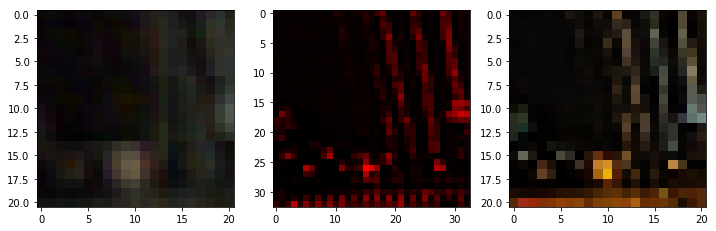

Epoch [382/500], Step [0/25], Loss: 0.018937936052680016
Epoch [382/500], Step [10/25], Loss: 0.018449634313583374
Epoch [382/500], Step [20/25], Loss: 0.019379829987883568

Finished Epoch 382, Loss --- mean: 0.018561147898435593, std 0.0006152291356507683



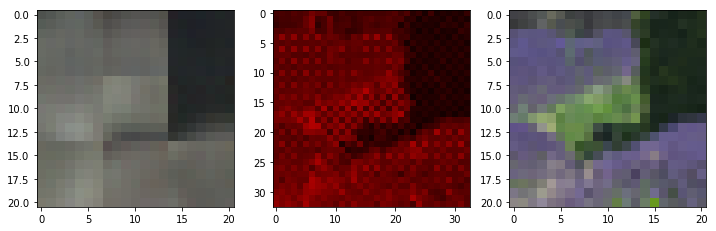

Epoch [383/500], Step [0/25], Loss: 0.017993615940213203
Epoch [383/500], Step [10/25], Loss: 0.018898071721196175
Epoch [383/500], Step [20/25], Loss: 0.019235802814364433

Finished Epoch 383, Loss --- mean: 0.018765451610088347, std 0.0007233099391969805



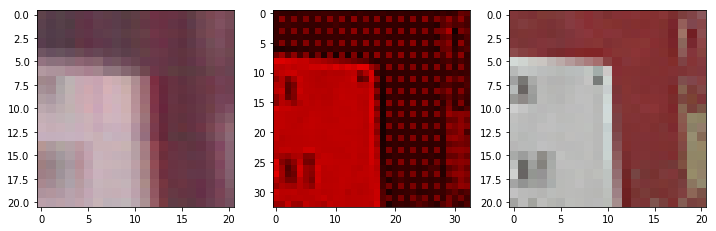

Epoch [384/500], Step [0/25], Loss: 0.019857298582792282
Epoch [384/500], Step [10/25], Loss: 0.018746675923466682
Epoch [384/500], Step [20/25], Loss: 0.019442889839410782

Finished Epoch 384, Loss --- mean: 0.018629087433218956, std 0.0008188241941013956



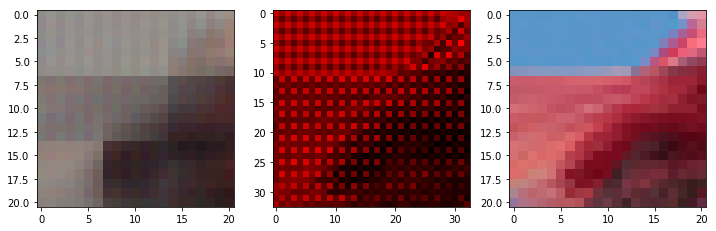

Epoch [385/500], Step [0/25], Loss: 0.021985584869980812
Epoch [385/500], Step [10/25], Loss: 0.01823601685464382
Epoch [385/500], Step [20/25], Loss: 0.01870030164718628

Finished Epoch 385, Loss --- mean: 0.01904203861951828, std 0.0008378317793768447



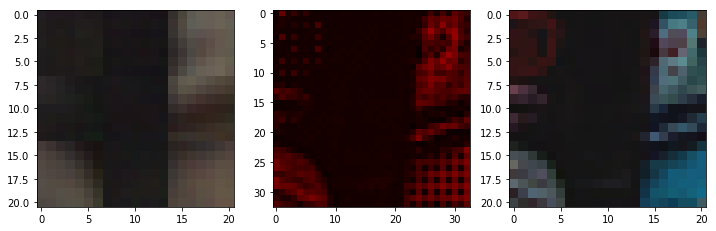

Epoch [386/500], Step [0/25], Loss: 0.01989121362566948
Epoch [386/500], Step [10/25], Loss: 0.019043199717998505
Epoch [386/500], Step [20/25], Loss: 0.018770720809698105

Finished Epoch 386, Loss --- mean: 0.019531510323286056, std 0.0007604561980295892



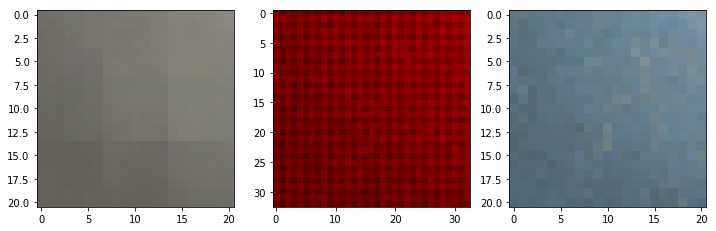

Epoch [387/500], Step [0/25], Loss: 0.01812276989221573
Epoch [387/500], Step [10/25], Loss: 0.018736904487013817
Epoch [387/500], Step [20/25], Loss: 0.018964258953928947

Finished Epoch 387, Loss --- mean: 0.01884399779140949, std 0.0006483331587086911



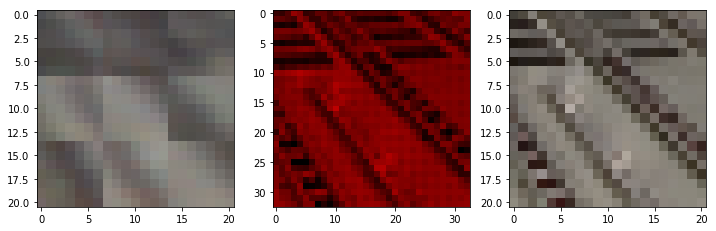

Epoch [388/500], Step [0/25], Loss: 0.018277963623404503
Epoch [388/500], Step [10/25], Loss: 0.01888757199048996
Epoch [388/500], Step [20/25], Loss: 0.01769312284886837


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 388, Loss --- mean: 0.01890225425362587, std 0.0008281776352345743



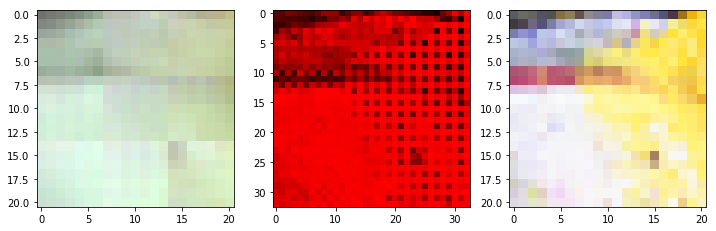

Epoch [389/500], Step [0/25], Loss: 0.019394375383853912
Epoch [389/500], Step [10/25], Loss: 0.01895923912525177
Epoch [389/500], Step [20/25], Loss: 0.019792767241597176

Finished Epoch 389, Loss --- mean: 0.01891213908791542, std 0.0007691852609918174



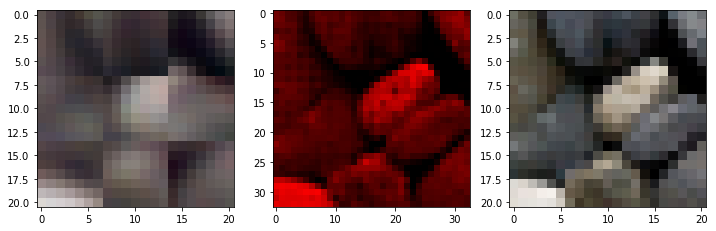

Epoch [390/500], Step [0/25], Loss: 0.019572217017412186
Epoch [390/500], Step [10/25], Loss: 0.01905490644276142
Epoch [390/500], Step [20/25], Loss: 0.01766424998641014

Finished Epoch 390, Loss --- mean: 0.018911037296056747, std 0.0011507360563412828



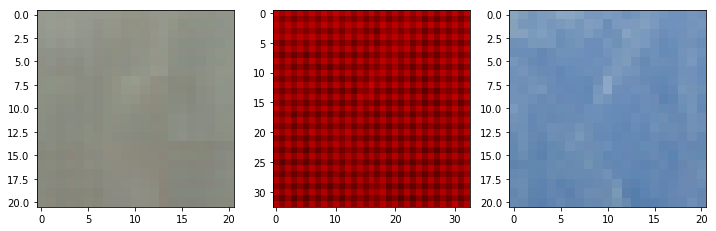

Epoch [391/500], Step [0/25], Loss: 0.019207797944545746
Epoch [391/500], Step [10/25], Loss: 0.018728500232100487
Epoch [391/500], Step [20/25], Loss: 0.01820911280810833

Finished Epoch 391, Loss --- mean: 0.01878265619277954, std 0.0007206533032526631



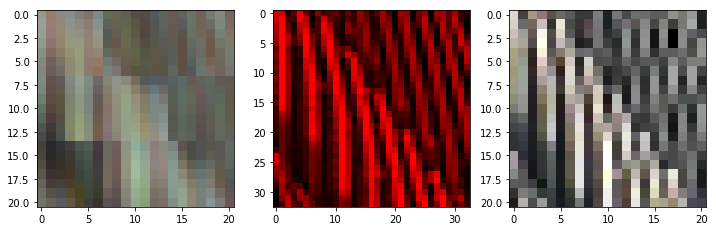

Epoch [392/500], Step [0/25], Loss: 0.01895798183977604
Epoch [392/500], Step [10/25], Loss: 0.01785126142203808
Epoch [392/500], Step [20/25], Loss: 0.017907429486513138

Finished Epoch 392, Loss --- mean: 0.018884901702404023, std 0.0009576951005531225



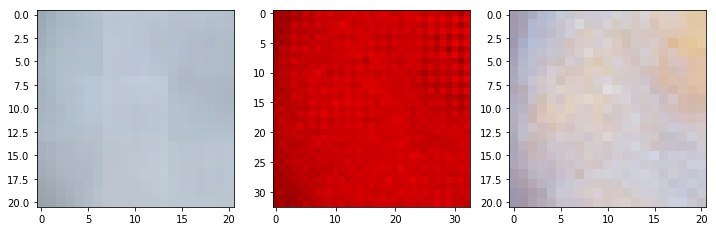

Epoch [393/500], Step [0/25], Loss: 0.020395690575242043
Epoch [393/500], Step [10/25], Loss: 0.02010250836610794
Epoch [393/500], Step [20/25], Loss: 0.019255083054304123

Finished Epoch 393, Loss --- mean: 0.0186725515127182, std 0.0008585878989243108



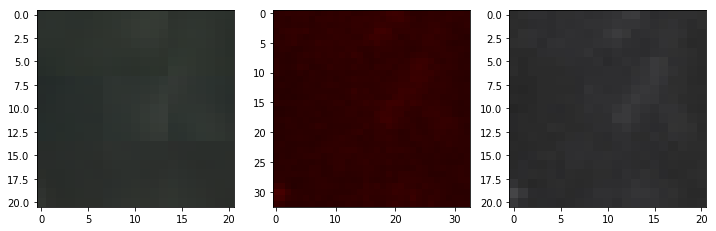

Epoch [394/500], Step [0/25], Loss: 0.018641680479049683
Epoch [394/500], Step [10/25], Loss: 0.018169675022363663
Epoch [394/500], Step [20/25], Loss: 0.019289655610919

Finished Epoch 394, Loss --- mean: 0.01865151546895504, std 0.0007309525025523043



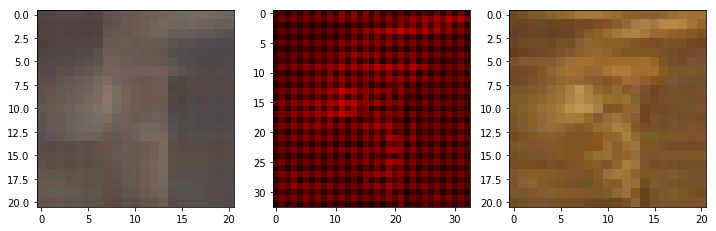

Epoch [395/500], Step [0/25], Loss: 0.018952563405036926
Epoch [395/500], Step [10/25], Loss: 0.019846713170409203
Epoch [395/500], Step [20/25], Loss: 0.017159270122647285

Finished Epoch 395, Loss --- mean: 0.01864918366074562, std 0.0007165846913928975



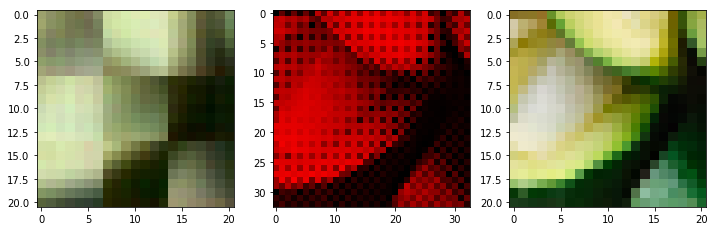

Epoch [396/500], Step [0/25], Loss: 0.01879572495818138
Epoch [396/500], Step [10/25], Loss: 0.018538735806941986
Epoch [396/500], Step [20/25], Loss: 0.01749909669160843

Finished Epoch 396, Loss --- mean: 0.018603929206728934, std 0.0008240190963115421



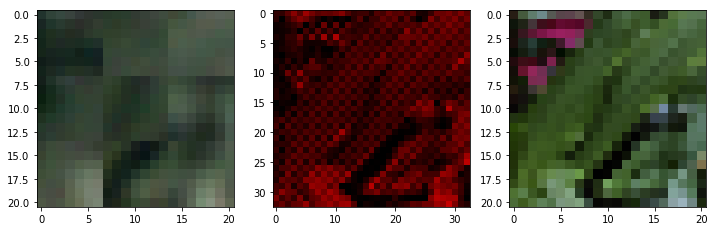

Epoch [397/500], Step [0/25], Loss: 0.016958313062787056
Epoch [397/500], Step [10/25], Loss: 0.01908670738339424
Epoch [397/500], Step [20/25], Loss: 0.020068490877747536

Finished Epoch 397, Loss --- mean: 0.01896593041718006, std 0.000733018810833745



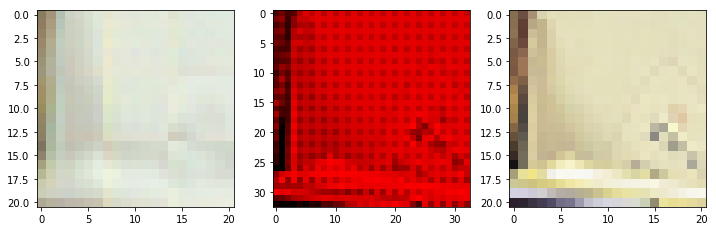

Epoch [398/500], Step [0/25], Loss: 0.017741095274686813
Epoch [398/500], Step [10/25], Loss: 0.019921818748116493
Epoch [398/500], Step [20/25], Loss: 0.02077769860625267

Finished Epoch 398, Loss --- mean: 0.019551989138126374, std 0.0009402663733856842



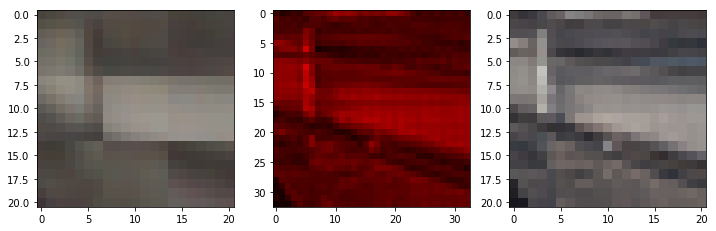

Epoch [399/500], Step [0/25], Loss: 0.0184010062366724
Epoch [399/500], Step [10/25], Loss: 0.018291983753442764
Epoch [399/500], Step [20/25], Loss: 0.017816726118326187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 399, Loss --- mean: 0.01883058324456215, std 0.0008308711114844133



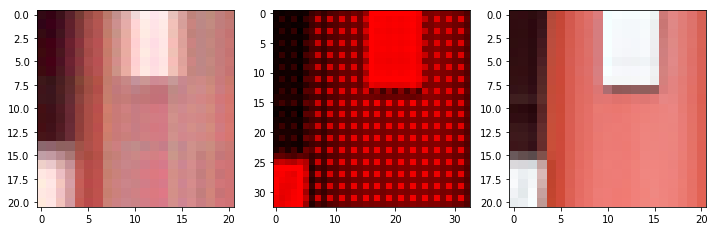

Epoch [400/500], Step [0/25], Loss: 0.017325440421700478
Epoch [400/500], Step [10/25], Loss: 0.019126353785395622
Epoch [400/500], Step [20/25], Loss: 0.018182074651122093

Finished Epoch 400, Loss --- mean: 0.018708771169185637, std 0.0007846946653265942



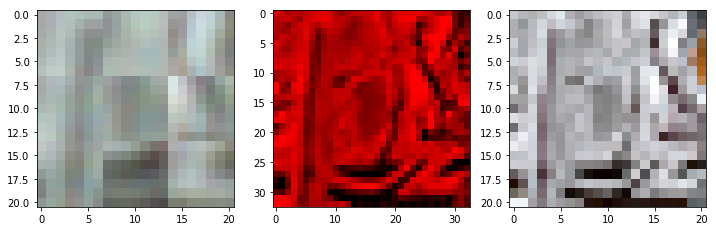

Epoch [401/500], Step [0/25], Loss: 0.01889757812023163
Epoch [401/500], Step [10/25], Loss: 0.019115861505270004
Epoch [401/500], Step [20/25], Loss: 0.018143678084015846

Finished Epoch 401, Loss --- mean: 0.018734762519598006, std 0.0006613579178554249



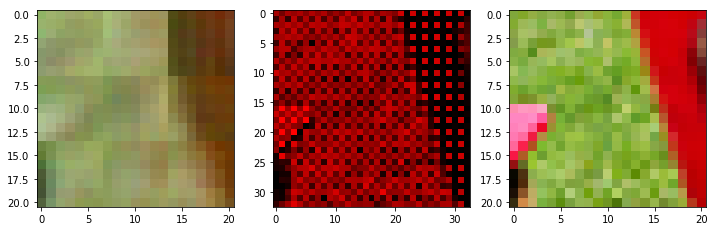

Epoch [402/500], Step [0/25], Loss: 0.017830751836299896
Epoch [402/500], Step [10/25], Loss: 0.01808851957321167
Epoch [402/500], Step [20/25], Loss: 0.018577512353658676

Finished Epoch 402, Loss --- mean: 0.018543535470962526, std 0.0007400680101560356



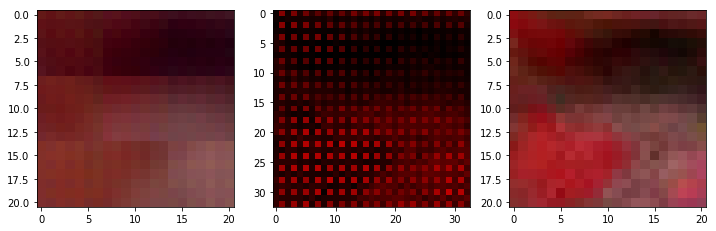

Epoch [403/500], Step [0/25], Loss: 0.018923338502645493
Epoch [403/500], Step [10/25], Loss: 0.018680941313505173
Epoch [403/500], Step [20/25], Loss: 0.01889176107943058

Finished Epoch 403, Loss --- mean: 0.01862074464559555, std 0.0007292245508465681



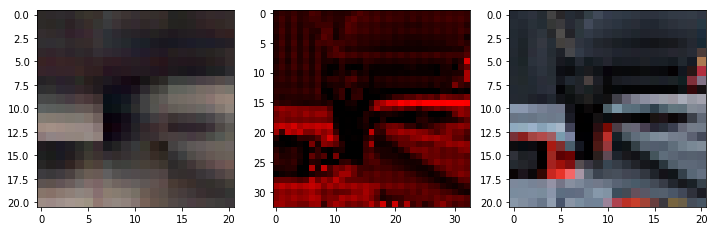

Epoch [404/500], Step [0/25], Loss: 0.018207024782896042
Epoch [404/500], Step [10/25], Loss: 0.01987634226679802
Epoch [404/500], Step [20/25], Loss: 0.018272679299116135

Finished Epoch 404, Loss --- mean: 0.018505562171339987, std 0.0007696500044789139



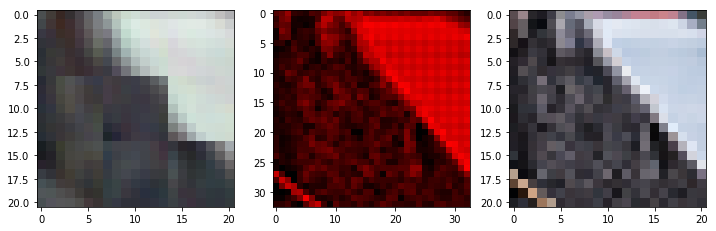

Epoch [405/500], Step [0/25], Loss: 0.019000384956598282
Epoch [405/500], Step [10/25], Loss: 0.019152937456965446
Epoch [405/500], Step [20/25], Loss: 0.018793923780322075

Finished Epoch 405, Loss --- mean: 0.018988521546125414, std 0.0006672738907470807



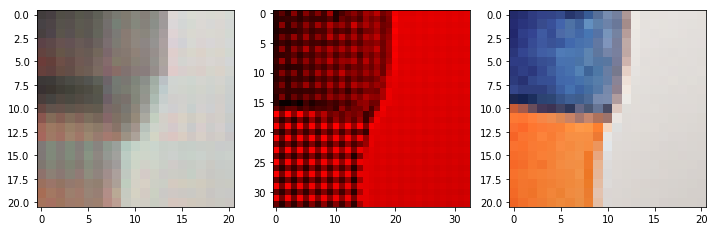

Epoch [406/500], Step [0/25], Loss: 0.018181588500738144
Epoch [406/500], Step [10/25], Loss: 0.018449226394295692
Epoch [406/500], Step [20/25], Loss: 0.018794532865285873

Finished Epoch 406, Loss --- mean: 0.01899116426706314, std 0.0006693249834249726



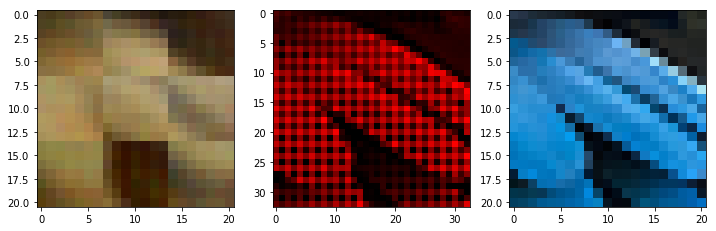

Epoch [407/500], Step [0/25], Loss: 0.018690776079893112
Epoch [407/500], Step [10/25], Loss: 0.019065678119659424
Epoch [407/500], Step [20/25], Loss: 0.019917335361242294

Finished Epoch 407, Loss --- mean: 0.01893735967576504, std 0.0008144612966572622



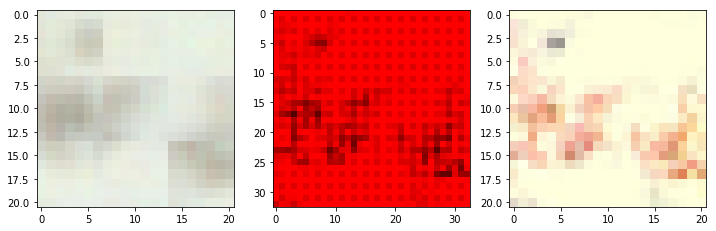

Epoch [408/500], Step [0/25], Loss: 0.018166176974773407
Epoch [408/500], Step [10/25], Loss: 0.02024383656680584
Epoch [408/500], Step [20/25], Loss: 0.020280323922634125

Finished Epoch 408, Loss --- mean: 0.018980377539992332, std 0.0008772737782949293



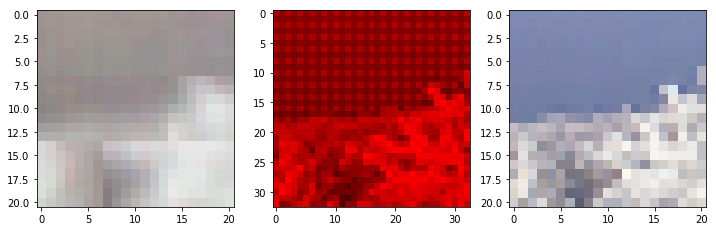

Epoch [409/500], Step [0/25], Loss: 0.017504313960671425
Epoch [409/500], Step [10/25], Loss: 0.01893455907702446
Epoch [409/500], Step [20/25], Loss: 0.019559118896722794

Finished Epoch 409, Loss --- mean: 0.018730110600590707, std 0.0011301055282012433



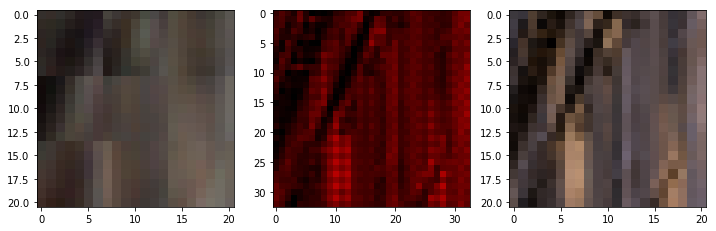

Epoch [410/500], Step [0/25], Loss: 0.019389832392334938
Epoch [410/500], Step [10/25], Loss: 0.019411606714129448
Epoch [410/500], Step [20/25], Loss: 0.01857256516814232

Finished Epoch 410, Loss --- mean: 0.018579030334949495, std 0.0006739349697579403



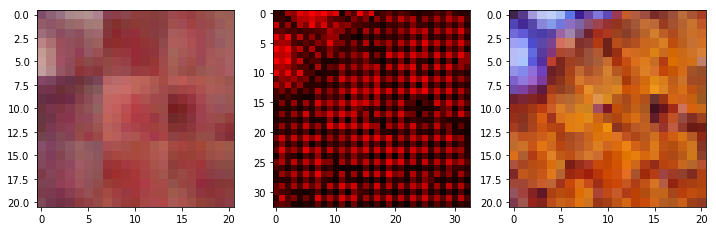

Epoch [411/500], Step [0/25], Loss: 0.018251076340675354
Epoch [411/500], Step [10/25], Loss: 0.019736066460609436
Epoch [411/500], Step [20/25], Loss: 0.018334094434976578

Finished Epoch 411, Loss --- mean: 0.01870310790836811, std 0.0008075551733345634



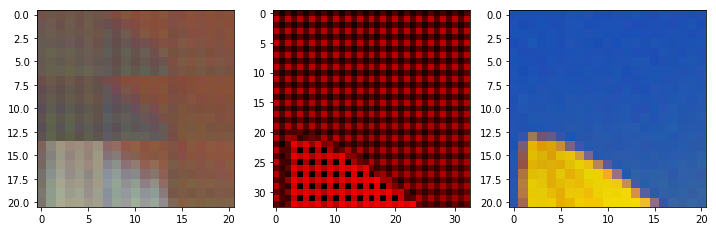

Epoch [412/500], Step [0/25], Loss: 0.018276294693350792
Epoch [412/500], Step [10/25], Loss: 0.01908445544540882
Epoch [412/500], Step [20/25], Loss: 0.0190916545689106

Finished Epoch 412, Loss --- mean: 0.01884834498167038, std 0.0008706597231817538



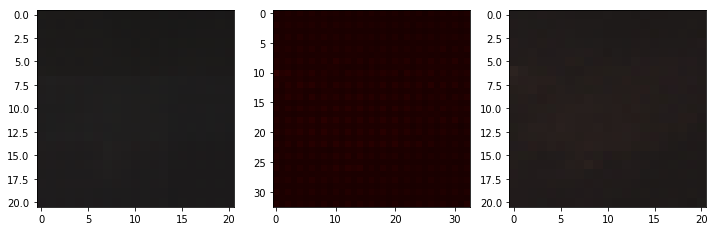

Epoch [413/500], Step [0/25], Loss: 0.019459733739495277
Epoch [413/500], Step [10/25], Loss: 0.018810223788022995
Epoch [413/500], Step [20/25], Loss: 0.018282797187566757

Finished Epoch 413, Loss --- mean: 0.018771614879369736, std 0.0005705409116601936



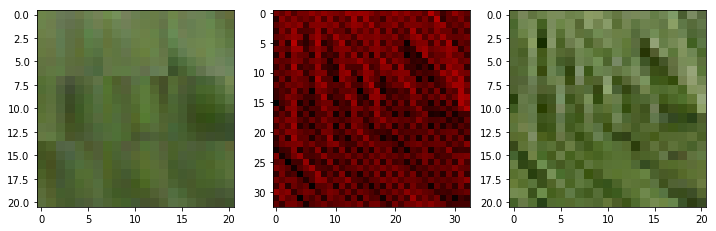

Epoch [414/500], Step [0/25], Loss: 0.019455712288618088
Epoch [414/500], Step [10/25], Loss: 0.018556201830506325
Epoch [414/500], Step [20/25], Loss: 0.017914289608597755

Finished Epoch 414, Loss --- mean: 0.018831827193498612, std 0.000760794062249194



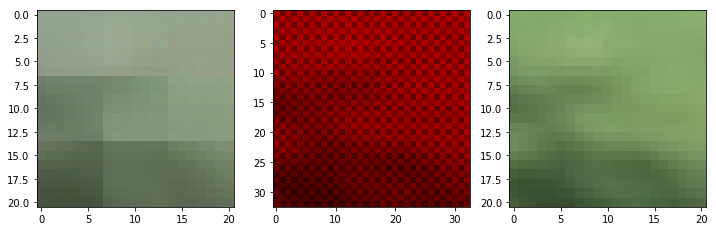

Epoch [415/500], Step [0/25], Loss: 0.019443364813923836
Epoch [415/500], Step [10/25], Loss: 0.019932346418499947
Epoch [415/500], Step [20/25], Loss: 0.020878121256828308

Finished Epoch 415, Loss --- mean: 0.019089173674583435, std 0.0007863338098042441



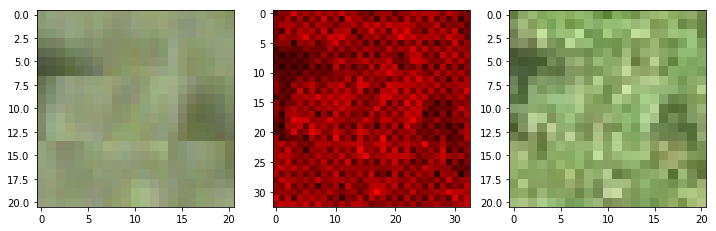

Epoch [416/500], Step [0/25], Loss: 0.0180712528526783
Epoch [416/500], Step [10/25], Loss: 0.018365511670708656
Epoch [416/500], Step [20/25], Loss: 0.018048958852887154

Finished Epoch 416, Loss --- mean: 0.018614425137639046, std 0.0007123718527124134



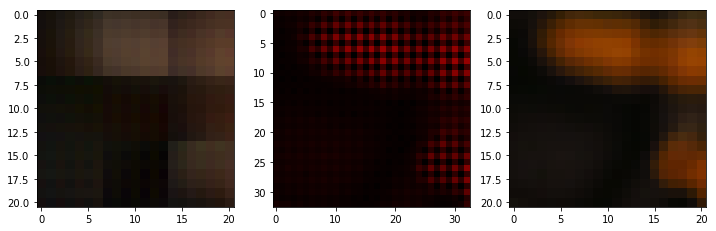

Epoch [417/500], Step [0/25], Loss: 0.018000146374106407
Epoch [417/500], Step [10/25], Loss: 0.018844256177544594
Epoch [417/500], Step [20/25], Loss: 0.018159965053200722

Finished Epoch 417, Loss --- mean: 0.018724908083677293, std 0.0008822286988720132



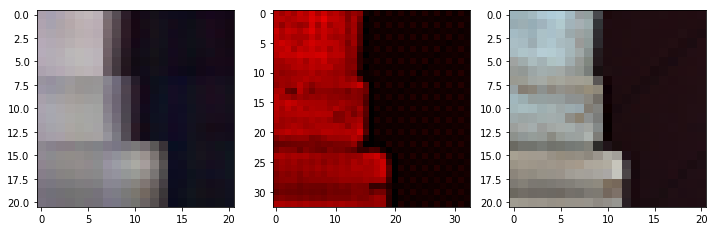

Epoch [418/500], Step [0/25], Loss: 0.01983252540230751
Epoch [418/500], Step [10/25], Loss: 0.018865691497921944
Epoch [418/500], Step [20/25], Loss: 0.01829068548977375

Finished Epoch 418, Loss --- mean: 0.01848125971853733, std 0.0009070877419052871



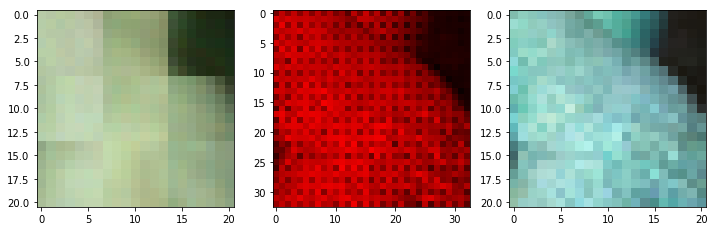

Epoch [419/500], Step [0/25], Loss: 0.017281020060181618
Epoch [419/500], Step [10/25], Loss: 0.020292624831199646
Epoch [419/500], Step [20/25], Loss: 0.017546938732266426

Finished Epoch 419, Loss --- mean: 0.018759906068444254, std 0.0009528911300630589



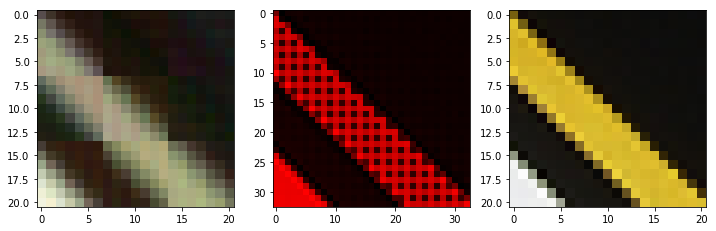

Epoch [420/500], Step [0/25], Loss: 0.018405776470899582
Epoch [420/500], Step [10/25], Loss: 0.018845772370696068
Epoch [420/500], Step [20/25], Loss: 0.020146606490015984

Finished Epoch 420, Loss --- mean: 0.018908730298280715, std 0.0005932586960022713



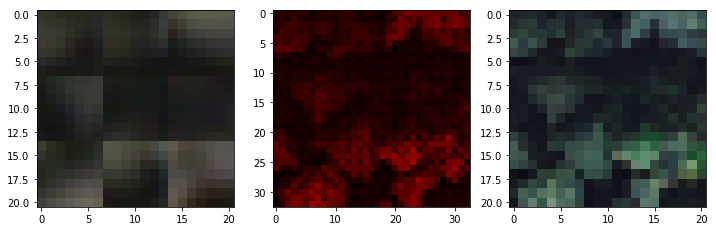

Epoch [421/500], Step [0/25], Loss: 0.018267380073666573
Epoch [421/500], Step [10/25], Loss: 0.020514436066150665
Epoch [421/500], Step [20/25], Loss: 0.01815873384475708

Finished Epoch 421, Loss --- mean: 0.018819809705018998, std 0.0009996837645188726



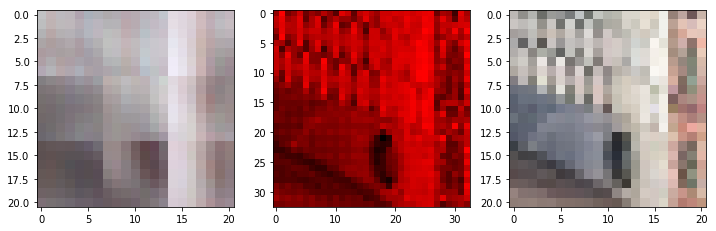

Epoch [422/500], Step [0/25], Loss: 0.018432607874274254
Epoch [422/500], Step [10/25], Loss: 0.017702871933579445
Epoch [422/500], Step [20/25], Loss: 0.01685027778148651

Finished Epoch 422, Loss --- mean: 0.018545623123645782, std 0.0007776820785863312



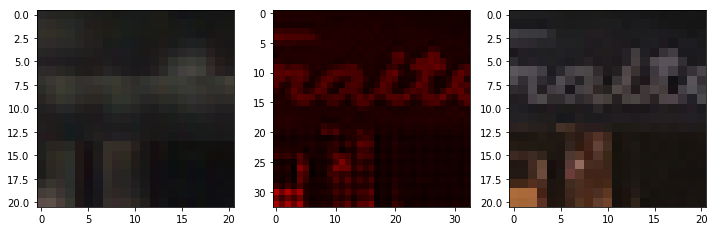

Epoch [423/500], Step [0/25], Loss: 0.01785913296043873
Epoch [423/500], Step [10/25], Loss: 0.018494032323360443
Epoch [423/500], Step [20/25], Loss: 0.01955890655517578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 423, Loss --- mean: 0.018829579874873163, std 0.0008592302664334829



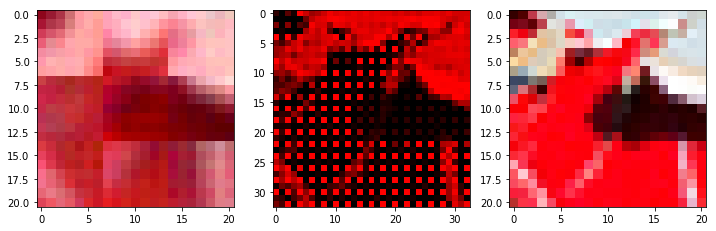

Epoch [424/500], Step [0/25], Loss: 0.01870027370750904
Epoch [424/500], Step [10/25], Loss: 0.01869768276810646
Epoch [424/500], Step [20/25], Loss: 0.017766112461686134

Finished Epoch 424, Loss --- mean: 0.01879445992410183, std 0.0006268024803485272



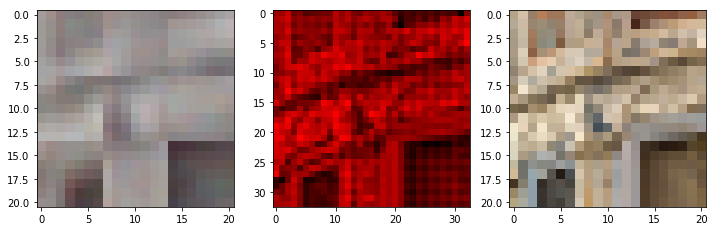

Epoch [425/500], Step [0/25], Loss: 0.018397221341729164
Epoch [425/500], Step [10/25], Loss: 0.019533028826117516
Epoch [425/500], Step [20/25], Loss: 0.018132846802473068

Finished Epoch 425, Loss --- mean: 0.01874732196331024, std 0.0007916138809452855



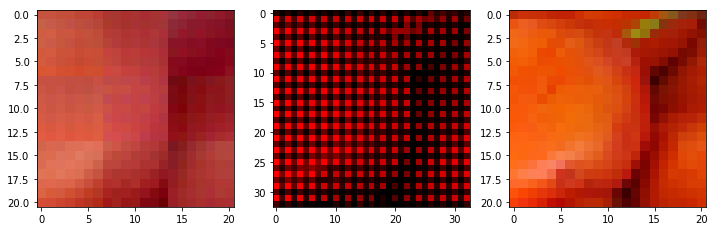

Epoch [426/500], Step [0/25], Loss: 0.01735471375286579
Epoch [426/500], Step [10/25], Loss: 0.01908997632563114
Epoch [426/500], Step [20/25], Loss: 0.01967436820268631

Finished Epoch 426, Loss --- mean: 0.01852602519094944, std 0.0010060331163247109



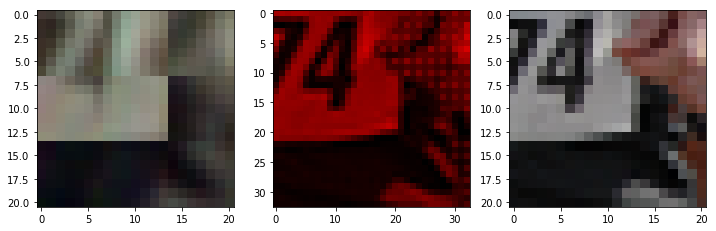

Epoch [427/500], Step [0/25], Loss: 0.019038258120417595
Epoch [427/500], Step [10/25], Loss: 0.017465494573116302
Epoch [427/500], Step [20/25], Loss: 0.018494466319680214

Finished Epoch 427, Loss --- mean: 0.01858606845140457, std 0.0006797474870896303



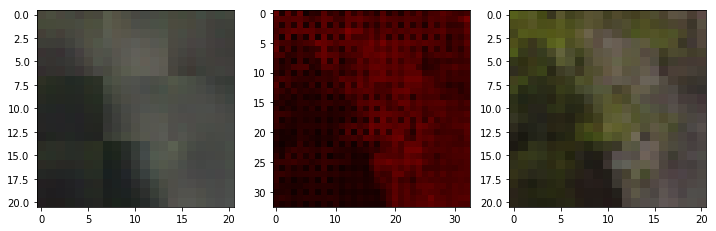

Epoch [428/500], Step [0/25], Loss: 0.018608171492815018
Epoch [428/500], Step [10/25], Loss: 0.019270097836852074
Epoch [428/500], Step [20/25], Loss: 0.02040768787264824

Finished Epoch 428, Loss --- mean: 0.018847234919667243, std 0.0008051941886109843



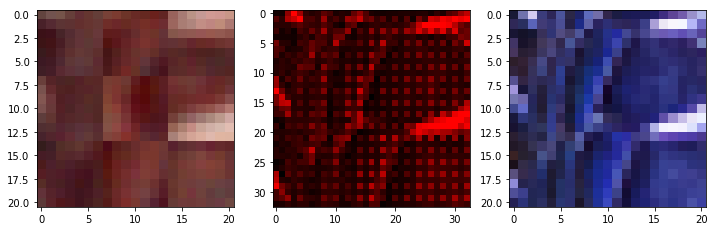

Epoch [429/500], Step [0/25], Loss: 0.018580490723252296
Epoch [429/500], Step [10/25], Loss: 0.01977604627609253
Epoch [429/500], Step [20/25], Loss: 0.01889880560338497

Finished Epoch 429, Loss --- mean: 0.018607295006513595, std 0.0007496957938197215



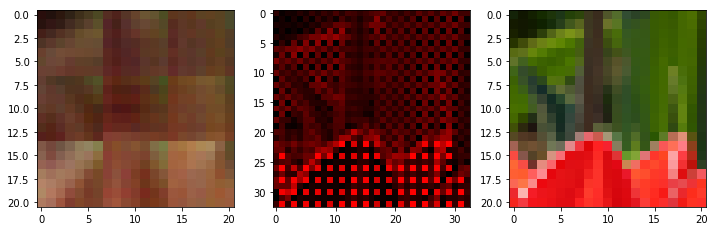

Epoch [430/500], Step [0/25], Loss: 0.018758993595838547
Epoch [430/500], Step [10/25], Loss: 0.01940564066171646
Epoch [430/500], Step [20/25], Loss: 0.01927223429083824

Finished Epoch 430, Loss --- mean: 0.018520985469222068, std 0.0008502141380111415



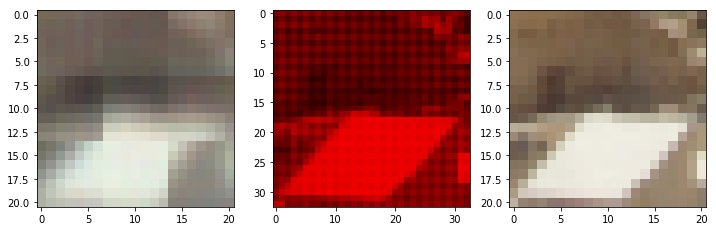

Epoch [431/500], Step [0/25], Loss: 0.018625274300575256
Epoch [431/500], Step [10/25], Loss: 0.020124780014157295
Epoch [431/500], Step [20/25], Loss: 0.01809115707874298

Finished Epoch 431, Loss --- mean: 0.01868798039853573, std 0.0008337721239496624



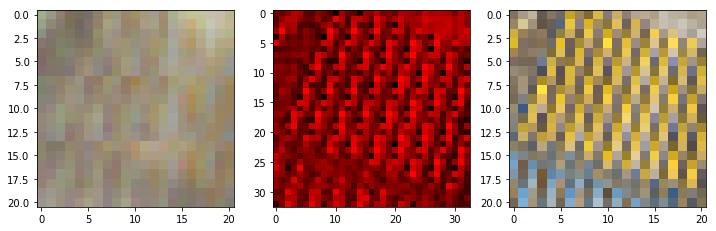

Epoch [432/500], Step [0/25], Loss: 0.019080325961112976
Epoch [432/500], Step [10/25], Loss: 0.017586754634976387
Epoch [432/500], Step [20/25], Loss: 0.018309758976101875

Finished Epoch 432, Loss --- mean: 0.018652176037430763, std 0.0007550515378852517



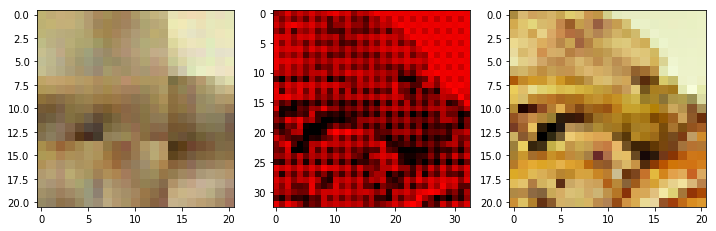

Epoch [433/500], Step [0/25], Loss: 0.017655465751886368
Epoch [433/500], Step [10/25], Loss: 0.019245315343141556
Epoch [433/500], Step [20/25], Loss: 0.01741817593574524

Finished Epoch 433, Loss --- mean: 0.018671964555978776, std 0.00093268743457447



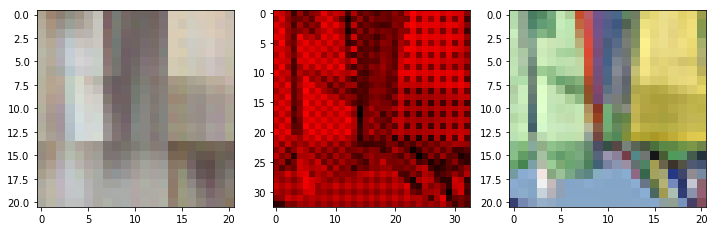

Epoch [434/500], Step [0/25], Loss: 0.018378105014562607
Epoch [434/500], Step [10/25], Loss: 0.019305605441331863
Epoch [434/500], Step [20/25], Loss: 0.01799929141998291

Finished Epoch 434, Loss --- mean: 0.018808350339531897, std 0.0007700383607258199



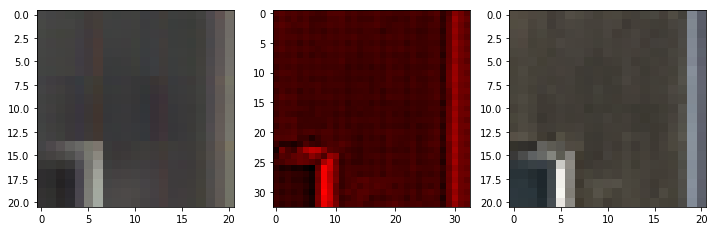

Epoch [435/500], Step [0/25], Loss: 0.017275050282478333
Epoch [435/500], Step [10/25], Loss: 0.018140068277716637
Epoch [435/500], Step [20/25], Loss: 0.01864716038107872

Finished Epoch 435, Loss --- mean: 0.018766376823186874, std 0.0008467855822133028



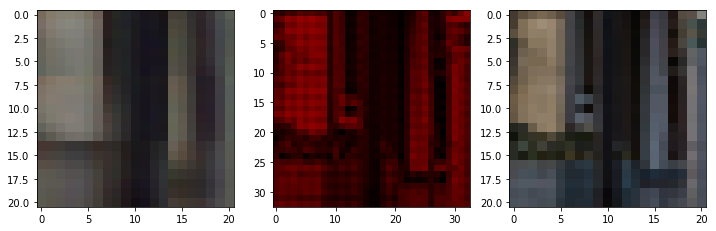

Epoch [436/500], Step [0/25], Loss: 0.018796151503920555
Epoch [436/500], Step [10/25], Loss: 0.017865154892206192
Epoch [436/500], Step [20/25], Loss: 0.0204699095338583

Finished Epoch 436, Loss --- mean: 0.01890485867857933, std 0.0007055990637313496



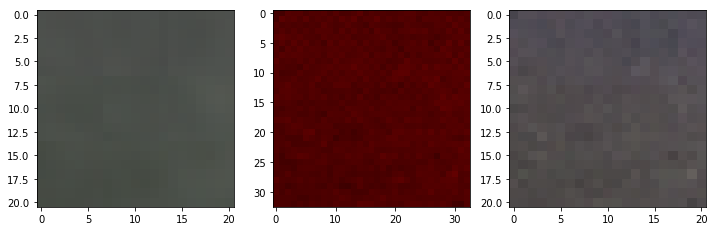

Epoch [437/500], Step [0/25], Loss: 0.01855187676846981
Epoch [437/500], Step [10/25], Loss: 0.019458135589957237
Epoch [437/500], Step [20/25], Loss: 0.019046705216169357

Finished Epoch 437, Loss --- mean: 0.01875478744506836, std 0.0007633085333805066



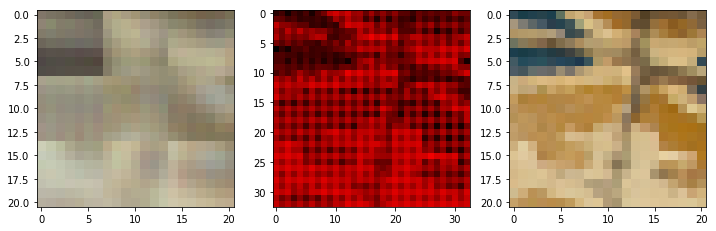

Epoch [438/500], Step [0/25], Loss: 0.018743310123682022
Epoch [438/500], Step [10/25], Loss: 0.018035655841231346
Epoch [438/500], Step [20/25], Loss: 0.019414937123656273

Finished Epoch 438, Loss --- mean: 0.018841306194663048, std 0.0005408991570725407



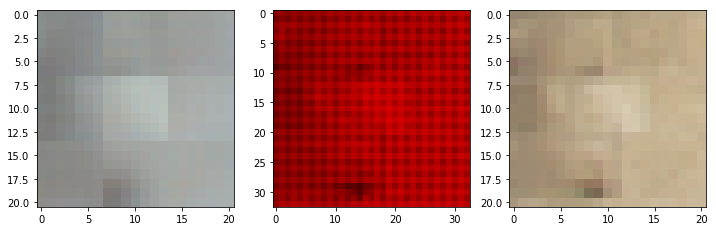

Epoch [439/500], Step [0/25], Loss: 0.019244972616434097
Epoch [439/500], Step [10/25], Loss: 0.018262654542922974
Epoch [439/500], Step [20/25], Loss: 0.01793496124446392

Finished Epoch 439, Loss --- mean: 0.01845630869269371, std 0.0006166163429175519



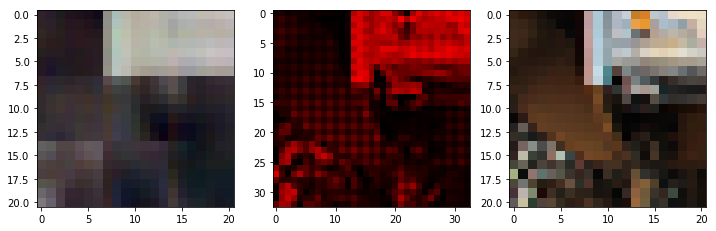

Epoch [440/500], Step [0/25], Loss: 0.018089866265654564
Epoch [440/500], Step [10/25], Loss: 0.017505783587694168
Epoch [440/500], Step [20/25], Loss: 0.018974434584379196

Finished Epoch 440, Loss --- mean: 0.018539304733276366, std 0.0008837859610822881



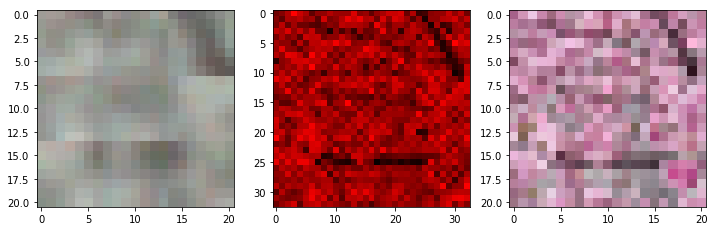

Epoch [441/500], Step [0/25], Loss: 0.018319079652428627
Epoch [441/500], Step [10/25], Loss: 0.01778195984661579
Epoch [441/500], Step [20/25], Loss: 0.017913421615958214

Finished Epoch 441, Loss --- mean: 0.01852127745747566, std 0.0010805760512271304



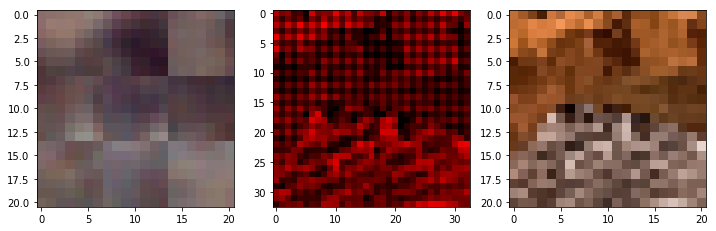

Epoch [442/500], Step [0/25], Loss: 0.01931796222925186
Epoch [442/500], Step [10/25], Loss: 0.01823263242840767
Epoch [442/500], Step [20/25], Loss: 0.018179964274168015

Finished Epoch 442, Loss --- mean: 0.018462490215897562, std 0.0007556894144242228



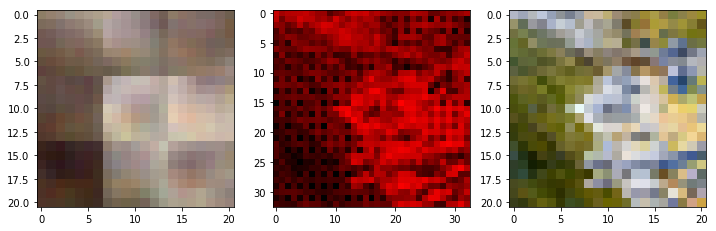

Epoch [443/500], Step [0/25], Loss: 0.0183236263692379
Epoch [443/500], Step [10/25], Loss: 0.019333399832248688
Epoch [443/500], Step [20/25], Loss: 0.019781162962317467

Finished Epoch 443, Loss --- mean: 0.01862961009144783, std 0.0006479526108669331



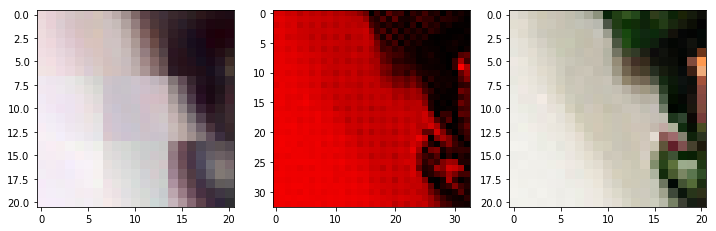

Epoch [444/500], Step [0/25], Loss: 0.019588826224207878
Epoch [444/500], Step [10/25], Loss: 0.01920170895755291
Epoch [444/500], Step [20/25], Loss: 0.018331710249185562

Finished Epoch 444, Loss --- mean: 0.018782031685113908, std 0.0009555164516561136



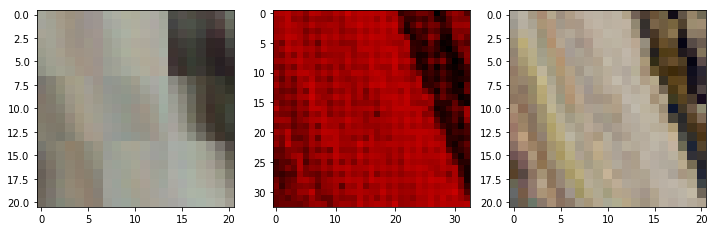

Epoch [445/500], Step [0/25], Loss: 0.01780977100133896
Epoch [445/500], Step [10/25], Loss: 0.017338134348392487
Epoch [445/500], Step [20/25], Loss: 0.018368104472756386

Finished Epoch 445, Loss --- mean: 0.018718143478035926, std 0.0007002103233562249



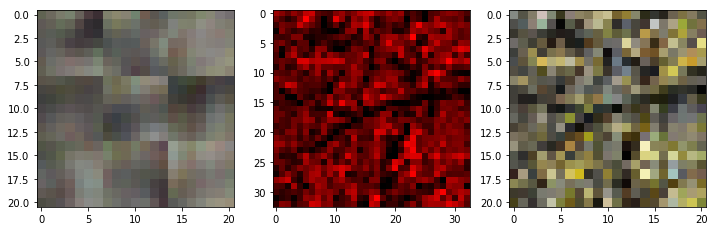

Epoch [446/500], Step [0/25], Loss: 0.01761315017938614
Epoch [446/500], Step [10/25], Loss: 0.01900867186486721
Epoch [446/500], Step [20/25], Loss: 0.018983403220772743

Finished Epoch 446, Loss --- mean: 0.018855268508195876, std 0.0009058949359936914



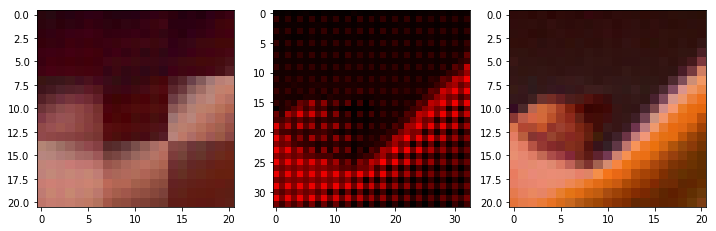

Epoch [447/500], Step [0/25], Loss: 0.017718154937028885
Epoch [447/500], Step [10/25], Loss: 0.018690571188926697
Epoch [447/500], Step [20/25], Loss: 0.018912144005298615

Finished Epoch 447, Loss --- mean: 0.018519883304834367, std 0.0006494860002175311



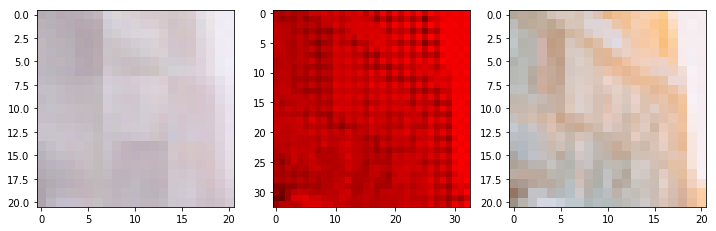

Epoch [448/500], Step [0/25], Loss: 0.01930250972509384
Epoch [448/500], Step [10/25], Loss: 0.017796946689486504
Epoch [448/500], Step [20/25], Loss: 0.01979219913482666

Finished Epoch 448, Loss --- mean: 0.018756042458117007, std 0.0010119862698104369



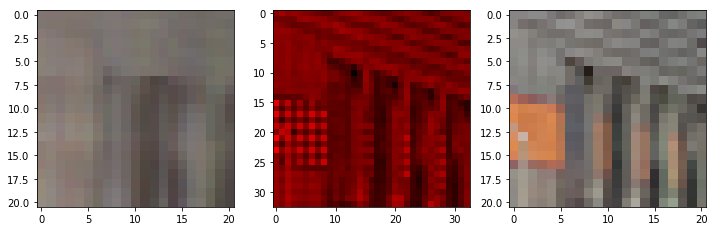

Epoch [449/500], Step [0/25], Loss: 0.018260406330227852
Epoch [449/500], Step [10/25], Loss: 0.018931180238723755
Epoch [449/500], Step [20/25], Loss: 0.01965000294148922

Finished Epoch 449, Loss --- mean: 0.018762602806091308, std 0.0006885515148144036



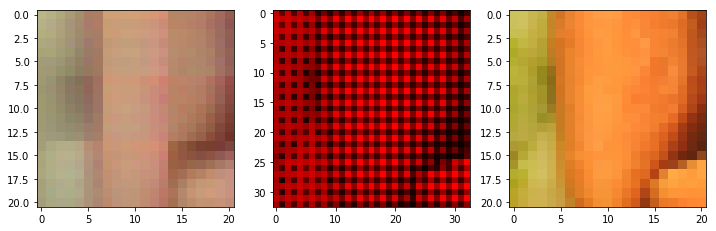

Epoch [450/500], Step [0/25], Loss: 0.01727406308054924
Epoch [450/500], Step [10/25], Loss: 0.01902543194591999
Epoch [450/500], Step [20/25], Loss: 0.01732652448117733

Finished Epoch 450, Loss --- mean: 0.01836985170841217, std 0.0009461822352151002



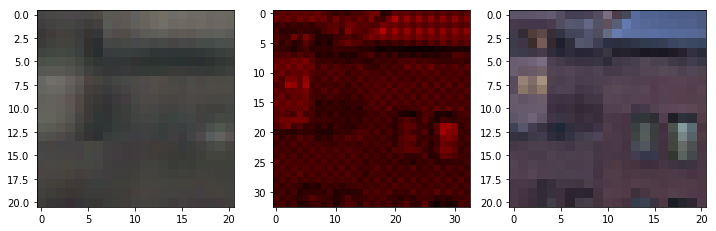

Epoch [451/500], Step [0/25], Loss: 0.01663041301071644
Epoch [451/500], Step [10/25], Loss: 0.018115751445293427
Epoch [451/500], Step [20/25], Loss: 0.018233075737953186

Finished Epoch 451, Loss --- mean: 0.01838266022503376, std 0.000999568042848041



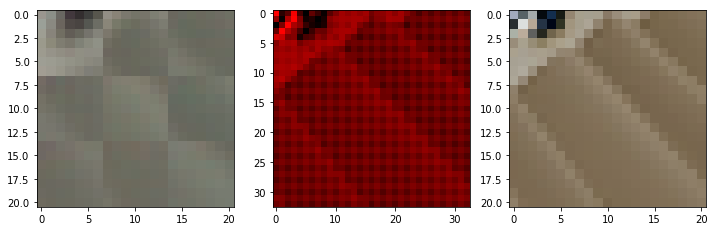

Epoch [452/500], Step [0/25], Loss: 0.017731260508298874
Epoch [452/500], Step [10/25], Loss: 0.018556101247668266
Epoch [452/500], Step [20/25], Loss: 0.019724305719137192

Finished Epoch 452, Loss --- mean: 0.018352094292640685, std 0.0006872438021231569



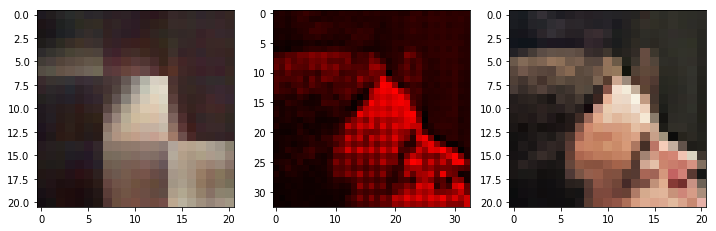

Epoch [453/500], Step [0/25], Loss: 0.017218058928847313
Epoch [453/500], Step [10/25], Loss: 0.019804924726486206
Epoch [453/500], Step [20/25], Loss: 0.020145922899246216

Finished Epoch 453, Loss --- mean: 0.018687790781259535, std 0.0010017435682566883



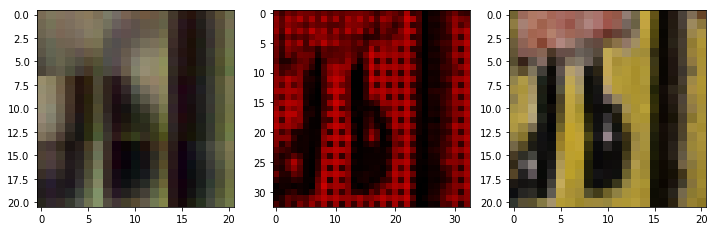

Epoch [454/500], Step [0/25], Loss: 0.01905635930597782
Epoch [454/500], Step [10/25], Loss: 0.01954755187034607
Epoch [454/500], Step [20/25], Loss: 0.017358221113681793

Finished Epoch 454, Loss --- mean: 0.018697605356574058, std 0.0008169755573335313



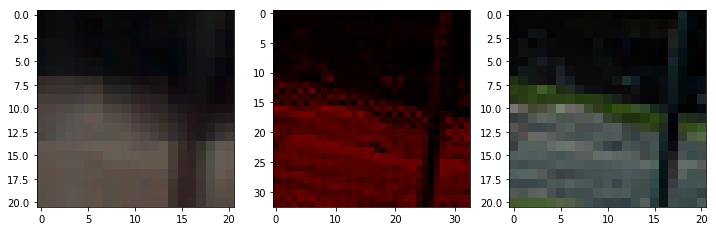

Epoch [455/500], Step [0/25], Loss: 0.01797613874077797
Epoch [455/500], Step [10/25], Loss: 0.018709812313318253
Epoch [455/500], Step [20/25], Loss: 0.01927412487566471

Finished Epoch 455, Loss --- mean: 0.01901170626282692, std 0.0006090715927069649



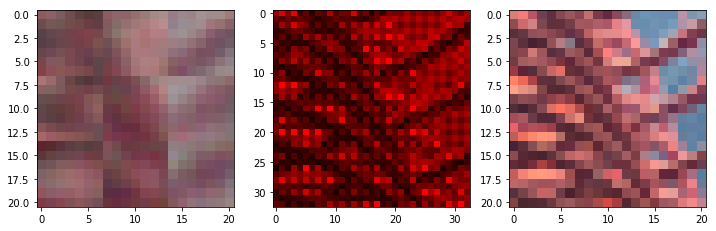

Epoch [456/500], Step [0/25], Loss: 0.018430234864354134
Epoch [456/500], Step [10/25], Loss: 0.020031137391924858
Epoch [456/500], Step [20/25], Loss: 0.01830958016216755

Finished Epoch 456, Loss --- mean: 0.018491436317563056, std 0.000776284797592149



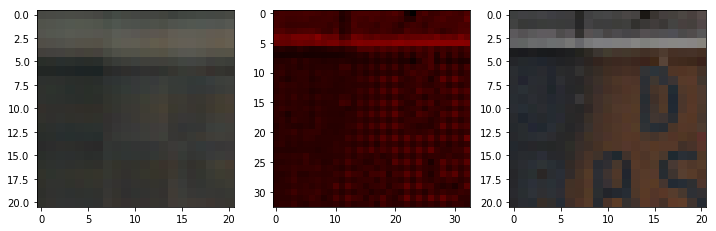

Epoch [457/500], Step [0/25], Loss: 0.018935950472950935
Epoch [457/500], Step [10/25], Loss: 0.018412133678793907
Epoch [457/500], Step [20/25], Loss: 0.018993889912962914

Finished Epoch 457, Loss --- mean: 0.018476118445396424, std 0.0006335942528400224



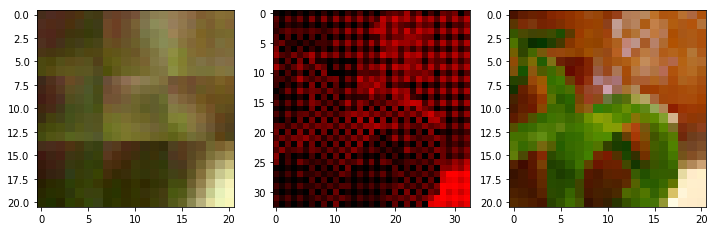

Epoch [458/500], Step [0/25], Loss: 0.018268579617142677
Epoch [458/500], Step [10/25], Loss: 0.019516676664352417
Epoch [458/500], Step [20/25], Loss: 0.018473822623491287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 458, Loss --- mean: 0.018570791110396386, std 0.0006989317460842146



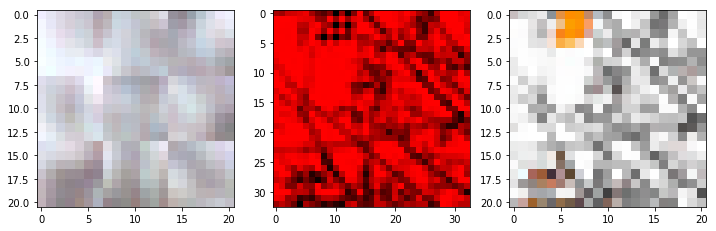

Epoch [459/500], Step [0/25], Loss: 0.01902845688164234
Epoch [459/500], Step [10/25], Loss: 0.01822182536125183
Epoch [459/500], Step [20/25], Loss: 0.018226798623800278

Finished Epoch 459, Loss --- mean: 0.018695930689573287, std 0.0008064726968452996



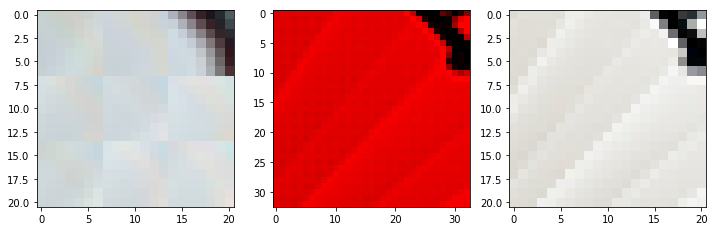

Epoch [460/500], Step [0/25], Loss: 0.019217099994421005
Epoch [460/500], Step [10/25], Loss: 0.017845885828137398
Epoch [460/500], Step [20/25], Loss: 0.020395779982209206

Finished Epoch 460, Loss --- mean: 0.018662963956594468, std 0.0008604823770091684



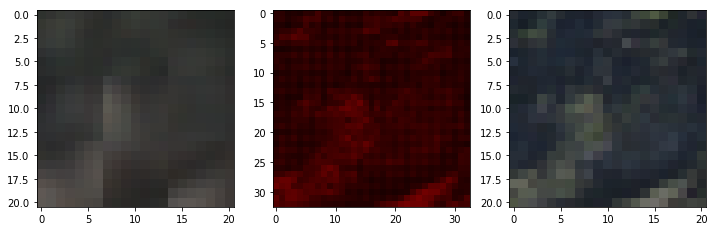

Epoch [461/500], Step [0/25], Loss: 0.01961863413453102
Epoch [461/500], Step [10/25], Loss: 0.018663357943296432
Epoch [461/500], Step [20/25], Loss: 0.01839669980108738

Finished Epoch 461, Loss --- mean: 0.018663073405623436, std 0.0007250548715718675



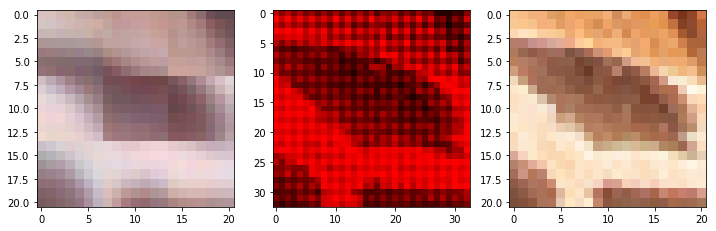

Epoch [462/500], Step [0/25], Loss: 0.018264954909682274
Epoch [462/500], Step [10/25], Loss: 0.0183491762727499
Epoch [462/500], Step [20/25], Loss: 0.01827877201139927


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 462, Loss --- mean: 0.01836036503314972, std 0.0007608700470875034



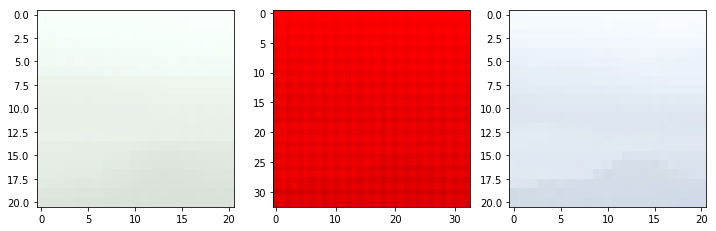

Epoch [463/500], Step [0/25], Loss: 0.018758302554488182
Epoch [463/500], Step [10/25], Loss: 0.018784387037158012
Epoch [463/500], Step [20/25], Loss: 0.018432103097438812

Finished Epoch 463, Loss --- mean: 0.018325947448611258, std 0.0007030630576665611



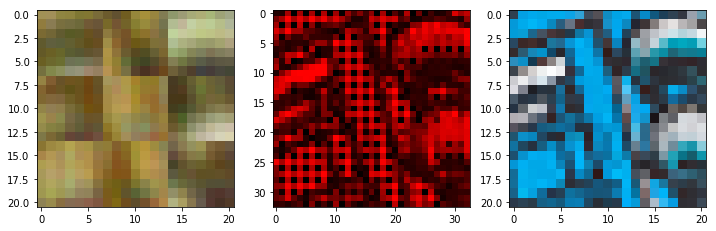

Epoch [464/500], Step [0/25], Loss: 0.01893559843301773
Epoch [464/500], Step [10/25], Loss: 0.01822175271809101
Epoch [464/500], Step [20/25], Loss: 0.017539789900183678

Finished Epoch 464, Loss --- mean: 0.01850611187517643, std 0.0007323550423852155



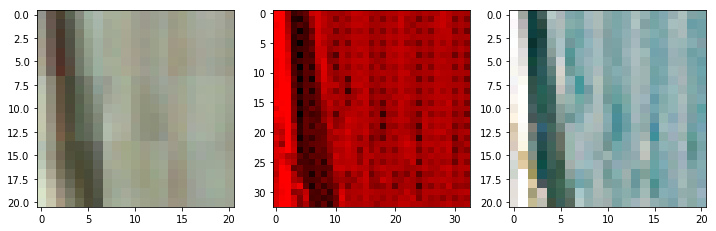

Epoch [465/500], Step [0/25], Loss: 0.019086748361587524
Epoch [465/500], Step [10/25], Loss: 0.01912671886384487
Epoch [465/500], Step [20/25], Loss: 0.018593190237879753

Finished Epoch 465, Loss --- mean: 0.018683181032538413, std 0.0007638512781069135



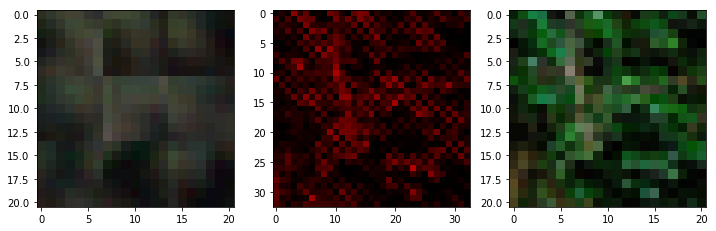

Epoch [466/500], Step [0/25], Loss: 0.018795756623148918
Epoch [466/500], Step [10/25], Loss: 0.017316682264208794
Epoch [466/500], Step [20/25], Loss: 0.0195807833224535

Finished Epoch 466, Loss --- mean: 0.01876021094620228, std 0.0009079795420496063



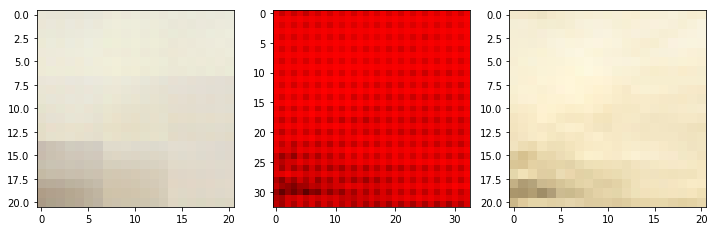

Epoch [467/500], Step [0/25], Loss: 0.01953773759305477
Epoch [467/500], Step [10/25], Loss: 0.01705898530781269
Epoch [467/500], Step [20/25], Loss: 0.01912159100174904

Finished Epoch 467, Loss --- mean: 0.018668671771883964, std 0.0007324594265899843



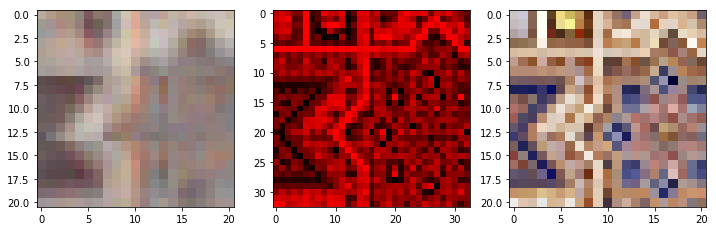

Epoch [468/500], Step [0/25], Loss: 0.018622633069753647
Epoch [468/500], Step [10/25], Loss: 0.019377676770091057
Epoch [468/500], Step [20/25], Loss: 0.018014801666140556


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 468, Loss --- mean: 0.018578034117817877, std 0.000665097656503867



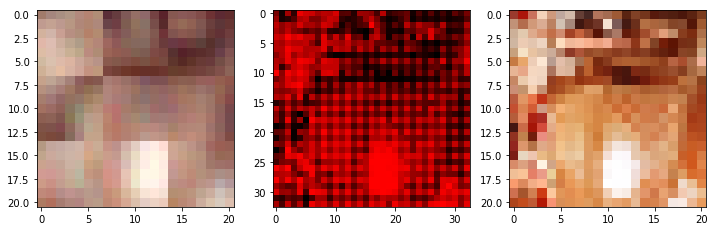

Epoch [469/500], Step [0/25], Loss: 0.01794392056763172
Epoch [469/500], Step [10/25], Loss: 0.017568133771419525
Epoch [469/500], Step [20/25], Loss: 0.019287480041384697

Finished Epoch 469, Loss --- mean: 0.018386837169528006, std 0.0008316061099145756



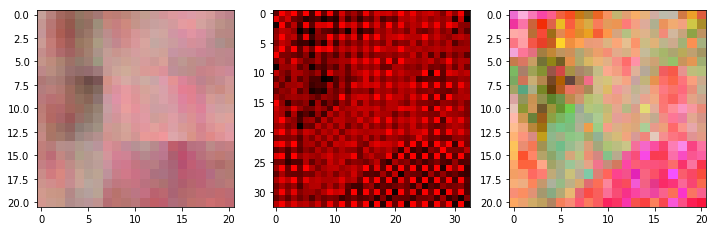

Epoch [470/500], Step [0/25], Loss: 0.018601328134536743
Epoch [470/500], Step [10/25], Loss: 0.01794247329235077
Epoch [470/500], Step [20/25], Loss: 0.01822550967335701

Finished Epoch 470, Loss --- mean: 0.01836722865700722, std 0.0005937760560974192



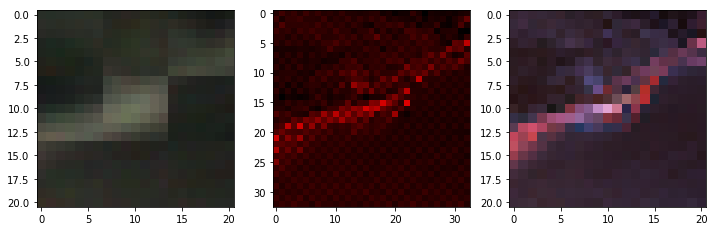

Epoch [471/500], Step [0/25], Loss: 0.019641105085611343
Epoch [471/500], Step [10/25], Loss: 0.01666669175028801
Epoch [471/500], Step [20/25], Loss: 0.01886659674346447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 471, Loss --- mean: 0.01835619755089283, std 0.0008045351168851875



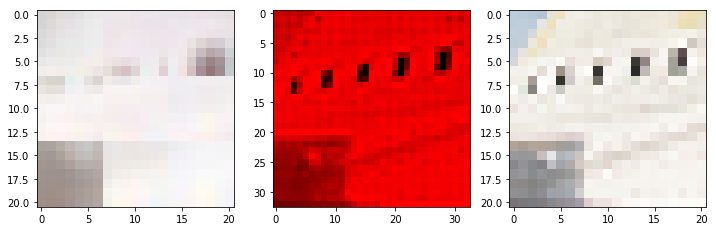

Epoch [472/500], Step [0/25], Loss: 0.018227219581604004
Epoch [472/500], Step [10/25], Loss: 0.01926186867058277
Epoch [472/500], Step [20/25], Loss: 0.019718270748853683

Finished Epoch 472, Loss --- mean: 0.018702178597450256, std 0.0008165020760068484



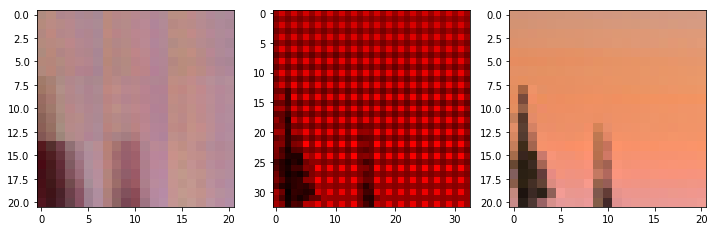

Epoch [473/500], Step [0/25], Loss: 0.018535546958446503
Epoch [473/500], Step [10/25], Loss: 0.02005995810031891
Epoch [473/500], Step [20/25], Loss: 0.017932845279574394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 473, Loss --- mean: 0.018748299926519395, std 0.0009368809347792143



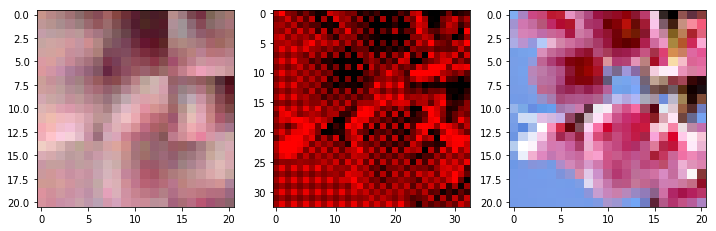

Epoch [474/500], Step [0/25], Loss: 0.018793640658259392
Epoch [474/500], Step [10/25], Loss: 0.01882036030292511
Epoch [474/500], Step [20/25], Loss: 0.017937391996383667

Finished Epoch 474, Loss --- mean: 0.018572137951850892, std 0.0006730846385448845



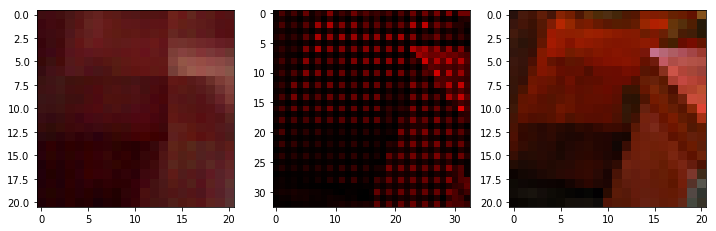

Epoch [475/500], Step [0/25], Loss: 0.018196996301412582
Epoch [475/500], Step [10/25], Loss: 0.017643943428993225
Epoch [475/500], Step [20/25], Loss: 0.01900770142674446

Finished Epoch 475, Loss --- mean: 0.01852755680680275, std 0.000881191168326075



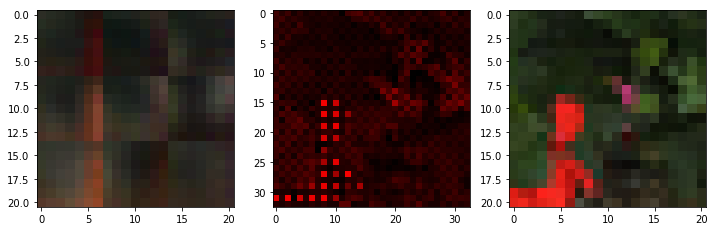

Epoch [476/500], Step [0/25], Loss: 0.01932649314403534
Epoch [476/500], Step [10/25], Loss: 0.019322268664836884
Epoch [476/500], Step [20/25], Loss: 0.019763026386499405

Finished Epoch 476, Loss --- mean: 0.018584932535886764, std 0.0007537983705602426



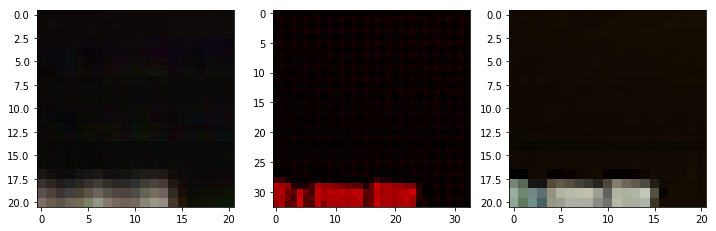

Epoch [477/500], Step [0/25], Loss: 0.01740964688360691
Epoch [477/500], Step [10/25], Loss: 0.01852983795106411
Epoch [477/500], Step [20/25], Loss: 0.016867689788341522

Finished Epoch 477, Loss --- mean: 0.018514063358306885, std 0.0009131787599143246



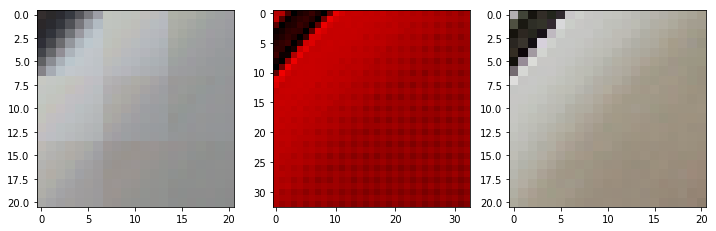

Epoch [478/500], Step [0/25], Loss: 0.017576513811945915
Epoch [478/500], Step [10/25], Loss: 0.018922707065939903
Epoch [478/500], Step [20/25], Loss: 0.01937664858996868

Finished Epoch 478, Loss --- mean: 0.01835306651890278, std 0.0006999744368332286



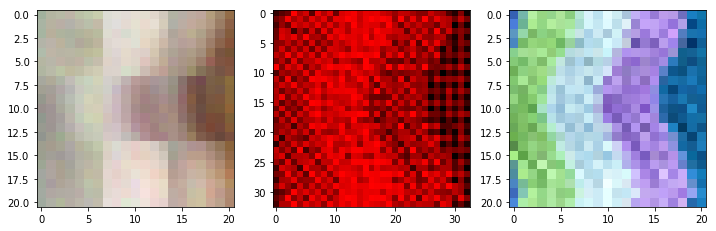

Epoch [479/500], Step [0/25], Loss: 0.018871158361434937
Epoch [479/500], Step [10/25], Loss: 0.01790759526193142
Epoch [479/500], Step [20/25], Loss: 0.019357748329639435

Finished Epoch 479, Loss --- mean: 0.018425818979740143, std 0.0007740535518244849



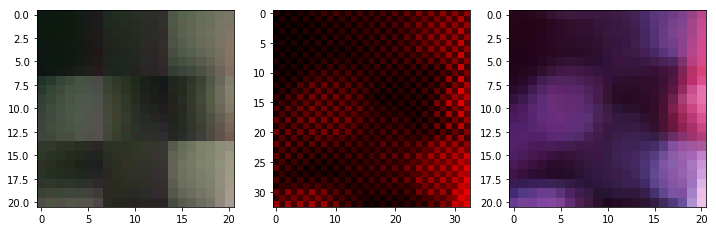

Epoch [480/500], Step [0/25], Loss: 0.018226802349090576
Epoch [480/500], Step [10/25], Loss: 0.018106063827872276
Epoch [480/500], Step [20/25], Loss: 0.018557332456111908

Finished Epoch 480, Loss --- mean: 0.018452083691954613, std 0.0007636806332232417



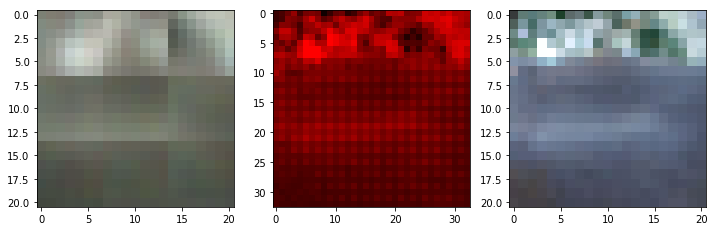

Epoch [481/500], Step [0/25], Loss: 0.017615631222724915
Epoch [481/500], Step [10/25], Loss: 0.017789091914892197
Epoch [481/500], Step [20/25], Loss: 0.01798219420015812

Finished Epoch 481, Loss --- mean: 0.018453416153788565, std 0.0008302852394151981



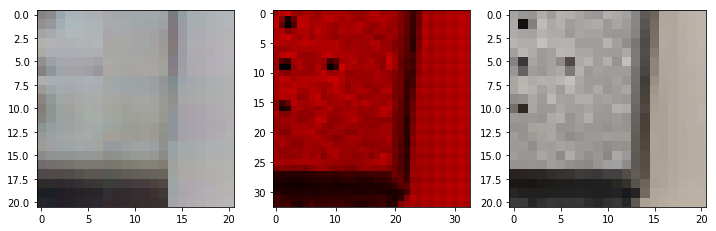

Epoch [482/500], Step [0/25], Loss: 0.01883765496313572
Epoch [482/500], Step [10/25], Loss: 0.01764969900250435
Epoch [482/500], Step [20/25], Loss: 0.02115132287144661

Finished Epoch 482, Loss --- mean: 0.01860054947435856, std 0.0007922820645331685



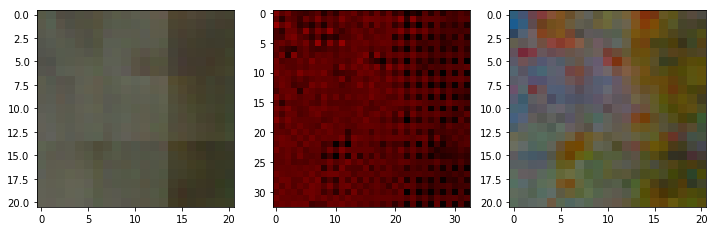

Epoch [483/500], Step [0/25], Loss: 0.01757214218378067
Epoch [483/500], Step [10/25], Loss: 0.018521826714277267
Epoch [483/500], Step [20/25], Loss: 0.018387161195278168

Finished Epoch 483, Loss --- mean: 0.018497613742947578, std 0.0007115248855288902



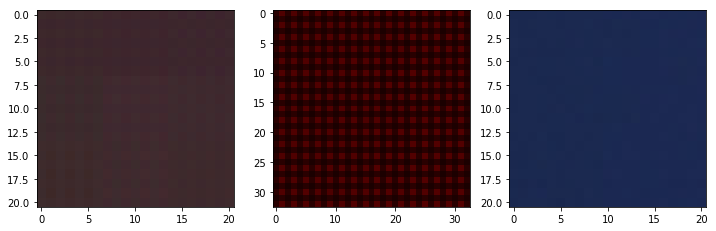

Epoch [484/500], Step [0/25], Loss: 0.01861899346113205
Epoch [484/500], Step [10/25], Loss: 0.01893145777285099
Epoch [484/500], Step [20/25], Loss: 0.0173906572163105

Finished Epoch 484, Loss --- mean: 0.01850733198225498, std 0.0010005953188813538



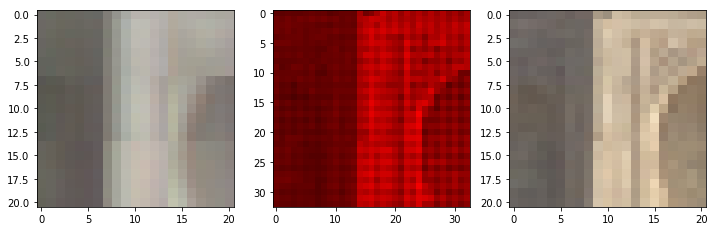

Epoch [485/500], Step [0/25], Loss: 0.019233601167798042
Epoch [485/500], Step [10/25], Loss: 0.01824893243610859
Epoch [485/500], Step [20/25], Loss: 0.018816586583852768

Finished Epoch 485, Loss --- mean: 0.018443039059638976, std 0.0007679185461483658



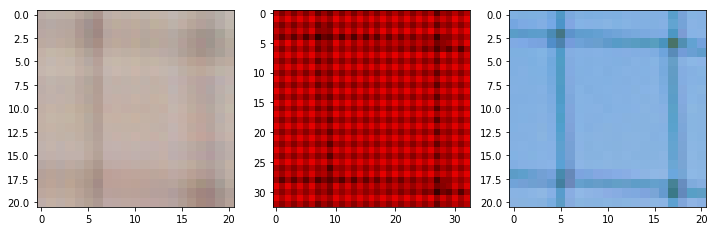

Epoch [486/500], Step [0/25], Loss: 0.017770355567336082
Epoch [486/500], Step [10/25], Loss: 0.018788950517773628
Epoch [486/500], Step [20/25], Loss: 0.017977336421608925

Finished Epoch 486, Loss --- mean: 0.01852551020681858, std 0.0005962938011194613



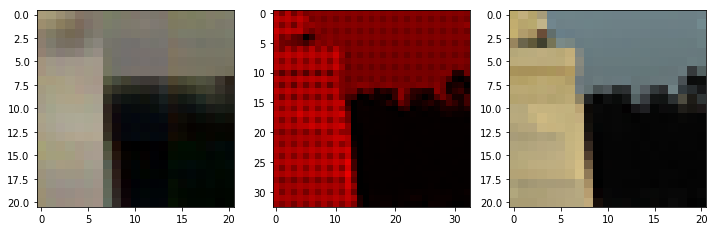

Epoch [487/500], Step [0/25], Loss: 0.01865386590361595
Epoch [487/500], Step [10/25], Loss: 0.01856052502989769
Epoch [487/500], Step [20/25], Loss: 0.018796401098370552

Finished Epoch 487, Loss --- mean: 0.018572129383683203, std 0.0007674073056534941



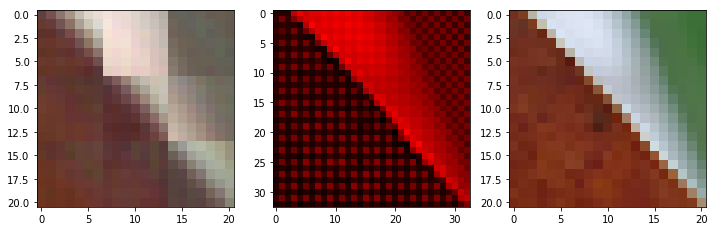

Epoch [488/500], Step [0/25], Loss: 0.01907031238079071
Epoch [488/500], Step [10/25], Loss: 0.018934883177280426
Epoch [488/500], Step [20/25], Loss: 0.017866695299744606

Finished Epoch 488, Loss --- mean: 0.018690608143806457, std 0.0006684548355327227



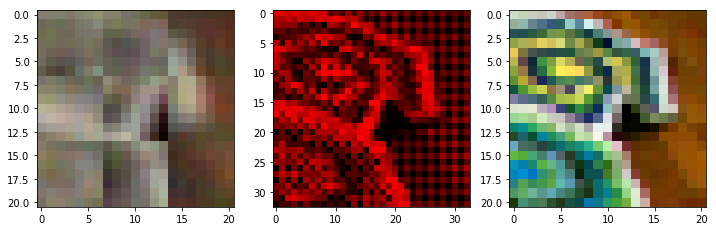

Epoch [489/500], Step [0/25], Loss: 0.018810546025633812
Epoch [489/500], Step [10/25], Loss: 0.018180223181843758
Epoch [489/500], Step [20/25], Loss: 0.01660502888262272

Finished Epoch 489, Loss --- mean: 0.01847173534333706, std 0.0009343801944608579



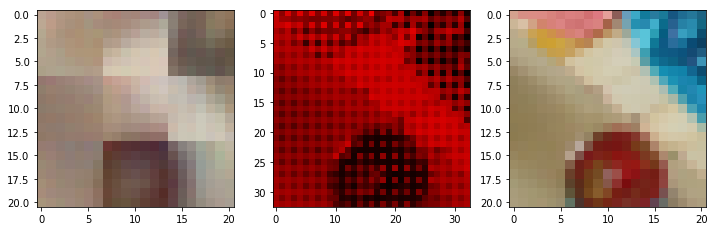

Epoch [490/500], Step [0/25], Loss: 0.018555082380771637
Epoch [490/500], Step [10/25], Loss: 0.019418025389313698
Epoch [490/500], Step [20/25], Loss: 0.019397776573896408

Finished Epoch 490, Loss --- mean: 0.018529151380062104, std 0.0007290424841583621



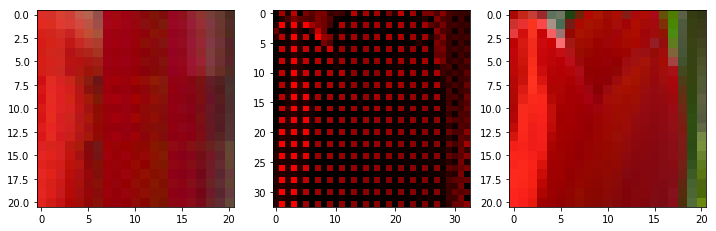

Epoch [491/500], Step [0/25], Loss: 0.019003624096512794
Epoch [491/500], Step [10/25], Loss: 0.018657969310879707
Epoch [491/500], Step [20/25], Loss: 0.01764587126672268

Finished Epoch 491, Loss --- mean: 0.018444239795207977, std 0.0008821090766426846



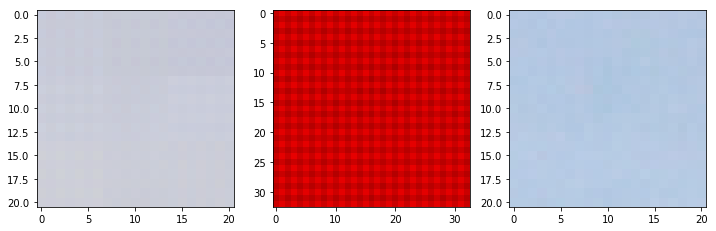

Epoch [492/500], Step [0/25], Loss: 0.018173974007368088
Epoch [492/500], Step [10/25], Loss: 0.017480522394180298
Epoch [492/500], Step [20/25], Loss: 0.016919823363423347

Finished Epoch 492, Loss --- mean: 0.018431080505251884, std 0.0009293293793229064



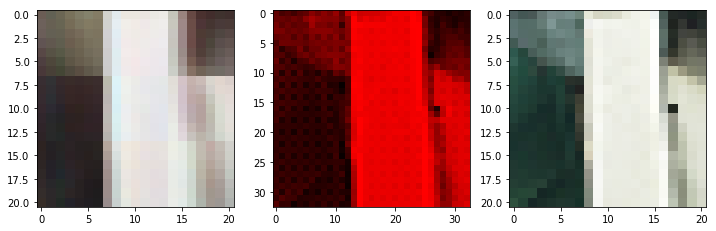

Epoch [493/500], Step [0/25], Loss: 0.018939146772027016
Epoch [493/500], Step [10/25], Loss: 0.01751299761235714
Epoch [493/500], Step [20/25], Loss: 0.017906473949551582

Finished Epoch 493, Loss --- mean: 0.01829152390360832, std 0.0008529169570410518



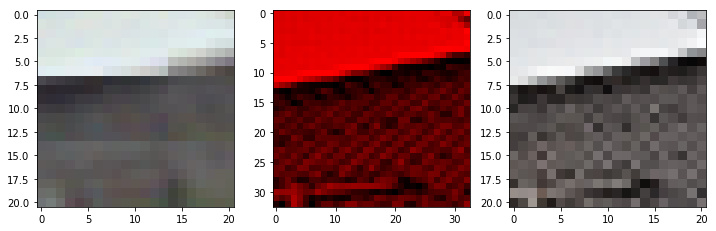

Epoch [494/500], Step [0/25], Loss: 0.01735796593129635
Epoch [494/500], Step [10/25], Loss: 0.01831304095685482
Epoch [494/500], Step [20/25], Loss: 0.018031170591711998

Finished Epoch 494, Loss --- mean: 0.0182391969114542, std 0.0009560231724131877



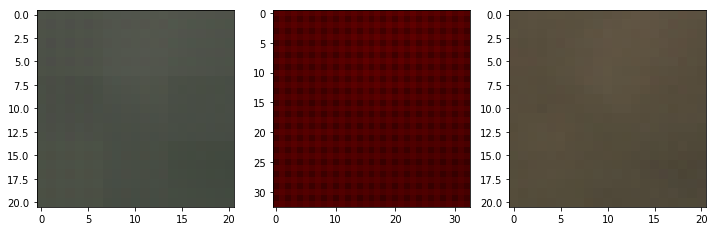

Epoch [495/500], Step [0/25], Loss: 0.018194017931818962
Epoch [495/500], Step [10/25], Loss: 0.02063528075814247
Epoch [495/500], Step [20/25], Loss: 0.01906582899391651

Finished Epoch 495, Loss --- mean: 0.018224457651376723, std 0.000897808342501512



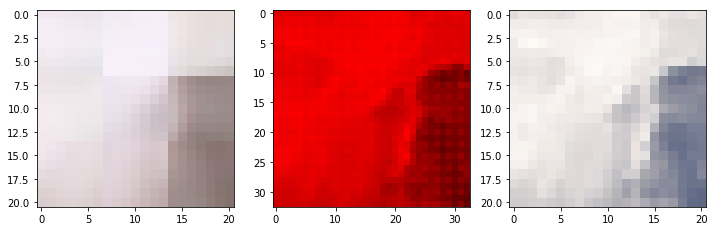

Epoch [496/500], Step [0/25], Loss: 0.01885906793177128
Epoch [496/500], Step [10/25], Loss: 0.018582364544272423
Epoch [496/500], Step [20/25], Loss: 0.02004934474825859

Finished Epoch 496, Loss --- mean: 0.018210407197475433, std 0.0007211023022973778



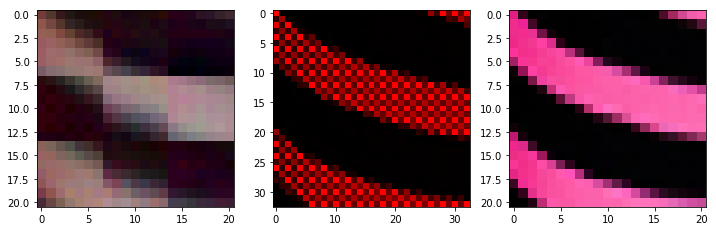

Epoch [497/500], Step [0/25], Loss: 0.017561018466949463
Epoch [497/500], Step [10/25], Loss: 0.017920101061463356
Epoch [497/500], Step [20/25], Loss: 0.018457813188433647

Finished Epoch 497, Loss --- mean: 0.018214377909898757, std 0.0006085558799017264



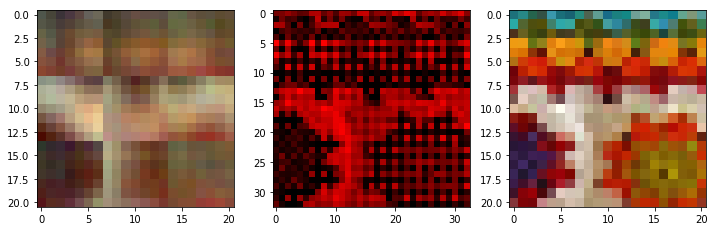

Epoch [498/500], Step [0/25], Loss: 0.018862884491682053
Epoch [498/500], Step [10/25], Loss: 0.017657065764069557
Epoch [498/500], Step [20/25], Loss: 0.01940750703215599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Finished Epoch 498, Loss --- mean: 0.018282512575387953, std 0.0006827841770488492



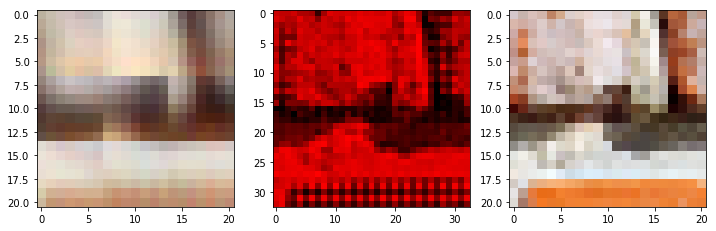

Epoch [499/500], Step [0/25], Loss: 0.01861874759197235
Epoch [499/500], Step [10/25], Loss: 0.017236124724149704
Epoch [499/500], Step [20/25], Loss: 0.019190479069948196

Finished Epoch 499, Loss --- mean: 0.018849544152617456, std 0.0008479922798863467



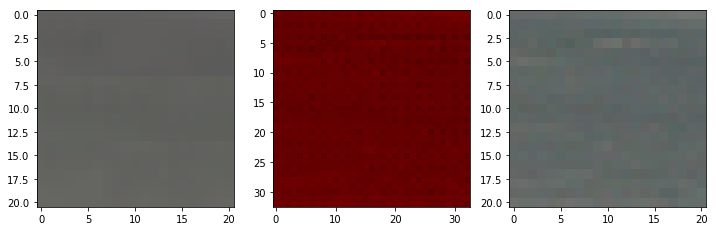

In [13]:
total_step = len(data_loader)
loss_list = []
for epoch in range(n_epochs):
    epoch_loss = []
    for idx, (cfa, target) in enumerate(data_loader):
        cfa = cfa.float().to(device)
        target = target.float().to(device)

        outputs = model(cfa)
        loss = criterion(outputs, target)
        loss_list.append(loss.item())
        epoch_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if idx % 10 == 0:
            #print(outputs)
            print(f'Epoch [{epoch}/{n_epochs}], Step [{idx}/{total_step}], Loss: {loss.item()}')
    epoch_stats = np.array(epoch_loss)
    print(f'\nFinished Epoch {epoch}, Loss --- mean: {epoch_stats.mean()}, std {epoch_stats.std()}\n')
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8))
    ax1.imshow(np.array(outputs[-1].tolist()).reshape((21, 21, 3)))
    ax2.imshow(np.array(cfa[-1].tolist()).reshape((33, 33, 3)))
    ax3.imshow(np.array(target[-1].tolist()).reshape((21, 21, 3)))
    plt.show()